In [1]:
Packages <- c("dplyr","broom","cubature", "geosphere", "data.table",  "ggplot2", "bbmle", "dplyr","tidyr", "stringr", "tidyverse", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/oceanography')
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum0.5.R") #integrate_kernel_sum1
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum1.R") #integrate_kernel_sum0.5
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve.R") #median
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve90.R") #dist 90% retained
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernPDF.R")


In [12]:
#this table is a summary table with the average values from the ROMS
#SimPlusGenFits <- read.csv(file="~/oceanography/script_output/KernelFits/SimPlusGenKernelFits.csv", header=T, stringsAsFactors = F)

##this has all of the fits from each kernel fit iteration
#CombinedSims <- read.csv(file="~/oceanography/script_output/KernelFits/CombinedSimulationKernelFits.csv", header=T, stringsAsFactors = F) %>% #for lab meeting plots 04/12/2021, use the "no other" fits because the other kind of swamped stuff out
#    gather(2:6, key="variable", value="value") %>% 
#    mutate(DataType="Sim") %>%
#    rename(Year="year") %>%
#    select(-Adj)
SimKernels <- fread(file="~/oceanography/script_output/KernelFits/SimulationKernelFits.csv")

#read in the genetic profiles to plot from 
GenProfile2012_14 <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/profile95CI_2012-14.csv", header=T) %>%
    mutate(Year="2012-14") %>%
    sample_n(1000) %>%
    mutate(iteration=row_number())
    
GenProfile2012 <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/profile95CI_2012.csv", header=T) %>%
    mutate(Year="2012") %>%
    sample_n(1000) %>%
    mutate(iteration=row_number())

GenProfile2013 <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/profile95CI_2013.csv", header=T) %>%
    mutate(Year="2013") %>%
    sample_n(1000) %>%
    mutate(iteration=row_number())

GenProfile2014 <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/profile95CI_2014.csv", header=T) %>%
    mutate(Year="2014") %>%
    sample_n(1000) %>%
    mutate(iteration=row_number())

#create one data frame, and then sample 1000 from the likelihood profile
GenProfiles <- bind_rows(GenProfile2012, GenProfile2013, GenProfile2014, GenProfile2012_14) %>%
    rename(k="k_eval", theta="theta_eval") %>%
    gather(1:2, key=variable, value=value) %>%
    mutate(DataType="Gen") %>%
    select(-log_like) 
#check the correct number were sampled
nrow(GenProfiles)==8000 #should be True, four time frames and two rows for each iteration (k and theta)

CombinedSimsGen <- bind_rows(CombinedSims, GenProfiles)


[1] TRUE

In [13]:
head(CombinedSimsGen)
head(SimPlusGenFits)

Year,iteration,variable,value,DataType
2012,1,k,-2.830052,Sim
2012,2,k,-2.475551,Sim
2012,3,k,-2.698816,Sim
2012,4,k,7.283294,Sim
2012,5,k,-2.696362,Sim
2012,6,k,-2.637948,Sim


Year,DataType,Stat,variable,value
2012,Sim,mean,k,-1.690500
2013,Sim,mean,k,-1.131624
2014,Sim,mean,k,-1.406815
2012-14,Sim,mean,k,-2.284727
2012,Sim,min,k,-3.058722
2013,Sim,min,k,-2.793652


In [14]:
#make a df with the pdf values at each distance to plot for each kernel fit
#get all the case k and theta averages to plot
FitsToPlot <- SimPlusGenFits %>% 
    filter(variable %in% c("k", "theta") ) %>%
    filter(Stat=="Mean" | Stat=="MLE") #%>%
   #mutate(Adj=ifelse(is.na(Adj), "no", Adj)) #change the NAs to no for the genetic

SimCasesToPlot <- FitsToPlot %>% 
     distinct(Year, DataType)

#distances to plot
distances <- data.frame(dist=seq(0, 60, 0.1))

SimCasesToPlot$distance <- NA
SimCasesToPlot$dispersal <- NA


SimToPlot <- SimCasesToPlot[FALSE,]

#make a long form df for each combo to plot

for(i in 1:nrow(SimCasesToPlot)){
    
    case_eval <- SimCasesToPlot[i,] #select row by position, each row represents the average fit for a given year and case combination
    
    k_eval <- as.numeric(FitsToPlot %>% #pull out the avg value of k that matches the year/case
        ungroup() %>%
        filter(Year==case_eval$Year & DataType==case_eval$DataType & variable=="k") %>%
        select(value))
    
    theta_eval <- as.numeric(FitsToPlot %>% #pull out the avg value of theta that matches the year/case
        ungroup() %>%
        filter(Year==case_eval$Year & DataType==case_eval$DataType & variable=="theta") %>%
        select(value))
    
    case_eval_build <- case_eval[FALSE,] #this will become the df with pdf at each distance for a given year/case combo

    for(j in 1:nrow(distances)){ #go through each distance and compute the pdf value. append the original df so that there's a row for each year/case/distance combination
        
        case_eval_beta <- case_eval
        
        dist_eval <- distances[j,]
        case_eval_beta$distance <- dist_eval
        case_eval_beta$dispersal <- predicted_disp(k=k_eval, theta=theta_eval, d=dist_eval)
        
        case_eval_build <- bind_rows(case_eval_build, case_eval_beta)
    
    }
    
        SimToPlot <- bind_rows(SimToPlot, case_eval_build) #add to the larger df that will eventually have all year/case/dist/pdf combos

}


In [15]:
head(SimToPlot %>% filter(DataType=="Gen"))
#(FitsToPlot)

Year,DataType,distance,dispersal
2012,Gen,0.0,0.09556381
2012,Gen,0.1,0.09478249
2012,Gen,0.2,0.09397513
2012,Gen,0.3,0.09316204
2012,Gen,0.4,0.09234778
2012,Gen,0.5,0.09153451


In [ ]:
#make plots for each case

Warning message:
“Removed 80 row(s) containing missing values (geom_path).”Warning message:
“Removed 84 row(s) containing missing values (geom_path).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 80 row(s) containing missing values (geom_path).”Warning message:
“Removed 84 row(s) containing missing values (geom_path).”

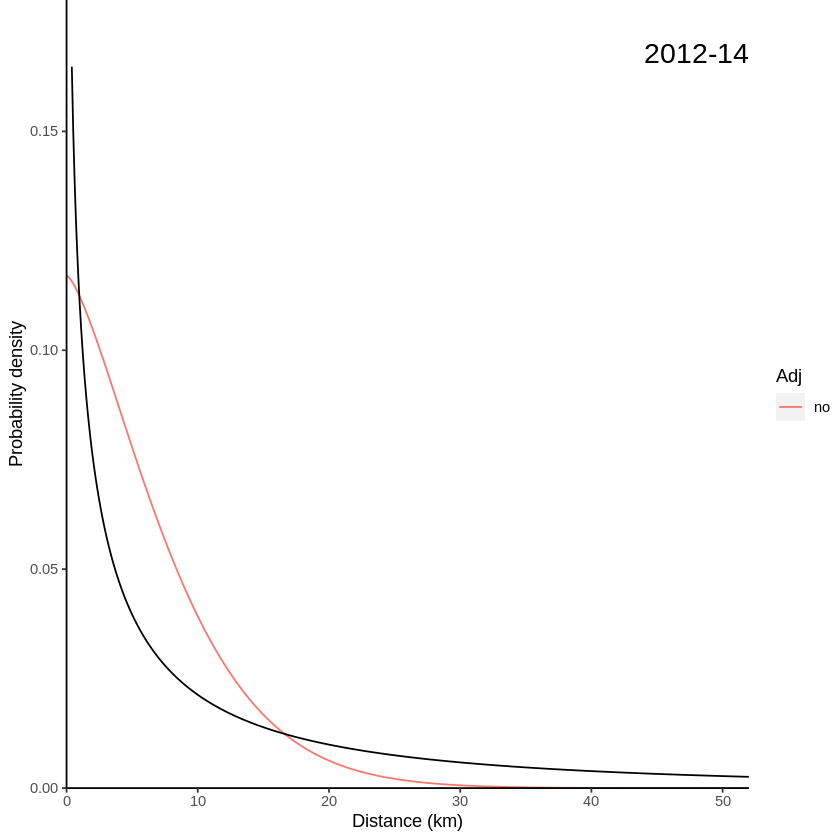

In [85]:
CaseKernels2012_14 <- ggplot(data= (SimToPlot %>% filter(Year=="2012-14" & DataType=="Sim")), aes(x=distance, y=dispersal, color=Adj))+ 
    geom_line()+ #data=to_plot_df2, aes(x=dist, y=pdf, group=iter), color="gray60", size=.2, alpha=0.2
    geom_line(data=(SimToPlot %>% filter(Year=="2012-14" & DataType=="Gen")), aes(x=distance, y=dispersal), color="black") +
    #geom_area(data=kernel15, aes(x=dist, y=norm_pdf, fill=as.factor(median)), alpha=0.1)+
    annotate("text", x =Inf, y = 0.17, vjust=1, hjust=1, label = "2012-14", size=6)+#8 for publication, 15 for presentation, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##annotate("text", x =MDD15, y = 0.01, vjust=1, hjust=1, label = "mu", color="deepskyblue2", size=15, family="Helvetica", parse=T)+#, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##scale_fill_manual(values= c("whitesmoke", "cadetblue3")) +
    ##scale_color_manual(values= c("whitesmoke", "cadetblue3")) +
    #geom_line(color="black", size=.6) +  
    ##geom_vline(xintercept = MDD15, linetype="dotted", color = "deepskyblue2", size=1) +
    theme(#axis.title.y=element_blank(),
    #axis.title.x=element_blank(),
    #plot.background = element_rect(colour = "black", size = 1),
    #axis.text.x =  element_text(size=15, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    #axis.text.y =  element_blank(), #element_text(size=15, color="black", family="Helvetica"), 
    panel.grid.major = element_blank(),
    plot.margin=unit(c(0,0,0.2,0.2),"cm"),#,
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Distance (km)") + #
    ylab("Probability density") + 
    #guides(fill=FALSE)+
    scale_x_continuous(limits = c(0,52), expand = c(0, 0), breaks=c(seq(0, 50, 10))) +
    scale_y_continuous(expand = c(0,0), limits = c(0,.18)) 


CaseKernels2012_14
#ggsave(filename="SimulationCaseKernelFits2012_14.png", plot= CaseKernels2012_14, path="~/oceanography/script_output/KernelFits/Plots/" )


In [70]:
CombinedSimsGenDT <- setDT(CombinedSimsGen)
CombinedSimsGenDT <- CombinedSimsGenDT[variable %in% c("k", "theta", "MLE")]

FitsToPlot <- unique(CombinedSimsGenDT[, c("Year", "DataType")])
head(CombinedSimsGenDT)

Year,iteration,variable,value,DataType
2012,1,k,-2.830052,Sim
2012,2,k,-2.475551,Sim
2012,3,k,-2.698816,Sim
2012,4,k,7.283294,Sim
2012,5,k,-2.696362,Sim
2012,6,k,-2.637948,Sim


In [74]:
iteration_eval <- 80 
CombinedSimsGenDT[variable=="k", iteration==iteration_eval & Year==case_eval$Year & DataType==case_eval$DataType ] #pull a row to get the theta/k values for that iteration


[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [61] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [73] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [121] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [133] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [145] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [157] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [169] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [181] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [193] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [205] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [217] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [229] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [241] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [253] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [265] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [277] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [289] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [301] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [313] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [325] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [337] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [349] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [361] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [373] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [385] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [397] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [409] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [421] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [433] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [445] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [457] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [469] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [481] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [493] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [505] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [517] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [529] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [541] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [553] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [565] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [577] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [589] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [6

In [41]:
#to plot all ensembles
#make a df with the pdf values at each distance to plot for each kernel fit
#get all the case k and theta averages to plot
CombinedSimsGenDT <- setDT(CombinedSimsGen)
CombinedSimsGenDT <- CombinedSimsGenDT[variable %in% c("k", "theta", "MLE")]

FitsToPlot <- unique(CombinedSimsGenDT[, c("Year", "DataType")])

#distances to plot
distances <- seq(0, 60, .1) #these are the distances to iterate over

full_res <- data.table(Year=character(), iteration=numeric(), DataType=character(), distance=numeric(), dispersal=numeric()) #this will hold all of those year/adj/iterationcombinations
year_adj_res <- data.table(Year=character(), iteration=numeric(), DataType=character(), distance=numeric(), dispersal=numeric()) #this will hold results for every iteration in a year/case combo

#SimToPlot <- SimCasesToPlot[FALSE,]

#make a long form df for each combo to plot
pb <- txtProgressBar(min = 0, max = nrow(FitsToPlot), style = 3)
start_time <- Sys.time()

for(i in 1:nrow(FitsToPlot)){
    
    case_eval <- FitsToPlot[i,] #select row by position, each row represents the average fit for a given year and case combination

    sampled_iterations <- sample.int(1000, 100, replace=F) #make a vector of iterations out of the full 1000 to sample for plotting

    iteration_res <- data.table(Year=character(), iteration=numeric(), DataType=character(), distance=numeric(), dispersal=numeric()) [1:length(distances)]#this will hold results for each iteration pdf at each distance
}
 for(k in 1:length(sampled_iterations )){ 
     
         iteration_eval <- sampled_iterations[k] 

         k_eval <- CombinedSimsGenDT[CombinedSimsGenDT$iteration==iteration_eval & CombinedSimsGenDT$Year==case_eval$Year & CombinedSimsGenDT$DataType==case_eval$DataType, k] #pull a row to get the theta/k values for that iteration
     
         theta_eval <- CombinedSimsGenDT[CombinedSimsGenDT$iteration==iteration_eval & CombinedSimsGenDT$Year==case_eval$Year & CombinedSimsGenDT$DataType==case_eval$DataType, theta] 
         

         iteration_res$distance <- distances #before starting the loop, plug in the vector with distances as column values and the year/adj identifying information, that doesn't need to be done every time within the loop just once outside
         iteration_res$Year <- case_eval$Year
         iteration_res$DataType <- case_eval$DataType
         iteration_res$iteration <- iteration_eval
     #for(j in 1:length(distances)){ #go through each distance and compute the pdf value. append the original df so that there's a row for each year/case/distance combination
   
   
   iteration_res$dispersal <-  exp(k_eval) * theta_eval * exp(-(exp(k_eval) * distances)^theta_eval)/gamma(1/theta_eval) #perform the pdf calculation operation on the whole distance vector once
   
   year_adj_res <- rbind(year_adj_res, iteration_res) #add in the results for a given iteration to a table specific to the year/adj combination

   }
      
#full_res <- rbind(full_res, year_adj_res) #add in the table for all sampled iteration pdfs across selected distances for each year/adj combo to a table for every year/adj combo
    setTxtProgressBar(pb, i)
} 

end_time <- Sys.time()
end_time-start_time   
#write.csv(year_adj_res, file="~/oceanography/script_output/KernelFits/Plots/SampledKernelsForPlotting.csv", row.names=F)




ERROR: Error: Each row of output must be identified by a unique combination of keys.
Keys are shared for 60000 rows:
* 52001, 56001, 59001, 62001
* 52002, 56002, 59002, 62002
* 52003, 56003, 59003, 62003
* 52004, 56004, 59004, 62004
* 52005, 56005, 59005, 62005
* 52006, 56006, 59006, 62006
* 52007, 56007, 59007, 62007
* 52008, 56008, 59008, 62008
* 52009, 56009, 59009, 62009
* 52010, 56010, 59010, 62010
* 52011, 56011, 59011, 62011
* 52012, 56012, 59012, 62012
* 52013, 56013, 59013, 62013
* 52014, 56014, 59014, 62014
* 52015, 56015, 59015, 62015
* 52016, 56016, 59016, 62016
* 52017, 56017, 59017, 62017
* 52018, 56018, 59018, 62018
* 52019, 56019, 59019, 62019
* 52020, 56020, 59020, 62020
* 52021, 56021, 59021, 62021
* 52022, 56022, 59022, 62022
* 52023, 56023, 59023, 62023
* 52024, 56024, 59024, 62024
* 52025, 56025, 59025, 62025
* 52026, 56026, 59026, 62026
* 52027, 56027, 59027, 62027
* 52028, 56028, 59028, 62028
* 52029, 56029, 59029, 62029
* 52030, 56030, 59030, 62030
* 52031, 56031, 59031, 62031
* 52032, 56032, 59032, 62032
* 52033, 56033, 59033, 62033
* 52034, 56034, 59034, 62034
* 52035, 56035, 59035, 62035
* 52036, 56036, 59036, 62036
* 52037, 56037, 59037, 62037
* 52038, 56038, 59038, 62038
* 52039, 56039, 59039, 62039
* 52040, 56040, 59040, 62040
* 52041, 56041, 59041, 62041
* 52042, 56042, 59042, 62042
* 52043, 56043, 59043, 62043
* 52044, 56044, 59044, 62044
* 52045, 56045, 59045, 62045
* 52046, 56046, 59046, 62046
* 52047, 56047, 59047, 62047
* 52048, 56048, 59048, 62048
* 52049, 56049, 59049, 62049
* 52050, 56050, 59050, 62050
* 52051, 56051, 59051, 62051
* 52052, 56052, 59052, 62052
* 52053, 56053, 59053, 62053
* 52054, 56054, 59054, 62054
* 52055, 56055, 59055, 62055
* 52056, 56056, 59056, 62056
* 52057, 56057, 59057, 62057
* 52058, 56058, 59058, 62058
* 52059, 56059, 59059, 62059
* 52060, 56060, 59060, 62060
* 52061, 56061, 59061, 62061
* 52062, 56062, 59062, 62062
* 52063, 56063, 59063, 62063
* 52064, 56064, 59064, 62064
* 52065, 56065, 59065, 62065
* 52066, 56066, 59066, 62066
* 52067, 56067, 59067, 62067
* 52068, 56068, 59068, 62068
* 52069, 56069, 59069, 62069
* 52070, 56070, 59070, 62070
* 52071, 56071, 59071, 62071
* 52072, 56072, 59072, 62072
* 52073, 56073, 59073, 62073
* 52074, 56074, 59074, 62074
* 52075, 56075, 59075, 62075
* 52076, 56076, 59076, 62076
* 52077, 56077, 59077, 62077
* 52078, 56078, 59078, 62078
* 52079, 56079, 59079, 62079
* 52080, 56080, 59080, 62080
* 52081, 56081, 59081, 62081
* 52082, 56082, 59082, 62082
* 52083, 56083, 59083, 62083
* 52084, 56084, 59084, 62084
* 52085, 56085, 59085, 62085
* 52086, 56086, 59086, 62086
* 52087, 56087, 59087, 62087
* 52088, 56088, 59088, 62088
* 52089, 56089, 59089, 62089
* 52090, 56090, 59090, 62090
* 52091, 56091, 59091, 62091
* 52092, 56092, 59092, 62092
* 52093, 56093, 59093, 62093
* 52094, 56094, 59094, 62094
* 52095, 56095, 59095, 62095
* 52096, 56096, 59096, 62096
* 52097, 56097, 59097, 62097
* 52098, 56098, 59098, 62098
* 52099, 56099, 59099, 62099
* 52100, 56100, 59100, 62100
* 52101, 56101, 59101, 62101
* 52102, 56102, 59102, 62102
* 52103, 56103, 59103, 62103
* 52104, 56104, 59104, 62104
* 52105, 56105, 59105, 62105
* 52106, 56106, 59106, 62106
* 52107, 56107, 59107, 62107
* 52108, 56108, 59108, 62108
* 52109, 56109, 59109, 62109
* 52110, 56110, 59110, 62110
* 52111, 56111, 59111, 62111
* 52112, 56112, 59112, 62112
* 52113, 56113, 59113, 62113
* 52114, 56114, 59114, 62114
* 52115, 56115, 59115, 62115
* 52116, 56116, 59116, 62116
* 52117, 56117, 59117, 62117
* 52118, 56118, 59118, 62118
* 52119, 56119, 59119, 62119
* 52120, 56120, 59120, 62120
* 52121, 56121, 59121, 62121
* 52122, 56122, 59122, 62122
* 52123, 56123, 59123, 62123
* 52124, 56124, 59124, 62124
* 52125, 56125, 59125, 62125
* 52126, 56126, 59126, 62126
* 52127, 56127, 59127, 62127
* 52128, 56128, 59128, 62128
* 52129, 56129, 59129, 62129
* 52130, 56130, 59130, 62130
* 52131, 56131, 59131, 62131
* 52132, 56132, 59132, 62132
* 52133, 56133, 59133, 62133
* 52134, 56134, 59134, 62134
* 52135, 56135, 59135, 62135
* 52136, 56136, 59136, 62136
* 52137, 56137, 59137, 62137
* 52138, 56138, 59138, 62138
* 52139, 56139, 59139, 62139
* 52140, 56140, 59140, 62140
* 52141, 56141, 59141, 62141
* 52142, 56142, 59142, 62142
* 52143, 56143, 59143, 62143
* 52144, 56144, 59144, 62144
* 52145, 56145, 59145, 62145
* 52146, 56146, 59146, 62146
* 52147, 56147, 59147, 62147
* 52148, 56148, 59148, 62148
* 52149, 56149, 59149, 62149
* 52150, 56150, 59150, 62150
* 52151, 56151, 59151, 62151
* 52152, 56152, 59152, 62152
* 52153, 56153, 59153, 62153
* 52154, 56154, 59154, 62154
* 52155, 56155, 59155, 62155
* 52156, 56156, 59156, 62156
* 52157, 56157, 59157, 62157
* 52158, 56158, 59158, 62158
* 52159, 56159, 59159, 62159
* 52160, 56160, 59160, 62160
* 52161, 56161, 59161, 62161
* 52162, 56162, 59162, 62162
* 52163, 56163, 59163, 62163
* 52164, 56164, 59164, 62164
* 52165, 56165, 59165, 62165
* 52166, 56166, 59166, 62166
* 52167, 56167, 59167, 62167
* 52168, 56168, 59168, 62168
* 52169, 56169, 59169, 62169
* 52170, 56170, 59170, 62170
* 52171, 56171, 59171, 62171
* 52172, 56172, 59172, 62172
* 52173, 56173, 59173, 62173
* 52174, 56174, 59174, 62174
* 52175, 56175, 59175, 62175
* 52176, 56176, 59176, 62176
* 52177, 56177, 59177, 62177
* 52178, 56178, 59178, 62178
* 52179, 56179, 59179, 62179
* 52180, 56180, 59180, 62180
* 52181, 56181, 59181, 62181
* 52182, 56182, 59182, 62182
* 52183, 56183, 59183, 62183
* 52184, 56184, 59184, 62184
* 52185, 56185, 59185, 62185
* 52186, 56186, 59186, 62186
* 52187, 56187, 59187, 62187
* 52188, 56188, 59188, 62188
* 52189, 56189, 59189, 62189
* 52190, 56190, 59190, 62190
* 52191, 56191, 59191, 62191
* 52192, 56192, 59192, 62192
* 52193, 56193, 59193, 62193
* 52194, 56194, 59194, 62194
* 52195, 56195, 59195, 62195
* 52196, 56196, 59196, 62196
* 52197, 56197, 59197, 62197
* 52198, 56198, 59198, 62198
* 52199, 56199, 59199, 62199
* 52200, 56200, 59200, 62200
* 52201, 56201, 59201, 62201
* 52202, 56202, 59202, 62202
* 52203, 56203, 59203, 62203
* 52204, 56204, 59204, 62204
* 52205, 56205, 59205, 62205
* 52206, 56206, 59206, 62206
* 52207, 56207, 59207, 62207
* 52208, 56208, 59208, 62208
* 52209, 56209, 59209, 62209
* 52210, 56210, 59210, 62210
* 52211, 56211, 59211, 62211
* 52212, 56212, 59212, 62212
* 52213, 56213, 59213, 62213
* 52214, 56214, 59214, 62214
* 52215, 56215, 59215, 62215
* 52216, 56216, 59216, 62216
* 52217, 56217, 59217, 62217
* 52218, 56218, 59218, 62218
* 52219, 56219, 59219, 62219
* 52220, 56220, 59220, 62220
* 52221, 56221, 59221, 62221
* 52222, 56222, 59222, 62222
* 52223, 56223, 59223, 62223
* 52224, 56224, 59224, 62224
* 52225, 56225, 59225, 62225
* 52226, 56226, 59226, 62226
* 52227, 56227, 59227, 62227
* 52228, 56228, 59228, 62228
* 52229, 56229, 59229, 62229
* 52230, 56230, 59230, 62230
* 52231, 56231, 59231, 62231
* 52232, 56232, 59232, 62232
* 52233, 56233, 59233, 62233
* 52234, 56234, 59234, 62234
* 52235, 56235, 59235, 62235
* 52236, 56236, 59236, 62236
* 52237, 56237, 59237, 62237
* 52238, 56238, 59238, 62238
* 52239, 56239, 59239, 62239
* 52240, 56240, 59240, 62240
* 52241, 56241, 59241, 62241
* 52242, 56242, 59242, 62242
* 52243, 56243, 59243, 62243
* 52244, 56244, 59244, 62244
* 52245, 56245, 59245, 62245
* 52246, 56246, 59246, 62246
* 52247, 56247, 59247, 62247
* 52248, 56248, 59248, 62248
* 52249, 56249, 59249, 62249
* 52250, 56250, 59250, 62250
* 52251, 56251, 59251, 62251
* 52252, 56252, 59252, 62252
* 52253, 56253, 59253, 62253
* 52254, 56254, 59254, 62254
* 52255, 56255, 59255, 62255
* 52256, 56256, 59256, 62256
* 52257, 56257, 59257, 62257
* 52258, 56258, 59258, 62258
* 52259, 56259, 59259, 62259
* 52260, 56260, 59260, 62260
* 52261, 56261, 59261, 62261
* 52262, 56262, 59262, 62262
* 52263, 56263, 59263, 62263
* 52264, 56264, 59264, 62264
* 52265, 56265, 59265, 62265
* 52266, 56266, 59266, 62266
* 52267, 56267, 59267, 62267
* 52268, 56268, 59268, 62268
* 52269, 56269, 59269, 62269
* 52270, 56270, 59270, 62270
* 52271, 56271, 59271, 62271
* 52272, 56272, 59272, 62272
* 52273, 56273, 59273, 62273
* 52274, 56274, 59274, 62274
* 52275, 56275, 59275, 62275
* 52276, 56276, 59276, 62276
* 52277, 56277, 59277, 62277
* 52278, 56278, 59278, 62278
* 52279, 56279, 59279, 62279
* 52280, 56280, 59280, 62280
* 52281, 56281, 59281, 62281
* 52282, 56282, 59282, 62282
* 52283, 56283, 59283, 62283
* 52284, 56284, 59284, 62284
* 52285, 56285, 59285, 62285
* 52286, 56286, 59286, 62286
* 52287, 56287, 59287, 62287
* 52288, 56288, 59288, 62288
* 52289, 56289, 59289, 62289
* 52290, 56290, 59290, 62290
* 52291, 56291, 59291, 62291
* 52292, 56292, 59292, 62292
* 52293, 56293, 59293, 62293
* 52294, 56294, 59294, 62294
* 52295, 56295, 59295, 62295
* 52296, 56296, 59296, 62296
* 52297, 56297, 59297, 62297
* 52298, 56298, 59298, 62298
* 52299, 56299, 59299, 62299
* 52300, 56300, 59300, 62300
* 52301, 56301, 59301, 62301
* 52302, 56302, 59302, 62302
* 52303, 56303, 59303, 62303
* 52304, 56304, 59304, 62304
* 52305, 56305, 59305, 62305
* 52306, 56306, 59306, 62306
* 52307, 56307, 59307, 62307
* 52308, 56308, 59308, 62308
* 52309, 56309, 59309, 62309
* 52310, 56310, 59310, 62310
* 52311, 56311, 59311, 62311
* 52312, 56312, 59312, 62312
* 52313, 56313, 59313, 62313
* 52314, 56314, 59314, 62314
* 52315, 56315, 59315, 62315
* 52316, 56316, 59316, 62316
* 52317, 56317, 59317, 62317
* 52318, 56318, 59318, 62318
* 52319, 56319, 59319, 62319
* 52320, 56320, 59320, 62320
* 52321, 56321, 59321, 62321
* 52322, 56322, 59322, 62322
* 52323, 56323, 59323, 62323
* 52324, 56324, 59324, 62324
* 52325, 56325, 59325, 62325
* 52326, 56326, 59326, 62326
* 52327, 56327, 59327, 62327
* 52328, 56328, 59328, 62328
* 52329, 56329, 59329, 62329
* 52330, 56330, 59330, 62330
* 52331, 56331, 59331, 62331
* 52332, 56332, 59332, 62332
* 52333, 56333, 59333, 62333
* 52334, 56334, 59334, 62334
* 52335, 56335, 59335, 62335
* 52336, 56336, 59336, 62336
* 52337, 56337, 59337, 62337
* 52338, 56338, 59338, 62338
* 52339, 56339, 59339, 62339
* 52340, 56340, 59340, 62340
* 52341, 56341, 59341, 62341
* 52342, 56342, 59342, 62342
* 52343, 56343, 59343, 62343
* 52344, 56344, 59344, 62344
* 52345, 56345, 59345, 62345
* 52346, 56346, 59346, 62346
* 52347, 56347, 59347, 62347
* 52348, 56348, 59348, 62348
* 52349, 56349, 59349, 62349
* 52350, 56350, 59350, 62350
* 52351, 56351, 59351, 62351
* 52352, 56352, 59352, 62352
* 52353, 56353, 59353, 62353
* 52354, 56354, 59354, 62354
* 52355, 56355, 59355, 62355
* 52356, 56356, 59356, 62356
* 52357, 56357, 59357, 62357
* 52358, 56358, 59358, 62358
* 52359, 56359, 59359, 62359
* 52360, 56360, 59360, 62360
* 52361, 56361, 59361, 62361
* 52362, 56362, 59362, 62362
* 52363, 56363, 59363, 62363
* 52364, 56364, 59364, 62364
* 52365, 56365, 59365, 62365
* 52366, 56366, 59366, 62366
* 52367, 56367, 59367, 62367
* 52368, 56368, 59368, 62368
* 52369, 56369, 59369, 62369
* 52370, 56370, 59370, 62370
* 52371, 56371, 59371, 62371
* 52372, 56372, 59372, 62372
* 52373, 56373, 59373, 62373
* 52374, 56374, 59374, 62374
* 52375, 56375, 59375, 62375
* 52376, 56376, 59376, 62376
* 52377, 56377, 59377, 62377
* 52378, 56378, 59378, 62378
* 52379, 56379, 59379, 62379
* 52380, 56380, 59380, 62380
* 52381, 56381, 59381, 62381
* 52382, 56382, 59382, 62382
* 52383, 56383, 59383, 62383
* 52384, 56384, 59384, 62384
* 52385, 56385, 59385, 62385
* 52386, 56386, 59386, 62386
* 52387, 56387, 59387, 62387
* 52388, 56388, 59388, 62388
* 52389, 56389, 59389, 62389
* 52390, 56390, 59390, 62390
* 52391, 56391, 59391, 62391
* 52392, 56392, 59392, 62392
* 52393, 56393, 59393, 62393
* 52394, 56394, 59394, 62394
* 52395, 56395, 59395, 62395
* 52396, 56396, 59396, 62396
* 52397, 56397, 59397, 62397
* 52398, 56398, 59398, 62398
* 52399, 56399, 59399, 62399
* 52400, 56400, 59400, 62400
* 52401, 56401, 59401, 62401
* 52402, 56402, 59402, 62402
* 52403, 56403, 59403, 62403
* 52404, 56404, 59404, 62404
* 52405, 56405, 59405, 62405
* 52406, 56406, 59406, 62406
* 52407, 56407, 59407, 62407
* 52408, 56408, 59408, 62408
* 52409, 56409, 59409, 62409
* 52410, 56410, 59410, 62410
* 52411, 56411, 59411, 62411
* 52412, 56412, 59412, 62412
* 52413, 56413, 59413, 62413
* 52414, 56414, 59414, 62414
* 52415, 56415, 59415, 62415
* 52416, 56416, 59416, 62416
* 52417, 56417, 59417, 62417
* 52418, 56418, 59418, 62418
* 52419, 56419, 59419, 62419
* 52420, 56420, 59420, 62420
* 52421, 56421, 59421, 62421
* 52422, 56422, 59422, 62422
* 52423, 56423, 59423, 62423
* 52424, 56424, 59424, 62424
* 52425, 56425, 59425, 62425
* 52426, 56426, 59426, 62426
* 52427, 56427, 59427, 62427
* 52428, 56428, 59428, 62428
* 52429, 56429, 59429, 62429
* 52430, 56430, 59430, 62430
* 52431, 56431, 59431, 62431
* 52432, 56432, 59432, 62432
* 52433, 56433, 59433, 62433
* 52434, 56434, 59434, 62434
* 52435, 56435, 59435, 62435
* 52436, 56436, 59436, 62436
* 52437, 56437, 59437, 62437
* 52438, 56438, 59438, 62438
* 52439, 56439, 59439, 62439
* 52440, 56440, 59440, 62440
* 52441, 56441, 59441, 62441
* 52442, 56442, 59442, 62442
* 52443, 56443, 59443, 62443
* 52444, 56444, 59444, 62444
* 52445, 56445, 59445, 62445
* 52446, 56446, 59446, 62446
* 52447, 56447, 59447, 62447
* 52448, 56448, 59448, 62448
* 52449, 56449, 59449, 62449
* 52450, 56450, 59450, 62450
* 52451, 56451, 59451, 62451
* 52452, 56452, 59452, 62452
* 52453, 56453, 59453, 62453
* 52454, 56454, 59454, 62454
* 52455, 56455, 59455, 62455
* 52456, 56456, 59456, 62456
* 52457, 56457, 59457, 62457
* 52458, 56458, 59458, 62458
* 52459, 56459, 59459, 62459
* 52460, 56460, 59460, 62460
* 52461, 56461, 59461, 62461
* 52462, 56462, 59462, 62462
* 52463, 56463, 59463, 62463
* 52464, 56464, 59464, 62464
* 52465, 56465, 59465, 62465
* 52466, 56466, 59466, 62466
* 52467, 56467, 59467, 62467
* 52468, 56468, 59468, 62468
* 52469, 56469, 59469, 62469
* 52470, 56470, 59470, 62470
* 52471, 56471, 59471, 62471
* 52472, 56472, 59472, 62472
* 52473, 56473, 59473, 62473
* 52474, 56474, 59474, 62474
* 52475, 56475, 59475, 62475
* 52476, 56476, 59476, 62476
* 52477, 56477, 59477, 62477
* 52478, 56478, 59478, 62478
* 52479, 56479, 59479, 62479
* 52480, 56480, 59480, 62480
* 52481, 56481, 59481, 62481
* 52482, 56482, 59482, 62482
* 52483, 56483, 59483, 62483
* 52484, 56484, 59484, 62484
* 52485, 56485, 59485, 62485
* 52486, 56486, 59486, 62486
* 52487, 56487, 59487, 62487
* 52488, 56488, 59488, 62488
* 52489, 56489, 59489, 62489
* 52490, 56490, 59490, 62490
* 52491, 56491, 59491, 62491
* 52492, 56492, 59492, 62492
* 52493, 56493, 59493, 62493
* 52494, 56494, 59494, 62494
* 52495, 56495, 59495, 62495
* 52496, 56496, 59496, 62496
* 52497, 56497, 59497, 62497
* 52498, 56498, 59498, 62498
* 52499, 56499, 59499, 62499
* 52500, 56500, 59500, 62500
* 52501, 56501, 59501, 62501
* 52502, 56502, 59502, 62502
* 52503, 56503, 59503, 62503
* 52504, 56504, 59504, 62504
* 52505, 56505, 59505, 62505
* 52506, 56506, 59506, 62506
* 52507, 56507, 59507, 62507
* 52508, 56508, 59508, 62508
* 52509, 56509, 59509, 62509
* 52510, 56510, 59510, 62510
* 52511, 56511, 59511, 62511
* 52512, 56512, 59512, 62512
* 52513, 56513, 59513, 62513
* 52514, 56514, 59514, 62514
* 52515, 56515, 59515, 62515
* 52516, 56516, 59516, 62516
* 52517, 56517, 59517, 62517
* 52518, 56518, 59518, 62518
* 52519, 56519, 59519, 62519
* 52520, 56520, 59520, 62520
* 52521, 56521, 59521, 62521
* 52522, 56522, 59522, 62522
* 52523, 56523, 59523, 62523
* 52524, 56524, 59524, 62524
* 52525, 56525, 59525, 62525
* 52526, 56526, 59526, 62526
* 52527, 56527, 59527, 62527
* 52528, 56528, 59528, 62528
* 52529, 56529, 59529, 62529
* 52530, 56530, 59530, 62530
* 52531, 56531, 59531, 62531
* 52532, 56532, 59532, 62532
* 52533, 56533, 59533, 62533
* 52534, 56534, 59534, 62534
* 52535, 56535, 59535, 62535
* 52536, 56536, 59536, 62536
* 52537, 56537, 59537, 62537
* 52538, 56538, 59538, 62538
* 52539, 56539, 59539, 62539
* 52540, 56540, 59540, 62540
* 52541, 56541, 59541, 62541
* 52542, 56542, 59542, 62542
* 52543, 56543, 59543, 62543
* 52544, 56544, 59544, 62544
* 52545, 56545, 59545, 62545
* 52546, 56546, 59546, 62546
* 52547, 56547, 59547, 62547
* 52548, 56548, 59548, 62548
* 52549, 56549, 59549, 62549
* 52550, 56550, 59550, 62550
* 52551, 56551, 59551, 62551
* 52552, 56552, 59552, 62552
* 52553, 56553, 59553, 62553
* 52554, 56554, 59554, 62554
* 52555, 56555, 59555, 62555
* 52556, 56556, 59556, 62556
* 52557, 56557, 59557, 62557
* 52558, 56558, 59558, 62558
* 52559, 56559, 59559, 62559
* 52560, 56560, 59560, 62560
* 52561, 56561, 59561, 62561
* 52562, 56562, 59562, 62562
* 52563, 56563, 59563, 62563
* 52564, 56564, 59564, 62564
* 52565, 56565, 59565, 62565
* 52566, 56566, 59566, 62566
* 52567, 56567, 59567, 62567
* 52568, 56568, 59568, 62568
* 52569, 56569, 59569, 62569
* 52570, 56570, 59570, 62570
* 52571, 56571, 59571, 62571
* 52572, 56572, 59572, 62572
* 52573, 56573, 59573, 62573
* 52574, 56574, 59574, 62574
* 52575, 56575, 59575, 62575
* 52576, 56576, 59576, 62576
* 52577, 56577, 59577, 62577
* 52578, 56578, 59578, 62578
* 52579, 56579, 59579, 62579
* 52580, 56580, 59580, 62580
* 52581, 56581, 59581, 62581
* 52582, 56582, 59582, 62582
* 52583, 56583, 59583, 62583
* 52584, 56584, 59584, 62584
* 52585, 56585, 59585, 62585
* 52586, 56586, 59586, 62586
* 52587, 56587, 59587, 62587
* 52588, 56588, 59588, 62588
* 52589, 56589, 59589, 62589
* 52590, 56590, 59590, 62590
* 52591, 56591, 59591, 62591
* 52592, 56592, 59592, 62592
* 52593, 56593, 59593, 62593
* 52594, 56594, 59594, 62594
* 52595, 56595, 59595, 62595
* 52596, 56596, 59596, 62596
* 52597, 56597, 59597, 62597
* 52598, 56598, 59598, 62598
* 52599, 56599, 59599, 62599
* 52600, 56600, 59600, 62600
* 52601, 56601, 59601, 62601
* 52602, 56602, 59602, 62602
* 52603, 56603, 59603, 62603
* 52604, 56604, 59604, 62604
* 52605, 56605, 59605, 62605
* 52606, 56606, 59606, 62606
* 52607, 56607, 59607, 62607
* 52608, 56608, 59608, 62608
* 52609, 56609, 59609, 62609
* 52610, 56610, 59610, 62610
* 52611, 56611, 59611, 62611
* 52612, 56612, 59612, 62612
* 52613, 56613, 59613, 62613
* 52614, 56614, 59614, 62614
* 52615, 56615, 59615, 62615
* 52616, 56616, 59616, 62616
* 52617, 56617, 59617, 62617
* 52618, 56618, 59618, 62618
* 52619, 56619, 59619, 62619
* 52620, 56620, 59620, 62620
* 52621, 56621, 59621, 62621
* 52622, 56622, 59622, 62622
* 52623, 56623, 59623, 62623
* 52624, 56624, 59624, 62624
* 52625, 56625, 59625, 62625
* 52626, 56626, 59626, 62626
* 52627, 56627, 59627, 62627
* 52628, 56628, 59628, 62628
* 52629, 56629, 59629, 62629
* 52630, 56630, 59630, 62630
* 52631, 56631, 59631, 62631
* 52632, 56632, 59632, 62632
* 52633, 56633, 59633, 62633
* 52634, 56634, 59634, 62634
* 52635, 56635, 59635, 62635
* 52636, 56636, 59636, 62636
* 52637, 56637, 59637, 62637
* 52638, 56638, 59638, 62638
* 52639, 56639, 59639, 62639
* 52640, 56640, 59640, 62640
* 52641, 56641, 59641, 62641
* 52642, 56642, 59642, 62642
* 52643, 56643, 59643, 62643
* 52644, 56644, 59644, 62644
* 52645, 56645, 59645, 62645
* 52646, 56646, 59646, 62646
* 52647, 56647, 59647, 62647
* 52648, 56648, 59648, 62648
* 52649, 56649, 59649, 62649
* 52650, 56650, 59650, 62650
* 52651, 56651, 59651, 62651
* 52652, 56652, 59652, 62652
* 52653, 56653, 59653, 62653
* 52654, 56654, 59654, 62654
* 52655, 56655, 59655, 62655
* 52656, 56656, 59656, 62656
* 52657, 56657, 59657, 62657
* 52658, 56658, 59658, 62658
* 52659, 56659, 59659, 62659
* 52660, 56660, 59660, 62660
* 52661, 56661, 59661, 62661
* 52662, 56662, 59662, 62662
* 52663, 56663, 59663, 62663
* 52664, 56664, 59664, 62664
* 52665, 56665, 59665, 62665
* 52666, 56666, 59666, 62666
* 52667, 56667, 59667, 62667
* 52668, 56668, 59668, 62668
* 52669, 56669, 59669, 62669
* 52670, 56670, 59670, 62670
* 52671, 56671, 59671, 62671
* 52672, 56672, 59672, 62672
* 52673, 56673, 59673, 62673
* 52674, 56674, 59674, 62674
* 52675, 56675, 59675, 62675
* 52676, 56676, 59676, 62676
* 52677, 56677, 59677, 62677
* 52678, 56678, 59678, 62678
* 52679, 56679, 59679, 62679
* 52680, 56680, 59680, 62680
* 52681, 56681, 59681, 62681
* 52682, 56682, 59682, 62682
* 52683, 56683, 59683, 62683
* 52684, 56684, 59684, 62684
* 52685, 56685, 59685, 62685
* 52686, 56686, 59686, 62686
* 52687, 56687, 59687, 62687
* 52688, 56688, 59688, 62688
* 52689, 56689, 59689, 62689
* 52690, 56690, 59690, 62690
* 52691, 56691, 59691, 62691
* 52692, 56692, 59692, 62692
* 52693, 56693, 59693, 62693
* 52694, 56694, 59694, 62694
* 52695, 56695, 59695, 62695
* 52696, 56696, 59696, 62696
* 52697, 56697, 59697, 62697
* 52698, 56698, 59698, 62698
* 52699, 56699, 59699, 62699
* 52700, 56700, 59700, 62700
* 52701, 56701, 59701, 62701
* 52702, 56702, 59702, 62702
* 52703, 56703, 59703, 62703
* 52704, 56704, 59704, 62704
* 52705, 56705, 59705, 62705
* 52706, 56706, 59706, 62706
* 52707, 56707, 59707, 62707
* 52708, 56708, 59708, 62708
* 52709, 56709, 59709, 62709
* 52710, 56710, 59710, 62710
* 52711, 56711, 59711, 62711
* 52712, 56712, 59712, 62712
* 52713, 56713, 59713, 62713
* 52714, 56714, 59714, 62714
* 52715, 56715, 59715, 62715
* 52716, 56716, 59716, 62716
* 52717, 56717, 59717, 62717
* 52718, 56718, 59718, 62718
* 52719, 56719, 59719, 62719
* 52720, 56720, 59720, 62720
* 52721, 56721, 59721, 62721
* 52722, 56722, 59722, 62722
* 52723, 56723, 59723, 62723
* 52724, 56724, 59724, 62724
* 52725, 56725, 59725, 62725
* 52726, 56726, 59726, 62726
* 52727, 56727, 59727, 62727
* 52728, 56728, 59728, 62728
* 52729, 56729, 59729, 62729
* 52730, 56730, 59730, 62730
* 52731, 56731, 59731, 62731
* 52732, 56732, 59732, 62732
* 52733, 56733, 59733, 62733
* 52734, 56734, 59734, 62734
* 52735, 56735, 59735, 62735
* 52736, 56736, 59736, 62736
* 52737, 56737, 59737, 62737
* 52738, 56738, 59738, 62738
* 52739, 56739, 59739, 62739
* 52740, 56740, 59740, 62740
* 52741, 56741, 59741, 62741
* 52742, 56742, 59742, 62742
* 52743, 56743, 59743, 62743
* 52744, 56744, 59744, 62744
* 52745, 56745, 59745, 62745
* 52746, 56746, 59746, 62746
* 52747, 56747, 59747, 62747
* 52748, 56748, 59748, 62748
* 52749, 56749, 59749, 62749
* 52750, 56750, 59750, 62750
* 52751, 56751, 59751, 62751
* 52752, 56752, 59752, 62752
* 52753, 56753, 59753, 62753
* 52754, 56754, 59754, 62754
* 52755, 56755, 59755, 62755
* 52756, 56756, 59756, 62756
* 52757, 56757, 59757, 62757
* 52758, 56758, 59758, 62758
* 52759, 56759, 59759, 62759
* 52760, 56760, 59760, 62760
* 52761, 56761, 59761, 62761
* 52762, 56762, 59762, 62762
* 52763, 56763, 59763, 62763
* 52764, 56764, 59764, 62764
* 52765, 56765, 59765, 62765
* 52766, 56766, 59766, 62766
* 52767, 56767, 59767, 62767
* 52768, 56768, 59768, 62768
* 52769, 56769, 59769, 62769
* 52770, 56770, 59770, 62770
* 52771, 56771, 59771, 62771
* 52772, 56772, 59772, 62772
* 52773, 56773, 59773, 62773
* 52774, 56774, 59774, 62774
* 52775, 56775, 59775, 62775
* 52776, 56776, 59776, 62776
* 52777, 56777, 59777, 62777
* 52778, 56778, 59778, 62778
* 52779, 56779, 59779, 62779
* 52780, 56780, 59780, 62780
* 52781, 56781, 59781, 62781
* 52782, 56782, 59782, 62782
* 52783, 56783, 59783, 62783
* 52784, 56784, 59784, 62784
* 52785, 56785, 59785, 62785
* 52786, 56786, 59786, 62786
* 52787, 56787, 59787, 62787
* 52788, 56788, 59788, 62788
* 52789, 56789, 59789, 62789
* 52790, 56790, 59790, 62790
* 52791, 56791, 59791, 62791
* 52792, 56792, 59792, 62792
* 52793, 56793, 59793, 62793
* 52794, 56794, 59794, 62794
* 52795, 56795, 59795, 62795
* 52796, 56796, 59796, 62796
* 52797, 56797, 59797, 62797
* 52798, 56798, 59798, 62798
* 52799, 56799, 59799, 62799
* 52800, 56800, 59800, 62800
* 52801, 56801, 59801, 62801
* 52802, 56802, 59802, 62802
* 52803, 56803, 59803, 62803
* 52804, 56804, 59804, 62804
* 52805, 56805, 59805, 62805
* 52806, 56806, 59806, 62806
* 52807, 56807, 59807, 62807
* 52808, 56808, 59808, 62808
* 52809, 56809, 59809, 62809
* 52810, 56810, 59810, 62810
* 52811, 56811, 59811, 62811
* 52812, 56812, 59812, 62812
* 52813, 56813, 59813, 62813
* 52814, 56814, 59814, 62814
* 52815, 56815, 59815, 62815
* 52816, 56816, 59816, 62816
* 52817, 56817, 59817, 62817
* 52818, 56818, 59818, 62818
* 52819, 56819, 59819, 62819
* 52820, 56820, 59820, 62820
* 52821, 56821, 59821, 62821
* 52822, 56822, 59822, 62822
* 52823, 56823, 59823, 62823
* 52824, 56824, 59824, 62824
* 52825, 56825, 59825, 62825
* 52826, 56826, 59826, 62826
* 52827, 56827, 59827, 62827
* 52828, 56828, 59828, 62828
* 52829, 56829, 59829, 62829
* 52830, 56830, 59830, 62830
* 52831, 56831, 59831, 62831
* 52832, 56832, 59832, 62832
* 52833, 56833, 59833, 62833
* 52834, 56834, 59834, 62834
* 52835, 56835, 59835, 62835
* 52836, 56836, 59836, 62836
* 52837, 56837, 59837, 62837
* 52838, 56838, 59838, 62838
* 52839, 56839, 59839, 62839
* 52840, 56840, 59840, 62840
* 52841, 56841, 59841, 62841
* 52842, 56842, 59842, 62842
* 52843, 56843, 59843, 62843
* 52844, 56844, 59844, 62844
* 52845, 56845, 59845, 62845
* 52846, 56846, 59846, 62846
* 52847, 56847, 59847, 62847
* 52848, 56848, 59848, 62848
* 52849, 56849, 59849, 62849
* 52850, 56850, 59850, 62850
* 52851, 56851, 59851, 62851
* 52852, 56852, 59852, 62852
* 52853, 56853, 59853, 62853
* 52854, 56854, 59854, 62854
* 52855, 56855, 59855, 62855
* 52856, 56856, 59856, 62856
* 52857, 56857, 59857, 62857
* 52858, 56858, 59858, 62858
* 52859, 56859, 59859, 62859
* 52860, 56860, 59860, 62860
* 52861, 56861, 59861, 62861
* 52862, 56862, 59862, 62862
* 52863, 56863, 59863, 62863
* 52864, 56864, 59864, 62864
* 52865, 56865, 59865, 62865
* 52866, 56866, 59866, 62866
* 52867, 56867, 59867, 62867
* 52868, 56868, 59868, 62868
* 52869, 56869, 59869, 62869
* 52870, 56870, 59870, 62870
* 52871, 56871, 59871, 62871
* 52872, 56872, 59872, 62872
* 52873, 56873, 59873, 62873
* 52874, 56874, 59874, 62874
* 52875, 56875, 59875, 62875
* 52876, 56876, 59876, 62876
* 52877, 56877, 59877, 62877
* 52878, 56878, 59878, 62878
* 52879, 56879, 59879, 62879
* 52880, 56880, 59880, 62880
* 52881, 56881, 59881, 62881
* 52882, 56882, 59882, 62882
* 52883, 56883, 59883, 62883
* 52884, 56884, 59884, 62884
* 52885, 56885, 59885, 62885
* 52886, 56886, 59886, 62886
* 52887, 56887, 59887, 62887
* 52888, 56888, 59888, 62888
* 52889, 56889, 59889, 62889
* 52890, 56890, 59890, 62890
* 52891, 56891, 59891, 62891
* 52892, 56892, 59892, 62892
* 52893, 56893, 59893, 62893
* 52894, 56894, 59894, 62894
* 52895, 56895, 59895, 62895
* 52896, 56896, 59896, 62896
* 52897, 56897, 59897, 62897
* 52898, 56898, 59898, 62898
* 52899, 56899, 59899, 62899
* 52900, 56900, 59900, 62900
* 52901, 56901, 59901, 62901
* 52902, 56902, 59902, 62902
* 52903, 56903, 59903, 62903
* 52904, 56904, 59904, 62904
* 52905, 56905, 59905, 62905
* 52906, 56906, 59906, 62906
* 52907, 56907, 59907, 62907
* 52908, 56908, 59908, 62908
* 52909, 56909, 59909, 62909
* 52910, 56910, 59910, 62910
* 52911, 56911, 59911, 62911
* 52912, 56912, 59912, 62912
* 52913, 56913, 59913, 62913
* 52914, 56914, 59914, 62914
* 52915, 56915, 59915, 62915
* 52916, 56916, 59916, 62916
* 52917, 56917, 59917, 62917
* 52918, 56918, 59918, 62918
* 52919, 56919, 59919, 62919
* 52920, 56920, 59920, 62920
* 52921, 56921, 59921, 62921
* 52922, 56922, 59922, 62922
* 52923, 56923, 59923, 62923
* 52924, 56924, 59924, 62924
* 52925, 56925, 59925, 62925
* 52926, 56926, 59926, 62926
* 52927, 56927, 59927, 62927
* 52928, 56928, 59928, 62928
* 52929, 56929, 59929, 62929
* 52930, 56930, 59930, 62930
* 52931, 56931, 59931, 62931
* 52932, 56932, 59932, 62932
* 52933, 56933, 59933, 62933
* 52934, 56934, 59934, 62934
* 52935, 56935, 59935, 62935
* 52936, 56936, 59936, 62936
* 52937, 56937, 59937, 62937
* 52938, 56938, 59938, 62938
* 52939, 56939, 59939, 62939
* 52940, 56940, 59940, 62940
* 52941, 56941, 59941, 62941
* 52942, 56942, 59942, 62942
* 52943, 56943, 59943, 62943
* 52944, 56944, 59944, 62944
* 52945, 56945, 59945, 62945
* 52946, 56946, 59946, 62946
* 52947, 56947, 59947, 62947
* 52948, 56948, 59948, 62948
* 52949, 56949, 59949, 62949
* 52950, 56950, 59950, 62950
* 52951, 56951, 59951, 62951
* 52952, 56952, 59952, 62952
* 52953, 56953, 59953, 62953
* 52954, 56954, 59954, 62954
* 52955, 56955, 59955, 62955
* 52956, 56956, 59956, 62956
* 52957, 56957, 59957, 62957
* 52958, 56958, 59958, 62958
* 52959, 56959, 59959, 62959
* 52960, 56960, 59960, 62960
* 52961, 56961, 59961, 62961
* 52962, 56962, 59962, 62962
* 52963, 56963, 59963, 62963
* 52964, 56964, 59964, 62964
* 52965, 56965, 59965, 62965
* 52966, 56966, 59966, 62966
* 52967, 56967, 59967, 62967
* 52968, 56968, 59968, 62968
* 52969, 56969, 59969, 62969
* 52970, 56970, 59970, 62970
* 52971, 56971, 59971, 62971
* 52972, 56972, 59972, 62972
* 52973, 56973, 59973, 62973
* 52974, 56974, 59974, 62974
* 52975, 56975, 59975, 62975
* 52976, 56976, 59976, 62976
* 52977, 56977, 59977, 62977
* 52978, 56978, 59978, 62978
* 52979, 56979, 59979, 62979
* 52980, 56980, 59980, 62980
* 52981, 56981, 59981, 62981
* 52982, 56982, 59982, 62982
* 52983, 56983, 59983, 62983
* 52984, 56984, 59984, 62984
* 52985, 56985, 59985, 62985
* 52986, 56986, 59986, 62986
* 52987, 56987, 59987, 62987
* 52988, 56988, 59988, 62988
* 52989, 56989, 59989, 62989
* 52990, 56990, 59990, 62990
* 52991, 56991, 59991, 62991
* 52992, 56992, 59992, 62992
* 52993, 56993, 59993, 62993
* 52994, 56994, 59994, 62994
* 52995, 56995, 59995, 62995
* 52996, 56996, 59996, 62996
* 52997, 56997, 59997, 62997
* 52998, 56998, 59998, 62998
* 52999, 56999, 59999, 62999
* 53000, 57000, 60000, 63000
* 53001, 57001, 60001, 63001
* 53002, 57002, 60002, 63002
* 53003, 57003, 60003, 63003
* 53004, 57004, 60004, 63004
* 53005, 57005, 60005, 63005
* 53006, 57006, 60006, 63006
* 53007, 57007, 60007, 63007
* 53008, 57008, 60008, 63008
* 53009, 57009, 60009, 63009
* 53010, 57010, 60010, 63010
* 53011, 57011, 60011, 63011
* 53012, 57012, 60012, 63012
* 53013, 57013, 60013, 63013
* 53014, 57014, 60014, 63014
* 53015, 57015, 60015, 63015
* 53016, 57016, 60016, 63016
* 53017, 57017, 60017, 63017
* 53018, 57018, 60018, 63018
* 53019, 57019, 60019, 63019
* 53020, 57020, 60020, 63020
* 53021, 57021, 60021, 63021
* 53022, 57022, 60022, 63022
* 53023, 57023, 60023, 63023
* 53024, 57024, 60024, 63024
* 53025, 57025, 60025, 63025
* 53026, 57026, 60026, 63026
* 53027, 57027, 60027, 63027
* 53028, 57028, 60028, 63028
* 53029, 57029, 60029, 63029
* 53030, 57030, 60030, 63030
* 53031, 57031, 60031, 63031
* 53032, 57032, 60032, 63032
* 53033, 57033, 60033, 63033
* 53034, 57034, 60034, 63034
* 53035, 57035, 60035, 63035
* 53036, 57036, 60036, 63036
* 53037, 57037, 60037, 63037
* 53038, 57038, 60038, 63038
* 53039, 57039, 60039, 63039
* 53040, 57040, 60040, 63040
* 53041, 57041, 60041, 63041
* 53042, 57042, 60042, 63042
* 53043, 57043, 60043, 63043
* 53044, 57044, 60044, 63044
* 53045, 57045, 60045, 63045
* 53046, 57046, 60046, 63046
* 53047, 57047, 60047, 63047
* 53048, 57048, 60048, 63048
* 53049, 57049, 60049, 63049
* 53050, 57050, 60050, 63050
* 53051, 57051, 60051, 63051
* 53052, 57052, 60052, 63052
* 53053, 57053, 60053, 63053
* 53054, 57054, 60054, 63054
* 53055, 57055, 60055, 63055
* 53056, 57056, 60056, 63056
* 53057, 57057, 60057, 63057
* 53058, 57058, 60058, 63058
* 53059, 57059, 60059, 63059
* 53060, 57060, 60060, 63060
* 53061, 57061, 60061, 63061
* 53062, 57062, 60062, 63062
* 53063, 57063, 60063, 63063
* 53064, 57064, 60064, 63064
* 53065, 57065, 60065, 63065
* 53066, 57066, 60066, 63066
* 53067, 57067, 60067, 63067
* 53068, 57068, 60068, 63068
* 53069, 57069, 60069, 63069
* 53070, 57070, 60070, 63070
* 53071, 57071, 60071, 63071
* 53072, 57072, 60072, 63072
* 53073, 57073, 60073, 63073
* 53074, 57074, 60074, 63074
* 53075, 57075, 60075, 63075
* 53076, 57076, 60076, 63076
* 53077, 57077, 60077, 63077
* 53078, 57078, 60078, 63078
* 53079, 57079, 60079, 63079
* 53080, 57080, 60080, 63080
* 53081, 57081, 60081, 63081
* 53082, 57082, 60082, 63082
* 53083, 57083, 60083, 63083
* 53084, 57084, 60084, 63084
* 53085, 57085, 60085, 63085
* 53086, 57086, 60086, 63086
* 53087, 57087, 60087, 63087
* 53088, 57088, 60088, 63088
* 53089, 57089, 60089, 63089
* 53090, 57090, 60090, 63090
* 53091, 57091, 60091, 63091
* 53092, 57092, 60092, 63092
* 53093, 57093, 60093, 63093
* 53094, 57094, 60094, 63094
* 53095, 57095, 60095, 63095
* 53096, 57096, 60096, 63096
* 53097, 57097, 60097, 63097
* 53098, 57098, 60098, 63098
* 53099, 57099, 60099, 63099
* 53100, 57100, 60100, 63100
* 53101, 57101, 60101, 63101
* 53102, 57102, 60102, 63102
* 53103, 57103, 60103, 63103
* 53104, 57104, 60104, 63104
* 53105, 57105, 60105, 63105
* 53106, 57106, 60106, 63106
* 53107, 57107, 60107, 63107
* 53108, 57108, 60108, 63108
* 53109, 57109, 60109, 63109
* 53110, 57110, 60110, 63110
* 53111, 57111, 60111, 63111
* 53112, 57112, 60112, 63112
* 53113, 57113, 60113, 63113
* 53114, 57114, 60114, 63114
* 53115, 57115, 60115, 63115
* 53116, 57116, 60116, 63116
* 53117, 57117, 60117, 63117
* 53118, 57118, 60118, 63118
* 53119, 57119, 60119, 63119
* 53120, 57120, 60120, 63120
* 53121, 57121, 60121, 63121
* 53122, 57122, 60122, 63122
* 53123, 57123, 60123, 63123
* 53124, 57124, 60124, 63124
* 53125, 57125, 60125, 63125
* 53126, 57126, 60126, 63126
* 53127, 57127, 60127, 63127
* 53128, 57128, 60128, 63128
* 53129, 57129, 60129, 63129
* 53130, 57130, 60130, 63130
* 53131, 57131, 60131, 63131
* 53132, 57132, 60132, 63132
* 53133, 57133, 60133, 63133
* 53134, 57134, 60134, 63134
* 53135, 57135, 60135, 63135
* 53136, 57136, 60136, 63136
* 53137, 57137, 60137, 63137
* 53138, 57138, 60138, 63138
* 53139, 57139, 60139, 63139
* 53140, 57140, 60140, 63140
* 53141, 57141, 60141, 63141
* 53142, 57142, 60142, 63142
* 53143, 57143, 60143, 63143
* 53144, 57144, 60144, 63144
* 53145, 57145, 60145, 63145
* 53146, 57146, 60146, 63146
* 53147, 57147, 60147, 63147
* 53148, 57148, 60148, 63148
* 53149, 57149, 60149, 63149
* 53150, 57150, 60150, 63150
* 53151, 57151, 60151, 63151
* 53152, 57152, 60152, 63152
* 53153, 57153, 60153, 63153
* 53154, 57154, 60154, 63154
* 53155, 57155, 60155, 63155
* 53156, 57156, 60156, 63156
* 53157, 57157, 60157, 63157
* 53158, 57158, 60158, 63158
* 53159, 57159, 60159, 63159
* 53160, 57160, 60160, 63160
* 53161, 57161, 60161, 63161
* 53162, 57162, 60162, 63162
* 53163, 57163, 60163, 63163
* 53164, 57164, 60164, 63164
* 53165, 57165, 60165, 63165
* 53166, 57166, 60166, 63166
* 53167, 57167, 60167, 63167
* 53168, 57168, 60168, 63168
* 53169, 57169, 60169, 63169
* 53170, 57170, 60170, 63170
* 53171, 57171, 60171, 63171
* 53172, 57172, 60172, 63172
* 53173, 57173, 60173, 63173
* 53174, 57174, 60174, 63174
* 53175, 57175, 60175, 63175
* 53176, 57176, 60176, 63176
* 53177, 57177, 60177, 63177
* 53178, 57178, 60178, 63178
* 53179, 57179, 60179, 63179
* 53180, 57180, 60180, 63180
* 53181, 57181, 60181, 63181
* 53182, 57182, 60182, 63182
* 53183, 57183, 60183, 63183
* 53184, 57184, 60184, 63184
* 53185, 57185, 60185, 63185
* 53186, 57186, 60186, 63186
* 53187, 57187, 60187, 63187
* 53188, 57188, 60188, 63188
* 53189, 57189, 60189, 63189
* 53190, 57190, 60190, 63190
* 53191, 57191, 60191, 63191
* 53192, 57192, 60192, 63192
* 53193, 57193, 60193, 63193
* 53194, 57194, 60194, 63194
* 53195, 57195, 60195, 63195
* 53196, 57196, 60196, 63196
* 53197, 57197, 60197, 63197
* 53198, 57198, 60198, 63198
* 53199, 57199, 60199, 63199
* 53200, 57200, 60200, 63200
* 53201, 57201, 60201, 63201
* 53202, 57202, 60202, 63202
* 53203, 57203, 60203, 63203
* 53204, 57204, 60204, 63204
* 53205, 57205, 60205, 63205
* 53206, 57206, 60206, 63206
* 53207, 57207, 60207, 63207
* 53208, 57208, 60208, 63208
* 53209, 57209, 60209, 63209
* 53210, 57210, 60210, 63210
* 53211, 57211, 60211, 63211
* 53212, 57212, 60212, 63212
* 53213, 57213, 60213, 63213
* 53214, 57214, 60214, 63214
* 53215, 57215, 60215, 63215
* 53216, 57216, 60216, 63216
* 53217, 57217, 60217, 63217
* 53218, 57218, 60218, 63218
* 53219, 57219, 60219, 63219
* 53220, 57220, 60220, 63220
* 53221, 57221, 60221, 63221
* 53222, 57222, 60222, 63222
* 53223, 57223, 60223, 63223
* 53224, 57224, 60224, 63224
* 53225, 57225, 60225, 63225
* 53226, 57226, 60226, 63226
* 53227, 57227, 60227, 63227
* 53228, 57228, 60228, 63228
* 53229, 57229, 60229, 63229
* 53230, 57230, 60230, 63230
* 53231, 57231, 60231, 63231
* 53232, 57232, 60232, 63232
* 53233, 57233, 60233, 63233
* 53234, 57234, 60234, 63234
* 53235, 57235, 60235, 63235
* 53236, 57236, 60236, 63236
* 53237, 57237, 60237, 63237
* 53238, 57238, 60238, 63238
* 53239, 57239, 60239, 63239
* 53240, 57240, 60240, 63240
* 53241, 57241, 60241, 63241
* 53242, 57242, 60242, 63242
* 53243, 57243, 60243, 63243
* 53244, 57244, 60244, 63244
* 53245, 57245, 60245, 63245
* 53246, 57246, 60246, 63246
* 53247, 57247, 60247, 63247
* 53248, 57248, 60248, 63248
* 53249, 57249, 60249, 63249
* 53250, 57250, 60250, 63250
* 53251, 57251, 60251, 63251
* 53252, 57252, 60252, 63252
* 53253, 57253, 60253, 63253
* 53254, 57254, 60254, 63254
* 53255, 57255, 60255, 63255
* 53256, 57256, 60256, 63256
* 53257, 57257, 60257, 63257
* 53258, 57258, 60258, 63258
* 53259, 57259, 60259, 63259
* 53260, 57260, 60260, 63260
* 53261, 57261, 60261, 63261
* 53262, 57262, 60262, 63262
* 53263, 57263, 60263, 63263
* 53264, 57264, 60264, 63264
* 53265, 57265, 60265, 63265
* 53266, 57266, 60266, 63266
* 53267, 57267, 60267, 63267
* 53268, 57268, 60268, 63268
* 53269, 57269, 60269, 63269
* 53270, 57270, 60270, 63270
* 53271, 57271, 60271, 63271
* 53272, 57272, 60272, 63272
* 53273, 57273, 60273, 63273
* 53274, 57274, 60274, 63274
* 53275, 57275, 60275, 63275
* 53276, 57276, 60276, 63276
* 53277, 57277, 60277, 63277
* 53278, 57278, 60278, 63278
* 53279, 57279, 60279, 63279
* 53280, 57280, 60280, 63280
* 53281, 57281, 60281, 63281
* 53282, 57282, 60282, 63282
* 53283, 57283, 60283, 63283
* 53284, 57284, 60284, 63284
* 53285, 57285, 60285, 63285
* 53286, 57286, 60286, 63286
* 53287, 57287, 60287, 63287
* 53288, 57288, 60288, 63288
* 53289, 57289, 60289, 63289
* 53290, 57290, 60290, 63290
* 53291, 57291, 60291, 63291
* 53292, 57292, 60292, 63292
* 53293, 57293, 60293, 63293
* 53294, 57294, 60294, 63294
* 53295, 57295, 60295, 63295
* 53296, 57296, 60296, 63296
* 53297, 57297, 60297, 63297
* 53298, 57298, 60298, 63298
* 53299, 57299, 60299, 63299
* 53300, 57300, 60300, 63300
* 53301, 57301, 60301, 63301
* 53302, 57302, 60302, 63302
* 53303, 57303, 60303, 63303
* 53304, 57304, 60304, 63304
* 53305, 57305, 60305, 63305
* 53306, 57306, 60306, 63306
* 53307, 57307, 60307, 63307
* 53308, 57308, 60308, 63308
* 53309, 57309, 60309, 63309
* 53310, 57310, 60310, 63310
* 53311, 57311, 60311, 63311
* 53312, 57312, 60312, 63312
* 53313, 57313, 60313, 63313
* 53314, 57314, 60314, 63314
* 53315, 57315, 60315, 63315
* 53316, 57316, 60316, 63316
* 53317, 57317, 60317, 63317
* 53318, 57318, 60318, 63318
* 53319, 57319, 60319, 63319
* 53320, 57320, 60320, 63320
* 53321, 57321, 60321, 63321
* 53322, 57322, 60322, 63322
* 53323, 57323, 60323, 63323
* 53324, 57324, 60324, 63324
* 53325, 57325, 60325, 63325
* 53326, 57326, 60326, 63326
* 53327, 57327, 60327, 63327
* 53328, 57328, 60328, 63328
* 53329, 57329, 60329, 63329
* 53330, 57330, 60330, 63330
* 53331, 57331, 60331, 63331
* 53332, 57332, 60332, 63332
* 53333, 57333, 60333, 63333
* 53334, 57334, 60334, 63334
* 53335, 57335, 60335, 63335
* 53336, 57336, 60336, 63336
* 53337, 57337, 60337, 63337
* 53338, 57338, 60338, 63338
* 53339, 57339, 60339, 63339
* 53340, 57340, 60340, 63340
* 53341, 57341, 60341, 63341
* 53342, 57342, 60342, 63342
* 53343, 57343, 60343, 63343
* 53344, 57344, 60344, 63344
* 53345, 57345, 60345, 63345
* 53346, 57346, 60346, 63346
* 53347, 57347, 60347, 63347
* 53348, 57348, 60348, 63348
* 53349, 57349, 60349, 63349
* 53350, 57350, 60350, 63350
* 53351, 57351, 60351, 63351
* 53352, 57352, 60352, 63352
* 53353, 57353, 60353, 63353
* 53354, 57354, 60354, 63354
* 53355, 57355, 60355, 63355
* 53356, 57356, 60356, 63356
* 53357, 57357, 60357, 63357
* 53358, 57358, 60358, 63358
* 53359, 57359, 60359, 63359
* 53360, 57360, 60360, 63360
* 53361, 57361, 60361, 63361
* 53362, 57362, 60362, 63362
* 53363, 57363, 60363, 63363
* 53364, 57364, 60364, 63364
* 53365, 57365, 60365, 63365
* 53366, 57366, 60366, 63366
* 53367, 57367, 60367, 63367
* 53368, 57368, 60368, 63368
* 53369, 57369, 60369, 63369
* 53370, 57370, 60370, 63370
* 53371, 57371, 60371, 63371
* 53372, 57372, 60372, 63372
* 53373, 57373, 60373, 63373
* 53374, 57374, 60374, 63374
* 53375, 57375, 60375, 63375
* 53376, 57376, 60376, 63376
* 53377, 57377, 60377, 63377
* 53378, 57378, 60378, 63378
* 53379, 57379, 60379, 63379
* 53380, 57380, 60380, 63380
* 53381, 57381, 60381, 63381
* 53382, 57382, 60382, 63382
* 53383, 57383, 60383, 63383
* 53384, 57384, 60384, 63384
* 53385, 57385, 60385, 63385
* 53386, 57386, 60386, 63386
* 53387, 57387, 60387, 63387
* 53388, 57388, 60388, 63388
* 53389, 57389, 60389, 63389
* 53390, 57390, 60390, 63390
* 53391, 57391, 60391, 63391
* 53392, 57392, 60392, 63392
* 53393, 57393, 60393, 63393
* 53394, 57394, 60394, 63394
* 53395, 57395, 60395, 63395
* 53396, 57396, 60396, 63396
* 53397, 57397, 60397, 63397
* 53398, 57398, 60398, 63398
* 53399, 57399, 60399, 63399
* 53400, 57400, 60400, 63400
* 53401, 57401, 60401, 63401
* 53402, 57402, 60402, 63402
* 53403, 57403, 60403, 63403
* 53404, 57404, 60404, 63404
* 53405, 57405, 60405, 63405
* 53406, 57406, 60406, 63406
* 53407, 57407, 60407, 63407
* 53408, 57408, 60408, 63408
* 53409, 57409, 60409, 63409
* 53410, 57410, 60410, 63410
* 53411, 57411, 60411, 63411
* 53412, 57412, 60412, 63412
* 53413, 57413, 60413, 63413
* 53414, 57414, 60414, 63414
* 53415, 57415, 60415, 63415
* 53416, 57416, 60416, 63416
* 53417, 57417, 60417, 63417
* 53418, 57418, 60418, 63418
* 53419, 57419, 60419, 63419
* 53420, 57420, 60420, 63420
* 53421, 57421, 60421, 63421
* 53422, 57422, 60422, 63422
* 53423, 57423, 60423, 63423
* 53424, 57424, 60424, 63424
* 53425, 57425, 60425, 63425
* 53426, 57426, 60426, 63426
* 53427, 57427, 60427, 63427
* 53428, 57428, 60428, 63428
* 53429, 57429, 60429, 63429
* 53430, 57430, 60430, 63430
* 53431, 57431, 60431, 63431
* 53432, 57432, 60432, 63432
* 53433, 57433, 60433, 63433
* 53434, 57434, 60434, 63434
* 53435, 57435, 60435, 63435
* 53436, 57436, 60436, 63436
* 53437, 57437, 60437, 63437
* 53438, 57438, 60438, 63438
* 53439, 57439, 60439, 63439
* 53440, 57440, 60440, 63440
* 53441, 57441, 60441, 63441
* 53442, 57442, 60442, 63442
* 53443, 57443, 60443, 63443
* 53444, 57444, 60444, 63444
* 53445, 57445, 60445, 63445
* 53446, 57446, 60446, 63446
* 53447, 57447, 60447, 63447
* 53448, 57448, 60448, 63448
* 53449, 57449, 60449, 63449
* 53450, 57450, 60450, 63450
* 53451, 57451, 60451, 63451
* 53452, 57452, 60452, 63452
* 53453, 57453, 60453, 63453
* 53454, 57454, 60454, 63454
* 53455, 57455, 60455, 63455
* 53456, 57456, 60456, 63456
* 53457, 57457, 60457, 63457
* 53458, 57458, 60458, 63458
* 53459, 57459, 60459, 63459
* 53460, 57460, 60460, 63460
* 53461, 57461, 60461, 63461
* 53462, 57462, 60462, 63462
* 53463, 57463, 60463, 63463
* 53464, 57464, 60464, 63464
* 53465, 57465, 60465, 63465
* 53466, 57466, 60466, 63466
* 53467, 57467, 60467, 63467
* 53468, 57468, 60468, 63468
* 53469, 57469, 60469, 63469
* 53470, 57470, 60470, 63470
* 53471, 57471, 60471, 63471
* 53472, 57472, 60472, 63472
* 53473, 57473, 60473, 63473
* 53474, 57474, 60474, 63474
* 53475, 57475, 60475, 63475
* 53476, 57476, 60476, 63476
* 53477, 57477, 60477, 63477
* 53478, 57478, 60478, 63478
* 53479, 57479, 60479, 63479
* 53480, 57480, 60480, 63480
* 53481, 57481, 60481, 63481
* 53482, 57482, 60482, 63482
* 53483, 57483, 60483, 63483
* 53484, 57484, 60484, 63484
* 53485, 57485, 60485, 63485
* 53486, 57486, 60486, 63486
* 53487, 57487, 60487, 63487
* 53488, 57488, 60488, 63488
* 53489, 57489, 60489, 63489
* 53490, 57490, 60490, 63490
* 53491, 57491, 60491, 63491
* 53492, 57492, 60492, 63492
* 53493, 57493, 60493, 63493
* 53494, 57494, 60494, 63494
* 53495, 57495, 60495, 63495
* 53496, 57496, 60496, 63496
* 53497, 57497, 60497, 63497
* 53498, 57498, 60498, 63498
* 53499, 57499, 60499, 63499
* 53500, 57500, 60500, 63500
* 53501, 57501, 60501, 63501
* 53502, 57502, 60502, 63502
* 53503, 57503, 60503, 63503
* 53504, 57504, 60504, 63504
* 53505, 57505, 60505, 63505
* 53506, 57506, 60506, 63506
* 53507, 57507, 60507, 63507
* 53508, 57508, 60508, 63508
* 53509, 57509, 60509, 63509
* 53510, 57510, 60510, 63510
* 53511, 57511, 60511, 63511
* 53512, 57512, 60512, 63512
* 53513, 57513, 60513, 63513
* 53514, 57514, 60514, 63514
* 53515, 57515, 60515, 63515
* 53516, 57516, 60516, 63516
* 53517, 57517, 60517, 63517
* 53518, 57518, 60518, 63518
* 53519, 57519, 60519, 63519
* 53520, 57520, 60520, 63520
* 53521, 57521, 60521, 63521
* 53522, 57522, 60522, 63522
* 53523, 57523, 60523, 63523
* 53524, 57524, 60524, 63524
* 53525, 57525, 60525, 63525
* 53526, 57526, 60526, 63526
* 53527, 57527, 60527, 63527
* 53528, 57528, 60528, 63528
* 53529, 57529, 60529, 63529
* 53530, 57530, 60530, 63530
* 53531, 57531, 60531, 63531
* 53532, 57532, 60532, 63532
* 53533, 57533, 60533, 63533
* 53534, 57534, 60534, 63534
* 53535, 57535, 60535, 63535
* 53536, 57536, 60536, 63536
* 53537, 57537, 60537, 63537
* 53538, 57538, 60538, 63538
* 53539, 57539, 60539, 63539
* 53540, 57540, 60540, 63540
* 53541, 57541, 60541, 63541
* 53542, 57542, 60542, 63542
* 53543, 57543, 60543, 63543
* 53544, 57544, 60544, 63544
* 53545, 57545, 60545, 63545
* 53546, 57546, 60546, 63546
* 53547, 57547, 60547, 63547
* 53548, 57548, 60548, 63548
* 53549, 57549, 60549, 63549
* 53550, 57550, 60550, 63550
* 53551, 57551, 60551, 63551
* 53552, 57552, 60552, 63552
* 53553, 57553, 60553, 63553
* 53554, 57554, 60554, 63554
* 53555, 57555, 60555, 63555
* 53556, 57556, 60556, 63556
* 53557, 57557, 60557, 63557
* 53558, 57558, 60558, 63558
* 53559, 57559, 60559, 63559
* 53560, 57560, 60560, 63560
* 53561, 57561, 60561, 63561
* 53562, 57562, 60562, 63562
* 53563, 57563, 60563, 63563
* 53564, 57564, 60564, 63564
* 53565, 57565, 60565, 63565
* 53566, 57566, 60566, 63566
* 53567, 57567, 60567, 63567
* 53568, 57568, 60568, 63568
* 53569, 57569, 60569, 63569
* 53570, 57570, 60570, 63570
* 53571, 57571, 60571, 63571
* 53572, 57572, 60572, 63572
* 53573, 57573, 60573, 63573
* 53574, 57574, 60574, 63574
* 53575, 57575, 60575, 63575
* 53576, 57576, 60576, 63576
* 53577, 57577, 60577, 63577
* 53578, 57578, 60578, 63578
* 53579, 57579, 60579, 63579
* 53580, 57580, 60580, 63580
* 53581, 57581, 60581, 63581
* 53582, 57582, 60582, 63582
* 53583, 57583, 60583, 63583
* 53584, 57584, 60584, 63584
* 53585, 57585, 60585, 63585
* 53586, 57586, 60586, 63586
* 53587, 57587, 60587, 63587
* 53588, 57588, 60588, 63588
* 53589, 57589, 60589, 63589
* 53590, 57590, 60590, 63590
* 53591, 57591, 60591, 63591
* 53592, 57592, 60592, 63592
* 53593, 57593, 60593, 63593
* 53594, 57594, 60594, 63594
* 53595, 57595, 60595, 63595
* 53596, 57596, 60596, 63596
* 53597, 57597, 60597, 63597
* 53598, 57598, 60598, 63598
* 53599, 57599, 60599, 63599
* 53600, 57600, 60600, 63600
* 53601, 57601, 60601, 63601
* 53602, 57602, 60602, 63602
* 53603, 57603, 60603, 63603
* 53604, 57604, 60604, 63604
* 53605, 57605, 60605, 63605
* 53606, 57606, 60606, 63606
* 53607, 57607, 60607, 63607
* 53608, 57608, 60608, 63608
* 53609, 57609, 60609, 63609
* 53610, 57610, 60610, 63610
* 53611, 57611, 60611, 63611
* 53612, 57612, 60612, 63612
* 53613, 57613, 60613, 63613
* 53614, 57614, 60614, 63614
* 53615, 57615, 60615, 63615
* 53616, 57616, 60616, 63616
* 53617, 57617, 60617, 63617
* 53618, 57618, 60618, 63618
* 53619, 57619, 60619, 63619
* 53620, 57620, 60620, 63620
* 53621, 57621, 60621, 63621
* 53622, 57622, 60622, 63622
* 53623, 57623, 60623, 63623
* 53624, 57624, 60624, 63624
* 53625, 57625, 60625, 63625
* 53626, 57626, 60626, 63626
* 53627, 57627, 60627, 63627
* 53628, 57628, 60628, 63628
* 53629, 57629, 60629, 63629
* 53630, 57630, 60630, 63630
* 53631, 57631, 60631, 63631
* 53632, 57632, 60632, 63632
* 53633, 57633, 60633, 63633
* 53634, 57634, 60634, 63634
* 53635, 57635, 60635, 63635
* 53636, 57636, 60636, 63636
* 53637, 57637, 60637, 63637
* 53638, 57638, 60638, 63638
* 53639, 57639, 60639, 63639
* 53640, 57640, 60640, 63640
* 53641, 57641, 60641, 63641
* 53642, 57642, 60642, 63642
* 53643, 57643, 60643, 63643
* 53644, 57644, 60644, 63644
* 53645, 57645, 60645, 63645
* 53646, 57646, 60646, 63646
* 53647, 57647, 60647, 63647
* 53648, 57648, 60648, 63648
* 53649, 57649, 60649, 63649
* 53650, 57650, 60650, 63650
* 53651, 57651, 60651, 63651
* 53652, 57652, 60652, 63652
* 53653, 57653, 60653, 63653
* 53654, 57654, 60654, 63654
* 53655, 57655, 60655, 63655
* 53656, 57656, 60656, 63656
* 53657, 57657, 60657, 63657
* 53658, 57658, 60658, 63658
* 53659, 57659, 60659, 63659
* 53660, 57660, 60660, 63660
* 53661, 57661, 60661, 63661
* 53662, 57662, 60662, 63662
* 53663, 57663, 60663, 63663
* 53664, 57664, 60664, 63664
* 53665, 57665, 60665, 63665
* 53666, 57666, 60666, 63666
* 53667, 57667, 60667, 63667
* 53668, 57668, 60668, 63668
* 53669, 57669, 60669, 63669
* 53670, 57670, 60670, 63670
* 53671, 57671, 60671, 63671
* 53672, 57672, 60672, 63672
* 53673, 57673, 60673, 63673
* 53674, 57674, 60674, 63674
* 53675, 57675, 60675, 63675
* 53676, 57676, 60676, 63676
* 53677, 57677, 60677, 63677
* 53678, 57678, 60678, 63678
* 53679, 57679, 60679, 63679
* 53680, 57680, 60680, 63680
* 53681, 57681, 60681, 63681
* 53682, 57682, 60682, 63682
* 53683, 57683, 60683, 63683
* 53684, 57684, 60684, 63684
* 53685, 57685, 60685, 63685
* 53686, 57686, 60686, 63686
* 53687, 57687, 60687, 63687
* 53688, 57688, 60688, 63688
* 53689, 57689, 60689, 63689
* 53690, 57690, 60690, 63690
* 53691, 57691, 60691, 63691
* 53692, 57692, 60692, 63692
* 53693, 57693, 60693, 63693
* 53694, 57694, 60694, 63694
* 53695, 57695, 60695, 63695
* 53696, 57696, 60696, 63696
* 53697, 57697, 60697, 63697
* 53698, 57698, 60698, 63698
* 53699, 57699, 60699, 63699
* 53700, 57700, 60700, 63700
* 53701, 57701, 60701, 63701
* 53702, 57702, 60702, 63702
* 53703, 57703, 60703, 63703
* 53704, 57704, 60704, 63704
* 53705, 57705, 60705, 63705
* 53706, 57706, 60706, 63706
* 53707, 57707, 60707, 63707
* 53708, 57708, 60708, 63708
* 53709, 57709, 60709, 63709
* 53710, 57710, 60710, 63710
* 53711, 57711, 60711, 63711
* 53712, 57712, 60712, 63712
* 53713, 57713, 60713, 63713
* 53714, 57714, 60714, 63714
* 53715, 57715, 60715, 63715
* 53716, 57716, 60716, 63716
* 53717, 57717, 60717, 63717
* 53718, 57718, 60718, 63718
* 53719, 57719, 60719, 63719
* 53720, 57720, 60720, 63720
* 53721, 57721, 60721, 63721
* 53722, 57722, 60722, 63722
* 53723, 57723, 60723, 63723
* 53724, 57724, 60724, 63724
* 53725, 57725, 60725, 63725
* 53726, 57726, 60726, 63726
* 53727, 57727, 60727, 63727
* 53728, 57728, 60728, 63728
* 53729, 57729, 60729, 63729
* 53730, 57730, 60730, 63730
* 53731, 57731, 60731, 63731
* 53732, 57732, 60732, 63732
* 53733, 57733, 60733, 63733
* 53734, 57734, 60734, 63734
* 53735, 57735, 60735, 63735
* 53736, 57736, 60736, 63736
* 53737, 57737, 60737, 63737
* 53738, 57738, 60738, 63738
* 53739, 57739, 60739, 63739
* 53740, 57740, 60740, 63740
* 53741, 57741, 60741, 63741
* 53742, 57742, 60742, 63742
* 53743, 57743, 60743, 63743
* 53744, 57744, 60744, 63744
* 53745, 57745, 60745, 63745
* 53746, 57746, 60746, 63746
* 53747, 57747, 60747, 63747
* 53748, 57748, 60748, 63748
* 53749, 57749, 60749, 63749
* 53750, 57750, 60750, 63750
* 53751, 57751, 60751, 63751
* 53752, 57752, 60752, 63752
* 53753, 57753, 60753, 63753
* 53754, 57754, 60754, 63754
* 53755, 57755, 60755, 63755
* 53756, 57756, 60756, 63756
* 53757, 57757, 60757, 63757
* 53758, 57758, 60758, 63758
* 53759, 57759, 60759, 63759
* 53760, 57760, 60760, 63760
* 53761, 57761, 60761, 63761
* 53762, 57762, 60762, 63762
* 53763, 57763, 60763, 63763
* 53764, 57764, 60764, 63764
* 53765, 57765, 60765, 63765
* 53766, 57766, 60766, 63766
* 53767, 57767, 60767, 63767
* 53768, 57768, 60768, 63768
* 53769, 57769, 60769, 63769
* 53770, 57770, 60770, 63770
* 53771, 57771, 60771, 63771
* 53772, 57772, 60772, 63772
* 53773, 57773, 60773, 63773
* 53774, 57774, 60774, 63774
* 53775, 57775, 60775, 63775
* 53776, 57776, 60776, 63776
* 53777, 57777, 60777, 63777
* 53778, 57778, 60778, 63778
* 53779, 57779, 60779, 63779
* 53780, 57780, 60780, 63780
* 53781, 57781, 60781, 63781
* 53782, 57782, 60782, 63782
* 53783, 57783, 60783, 63783
* 53784, 57784, 60784, 63784
* 53785, 57785, 60785, 63785
* 53786, 57786, 60786, 63786
* 53787, 57787, 60787, 63787
* 53788, 57788, 60788, 63788
* 53789, 57789, 60789, 63789
* 53790, 57790, 60790, 63790
* 53791, 57791, 60791, 63791
* 53792, 57792, 60792, 63792
* 53793, 57793, 60793, 63793
* 53794, 57794, 60794, 63794
* 53795, 57795, 60795, 63795
* 53796, 57796, 60796, 63796
* 53797, 57797, 60797, 63797
* 53798, 57798, 60798, 63798
* 53799, 57799, 60799, 63799
* 53800, 57800, 60800, 63800
* 53801, 57801, 60801, 63801
* 53802, 57802, 60802, 63802
* 53803, 57803, 60803, 63803
* 53804, 57804, 60804, 63804
* 53805, 57805, 60805, 63805
* 53806, 57806, 60806, 63806
* 53807, 57807, 60807, 63807
* 53808, 57808, 60808, 63808
* 53809, 57809, 60809, 63809
* 53810, 57810, 60810, 63810
* 53811, 57811, 60811, 63811
* 53812, 57812, 60812, 63812
* 53813, 57813, 60813, 63813
* 53814, 57814, 60814, 63814
* 53815, 57815, 60815, 63815
* 53816, 57816, 60816, 63816
* 53817, 57817, 60817, 63817
* 53818, 57818, 60818, 63818
* 53819, 57819, 60819, 63819
* 53820, 57820, 60820, 63820
* 53821, 57821, 60821, 63821
* 53822, 57822, 60822, 63822
* 53823, 57823, 60823, 63823
* 53824, 57824, 60824, 63824
* 53825, 57825, 60825, 63825
* 53826, 57826, 60826, 63826
* 53827, 57827, 60827, 63827
* 53828, 57828, 60828, 63828
* 53829, 57829, 60829, 63829
* 53830, 57830, 60830, 63830
* 53831, 57831, 60831, 63831
* 53832, 57832, 60832, 63832
* 53833, 57833, 60833, 63833
* 53834, 57834, 60834, 63834
* 53835, 57835, 60835, 63835
* 53836, 57836, 60836, 63836
* 53837, 57837, 60837, 63837
* 53838, 57838, 60838, 63838
* 53839, 57839, 60839, 63839
* 53840, 57840, 60840, 63840
* 53841, 57841, 60841, 63841
* 53842, 57842, 60842, 63842
* 53843, 57843, 60843, 63843
* 53844, 57844, 60844, 63844
* 53845, 57845, 60845, 63845
* 53846, 57846, 60846, 63846
* 53847, 57847, 60847, 63847
* 53848, 57848, 60848, 63848
* 53849, 57849, 60849, 63849
* 53850, 57850, 60850, 63850
* 53851, 57851, 60851, 63851
* 53852, 57852, 60852, 63852
* 53853, 57853, 60853, 63853
* 53854, 57854, 60854, 63854
* 53855, 57855, 60855, 63855
* 53856, 57856, 60856, 63856
* 53857, 57857, 60857, 63857
* 53858, 57858, 60858, 63858
* 53859, 57859, 60859, 63859
* 53860, 57860, 60860, 63860
* 53861, 57861, 60861, 63861
* 53862, 57862, 60862, 63862
* 53863, 57863, 60863, 63863
* 53864, 57864, 60864, 63864
* 53865, 57865, 60865, 63865
* 53866, 57866, 60866, 63866
* 53867, 57867, 60867, 63867
* 53868, 57868, 60868, 63868
* 53869, 57869, 60869, 63869
* 53870, 57870, 60870, 63870
* 53871, 57871, 60871, 63871
* 53872, 57872, 60872, 63872
* 53873, 57873, 60873, 63873
* 53874, 57874, 60874, 63874
* 53875, 57875, 60875, 63875
* 53876, 57876, 60876, 63876
* 53877, 57877, 60877, 63877
* 53878, 57878, 60878, 63878
* 53879, 57879, 60879, 63879
* 53880, 57880, 60880, 63880
* 53881, 57881, 60881, 63881
* 53882, 57882, 60882, 63882
* 53883, 57883, 60883, 63883
* 53884, 57884, 60884, 63884
* 53885, 57885, 60885, 63885
* 53886, 57886, 60886, 63886
* 53887, 57887, 60887, 63887
* 53888, 57888, 60888, 63888
* 53889, 57889, 60889, 63889
* 53890, 57890, 60890, 63890
* 53891, 57891, 60891, 63891
* 53892, 57892, 60892, 63892
* 53893, 57893, 60893, 63893
* 53894, 57894, 60894, 63894
* 53895, 57895, 60895, 63895
* 53896, 57896, 60896, 63896
* 53897, 57897, 60897, 63897
* 53898, 57898, 60898, 63898
* 53899, 57899, 60899, 63899
* 53900, 57900, 60900, 63900
* 53901, 57901, 60901, 63901
* 53902, 57902, 60902, 63902
* 53903, 57903, 60903, 63903
* 53904, 57904, 60904, 63904
* 53905, 57905, 60905, 63905
* 53906, 57906, 60906, 63906
* 53907, 57907, 60907, 63907
* 53908, 57908, 60908, 63908
* 53909, 57909, 60909, 63909
* 53910, 57910, 60910, 63910
* 53911, 57911, 60911, 63911
* 53912, 57912, 60912, 63912
* 53913, 57913, 60913, 63913
* 53914, 57914, 60914, 63914
* 53915, 57915, 60915, 63915
* 53916, 57916, 60916, 63916
* 53917, 57917, 60917, 63917
* 53918, 57918, 60918, 63918
* 53919, 57919, 60919, 63919
* 53920, 57920, 60920, 63920
* 53921, 57921, 60921, 63921
* 53922, 57922, 60922, 63922
* 53923, 57923, 60923, 63923
* 53924, 57924, 60924, 63924
* 53925, 57925, 60925, 63925
* 53926, 57926, 60926, 63926
* 53927, 57927, 60927, 63927
* 53928, 57928, 60928, 63928
* 53929, 57929, 60929, 63929
* 53930, 57930, 60930, 63930
* 53931, 57931, 60931, 63931
* 53932, 57932, 60932, 63932
* 53933, 57933, 60933, 63933
* 53934, 57934, 60934, 63934
* 53935, 57935, 60935, 63935
* 53936, 57936, 60936, 63936
* 53937, 57937, 60937, 63937
* 53938, 57938, 60938, 63938
* 53939, 57939, 60939, 63939
* 53940, 57940, 60940, 63940
* 53941, 57941, 60941, 63941
* 53942, 57942, 60942, 63942
* 53943, 57943, 60943, 63943
* 53944, 57944, 60944, 63944
* 53945, 57945, 60945, 63945
* 53946, 57946, 60946, 63946
* 53947, 57947, 60947, 63947
* 53948, 57948, 60948, 63948
* 53949, 57949, 60949, 63949
* 53950, 57950, 60950, 63950
* 53951, 57951, 60951, 63951
* 53952, 57952, 60952, 63952
* 53953, 57953, 60953, 63953
* 53954, 57954, 60954, 63954
* 53955, 57955, 60955, 63955
* 53956, 57956, 60956, 63956
* 53957, 57957, 60957, 63957
* 53958, 57958, 60958, 63958
* 53959, 57959, 60959, 63959
* 53960, 57960, 60960, 63960
* 53961, 57961, 60961, 63961
* 53962, 57962, 60962, 63962
* 53963, 57963, 60963, 63963
* 53964, 57964, 60964, 63964
* 53965, 57965, 60965, 63965
* 53966, 57966, 60966, 63966
* 53967, 57967, 60967, 63967
* 53968, 57968, 60968, 63968
* 53969, 57969, 60969, 63969
* 53970, 57970, 60970, 63970
* 53971, 57971, 60971, 63971
* 53972, 57972, 60972, 63972
* 53973, 57973, 60973, 63973
* 53974, 57974, 60974, 63974
* 53975, 57975, 60975, 63975
* 53976, 57976, 60976, 63976
* 53977, 57977, 60977, 63977
* 53978, 57978, 60978, 63978
* 53979, 57979, 60979, 63979
* 53980, 57980, 60980, 63980
* 53981, 57981, 60981, 63981
* 53982, 57982, 60982, 63982
* 53983, 57983, 60983, 63983
* 53984, 57984, 60984, 63984
* 53985, 57985, 60985, 63985
* 53986, 57986, 60986, 63986
* 53987, 57987, 60987, 63987
* 53988, 57988, 60988, 63988
* 53989, 57989, 60989, 63989
* 53990, 57990, 60990, 63990
* 53991, 57991, 60991, 63991
* 53992, 57992, 60992, 63992
* 53993, 57993, 60993, 63993
* 53994, 57994, 60994, 63994
* 53995, 57995, 60995, 63995
* 53996, 57996, 60996, 63996
* 53997, 57997, 60997, 63997
* 53998, 57998, 60998, 63998
* 53999, 57999, 60999, 63999
* 54000, 58000, 61000, 64000
* 54001, 58001, 61001, 64001
* 54002, 58002, 61002, 64002
* 54003, 58003, 61003, 64003
* 54004, 58004, 61004, 64004
* 54005, 58005, 61005, 64005
* 54006, 58006, 61006, 64006
* 54007, 58007, 61007, 64007
* 54008, 58008, 61008, 64008
* 54009, 58009, 61009, 64009
* 54010, 58010, 61010, 64010
* 54011, 58011, 61011, 64011
* 54012, 58012, 61012, 64012
* 54013, 58013, 61013, 64013
* 54014, 58014, 61014, 64014
* 54015, 58015, 61015, 64015
* 54016, 58016, 61016, 64016
* 54017, 58017, 61017, 64017
* 54018, 58018, 61018, 64018
* 54019, 58019, 61019, 64019
* 54020, 58020, 61020, 64020
* 54021, 58021, 61021, 64021
* 54022, 58022, 61022, 64022
* 54023, 58023, 61023, 64023
* 54024, 58024, 61024, 64024
* 54025, 58025, 61025, 64025
* 54026, 58026, 61026, 64026
* 54027, 58027, 61027, 64027
* 54028, 58028, 61028, 64028
* 54029, 58029, 61029, 64029
* 54030, 58030, 61030, 64030
* 54031, 58031, 61031, 64031
* 54032, 58032, 61032, 64032
* 54033, 58033, 61033, 64033
* 54034, 58034, 61034, 64034
* 54035, 58035, 61035, 64035
* 54036, 58036, 61036, 64036
* 54037, 58037, 61037, 64037
* 54038, 58038, 61038, 64038
* 54039, 58039, 61039, 64039
* 54040, 58040, 61040, 64040
* 54041, 58041, 61041, 64041
* 54042, 58042, 61042, 64042
* 54043, 58043, 61043, 64043
* 54044, 58044, 61044, 64044
* 54045, 58045, 61045, 64045
* 54046, 58046, 61046, 64046
* 54047, 58047, 61047, 64047
* 54048, 58048, 61048, 64048
* 54049, 58049, 61049, 64049
* 54050, 58050, 61050, 64050
* 54051, 58051, 61051, 64051
* 54052, 58052, 61052, 64052
* 54053, 58053, 61053, 64053
* 54054, 58054, 61054, 64054
* 54055, 58055, 61055, 64055
* 54056, 58056, 61056, 64056
* 54057, 58057, 61057, 64057
* 54058, 58058, 61058, 64058
* 54059, 58059, 61059, 64059
* 54060, 58060, 61060, 64060
* 54061, 58061, 61061, 64061
* 54062, 58062, 61062, 64062
* 54063, 58063, 61063, 64063
* 54064, 58064, 61064, 64064
* 54065, 58065, 61065, 64065
* 54066, 58066, 61066, 64066
* 54067, 58067, 61067, 64067
* 54068, 58068, 61068, 64068
* 54069, 58069, 61069, 64069
* 54070, 58070, 61070, 64070
* 54071, 58071, 61071, 64071
* 54072, 58072, 61072, 64072
* 54073, 58073, 61073, 64073
* 54074, 58074, 61074, 64074
* 54075, 58075, 61075, 64075
* 54076, 58076, 61076, 64076
* 54077, 58077, 61077, 64077
* 54078, 58078, 61078, 64078
* 54079, 58079, 61079, 64079
* 54080, 58080, 61080, 64080
* 54081, 58081, 61081, 64081
* 54082, 58082, 61082, 64082
* 54083, 58083, 61083, 64083
* 54084, 58084, 61084, 64084
* 54085, 58085, 61085, 64085
* 54086, 58086, 61086, 64086
* 54087, 58087, 61087, 64087
* 54088, 58088, 61088, 64088
* 54089, 58089, 61089, 64089
* 54090, 58090, 61090, 64090
* 54091, 58091, 61091, 64091
* 54092, 58092, 61092, 64092
* 54093, 58093, 61093, 64093
* 54094, 58094, 61094, 64094
* 54095, 58095, 61095, 64095
* 54096, 58096, 61096, 64096
* 54097, 58097, 61097, 64097
* 54098, 58098, 61098, 64098
* 54099, 58099, 61099, 64099
* 54100, 58100, 61100, 64100
* 54101, 58101, 61101, 64101
* 54102, 58102, 61102, 64102
* 54103, 58103, 61103, 64103
* 54104, 58104, 61104, 64104
* 54105, 58105, 61105, 64105
* 54106, 58106, 61106, 64106
* 54107, 58107, 61107, 64107
* 54108, 58108, 61108, 64108
* 54109, 58109, 61109, 64109
* 54110, 58110, 61110, 64110
* 54111, 58111, 61111, 64111
* 54112, 58112, 61112, 64112
* 54113, 58113, 61113, 64113
* 54114, 58114, 61114, 64114
* 54115, 58115, 61115, 64115
* 54116, 58116, 61116, 64116
* 54117, 58117, 61117, 64117
* 54118, 58118, 61118, 64118
* 54119, 58119, 61119, 64119
* 54120, 58120, 61120, 64120
* 54121, 58121, 61121, 64121
* 54122, 58122, 61122, 64122
* 54123, 58123, 61123, 64123
* 54124, 58124, 61124, 64124
* 54125, 58125, 61125, 64125
* 54126, 58126, 61126, 64126
* 54127, 58127, 61127, 64127
* 54128, 58128, 61128, 64128
* 54129, 58129, 61129, 64129
* 54130, 58130, 61130, 64130
* 54131, 58131, 61131, 64131
* 54132, 58132, 61132, 64132
* 54133, 58133, 61133, 64133
* 54134, 58134, 61134, 64134
* 54135, 58135, 61135, 64135
* 54136, 58136, 61136, 64136
* 54137, 58137, 61137, 64137
* 54138, 58138, 61138, 64138
* 54139, 58139, 61139, 64139
* 54140, 58140, 61140, 64140
* 54141, 58141, 61141, 64141
* 54142, 58142, 61142, 64142
* 54143, 58143, 61143, 64143
* 54144, 58144, 61144, 64144
* 54145, 58145, 61145, 64145
* 54146, 58146, 61146, 64146
* 54147, 58147, 61147, 64147
* 54148, 58148, 61148, 64148
* 54149, 58149, 61149, 64149
* 54150, 58150, 61150, 64150
* 54151, 58151, 61151, 64151
* 54152, 58152, 61152, 64152
* 54153, 58153, 61153, 64153
* 54154, 58154, 61154, 64154
* 54155, 58155, 61155, 64155
* 54156, 58156, 61156, 64156
* 54157, 58157, 61157, 64157
* 54158, 58158, 61158, 64158
* 54159, 58159, 61159, 64159
* 54160, 58160, 61160, 64160
* 54161, 58161, 61161, 64161
* 54162, 58162, 61162, 64162
* 54163, 58163, 61163, 64163
* 54164, 58164, 61164, 64164
* 54165, 58165, 61165, 64165
* 54166, 58166, 61166, 64166
* 54167, 58167, 61167, 64167
* 54168, 58168, 61168, 64168
* 54169, 58169, 61169, 64169
* 54170, 58170, 61170, 64170
* 54171, 58171, 61171, 64171
* 54172, 58172, 61172, 64172
* 54173, 58173, 61173, 64173
* 54174, 58174, 61174, 64174
* 54175, 58175, 61175, 64175
* 54176, 58176, 61176, 64176
* 54177, 58177, 61177, 64177
* 54178, 58178, 61178, 64178
* 54179, 58179, 61179, 64179
* 54180, 58180, 61180, 64180
* 54181, 58181, 61181, 64181
* 54182, 58182, 61182, 64182
* 54183, 58183, 61183, 64183
* 54184, 58184, 61184, 64184
* 54185, 58185, 61185, 64185
* 54186, 58186, 61186, 64186
* 54187, 58187, 61187, 64187
* 54188, 58188, 61188, 64188
* 54189, 58189, 61189, 64189
* 54190, 58190, 61190, 64190
* 54191, 58191, 61191, 64191
* 54192, 58192, 61192, 64192
* 54193, 58193, 61193, 64193
* 54194, 58194, 61194, 64194
* 54195, 58195, 61195, 64195
* 54196, 58196, 61196, 64196
* 54197, 58197, 61197, 64197
* 54198, 58198, 61198, 64198
* 54199, 58199, 61199, 64199
* 54200, 58200, 61200, 64200
* 54201, 58201, 61201, 64201
* 54202, 58202, 61202, 64202
* 54203, 58203, 61203, 64203
* 54204, 58204, 61204, 64204
* 54205, 58205, 61205, 64205
* 54206, 58206, 61206, 64206
* 54207, 58207, 61207, 64207
* 54208, 58208, 61208, 64208
* 54209, 58209, 61209, 64209
* 54210, 58210, 61210, 64210
* 54211, 58211, 61211, 64211
* 54212, 58212, 61212, 64212
* 54213, 58213, 61213, 64213
* 54214, 58214, 61214, 64214
* 54215, 58215, 61215, 64215
* 54216, 58216, 61216, 64216
* 54217, 58217, 61217, 64217
* 54218, 58218, 61218, 64218
* 54219, 58219, 61219, 64219
* 54220, 58220, 61220, 64220
* 54221, 58221, 61221, 64221
* 54222, 58222, 61222, 64222
* 54223, 58223, 61223, 64223
* 54224, 58224, 61224, 64224
* 54225, 58225, 61225, 64225
* 54226, 58226, 61226, 64226
* 54227, 58227, 61227, 64227
* 54228, 58228, 61228, 64228
* 54229, 58229, 61229, 64229
* 54230, 58230, 61230, 64230
* 54231, 58231, 61231, 64231
* 54232, 58232, 61232, 64232
* 54233, 58233, 61233, 64233
* 54234, 58234, 61234, 64234
* 54235, 58235, 61235, 64235
* 54236, 58236, 61236, 64236
* 54237, 58237, 61237, 64237
* 54238, 58238, 61238, 64238
* 54239, 58239, 61239, 64239
* 54240, 58240, 61240, 64240
* 54241, 58241, 61241, 64241
* 54242, 58242, 61242, 64242
* 54243, 58243, 61243, 64243
* 54244, 58244, 61244, 64244
* 54245, 58245, 61245, 64245
* 54246, 58246, 61246, 64246
* 54247, 58247, 61247, 64247
* 54248, 58248, 61248, 64248
* 54249, 58249, 61249, 64249
* 54250, 58250, 61250, 64250
* 54251, 58251, 61251, 64251
* 54252, 58252, 61252, 64252
* 54253, 58253, 61253, 64253
* 54254, 58254, 61254, 64254
* 54255, 58255, 61255, 64255
* 54256, 58256, 61256, 64256
* 54257, 58257, 61257, 64257
* 54258, 58258, 61258, 64258
* 54259, 58259, 61259, 64259
* 54260, 58260, 61260, 64260
* 54261, 58261, 61261, 64261
* 54262, 58262, 61262, 64262
* 54263, 58263, 61263, 64263
* 54264, 58264, 61264, 64264
* 54265, 58265, 61265, 64265
* 54266, 58266, 61266, 64266
* 54267, 58267, 61267, 64267
* 54268, 58268, 61268, 64268
* 54269, 58269, 61269, 64269
* 54270, 58270, 61270, 64270
* 54271, 58271, 61271, 64271
* 54272, 58272, 61272, 64272
* 54273, 58273, 61273, 64273
* 54274, 58274, 61274, 64274
* 54275, 58275, 61275, 64275
* 54276, 58276, 61276, 64276
* 54277, 58277, 61277, 64277
* 54278, 58278, 61278, 64278
* 54279, 58279, 61279, 64279
* 54280, 58280, 61280, 64280
* 54281, 58281, 61281, 64281
* 54282, 58282, 61282, 64282
* 54283, 58283, 61283, 64283
* 54284, 58284, 61284, 64284
* 54285, 58285, 61285, 64285
* 54286, 58286, 61286, 64286
* 54287, 58287, 61287, 64287
* 54288, 58288, 61288, 64288
* 54289, 58289, 61289, 64289
* 54290, 58290, 61290, 64290
* 54291, 58291, 61291, 64291
* 54292, 58292, 61292, 64292
* 54293, 58293, 61293, 64293
* 54294, 58294, 61294, 64294
* 54295, 58295, 61295, 64295
* 54296, 58296, 61296, 64296
* 54297, 58297, 61297, 64297
* 54298, 58298, 61298, 64298
* 54299, 58299, 61299, 64299
* 54300, 58300, 61300, 64300
* 54301, 58301, 61301, 64301
* 54302, 58302, 61302, 64302
* 54303, 58303, 61303, 64303
* 54304, 58304, 61304, 64304
* 54305, 58305, 61305, 64305
* 54306, 58306, 61306, 64306
* 54307, 58307, 61307, 64307
* 54308, 58308, 61308, 64308
* 54309, 58309, 61309, 64309
* 54310, 58310, 61310, 64310
* 54311, 58311, 61311, 64311
* 54312, 58312, 61312, 64312
* 54313, 58313, 61313, 64313
* 54314, 58314, 61314, 64314
* 54315, 58315, 61315, 64315
* 54316, 58316, 61316, 64316
* 54317, 58317, 61317, 64317
* 54318, 58318, 61318, 64318
* 54319, 58319, 61319, 64319
* 54320, 58320, 61320, 64320
* 54321, 58321, 61321, 64321
* 54322, 58322, 61322, 64322
* 54323, 58323, 61323, 64323
* 54324, 58324, 61324, 64324
* 54325, 58325, 61325, 64325
* 54326, 58326, 61326, 64326
* 54327, 58327, 61327, 64327
* 54328, 58328, 61328, 64328
* 54329, 58329, 61329, 64329
* 54330, 58330, 61330, 64330
* 54331, 58331, 61331, 64331
* 54332, 58332, 61332, 64332
* 54333, 58333, 61333, 64333
* 54334, 58334, 61334, 64334
* 54335, 58335, 61335, 64335
* 54336, 58336, 61336, 64336
* 54337, 58337, 61337, 64337
* 54338, 58338, 61338, 64338
* 54339, 58339, 61339, 64339
* 54340, 58340, 61340, 64340
* 54341, 58341, 61341, 64341
* 54342, 58342, 61342, 64342
* 54343, 58343, 61343, 64343
* 54344, 58344, 61344, 64344
* 54345, 58345, 61345, 64345
* 54346, 58346, 61346, 64346
* 54347, 58347, 61347, 64347
* 54348, 58348, 61348, 64348
* 54349, 58349, 61349, 64349
* 54350, 58350, 61350, 64350
* 54351, 58351, 61351, 64351
* 54352, 58352, 61352, 64352
* 54353, 58353, 61353, 64353
* 54354, 58354, 61354, 64354
* 54355, 58355, 61355, 64355
* 54356, 58356, 61356, 64356
* 54357, 58357, 61357, 64357
* 54358, 58358, 61358, 64358
* 54359, 58359, 61359, 64359
* 54360, 58360, 61360, 64360
* 54361, 58361, 61361, 64361
* 54362, 58362, 61362, 64362
* 54363, 58363, 61363, 64363
* 54364, 58364, 61364, 64364
* 54365, 58365, 61365, 64365
* 54366, 58366, 61366, 64366
* 54367, 58367, 61367, 64367
* 54368, 58368, 61368, 64368
* 54369, 58369, 61369, 64369
* 54370, 58370, 61370, 64370
* 54371, 58371, 61371, 64371
* 54372, 58372, 61372, 64372
* 54373, 58373, 61373, 64373
* 54374, 58374, 61374, 64374
* 54375, 58375, 61375, 64375
* 54376, 58376, 61376, 64376
* 54377, 58377, 61377, 64377
* 54378, 58378, 61378, 64378
* 54379, 58379, 61379, 64379
* 54380, 58380, 61380, 64380
* 54381, 58381, 61381, 64381
* 54382, 58382, 61382, 64382
* 54383, 58383, 61383, 64383
* 54384, 58384, 61384, 64384
* 54385, 58385, 61385, 64385
* 54386, 58386, 61386, 64386
* 54387, 58387, 61387, 64387
* 54388, 58388, 61388, 64388
* 54389, 58389, 61389, 64389
* 54390, 58390, 61390, 64390
* 54391, 58391, 61391, 64391
* 54392, 58392, 61392, 64392
* 54393, 58393, 61393, 64393
* 54394, 58394, 61394, 64394
* 54395, 58395, 61395, 64395
* 54396, 58396, 61396, 64396
* 54397, 58397, 61397, 64397
* 54398, 58398, 61398, 64398
* 54399, 58399, 61399, 64399
* 54400, 58400, 61400, 64400
* 54401, 58401, 61401, 64401
* 54402, 58402, 61402, 64402
* 54403, 58403, 61403, 64403
* 54404, 58404, 61404, 64404
* 54405, 58405, 61405, 64405
* 54406, 58406, 61406, 64406
* 54407, 58407, 61407, 64407
* 54408, 58408, 61408, 64408
* 54409, 58409, 61409, 64409
* 54410, 58410, 61410, 64410
* 54411, 58411, 61411, 64411
* 54412, 58412, 61412, 64412
* 54413, 58413, 61413, 64413
* 54414, 58414, 61414, 64414
* 54415, 58415, 61415, 64415
* 54416, 58416, 61416, 64416
* 54417, 58417, 61417, 64417
* 54418, 58418, 61418, 64418
* 54419, 58419, 61419, 64419
* 54420, 58420, 61420, 64420
* 54421, 58421, 61421, 64421
* 54422, 58422, 61422, 64422
* 54423, 58423, 61423, 64423
* 54424, 58424, 61424, 64424
* 54425, 58425, 61425, 64425
* 54426, 58426, 61426, 64426
* 54427, 58427, 61427, 64427
* 54428, 58428, 61428, 64428
* 54429, 58429, 61429, 64429
* 54430, 58430, 61430, 64430
* 54431, 58431, 61431, 64431
* 54432, 58432, 61432, 64432
* 54433, 58433, 61433, 64433
* 54434, 58434, 61434, 64434
* 54435, 58435, 61435, 64435
* 54436, 58436, 61436, 64436
* 54437, 58437, 61437, 64437
* 54438, 58438, 61438, 64438
* 54439, 58439, 61439, 64439
* 54440, 58440, 61440, 64440
* 54441, 58441, 61441, 64441
* 54442, 58442, 61442, 64442
* 54443, 58443, 61443, 64443
* 54444, 58444, 61444, 64444
* 54445, 58445, 61445, 64445
* 54446, 58446, 61446, 64446
* 54447, 58447, 61447, 64447
* 54448, 58448, 61448, 64448
* 54449, 58449, 61449, 64449
* 54450, 58450, 61450, 64450
* 54451, 58451, 61451, 64451
* 54452, 58452, 61452, 64452
* 54453, 58453, 61453, 64453
* 54454, 58454, 61454, 64454
* 54455, 58455, 61455, 64455
* 54456, 58456, 61456, 64456
* 54457, 58457, 61457, 64457
* 54458, 58458, 61458, 64458
* 54459, 58459, 61459, 64459
* 54460, 58460, 61460, 64460
* 54461, 58461, 61461, 64461
* 54462, 58462, 61462, 64462
* 54463, 58463, 61463, 64463
* 54464, 58464, 61464, 64464
* 54465, 58465, 61465, 64465
* 54466, 58466, 61466, 64466
* 54467, 58467, 61467, 64467
* 54468, 58468, 61468, 64468
* 54469, 58469, 61469, 64469
* 54470, 58470, 61470, 64470
* 54471, 58471, 61471, 64471
* 54472, 58472, 61472, 64472
* 54473, 58473, 61473, 64473
* 54474, 58474, 61474, 64474
* 54475, 58475, 61475, 64475
* 54476, 58476, 61476, 64476
* 54477, 58477, 61477, 64477
* 54478, 58478, 61478, 64478
* 54479, 58479, 61479, 64479
* 54480, 58480, 61480, 64480
* 54481, 58481, 61481, 64481
* 54482, 58482, 61482, 64482
* 54483, 58483, 61483, 64483
* 54484, 58484, 61484, 64484
* 54485, 58485, 61485, 64485
* 54486, 58486, 61486, 64486
* 54487, 58487, 61487, 64487
* 54488, 58488, 61488, 64488
* 54489, 58489, 61489, 64489
* 54490, 58490, 61490, 64490
* 54491, 58491, 61491, 64491
* 54492, 58492, 61492, 64492
* 54493, 58493, 61493, 64493
* 54494, 58494, 61494, 64494
* 54495, 58495, 61495, 64495
* 54496, 58496, 61496, 64496
* 54497, 58497, 61497, 64497
* 54498, 58498, 61498, 64498
* 54499, 58499, 61499, 64499
* 54500, 58500, 61500, 64500
* 54501, 58501, 61501, 64501
* 54502, 58502, 61502, 64502
* 54503, 58503, 61503, 64503
* 54504, 58504, 61504, 64504
* 54505, 58505, 61505, 64505
* 54506, 58506, 61506, 64506
* 54507, 58507, 61507, 64507
* 54508, 58508, 61508, 64508
* 54509, 58509, 61509, 64509
* 54510, 58510, 61510, 64510
* 54511, 58511, 61511, 64511
* 54512, 58512, 61512, 64512
* 54513, 58513, 61513, 64513
* 54514, 58514, 61514, 64514
* 54515, 58515, 61515, 64515
* 54516, 58516, 61516, 64516
* 54517, 58517, 61517, 64517
* 54518, 58518, 61518, 64518
* 54519, 58519, 61519, 64519
* 54520, 58520, 61520, 64520
* 54521, 58521, 61521, 64521
* 54522, 58522, 61522, 64522
* 54523, 58523, 61523, 64523
* 54524, 58524, 61524, 64524
* 54525, 58525, 61525, 64525
* 54526, 58526, 61526, 64526
* 54527, 58527, 61527, 64527
* 54528, 58528, 61528, 64528
* 54529, 58529, 61529, 64529
* 54530, 58530, 61530, 64530
* 54531, 58531, 61531, 64531
* 54532, 58532, 61532, 64532
* 54533, 58533, 61533, 64533
* 54534, 58534, 61534, 64534
* 54535, 58535, 61535, 64535
* 54536, 58536, 61536, 64536
* 54537, 58537, 61537, 64537
* 54538, 58538, 61538, 64538
* 54539, 58539, 61539, 64539
* 54540, 58540, 61540, 64540
* 54541, 58541, 61541, 64541
* 54542, 58542, 61542, 64542
* 54543, 58543, 61543, 64543
* 54544, 58544, 61544, 64544
* 54545, 58545, 61545, 64545
* 54546, 58546, 61546, 64546
* 54547, 58547, 61547, 64547
* 54548, 58548, 61548, 64548
* 54549, 58549, 61549, 64549
* 54550, 58550, 61550, 64550
* 54551, 58551, 61551, 64551
* 54552, 58552, 61552, 64552
* 54553, 58553, 61553, 64553
* 54554, 58554, 61554, 64554
* 54555, 58555, 61555, 64555
* 54556, 58556, 61556, 64556
* 54557, 58557, 61557, 64557
* 54558, 58558, 61558, 64558
* 54559, 58559, 61559, 64559
* 54560, 58560, 61560, 64560
* 54561, 58561, 61561, 64561
* 54562, 58562, 61562, 64562
* 54563, 58563, 61563, 64563
* 54564, 58564, 61564, 64564
* 54565, 58565, 61565, 64565
* 54566, 58566, 61566, 64566
* 54567, 58567, 61567, 64567
* 54568, 58568, 61568, 64568
* 54569, 58569, 61569, 64569
* 54570, 58570, 61570, 64570
* 54571, 58571, 61571, 64571
* 54572, 58572, 61572, 64572
* 54573, 58573, 61573, 64573
* 54574, 58574, 61574, 64574
* 54575, 58575, 61575, 64575
* 54576, 58576, 61576, 64576
* 54577, 58577, 61577, 64577
* 54578, 58578, 61578, 64578
* 54579, 58579, 61579, 64579
* 54580, 58580, 61580, 64580
* 54581, 58581, 61581, 64581
* 54582, 58582, 61582, 64582
* 54583, 58583, 61583, 64583
* 54584, 58584, 61584, 64584
* 54585, 58585, 61585, 64585
* 54586, 58586, 61586, 64586
* 54587, 58587, 61587, 64587
* 54588, 58588, 61588, 64588
* 54589, 58589, 61589, 64589
* 54590, 58590, 61590, 64590
* 54591, 58591, 61591, 64591
* 54592, 58592, 61592, 64592
* 54593, 58593, 61593, 64593
* 54594, 58594, 61594, 64594
* 54595, 58595, 61595, 64595
* 54596, 58596, 61596, 64596
* 54597, 58597, 61597, 64597
* 54598, 58598, 61598, 64598
* 54599, 58599, 61599, 64599
* 54600, 58600, 61600, 64600
* 54601, 58601, 61601, 64601
* 54602, 58602, 61602, 64602
* 54603, 58603, 61603, 64603
* 54604, 58604, 61604, 64604
* 54605, 58605, 61605, 64605
* 54606, 58606, 61606, 64606
* 54607, 58607, 61607, 64607
* 54608, 58608, 61608, 64608
* 54609, 58609, 61609, 64609
* 54610, 58610, 61610, 64610
* 54611, 58611, 61611, 64611
* 54612, 58612, 61612, 64612
* 54613, 58613, 61613, 64613
* 54614, 58614, 61614, 64614
* 54615, 58615, 61615, 64615
* 54616, 58616, 61616, 64616
* 54617, 58617, 61617, 64617
* 54618, 58618, 61618, 64618
* 54619, 58619, 61619, 64619
* 54620, 58620, 61620, 64620
* 54621, 58621, 61621, 64621
* 54622, 58622, 61622, 64622
* 54623, 58623, 61623, 64623
* 54624, 58624, 61624, 64624
* 54625, 58625, 61625, 64625
* 54626, 58626, 61626, 64626
* 54627, 58627, 61627, 64627
* 54628, 58628, 61628, 64628
* 54629, 58629, 61629, 64629
* 54630, 58630, 61630, 64630
* 54631, 58631, 61631, 64631
* 54632, 58632, 61632, 64632
* 54633, 58633, 61633, 64633
* 54634, 58634, 61634, 64634
* 54635, 58635, 61635, 64635
* 54636, 58636, 61636, 64636
* 54637, 58637, 61637, 64637
* 54638, 58638, 61638, 64638
* 54639, 58639, 61639, 64639
* 54640, 58640, 61640, 64640
* 54641, 58641, 61641, 64641
* 54642, 58642, 61642, 64642
* 54643, 58643, 61643, 64643
* 54644, 58644, 61644, 64644
* 54645, 58645, 61645, 64645
* 54646, 58646, 61646, 64646
* 54647, 58647, 61647, 64647
* 54648, 58648, 61648, 64648
* 54649, 58649, 61649, 64649
* 54650, 58650, 61650, 64650
* 54651, 58651, 61651, 64651
* 54652, 58652, 61652, 64652
* 54653, 58653, 61653, 64653
* 54654, 58654, 61654, 64654
* 54655, 58655, 61655, 64655
* 54656, 58656, 61656, 64656
* 54657, 58657, 61657, 64657
* 54658, 58658, 61658, 64658
* 54659, 58659, 61659, 64659
* 54660, 58660, 61660, 64660
* 54661, 58661, 61661, 64661
* 54662, 58662, 61662, 64662
* 54663, 58663, 61663, 64663
* 54664, 58664, 61664, 64664
* 54665, 58665, 61665, 64665
* 54666, 58666, 61666, 64666
* 54667, 58667, 61667, 64667
* 54668, 58668, 61668, 64668
* 54669, 58669, 61669, 64669
* 54670, 58670, 61670, 64670
* 54671, 58671, 61671, 64671
* 54672, 58672, 61672, 64672
* 54673, 58673, 61673, 64673
* 54674, 58674, 61674, 64674
* 54675, 58675, 61675, 64675
* 54676, 58676, 61676, 64676
* 54677, 58677, 61677, 64677
* 54678, 58678, 61678, 64678
* 54679, 58679, 61679, 64679
* 54680, 58680, 61680, 64680
* 54681, 58681, 61681, 64681
* 54682, 58682, 61682, 64682
* 54683, 58683, 61683, 64683
* 54684, 58684, 61684, 64684
* 54685, 58685, 61685, 64685
* 54686, 58686, 61686, 64686
* 54687, 58687, 61687, 64687
* 54688, 58688, 61688, 64688
* 54689, 58689, 61689, 64689
* 54690, 58690, 61690, 64690
* 54691, 58691, 61691, 64691
* 54692, 58692, 61692, 64692
* 54693, 58693, 61693, 64693
* 54694, 58694, 61694, 64694
* 54695, 58695, 61695, 64695
* 54696, 58696, 61696, 64696
* 54697, 58697, 61697, 64697
* 54698, 58698, 61698, 64698
* 54699, 58699, 61699, 64699
* 54700, 58700, 61700, 64700
* 54701, 58701, 61701, 64701
* 54702, 58702, 61702, 64702
* 54703, 58703, 61703, 64703
* 54704, 58704, 61704, 64704
* 54705, 58705, 61705, 64705
* 54706, 58706, 61706, 64706
* 54707, 58707, 61707, 64707
* 54708, 58708, 61708, 64708
* 54709, 58709, 61709, 64709
* 54710, 58710, 61710, 64710
* 54711, 58711, 61711, 64711
* 54712, 58712, 61712, 64712
* 54713, 58713, 61713, 64713
* 54714, 58714, 61714, 64714
* 54715, 58715, 61715, 64715
* 54716, 58716, 61716, 64716
* 54717, 58717, 61717, 64717
* 54718, 58718, 61718, 64718
* 54719, 58719, 61719, 64719
* 54720, 58720, 61720, 64720
* 54721, 58721, 61721, 64721
* 54722, 58722, 61722, 64722
* 54723, 58723, 61723, 64723
* 54724, 58724, 61724, 64724
* 54725, 58725, 61725, 64725
* 54726, 58726, 61726, 64726
* 54727, 58727, 61727, 64727
* 54728, 58728, 61728, 64728
* 54729, 58729, 61729, 64729
* 54730, 58730, 61730, 64730
* 54731, 58731, 61731, 64731
* 54732, 58732, 61732, 64732
* 54733, 58733, 61733, 64733
* 54734, 58734, 61734, 64734
* 54735, 58735, 61735, 64735
* 54736, 58736, 61736, 64736
* 54737, 58737, 61737, 64737
* 54738, 58738, 61738, 64738
* 54739, 58739, 61739, 64739
* 54740, 58740, 61740, 64740
* 54741, 58741, 61741, 64741
* 54742, 58742, 61742, 64742
* 54743, 58743, 61743, 64743
* 54744, 58744, 61744, 64744
* 54745, 58745, 61745, 64745
* 54746, 58746, 61746, 64746
* 54747, 58747, 61747, 64747
* 54748, 58748, 61748, 64748
* 54749, 58749, 61749, 64749
* 54750, 58750, 61750, 64750
* 54751, 58751, 61751, 64751
* 54752, 58752, 61752, 64752
* 54753, 58753, 61753, 64753
* 54754, 58754, 61754, 64754
* 54755, 58755, 61755, 64755
* 54756, 58756, 61756, 64756
* 54757, 58757, 61757, 64757
* 54758, 58758, 61758, 64758
* 54759, 58759, 61759, 64759
* 54760, 58760, 61760, 64760
* 54761, 58761, 61761, 64761
* 54762, 58762, 61762, 64762
* 54763, 58763, 61763, 64763
* 54764, 58764, 61764, 64764
* 54765, 58765, 61765, 64765
* 54766, 58766, 61766, 64766
* 54767, 58767, 61767, 64767
* 54768, 58768, 61768, 64768
* 54769, 58769, 61769, 64769
* 54770, 58770, 61770, 64770
* 54771, 58771, 61771, 64771
* 54772, 58772, 61772, 64772
* 54773, 58773, 61773, 64773
* 54774, 58774, 61774, 64774
* 54775, 58775, 61775, 64775
* 54776, 58776, 61776, 64776
* 54777, 58777, 61777, 64777
* 54778, 58778, 61778, 64778
* 54779, 58779, 61779, 64779
* 54780, 58780, 61780, 64780
* 54781, 58781, 61781, 64781
* 54782, 58782, 61782, 64782
* 54783, 58783, 61783, 64783
* 54784, 58784, 61784, 64784
* 54785, 58785, 61785, 64785
* 54786, 58786, 61786, 64786
* 54787, 58787, 61787, 64787
* 54788, 58788, 61788, 64788
* 54789, 58789, 61789, 64789
* 54790, 58790, 61790, 64790
* 54791, 58791, 61791, 64791
* 54792, 58792, 61792, 64792
* 54793, 58793, 61793, 64793
* 54794, 58794, 61794, 64794
* 54795, 58795, 61795, 64795
* 54796, 58796, 61796, 64796
* 54797, 58797, 61797, 64797
* 54798, 58798, 61798, 64798
* 54799, 58799, 61799, 64799
* 54800, 58800, 61800, 64800
* 54801, 58801, 61801, 64801
* 54802, 58802, 61802, 64802
* 54803, 58803, 61803, 64803
* 54804, 58804, 61804, 64804
* 54805, 58805, 61805, 64805
* 54806, 58806, 61806, 64806
* 54807, 58807, 61807, 64807
* 54808, 58808, 61808, 64808
* 54809, 58809, 61809, 64809
* 54810, 58810, 61810, 64810
* 54811, 58811, 61811, 64811
* 54812, 58812, 61812, 64812
* 54813, 58813, 61813, 64813
* 54814, 58814, 61814, 64814
* 54815, 58815, 61815, 64815
* 54816, 58816, 61816, 64816
* 54817, 58817, 61817, 64817
* 54818, 58818, 61818, 64818
* 54819, 58819, 61819, 64819
* 54820, 58820, 61820, 64820
* 54821, 58821, 61821, 64821
* 54822, 58822, 61822, 64822
* 54823, 58823, 61823, 64823
* 54824, 58824, 61824, 64824
* 54825, 58825, 61825, 64825
* 54826, 58826, 61826, 64826
* 54827, 58827, 61827, 64827
* 54828, 58828, 61828, 64828
* 54829, 58829, 61829, 64829
* 54830, 58830, 61830, 64830
* 54831, 58831, 61831, 64831
* 54832, 58832, 61832, 64832
* 54833, 58833, 61833, 64833
* 54834, 58834, 61834, 64834
* 54835, 58835, 61835, 64835
* 54836, 58836, 61836, 64836
* 54837, 58837, 61837, 64837
* 54838, 58838, 61838, 64838
* 54839, 58839, 61839, 64839
* 54840, 58840, 61840, 64840
* 54841, 58841, 61841, 64841
* 54842, 58842, 61842, 64842
* 54843, 58843, 61843, 64843
* 54844, 58844, 61844, 64844
* 54845, 58845, 61845, 64845
* 54846, 58846, 61846, 64846
* 54847, 58847, 61847, 64847
* 54848, 58848, 61848, 64848
* 54849, 58849, 61849, 64849
* 54850, 58850, 61850, 64850
* 54851, 58851, 61851, 64851
* 54852, 58852, 61852, 64852
* 54853, 58853, 61853, 64853
* 54854, 58854, 61854, 64854
* 54855, 58855, 61855, 64855
* 54856, 58856, 61856, 64856
* 54857, 58857, 61857, 64857
* 54858, 58858, 61858, 64858
* 54859, 58859, 61859, 64859
* 54860, 58860, 61860, 64860
* 54861, 58861, 61861, 64861
* 54862, 58862, 61862, 64862
* 54863, 58863, 61863, 64863
* 54864, 58864, 61864, 64864
* 54865, 58865, 61865, 64865
* 54866, 58866, 61866, 64866
* 54867, 58867, 61867, 64867
* 54868, 58868, 61868, 64868
* 54869, 58869, 61869, 64869
* 54870, 58870, 61870, 64870
* 54871, 58871, 61871, 64871
* 54872, 58872, 61872, 64872
* 54873, 58873, 61873, 64873
* 54874, 58874, 61874, 64874
* 54875, 58875, 61875, 64875
* 54876, 58876, 61876, 64876
* 54877, 58877, 61877, 64877
* 54878, 58878, 61878, 64878
* 54879, 58879, 61879, 64879
* 54880, 58880, 61880, 64880
* 54881, 58881, 61881, 64881
* 54882, 58882, 61882, 64882
* 54883, 58883, 61883, 64883
* 54884, 58884, 61884, 64884
* 54885, 58885, 61885, 64885
* 54886, 58886, 61886, 64886
* 54887, 58887, 61887, 64887
* 54888, 58888, 61888, 64888
* 54889, 58889, 61889, 64889
* 54890, 58890, 61890, 64890
* 54891, 58891, 61891, 64891
* 54892, 58892, 61892, 64892
* 54893, 58893, 61893, 64893
* 54894, 58894, 61894, 64894
* 54895, 58895, 61895, 64895
* 54896, 58896, 61896, 64896
* 54897, 58897, 61897, 64897
* 54898, 58898, 61898, 64898
* 54899, 58899, 61899, 64899
* 54900, 58900, 61900, 64900
* 54901, 58901, 61901, 64901
* 54902, 58902, 61902, 64902
* 54903, 58903, 61903, 64903
* 54904, 58904, 61904, 64904
* 54905, 58905, 61905, 64905
* 54906, 58906, 61906, 64906
* 54907, 58907, 61907, 64907
* 54908, 58908, 61908, 64908
* 54909, 58909, 61909, 64909
* 54910, 58910, 61910, 64910
* 54911, 58911, 61911, 64911
* 54912, 58912, 61912, 64912
* 54913, 58913, 61913, 64913
* 54914, 58914, 61914, 64914
* 54915, 58915, 61915, 64915
* 54916, 58916, 61916, 64916
* 54917, 58917, 61917, 64917
* 54918, 58918, 61918, 64918
* 54919, 58919, 61919, 64919
* 54920, 58920, 61920, 64920
* 54921, 58921, 61921, 64921
* 54922, 58922, 61922, 64922
* 54923, 58923, 61923, 64923
* 54924, 58924, 61924, 64924
* 54925, 58925, 61925, 64925
* 54926, 58926, 61926, 64926
* 54927, 58927, 61927, 64927
* 54928, 58928, 61928, 64928
* 54929, 58929, 61929, 64929
* 54930, 58930, 61930, 64930
* 54931, 58931, 61931, 64931
* 54932, 58932, 61932, 64932
* 54933, 58933, 61933, 64933
* 54934, 58934, 61934, 64934
* 54935, 58935, 61935, 64935
* 54936, 58936, 61936, 64936
* 54937, 58937, 61937, 64937
* 54938, 58938, 61938, 64938
* 54939, 58939, 61939, 64939
* 54940, 58940, 61940, 64940
* 54941, 58941, 61941, 64941
* 54942, 58942, 61942, 64942
* 54943, 58943, 61943, 64943
* 54944, 58944, 61944, 64944
* 54945, 58945, 61945, 64945
* 54946, 58946, 61946, 64946
* 54947, 58947, 61947, 64947
* 54948, 58948, 61948, 64948
* 54949, 58949, 61949, 64949
* 54950, 58950, 61950, 64950
* 54951, 58951, 61951, 64951
* 54952, 58952, 61952, 64952
* 54953, 58953, 61953, 64953
* 54954, 58954, 61954, 64954
* 54955, 58955, 61955, 64955
* 54956, 58956, 61956, 64956
* 54957, 58957, 61957, 64957
* 54958, 58958, 61958, 64958
* 54959, 58959, 61959, 64959
* 54960, 58960, 61960, 64960
* 54961, 58961, 61961, 64961
* 54962, 58962, 61962, 64962
* 54963, 58963, 61963, 64963
* 54964, 58964, 61964, 64964
* 54965, 58965, 61965, 64965
* 54966, 58966, 61966, 64966
* 54967, 58967, 61967, 64967
* 54968, 58968, 61968, 64968
* 54969, 58969, 61969, 64969
* 54970, 58970, 61970, 64970
* 54971, 58971, 61971, 64971
* 54972, 58972, 61972, 64972
* 54973, 58973, 61973, 64973
* 54974, 58974, 61974, 64974
* 54975, 58975, 61975, 64975
* 54976, 58976, 61976, 64976
* 54977, 58977, 61977, 64977
* 54978, 58978, 61978, 64978
* 54979, 58979, 61979, 64979
* 54980, 58980, 61980, 64980
* 54981, 58981, 61981, 64981
* 54982, 58982, 61982, 64982
* 54983, 58983, 61983, 64983
* 54984, 58984, 61984, 64984
* 54985, 58985, 61985, 64985
* 54986, 58986, 61986, 64986
* 54987, 58987, 61987, 64987
* 54988, 58988, 61988, 64988
* 54989, 58989, 61989, 64989
* 54990, 58990, 61990, 64990
* 54991, 58991, 61991, 64991
* 54992, 58992, 61992, 64992
* 54993, 58993, 61993, 64993
* 54994, 58994, 61994, 64994
* 54995, 58995, 61995, 64995
* 54996, 58996, 61996, 64996
* 54997, 58997, 61997, 64997
* 54998, 58998, 61998, 64998
* 54999, 58999, 61999, 64999
* 55000, 59000, 62000, 65000
* 1, 4001, 7001, 10001
* 2, 4002, 7002, 10002
* 3, 4003, 7003, 10003
* 4, 4004, 7004, 10004
* 5, 4005, 7005, 10005
* 6, 4006, 7006, 10006
* 7, 4007, 7007, 10007
* 8, 4008, 7008, 10008
* 9, 4009, 7009, 10009
* 10, 4010, 7010, 10010
* 11, 4011, 7011, 10011
* 12, 4012, 7012, 10012
* 13, 4013, 7013, 10013
* 14, 4014, 7014, 10014
* 15, 4015, 7015, 10015
* 16, 4016, 7016, 10016
* 17, 4017, 7017, 10017
* 18, 4018, 7018, 10018
* 19, 4019, 7019, 10019
* 20, 4020, 7020, 10020
* 21, 4021, 7021, 10021
* 22, 4022, 7022, 10022
* 23, 4023, 7023, 10023
* 24, 4024, 7024, 10024
* 25, 4025, 7025, 10025
* 26, 4026, 7026, 10026
* 27, 4027, 7027, 10027
* 28, 4028, 7028, 10028
* 29, 4029, 7029, 10029
* 30, 4030, 7030, 10030
* 31, 4031, 7031, 10031
* 32, 4032, 7032, 10032
* 33, 4033, 7033, 10033
* 34, 4034, 7034, 10034
* 35, 4035, 7035, 10035
* 36, 4036, 7036, 10036
* 37, 4037, 7037, 10037
* 38, 4038, 7038, 10038
* 39, 4039, 7039, 10039
* 40, 4040, 7040, 10040
* 41, 4041, 7041, 10041
* 42, 4042, 7042, 10042
* 43, 4043, 7043, 10043
* 44, 4044, 7044, 10044
* 45, 4045, 7045, 10045
* 46, 4046, 7046, 10046
* 47, 4047, 7047, 10047
* 48, 4048, 7048, 10048
* 49, 4049, 7049, 10049
* 50, 4050, 7050, 10050
* 51, 4051, 7051, 10051
* 52, 4052, 7052, 10052
* 53, 4053, 7053, 10053
* 54, 4054, 7054, 10054
* 55, 4055, 7055, 10055
* 56, 4056, 7056, 10056
* 57, 4057, 7057, 10057
* 58, 4058, 7058, 10058
* 59, 4059, 7059, 10059
* 60, 4060, 7060, 10060
* 61, 4061, 7061, 10061
* 62, 4062, 7062, 10062
* 63, 4063, 7063, 10063
* 64, 4064, 7064, 10064
* 65, 4065, 7065, 10065
* 66, 4066, 7066, 10066
* 67, 4067, 7067, 10067
* 68, 4068, 7068, 10068
* 69, 4069, 7069, 10069
* 70, 4070, 7070, 10070
* 71, 4071, 7071, 10071
* 72, 4072, 7072, 10072
* 73, 4073, 7073, 10073
* 74, 4074, 7074, 10074
* 75, 4075, 7075, 10075
* 76, 4076, 7076, 10076
* 77, 4077, 7077, 10077
* 78, 4078, 7078, 10078
* 79, 4079, 7079, 10079
* 80, 4080, 7080, 10080
* 81, 4081, 7081, 10081
* 82, 4082, 7082, 10082
* 83, 4083, 7083, 10083
* 84, 4084, 7084, 10084
* 85, 4085, 7085, 10085
* 86, 4086, 7086, 10086
* 87, 4087, 7087, 10087
* 88, 4088, 7088, 10088
* 89, 4089, 7089, 10089
* 90, 4090, 7090, 10090
* 91, 4091, 7091, 10091
* 92, 4092, 7092, 10092
* 93, 4093, 7093, 10093
* 94, 4094, 7094, 10094
* 95, 4095, 7095, 10095
* 96, 4096, 7096, 10096
* 97, 4097, 7097, 10097
* 98, 4098, 7098, 10098
* 99, 4099, 7099, 10099
* 100, 4100, 7100, 10100
* 101, 4101, 7101, 10101
* 102, 4102, 7102, 10102
* 103, 4103, 7103, 10103
* 104, 4104, 7104, 10104
* 105, 4105, 7105, 10105
* 106, 4106, 7106, 10106
* 107, 4107, 7107, 10107
* 108, 4108, 7108, 10108
* 109, 4109, 7109, 10109
* 110, 4110, 7110, 10110
* 111, 4111, 7111, 10111
* 112, 4112, 7112, 10112
* 113, 4113, 7113, 10113
* 114, 4114, 7114, 10114
* 115, 4115, 7115, 10115
* 116, 4116, 7116, 10116
* 117, 4117, 7117, 10117
* 118, 4118, 7118, 10118
* 119, 4119, 7119, 10119
* 120, 4120, 7120, 10120
* 121, 4121, 7121, 10121
* 122, 4122, 7122, 10122
* 123, 4123, 7123, 10123
* 124, 4124, 7124, 10124
* 125, 4125, 7125, 10125
* 126, 4126, 7126, 10126
* 127, 4127, 7127, 10127
* 128, 4128, 7128, 10128
* 129, 4129, 7129, 10129
* 130, 4130, 7130, 10130
* 131, 4131, 7131, 10131
* 132, 4132, 7132, 10132
* 133, 4133, 7133, 10133
* 134, 4134, 7134, 10134
* 135, 4135, 7135, 10135
* 136, 4136, 7136, 10136
* 137, 4137, 7137, 10137
* 138, 4138, 7138, 10138
* 139, 4139, 7139, 10139
* 140, 4140, 7140, 10140
* 141, 4141, 7141, 10141
* 142, 4142, 7142, 10142
* 143, 4143, 7143, 10143
* 144, 4144, 7144, 10144
* 145, 4145, 7145, 10145
* 146, 4146, 7146, 10146
* 147, 4147, 7147, 10147
* 148, 4148, 7148, 10148
* 149, 4149, 7149, 10149
* 150, 4150, 7150, 10150
* 151, 4151, 7151, 10151
* 152, 4152, 7152, 10152
* 153, 4153, 7153, 10153
* 154, 4154, 7154, 10154
* 155, 4155, 7155, 10155
* 156, 4156, 7156, 10156
* 157, 4157, 7157, 10157
* 158, 4158, 7158, 10158
* 159, 4159, 7159, 10159
* 160, 4160, 7160, 10160
* 161, 4161, 7161, 10161
* 162, 4162, 7162, 10162
* 163, 4163, 7163, 10163
* 164, 4164, 7164, 10164
* 165, 4165, 7165, 10165
* 166, 4166, 7166, 10166
* 167, 4167, 7167, 10167
* 168, 4168, 7168, 10168
* 169, 4169, 7169, 10169
* 170, 4170, 7170, 10170
* 171, 4171, 7171, 10171
* 172, 4172, 7172, 10172
* 173, 4173, 7173, 10173
* 174, 4174, 7174, 10174
* 175, 4175, 7175, 10175
* 176, 4176, 7176, 10176
* 177, 4177, 7177, 10177
* 178, 4178, 7178, 10178
* 179, 4179, 7179, 10179
* 180, 4180, 7180, 10180
* 181, 4181, 7181, 10181
* 182, 4182, 7182, 10182
* 183, 4183, 7183, 10183
* 184, 4184, 7184, 10184
* 185, 4185, 7185, 10185
* 186, 4186, 7186, 10186
* 187, 4187, 7187, 10187
* 188, 4188, 7188, 10188
* 189, 4189, 7189, 10189
* 190, 4190, 7190, 10190
* 191, 4191, 7191, 10191
* 192, 4192, 7192, 10192
* 193, 4193, 7193, 10193
* 194, 4194, 7194, 10194
* 195, 4195, 7195, 10195
* 196, 4196, 7196, 10196
* 197, 4197, 7197, 10197
* 198, 4198, 7198, 10198
* 199, 4199, 7199, 10199
* 200, 4200, 7200, 10200
* 201, 4201, 7201, 10201
* 202, 4202, 7202, 10202
* 203, 4203, 7203, 10203
* 204, 4204, 7204, 10204
* 205, 4205, 7205, 10205
* 206, 4206, 7206, 10206
* 207, 4207, 7207, 10207
* 208, 4208, 7208, 10208
* 209, 4209, 7209, 10209
* 210, 4210, 7210, 10210
* 211, 4211, 7211, 10211
* 212, 4212, 7212, 10212
* 213, 4213, 7213, 10213
* 214, 4214, 7214, 10214
* 215, 4215, 7215, 10215
* 216, 4216, 7216, 10216
* 217, 4217, 7217, 10217
* 218, 4218, 7218, 10218
* 219, 4219, 7219, 10219
* 220, 4220, 7220, 10220
* 221, 4221, 7221, 10221
* 222, 4222, 7222, 10222
* 223, 4223, 7223, 10223
* 224, 4224, 7224, 10224
* 225, 4225, 7225, 10225
* 226, 4226, 7226, 10226
* 227, 4227, 7227, 10227
* 228, 4228, 7228, 10228
* 229, 4229, 7229, 10229
* 230, 4230, 7230, 10230
* 231, 4231, 7231, 10231
* 232, 4232, 7232, 10232
* 233, 4233, 7233, 10233
* 234, 4234, 7234, 10234
* 235, 4235, 7235, 10235
* 236, 4236, 7236, 10236
* 237, 4237, 7237, 10237
* 238, 4238, 7238, 10238
* 239, 4239, 7239, 10239
* 240, 4240, 7240, 10240
* 241, 4241, 7241, 10241
* 242, 4242, 7242, 10242
* 243, 4243, 7243, 10243
* 244, 4244, 7244, 10244
* 245, 4245, 7245, 10245
* 246, 4246, 7246, 10246
* 247, 4247, 7247, 10247
* 248, 4248, 7248, 10248
* 249, 4249, 7249, 10249
* 250, 4250, 7250, 10250
* 251, 4251, 7251, 10251
* 252, 4252, 7252, 10252
* 253, 4253, 7253, 10253
* 254, 4254, 7254, 10254
* 255, 4255, 7255, 10255
* 256, 4256, 7256, 10256
* 257, 4257, 7257, 10257
* 258, 4258, 7258, 10258
* 259, 4259, 7259, 10259
* 260, 4260, 7260, 10260
* 261, 4261, 7261, 10261
* 262, 4262, 7262, 10262
* 263, 4263, 7263, 10263
* 264, 4264, 7264, 10264
* 265, 4265, 7265, 10265
* 266, 4266, 7266, 10266
* 267, 4267, 7267, 10267
* 268, 4268, 7268, 10268
* 269, 4269, 7269, 10269
* 270, 4270, 7270, 10270
* 271, 4271, 7271, 10271
* 272, 4272, 7272, 10272
* 273, 4273, 7273, 10273
* 274, 4274, 7274, 10274
* 275, 4275, 7275, 10275
* 276, 4276, 7276, 10276
* 277, 4277, 7277, 10277
* 278, 4278, 7278, 10278
* 279, 4279, 7279, 10279
* 280, 4280, 7280, 10280
* 281, 4281, 7281, 10281
* 282, 4282, 7282, 10282
* 283, 4283, 7283, 10283
* 284, 4284, 7284, 10284
* 285, 4285, 7285, 10285
* 286, 4286, 7286, 10286
* 287, 4287, 7287, 10287
* 288, 4288, 7288, 10288
* 289, 4289, 7289, 10289
* 290, 4290, 7290, 10290
* 291, 4291, 7291, 10291
* 292, 4292, 7292, 10292
* 293, 4293, 7293, 10293
* 294, 4294, 7294, 10294
* 295, 4295, 7295, 10295
* 296, 4296, 7296, 10296
* 297, 4297, 7297, 10297
* 298, 4298, 7298, 10298
* 299, 4299, 7299, 10299
* 300, 4300, 7300, 10300
* 301, 4301, 7301, 10301
* 302, 4302, 7302, 10302
* 303, 4303, 7303, 10303
* 304, 4304, 7304, 10304
* 305, 4305, 7305, 10305
* 306, 4306, 7306, 10306
* 307, 4307, 7307, 10307
* 308, 4308, 7308, 10308
* 309, 4309, 7309, 10309
* 310, 4310, 7310, 10310
* 311, 4311, 7311, 10311
* 312, 4312, 7312, 10312
* 313, 4313, 7313, 10313
* 314, 4314, 7314, 10314
* 315, 4315, 7315, 10315
* 316, 4316, 7316, 10316
* 317, 4317, 7317, 10317
* 318, 4318, 7318, 10318
* 319, 4319, 7319, 10319
* 320, 4320, 7320, 10320
* 321, 4321, 7321, 10321
* 322, 4322, 7322, 10322
* 323, 4323, 7323, 10323
* 324, 4324, 7324, 10324
* 325, 4325, 7325, 10325
* 326, 4326, 7326, 10326
* 327, 4327, 7327, 10327
* 328, 4328, 7328, 10328
* 329, 4329, 7329, 10329
* 330, 4330, 7330, 10330
* 331, 4331, 7331, 10331
* 332, 4332, 7332, 10332
* 333, 4333, 7333, 10333
* 334, 4334, 7334, 10334
* 335, 4335, 7335, 10335
* 336, 4336, 7336, 10336
* 337, 4337, 7337, 10337
* 338, 4338, 7338, 10338
* 339, 4339, 7339, 10339
* 340, 4340, 7340, 10340
* 341, 4341, 7341, 10341
* 342, 4342, 7342, 10342
* 343, 4343, 7343, 10343
* 344, 4344, 7344, 10344
* 345, 4345, 7345, 10345
* 346, 4346, 7346, 10346
* 347, 4347, 7347, 10347
* 348, 4348, 7348, 10348
* 349, 4349, 7349, 10349
* 350, 4350, 7350, 10350
* 351, 4351, 7351, 10351
* 352, 4352, 7352, 10352
* 353, 4353, 7353, 10353
* 354, 4354, 7354, 10354
* 355, 4355, 7355, 10355
* 356, 4356, 7356, 10356
* 357, 4357, 7357, 10357
* 358, 4358, 7358, 10358
* 359, 4359, 7359, 10359
* 360, 4360, 7360, 10360
* 361, 4361, 7361, 10361
* 362, 4362, 7362, 10362
* 363, 4363, 7363, 10363
* 364, 4364, 7364, 10364
* 365, 4365, 7365, 10365
* 366, 4366, 7366, 10366
* 367, 4367, 7367, 10367
* 368, 4368, 7368, 10368
* 369, 4369, 7369, 10369
* 370, 4370, 7370, 10370
* 371, 4371, 7371, 10371
* 372, 4372, 7372, 10372
* 373, 4373, 7373, 10373
* 374, 4374, 7374, 10374
* 375, 4375, 7375, 10375
* 376, 4376, 7376, 10376
* 377, 4377, 7377, 10377
* 378, 4378, 7378, 10378
* 379, 4379, 7379, 10379
* 380, 4380, 7380, 10380
* 381, 4381, 7381, 10381
* 382, 4382, 7382, 10382
* 383, 4383, 7383, 10383
* 384, 4384, 7384, 10384
* 385, 4385, 7385, 10385
* 386, 4386, 7386, 10386
* 387, 4387, 7387, 10387
* 388, 4388, 7388, 10388
* 389, 4389, 7389, 10389
* 390, 4390, 7390, 10390
* 391, 4391, 7391, 10391
* 392, 4392, 7392, 10392
* 393, 4393, 7393, 10393
* 394, 4394, 7394, 10394
* 395, 4395, 7395, 10395
* 396, 4396, 7396, 10396
* 397, 4397, 7397, 10397
* 398, 4398, 7398, 10398
* 399, 4399, 7399, 10399
* 400, 4400, 7400, 10400
* 401, 4401, 7401, 10401
* 402, 4402, 7402, 10402
* 403, 4403, 7403, 10403
* 404, 4404, 7404, 10404
* 405, 4405, 7405, 10405
* 406, 4406, 7406, 10406
* 407, 4407, 7407, 10407
* 408, 4408, 7408, 10408
* 409, 4409, 7409, 10409
* 410, 4410, 7410, 10410
* 411, 4411, 7411, 10411
* 412, 4412, 7412, 10412
* 413, 4413, 7413, 10413
* 414, 4414, 7414, 10414
* 415, 4415, 7415, 10415
* 416, 4416, 7416, 10416
* 417, 4417, 7417, 10417
* 418, 4418, 7418, 10418
* 419, 4419, 7419, 10419
* 420, 4420, 7420, 10420
* 421, 4421, 7421, 10421
* 422, 4422, 7422, 10422
* 423, 4423, 7423, 10423
* 424, 4424, 7424, 10424
* 425, 4425, 7425, 10425
* 426, 4426, 7426, 10426
* 427, 4427, 7427, 10427
* 428, 4428, 7428, 10428
* 429, 4429, 7429, 10429
* 430, 4430, 7430, 10430
* 431, 4431, 7431, 10431
* 432, 4432, 7432, 10432
* 433, 4433, 7433, 10433
* 434, 4434, 7434, 10434
* 435, 4435, 7435, 10435
* 436, 4436, 7436, 10436
* 437, 4437, 7437, 10437
* 438, 4438, 7438, 10438
* 439, 4439, 7439, 10439
* 440, 4440, 7440, 10440
* 441, 4441, 7441, 10441
* 442, 4442, 7442, 10442
* 443, 4443, 7443, 10443
* 444, 4444, 7444, 10444
* 445, 4445, 7445, 10445
* 446, 4446, 7446, 10446
* 447, 4447, 7447, 10447
* 448, 4448, 7448, 10448
* 449, 4449, 7449, 10449
* 450, 4450, 7450, 10450
* 451, 4451, 7451, 10451
* 452, 4452, 7452, 10452
* 453, 4453, 7453, 10453
* 454, 4454, 7454, 10454
* 455, 4455, 7455, 10455
* 456, 4456, 7456, 10456
* 457, 4457, 7457, 10457
* 458, 4458, 7458, 10458
* 459, 4459, 7459, 10459
* 460, 4460, 7460, 10460
* 461, 4461, 7461, 10461
* 462, 4462, 7462, 10462
* 463, 4463, 7463, 10463
* 464, 4464, 7464, 10464
* 465, 4465, 7465, 10465
* 466, 4466, 7466, 10466
* 467, 4467, 7467, 10467
* 468, 4468, 7468, 10468
* 469, 4469, 7469, 10469
* 470, 4470, 7470, 10470
* 471, 4471, 7471, 10471
* 472, 4472, 7472, 10472
* 473, 4473, 7473, 10473
* 474, 4474, 7474, 10474
* 475, 4475, 7475, 10475
* 476, 4476, 7476, 10476
* 477, 4477, 7477, 10477
* 478, 4478, 7478, 10478
* 479, 4479, 7479, 10479
* 480, 4480, 7480, 10480
* 481, 4481, 7481, 10481
* 482, 4482, 7482, 10482
* 483, 4483, 7483, 10483
* 484, 4484, 7484, 10484
* 485, 4485, 7485, 10485
* 486, 4486, 7486, 10486
* 487, 4487, 7487, 10487
* 488, 4488, 7488, 10488
* 489, 4489, 7489, 10489
* 490, 4490, 7490, 10490
* 491, 4491, 7491, 10491
* 492, 4492, 7492, 10492
* 493, 4493, 7493, 10493
* 494, 4494, 7494, 10494
* 495, 4495, 7495, 10495
* 496, 4496, 7496, 10496
* 497, 4497, 7497, 10497
* 498, 4498, 7498, 10498
* 499, 4499, 7499, 10499
* 500, 4500, 7500, 10500
* 501, 4501, 7501, 10501
* 502, 4502, 7502, 10502
* 503, 4503, 7503, 10503
* 504, 4504, 7504, 10504
* 505, 4505, 7505, 10505
* 506, 4506, 7506, 10506
* 507, 4507, 7507, 10507
* 508, 4508, 7508, 10508
* 509, 4509, 7509, 10509
* 510, 4510, 7510, 10510
* 511, 4511, 7511, 10511
* 512, 4512, 7512, 10512
* 513, 4513, 7513, 10513
* 514, 4514, 7514, 10514
* 515, 4515, 7515, 10515
* 516, 4516, 7516, 10516
* 517, 4517, 7517, 10517
* 518, 4518, 7518, 10518
* 519, 4519, 7519, 10519
* 520, 4520, 7520, 10520
* 521, 4521, 7521, 10521
* 522, 4522, 7522, 10522
* 523, 4523, 7523, 10523
* 524, 4524, 7524, 10524
* 525, 4525, 7525, 10525
* 526, 4526, 7526, 10526
* 527, 4527, 7527, 10527
* 528, 4528, 7528, 10528
* 529, 4529, 7529, 10529
* 530, 4530, 7530, 10530
* 531, 4531, 7531, 10531
* 532, 4532, 7532, 10532
* 533, 4533, 7533, 10533
* 534, 4534, 7534, 10534
* 535, 4535, 7535, 10535
* 536, 4536, 7536, 10536
* 537, 4537, 7537, 10537
* 538, 4538, 7538, 10538
* 539, 4539, 7539, 10539
* 540, 4540, 7540, 10540
* 541, 4541, 7541, 10541
* 542, 4542, 7542, 10542
* 543, 4543, 7543, 10543
* 544, 4544, 7544, 10544
* 545, 4545, 7545, 10545
* 546, 4546, 7546, 10546
* 547, 4547, 7547, 10547
* 548, 4548, 7548, 10548
* 549, 4549, 7549, 10549
* 550, 4550, 7550, 10550
* 551, 4551, 7551, 10551
* 552, 4552, 7552, 10552
* 553, 4553, 7553, 10553
* 554, 4554, 7554, 10554
* 555, 4555, 7555, 10555
* 556, 4556, 7556, 10556
* 557, 4557, 7557, 10557
* 558, 4558, 7558, 10558
* 559, 4559, 7559, 10559
* 560, 4560, 7560, 10560
* 561, 4561, 7561, 10561
* 562, 4562, 7562, 10562
* 563, 4563, 7563, 10563
* 564, 4564, 7564, 10564
* 565, 4565, 7565, 10565
* 566, 4566, 7566, 10566
* 567, 4567, 7567, 10567
* 568, 4568, 7568, 10568
* 569, 4569, 7569, 10569
* 570, 4570, 7570, 10570
* 571, 4571, 7571, 10571
* 572, 4572, 7572, 10572
* 573, 4573, 7573, 10573
* 574, 4574, 7574, 10574
* 575, 4575, 7575, 10575
* 576, 4576, 7576, 10576
* 577, 4577, 7577, 10577
* 578, 4578, 7578, 10578
* 579, 4579, 7579, 10579
* 580, 4580, 7580, 10580
* 581, 4581, 7581, 10581
* 582, 4582, 7582, 10582
* 583, 4583, 7583, 10583
* 584, 4584, 7584, 10584
* 585, 4585, 7585, 10585
* 586, 4586, 7586, 10586
* 587, 4587, 7587, 10587
* 588, 4588, 7588, 10588
* 589, 4589, 7589, 10589
* 590, 4590, 7590, 10590
* 591, 4591, 7591, 10591
* 592, 4592, 7592, 10592
* 593, 4593, 7593, 10593
* 594, 4594, 7594, 10594
* 595, 4595, 7595, 10595
* 596, 4596, 7596, 10596
* 597, 4597, 7597, 10597
* 598, 4598, 7598, 10598
* 599, 4599, 7599, 10599
* 600, 4600, 7600, 10600
* 601, 4601, 7601, 10601
* 602, 4602, 7602, 10602
* 603, 4603, 7603, 10603
* 604, 4604, 7604, 10604
* 605, 4605, 7605, 10605
* 606, 4606, 7606, 10606
* 607, 4607, 7607, 10607
* 608, 4608, 7608, 10608
* 609, 4609, 7609, 10609
* 610, 4610, 7610, 10610
* 611, 4611, 7611, 10611
* 612, 4612, 7612, 10612
* 613, 4613, 7613, 10613
* 614, 4614, 7614, 10614
* 615, 4615, 7615, 10615
* 616, 4616, 7616, 10616
* 617, 4617, 7617, 10617
* 618, 4618, 7618, 10618
* 619, 4619, 7619, 10619
* 620, 4620, 7620, 10620
* 621, 4621, 7621, 10621
* 622, 4622, 7622, 10622
* 623, 4623, 7623, 10623
* 624, 4624, 7624, 10624
* 625, 4625, 7625, 10625
* 626, 4626, 7626, 10626
* 627, 4627, 7627, 10627
* 628, 4628, 7628, 10628
* 629, 4629, 7629, 10629
* 630, 4630, 7630, 10630
* 631, 4631, 7631, 10631
* 632, 4632, 7632, 10632
* 633, 4633, 7633, 10633
* 634, 4634, 7634, 10634
* 635, 4635, 7635, 10635
* 636, 4636, 7636, 10636
* 637, 4637, 7637, 10637
* 638, 4638, 7638, 10638
* 639, 4639, 7639, 10639
* 640, 4640, 7640, 10640
* 641, 4641, 7641, 10641
* 642, 4642, 7642, 10642
* 643, 4643, 7643, 10643
* 644, 4644, 7644, 10644
* 645, 4645, 7645, 10645
* 646, 4646, 7646, 10646
* 647, 4647, 7647, 10647
* 648, 4648, 7648, 10648
* 649, 4649, 7649, 10649
* 650, 4650, 7650, 10650
* 651, 4651, 7651, 10651
* 652, 4652, 7652, 10652
* 653, 4653, 7653, 10653
* 654, 4654, 7654, 10654
* 655, 4655, 7655, 10655
* 656, 4656, 7656, 10656
* 657, 4657, 7657, 10657
* 658, 4658, 7658, 10658
* 659, 4659, 7659, 10659
* 660, 4660, 7660, 10660
* 661, 4661, 7661, 10661
* 662, 4662, 7662, 10662
* 663, 4663, 7663, 10663
* 664, 4664, 7664, 10664
* 665, 4665, 7665, 10665
* 666, 4666, 7666, 10666
* 667, 4667, 7667, 10667
* 668, 4668, 7668, 10668
* 669, 4669, 7669, 10669
* 670, 4670, 7670, 10670
* 671, 4671, 7671, 10671
* 672, 4672, 7672, 10672
* 673, 4673, 7673, 10673
* 674, 4674, 7674, 10674
* 675, 4675, 7675, 10675
* 676, 4676, 7676, 10676
* 677, 4677, 7677, 10677
* 678, 4678, 7678, 10678
* 679, 4679, 7679, 10679
* 680, 4680, 7680, 10680
* 681, 4681, 7681, 10681
* 682, 4682, 7682, 10682
* 683, 4683, 7683, 10683
* 684, 4684, 7684, 10684
* 685, 4685, 7685, 10685
* 686, 4686, 7686, 10686
* 687, 4687, 7687, 10687
* 688, 4688, 7688, 10688
* 689, 4689, 7689, 10689
* 690, 4690, 7690, 10690
* 691, 4691, 7691, 10691
* 692, 4692, 7692, 10692
* 693, 4693, 7693, 10693
* 694, 4694, 7694, 10694
* 695, 4695, 7695, 10695
* 696, 4696, 7696, 10696
* 697, 4697, 7697, 10697
* 698, 4698, 7698, 10698
* 699, 4699, 7699, 10699
* 700, 4700, 7700, 10700
* 701, 4701, 7701, 10701
* 702, 4702, 7702, 10702
* 703, 4703, 7703, 10703
* 704, 4704, 7704, 10704
* 705, 4705, 7705, 10705
* 706, 4706, 7706, 10706
* 707, 4707, 7707, 10707
* 708, 4708, 7708, 10708
* 709, 4709, 7709, 10709
* 710, 4710, 7710, 10710
* 711, 4711, 7711, 10711
* 712, 4712, 7712, 10712
* 713, 4713, 7713, 10713
* 714, 4714, 7714, 10714
* 715, 4715, 7715, 10715
* 716, 4716, 7716, 10716
* 717, 4717, 7717, 10717
* 718, 4718, 7718, 10718
* 719, 4719, 7719, 10719
* 720, 4720, 7720, 10720
* 721, 4721, 7721, 10721
* 722, 4722, 7722, 10722
* 723, 4723, 7723, 10723
* 724, 4724, 7724, 10724
* 725, 4725, 7725, 10725
* 726, 4726, 7726, 10726
* 727, 4727, 7727, 10727
* 728, 4728, 7728, 10728
* 729, 4729, 7729, 10729
* 730, 4730, 7730, 10730
* 731, 4731, 7731, 10731
* 732, 4732, 7732, 10732
* 733, 4733, 7733, 10733
* 734, 4734, 7734, 10734
* 735, 4735, 7735, 10735
* 736, 4736, 7736, 10736
* 737, 4737, 7737, 10737
* 738, 4738, 7738, 10738
* 739, 4739, 7739, 10739
* 740, 4740, 7740, 10740
* 741, 4741, 7741, 10741
* 742, 4742, 7742, 10742
* 743, 4743, 7743, 10743
* 744, 4744, 7744, 10744
* 745, 4745, 7745, 10745
* 746, 4746, 7746, 10746
* 747, 4747, 7747, 10747
* 748, 4748, 7748, 10748
* 749, 4749, 7749, 10749
* 750, 4750, 7750, 10750
* 751, 4751, 7751, 10751
* 752, 4752, 7752, 10752
* 753, 4753, 7753, 10753
* 754, 4754, 7754, 10754
* 755, 4755, 7755, 10755
* 756, 4756, 7756, 10756
* 757, 4757, 7757, 10757
* 758, 4758, 7758, 10758
* 759, 4759, 7759, 10759
* 760, 4760, 7760, 10760
* 761, 4761, 7761, 10761
* 762, 4762, 7762, 10762
* 763, 4763, 7763, 10763
* 764, 4764, 7764, 10764
* 765, 4765, 7765, 10765
* 766, 4766, 7766, 10766
* 767, 4767, 7767, 10767
* 768, 4768, 7768, 10768
* 769, 4769, 7769, 10769
* 770, 4770, 7770, 10770
* 771, 4771, 7771, 10771
* 772, 4772, 7772, 10772
* 773, 4773, 7773, 10773
* 774, 4774, 7774, 10774
* 775, 4775, 7775, 10775
* 776, 4776, 7776, 10776
* 777, 4777, 7777, 10777
* 778, 4778, 7778, 10778
* 779, 4779, 7779, 10779
* 780, 4780, 7780, 10780
* 781, 4781, 7781, 10781
* 782, 4782, 7782, 10782
* 783, 4783, 7783, 10783
* 784, 4784, 7784, 10784
* 785, 4785, 7785, 10785
* 786, 4786, 7786, 10786
* 787, 4787, 7787, 10787
* 788, 4788, 7788, 10788
* 789, 4789, 7789, 10789
* 790, 4790, 7790, 10790
* 791, 4791, 7791, 10791
* 792, 4792, 7792, 10792
* 793, 4793, 7793, 10793
* 794, 4794, 7794, 10794
* 795, 4795, 7795, 10795
* 796, 4796, 7796, 10796
* 797, 4797, 7797, 10797
* 798, 4798, 7798, 10798
* 799, 4799, 7799, 10799
* 800, 4800, 7800, 10800
* 801, 4801, 7801, 10801
* 802, 4802, 7802, 10802
* 803, 4803, 7803, 10803
* 804, 4804, 7804, 10804
* 805, 4805, 7805, 10805
* 806, 4806, 7806, 10806
* 807, 4807, 7807, 10807
* 808, 4808, 7808, 10808
* 809, 4809, 7809, 10809
* 810, 4810, 7810, 10810
* 811, 4811, 7811, 10811
* 812, 4812, 7812, 10812
* 813, 4813, 7813, 10813
* 814, 4814, 7814, 10814
* 815, 4815, 7815, 10815
* 816, 4816, 7816, 10816
* 817, 4817, 7817, 10817
* 818, 4818, 7818, 10818
* 819, 4819, 7819, 10819
* 820, 4820, 7820, 10820
* 821, 4821, 7821, 10821
* 822, 4822, 7822, 10822
* 823, 4823, 7823, 10823
* 824, 4824, 7824, 10824
* 825, 4825, 7825, 10825
* 826, 4826, 7826, 10826
* 827, 4827, 7827, 10827
* 828, 4828, 7828, 10828
* 829, 4829, 7829, 10829
* 830, 4830, 7830, 10830
* 831, 4831, 7831, 10831
* 832, 4832, 7832, 10832
* 833, 4833, 7833, 10833
* 834, 4834, 7834, 10834
* 835, 4835, 7835, 10835
* 836, 4836, 7836, 10836
* 837, 4837, 7837, 10837
* 838, 4838, 7838, 10838
* 839, 4839, 7839, 10839
* 840, 4840, 7840, 10840
* 841, 4841, 7841, 10841
* 842, 4842, 7842, 10842
* 843, 4843, 7843, 10843
* 844, 4844, 7844, 10844
* 845, 4845, 7845, 10845
* 846, 4846, 7846, 10846
* 847, 4847, 7847, 10847
* 848, 4848, 7848, 10848
* 849, 4849, 7849, 10849
* 850, 4850, 7850, 10850
* 851, 4851, 7851, 10851
* 852, 4852, 7852, 10852
* 853, 4853, 7853, 10853
* 854, 4854, 7854, 10854
* 855, 4855, 7855, 10855
* 856, 4856, 7856, 10856
* 857, 4857, 7857, 10857
* 858, 4858, 7858, 10858
* 859, 4859, 7859, 10859
* 860, 4860, 7860, 10860
* 861, 4861, 7861, 10861
* 862, 4862, 7862, 10862
* 863, 4863, 7863, 10863
* 864, 4864, 7864, 10864
* 865, 4865, 7865, 10865
* 866, 4866, 7866, 10866
* 867, 4867, 7867, 10867
* 868, 4868, 7868, 10868
* 869, 4869, 7869, 10869
* 870, 4870, 7870, 10870
* 871, 4871, 7871, 10871
* 872, 4872, 7872, 10872
* 873, 4873, 7873, 10873
* 874, 4874, 7874, 10874
* 875, 4875, 7875, 10875
* 876, 4876, 7876, 10876
* 877, 4877, 7877, 10877
* 878, 4878, 7878, 10878
* 879, 4879, 7879, 10879
* 880, 4880, 7880, 10880
* 881, 4881, 7881, 10881
* 882, 4882, 7882, 10882
* 883, 4883, 7883, 10883
* 884, 4884, 7884, 10884
* 885, 4885, 7885, 10885
* 886, 4886, 7886, 10886
* 887, 4887, 7887, 10887
* 888, 4888, 7888, 10888
* 889, 4889, 7889, 10889
* 890, 4890, 7890, 10890
* 891, 4891, 7891, 10891
* 892, 4892, 7892, 10892
* 893, 4893, 7893, 10893
* 894, 4894, 7894, 10894
* 895, 4895, 7895, 10895
* 896, 4896, 7896, 10896
* 897, 4897, 7897, 10897
* 898, 4898, 7898, 10898
* 899, 4899, 7899, 10899
* 900, 4900, 7900, 10900
* 901, 4901, 7901, 10901
* 902, 4902, 7902, 10902
* 903, 4903, 7903, 10903
* 904, 4904, 7904, 10904
* 905, 4905, 7905, 10905
* 906, 4906, 7906, 10906
* 907, 4907, 7907, 10907
* 908, 4908, 7908, 10908
* 909, 4909, 7909, 10909
* 910, 4910, 7910, 10910
* 911, 4911, 7911, 10911
* 912, 4912, 7912, 10912
* 913, 4913, 7913, 10913
* 914, 4914, 7914, 10914
* 915, 4915, 7915, 10915
* 916, 4916, 7916, 10916
* 917, 4917, 7917, 10917
* 918, 4918, 7918, 10918
* 919, 4919, 7919, 10919
* 920, 4920, 7920, 10920
* 921, 4921, 7921, 10921
* 922, 4922, 7922, 10922
* 923, 4923, 7923, 10923
* 924, 4924, 7924, 10924
* 925, 4925, 7925, 10925
* 926, 4926, 7926, 10926
* 927, 4927, 7927, 10927
* 928, 4928, 7928, 10928
* 929, 4929, 7929, 10929
* 930, 4930, 7930, 10930
* 931, 4931, 7931, 10931
* 932, 4932, 7932, 10932
* 933, 4933, 7933, 10933
* 934, 4934, 7934, 10934
* 935, 4935, 7935, 10935
* 936, 4936, 7936, 10936
* 937, 4937, 7937, 10937
* 938, 4938, 7938, 10938
* 939, 4939, 7939, 10939
* 940, 4940, 7940, 10940
* 941, 4941, 7941, 10941
* 942, 4942, 7942, 10942
* 943, 4943, 7943, 10943
* 944, 4944, 7944, 10944
* 945, 4945, 7945, 10945
* 946, 4946, 7946, 10946
* 947, 4947, 7947, 10947
* 948, 4948, 7948, 10948
* 949, 4949, 7949, 10949
* 950, 4950, 7950, 10950
* 951, 4951, 7951, 10951
* 952, 4952, 7952, 10952
* 953, 4953, 7953, 10953
* 954, 4954, 7954, 10954
* 955, 4955, 7955, 10955
* 956, 4956, 7956, 10956
* 957, 4957, 7957, 10957
* 958, 4958, 7958, 10958
* 959, 4959, 7959, 10959
* 960, 4960, 7960, 10960
* 961, 4961, 7961, 10961
* 962, 4962, 7962, 10962
* 963, 4963, 7963, 10963
* 964, 4964, 7964, 10964
* 965, 4965, 7965, 10965
* 966, 4966, 7966, 10966
* 967, 4967, 7967, 10967
* 968, 4968, 7968, 10968
* 969, 4969, 7969, 10969
* 970, 4970, 7970, 10970
* 971, 4971, 7971, 10971
* 972, 4972, 7972, 10972
* 973, 4973, 7973, 10973
* 974, 4974, 7974, 10974
* 975, 4975, 7975, 10975
* 976, 4976, 7976, 10976
* 977, 4977, 7977, 10977
* 978, 4978, 7978, 10978
* 979, 4979, 7979, 10979
* 980, 4980, 7980, 10980
* 981, 4981, 7981, 10981
* 982, 4982, 7982, 10982
* 983, 4983, 7983, 10983
* 984, 4984, 7984, 10984
* 985, 4985, 7985, 10985
* 986, 4986, 7986, 10986
* 987, 4987, 7987, 10987
* 988, 4988, 7988, 10988
* 989, 4989, 7989, 10989
* 990, 4990, 7990, 10990
* 991, 4991, 7991, 10991
* 992, 4992, 7992, 10992
* 993, 4993, 7993, 10993
* 994, 4994, 7994, 10994
* 995, 4995, 7995, 10995
* 996, 4996, 7996, 10996
* 997, 4997, 7997, 10997
* 998, 4998, 7998, 10998
* 999, 4999, 7999, 10999
* 1000, 5000, 8000, 11000
* 1001, 5001, 8001, 11001
* 1002, 5002, 8002, 11002
* 1003, 5003, 8003, 11003
* 1004, 5004, 8004, 11004
* 1005, 5005, 8005, 11005
* 1006, 5006, 8006, 11006
* 1007, 5007, 8007, 11007
* 1008, 5008, 8008, 11008
* 1009, 5009, 8009, 11009
* 1010, 5010, 8010, 11010
* 1011, 5011, 8011, 11011
* 1012, 5012, 8012, 11012
* 1013, 5013, 8013, 11013
* 1014, 5014, 8014, 11014
* 1015, 5015, 8015, 11015
* 1016, 5016, 8016, 11016
* 1017, 5017, 8017, 11017
* 1018, 5018, 8018, 11018
* 1019, 5019, 8019, 11019
* 1020, 5020, 8020, 11020
* 1021, 5021, 8021, 11021
* 1022, 5022, 8022, 11022
* 1023, 5023, 8023, 11023
* 1024, 5024, 8024, 11024
* 1025, 5025, 8025, 11025
* 1026, 5026, 8026, 11026
* 1027, 5027, 8027, 11027
* 1028, 5028, 8028, 11028
* 1029, 5029, 8029, 11029
* 1030, 5030, 8030, 11030
* 1031, 5031, 8031, 11031
* 1032, 5032, 8032, 11032
* 1033, 5033, 8033, 11033
* 1034, 5034, 8034, 11034
* 1035, 5035, 8035, 11035
* 1036, 5036, 8036, 11036
* 1037, 5037, 8037, 11037
* 1038, 5038, 8038, 11038
* 1039, 5039, 8039, 11039
* 1040, 5040, 8040, 11040
* 1041, 5041, 8041, 11041
* 1042, 5042, 8042, 11042
* 1043, 5043, 8043, 11043
* 1044, 5044, 8044, 11044
* 1045, 5045, 8045, 11045
* 1046, 5046, 8046, 11046
* 1047, 5047, 8047, 11047
* 1048, 5048, 8048, 11048
* 1049, 5049, 8049, 11049
* 1050, 5050, 8050, 11050
* 1051, 5051, 8051, 11051
* 1052, 5052, 8052, 11052
* 1053, 5053, 8053, 11053
* 1054, 5054, 8054, 11054
* 1055, 5055, 8055, 11055
* 1056, 5056, 8056, 11056
* 1057, 5057, 8057, 11057
* 1058, 5058, 8058, 11058
* 1059, 5059, 8059, 11059
* 1060, 5060, 8060, 11060
* 1061, 5061, 8061, 11061
* 1062, 5062, 8062, 11062
* 1063, 5063, 8063, 11063
* 1064, 5064, 8064, 11064
* 1065, 5065, 8065, 11065
* 1066, 5066, 8066, 11066
* 1067, 5067, 8067, 11067
* 1068, 5068, 8068, 11068
* 1069, 5069, 8069, 11069
* 1070, 5070, 8070, 11070
* 1071, 5071, 8071, 11071
* 1072, 5072, 8072, 11072
* 1073, 5073, 8073, 11073
* 1074, 5074, 8074, 11074
* 1075, 5075, 8075, 11075
* 1076, 5076, 8076, 11076
* 1077, 5077, 8077, 11077
* 1078, 5078, 8078, 11078
* 1079, 5079, 8079, 11079
* 1080, 5080, 8080, 11080
* 1081, 5081, 8081, 11081
* 1082, 5082, 8082, 11082
* 1083, 5083, 8083, 11083
* 1084, 5084, 8084, 11084
* 1085, 5085, 8085, 11085
* 1086, 5086, 8086, 11086
* 1087, 5087, 8087, 11087
* 1088, 5088, 8088, 11088
* 1089, 5089, 8089, 11089
* 1090, 5090, 8090, 11090
* 1091, 5091, 8091, 11091
* 1092, 5092, 8092, 11092
* 1093, 5093, 8093, 11093
* 1094, 5094, 8094, 11094
* 1095, 5095, 8095, 11095
* 1096, 5096, 8096, 11096
* 1097, 5097, 8097, 11097
* 1098, 5098, 8098, 11098
* 1099, 5099, 8099, 11099
* 1100, 5100, 8100, 11100
* 1101, 5101, 8101, 11101
* 1102, 5102, 8102, 11102
* 1103, 5103, 8103, 11103
* 1104, 5104, 8104, 11104
* 1105, 5105, 8105, 11105
* 1106, 5106, 8106, 11106
* 1107, 5107, 8107, 11107
* 1108, 5108, 8108, 11108
* 1109, 5109, 8109, 11109
* 1110, 5110, 8110, 11110
* 1111, 5111, 8111, 11111
* 1112, 5112, 8112, 11112
* 1113, 5113, 8113, 11113
* 1114, 5114, 8114, 11114
* 1115, 5115, 8115, 11115
* 1116, 5116, 8116, 11116
* 1117, 5117, 8117, 11117
* 1118, 5118, 8118, 11118
* 1119, 5119, 8119, 11119
* 1120, 5120, 8120, 11120
* 1121, 5121, 8121, 11121
* 1122, 5122, 8122, 11122
* 1123, 5123, 8123, 11123
* 1124, 5124, 8124, 11124
* 1125, 5125, 8125, 11125
* 1126, 5126, 8126, 11126
* 1127, 5127, 8127, 11127
* 1128, 5128, 8128, 11128
* 1129, 5129, 8129, 11129
* 1130, 5130, 8130, 11130
* 1131, 5131, 8131, 11131
* 1132, 5132, 8132, 11132
* 1133, 5133, 8133, 11133
* 1134, 5134, 8134, 11134
* 1135, 5135, 8135, 11135
* 1136, 5136, 8136, 11136
* 1137, 5137, 8137, 11137
* 1138, 5138, 8138, 11138
* 1139, 5139, 8139, 11139
* 1140, 5140, 8140, 11140
* 1141, 5141, 8141, 11141
* 1142, 5142, 8142, 11142
* 1143, 5143, 8143, 11143
* 1144, 5144, 8144, 11144
* 1145, 5145, 8145, 11145
* 1146, 5146, 8146, 11146
* 1147, 5147, 8147, 11147
* 1148, 5148, 8148, 11148
* 1149, 5149, 8149, 11149
* 1150, 5150, 8150, 11150
* 1151, 5151, 8151, 11151
* 1152, 5152, 8152, 11152
* 1153, 5153, 8153, 11153
* 1154, 5154, 8154, 11154
* 1155, 5155, 8155, 11155
* 1156, 5156, 8156, 11156
* 1157, 5157, 8157, 11157
* 1158, 5158, 8158, 11158
* 1159, 5159, 8159, 11159
* 1160, 5160, 8160, 11160
* 1161, 5161, 8161, 11161
* 1162, 5162, 8162, 11162
* 1163, 5163, 8163, 11163
* 1164, 5164, 8164, 11164
* 1165, 5165, 8165, 11165
* 1166, 5166, 8166, 11166
* 1167, 5167, 8167, 11167
* 1168, 5168, 8168, 11168
* 1169, 5169, 8169, 11169
* 1170, 5170, 8170, 11170
* 1171, 5171, 8171, 11171
* 1172, 5172, 8172, 11172
* 1173, 5173, 8173, 11173
* 1174, 5174, 8174, 11174
* 1175, 5175, 8175, 11175
* 1176, 5176, 8176, 11176
* 1177, 5177, 8177, 11177
* 1178, 5178, 8178, 11178
* 1179, 5179, 8179, 11179
* 1180, 5180, 8180, 11180
* 1181, 5181, 8181, 11181
* 1182, 5182, 8182, 11182
* 1183, 5183, 8183, 11183
* 1184, 5184, 8184, 11184
* 1185, 5185, 8185, 11185
* 1186, 5186, 8186, 11186
* 1187, 5187, 8187, 11187
* 1188, 5188, 8188, 11188
* 1189, 5189, 8189, 11189
* 1190, 5190, 8190, 11190
* 1191, 5191, 8191, 11191
* 1192, 5192, 8192, 11192
* 1193, 5193, 8193, 11193
* 1194, 5194, 8194, 11194
* 1195, 5195, 8195, 11195
* 1196, 5196, 8196, 11196
* 1197, 5197, 8197, 11197
* 1198, 5198, 8198, 11198
* 1199, 5199, 8199, 11199
* 1200, 5200, 8200, 11200
* 1201, 5201, 8201, 11201
* 1202, 5202, 8202, 11202
* 1203, 5203, 8203, 11203
* 1204, 5204, 8204, 11204
* 1205, 5205, 8205, 11205
* 1206, 5206, 8206, 11206
* 1207, 5207, 8207, 11207
* 1208, 5208, 8208, 11208
* 1209, 5209, 8209, 11209
* 1210, 5210, 8210, 11210
* 1211, 5211, 8211, 11211
* 1212, 5212, 8212, 11212
* 1213, 5213, 8213, 11213
* 1214, 5214, 8214, 11214
* 1215, 5215, 8215, 11215
* 1216, 5216, 8216, 11216
* 1217, 5217, 8217, 11217
* 1218, 5218, 8218, 11218
* 1219, 5219, 8219, 11219
* 1220, 5220, 8220, 11220
* 1221, 5221, 8221, 11221
* 1222, 5222, 8222, 11222
* 1223, 5223, 8223, 11223
* 1224, 5224, 8224, 11224
* 1225, 5225, 8225, 11225
* 1226, 5226, 8226, 11226
* 1227, 5227, 8227, 11227
* 1228, 5228, 8228, 11228
* 1229, 5229, 8229, 11229
* 1230, 5230, 8230, 11230
* 1231, 5231, 8231, 11231
* 1232, 5232, 8232, 11232
* 1233, 5233, 8233, 11233
* 1234, 5234, 8234, 11234
* 1235, 5235, 8235, 11235
* 1236, 5236, 8236, 11236
* 1237, 5237, 8237, 11237
* 1238, 5238, 8238, 11238
* 1239, 5239, 8239, 11239
* 1240, 5240, 8240, 11240
* 1241, 5241, 8241, 11241
* 1242, 5242, 8242, 11242
* 1243, 5243, 8243, 11243
* 1244, 5244, 8244, 11244
* 1245, 5245, 8245, 11245
* 1246, 5246, 8246, 11246
* 1247, 5247, 8247, 11247
* 1248, 5248, 8248, 11248
* 1249, 5249, 8249, 11249
* 1250, 5250, 8250, 11250
* 1251, 5251, 8251, 11251
* 1252, 5252, 8252, 11252
* 1253, 5253, 8253, 11253
* 1254, 5254, 8254, 11254
* 1255, 5255, 8255, 11255
* 1256, 5256, 8256, 11256
* 1257, 5257, 8257, 11257
* 1258, 5258, 8258, 11258
* 1259, 5259, 8259, 11259
* 1260, 5260, 8260, 11260
* 1261, 5261, 8261, 11261
* 1262, 5262, 8262, 11262
* 1263, 5263, 8263, 11263
* 1264, 5264, 8264, 11264
* 1265, 5265, 8265, 11265
* 1266, 5266, 8266, 11266
* 1267, 5267, 8267, 11267
* 1268, 5268, 8268, 11268
* 1269, 5269, 8269, 11269
* 1270, 5270, 8270, 11270
* 1271, 5271, 8271, 11271
* 1272, 5272, 8272, 11272
* 1273, 5273, 8273, 11273
* 1274, 5274, 8274, 11274
* 1275, 5275, 8275, 11275
* 1276, 5276, 8276, 11276
* 1277, 5277, 8277, 11277
* 1278, 5278, 8278, 11278
* 1279, 5279, 8279, 11279
* 1280, 5280, 8280, 11280
* 1281, 5281, 8281, 11281
* 1282, 5282, 8282, 11282
* 1283, 5283, 8283, 11283
* 1284, 5284, 8284, 11284
* 1285, 5285, 8285, 11285
* 1286, 5286, 8286, 11286
* 1287, 5287, 8287, 11287
* 1288, 5288, 8288, 11288
* 1289, 5289, 8289, 11289
* 1290, 5290, 8290, 11290
* 1291, 5291, 8291, 11291
* 1292, 5292, 8292, 11292
* 1293, 5293, 8293, 11293
* 1294, 5294, 8294, 11294
* 1295, 5295, 8295, 11295
* 1296, 5296, 8296, 11296
* 1297, 5297, 8297, 11297
* 1298, 5298, 8298, 11298
* 1299, 5299, 8299, 11299
* 1300, 5300, 8300, 11300
* 1301, 5301, 8301, 11301
* 1302, 5302, 8302, 11302
* 1303, 5303, 8303, 11303
* 1304, 5304, 8304, 11304
* 1305, 5305, 8305, 11305
* 1306, 5306, 8306, 11306
* 1307, 5307, 8307, 11307
* 1308, 5308, 8308, 11308
* 1309, 5309, 8309, 11309
* 1310, 5310, 8310, 11310
* 1311, 5311, 8311, 11311
* 1312, 5312, 8312, 11312
* 1313, 5313, 8313, 11313
* 1314, 5314, 8314, 11314
* 1315, 5315, 8315, 11315
* 1316, 5316, 8316, 11316
* 1317, 5317, 8317, 11317
* 1318, 5318, 8318, 11318
* 1319, 5319, 8319, 11319
* 1320, 5320, 8320, 11320
* 1321, 5321, 8321, 11321
* 1322, 5322, 8322, 11322
* 1323, 5323, 8323, 11323
* 1324, 5324, 8324, 11324
* 1325, 5325, 8325, 11325
* 1326, 5326, 8326, 11326
* 1327, 5327, 8327, 11327
* 1328, 5328, 8328, 11328
* 1329, 5329, 8329, 11329
* 1330, 5330, 8330, 11330
* 1331, 5331, 8331, 11331
* 1332, 5332, 8332, 11332
* 1333, 5333, 8333, 11333
* 1334, 5334, 8334, 11334
* 1335, 5335, 8335, 11335
* 1336, 5336, 8336, 11336
* 1337, 5337, 8337, 11337
* 1338, 5338, 8338, 11338
* 1339, 5339, 8339, 11339
* 1340, 5340, 8340, 11340
* 1341, 5341, 8341, 11341
* 1342, 5342, 8342, 11342
* 1343, 5343, 8343, 11343
* 1344, 5344, 8344, 11344
* 1345, 5345, 8345, 11345
* 1346, 5346, 8346, 11346
* 1347, 5347, 8347, 11347
* 1348, 5348, 8348, 11348
* 1349, 5349, 8349, 11349
* 1350, 5350, 8350, 11350
* 1351, 5351, 8351, 11351
* 1352, 5352, 8352, 11352
* 1353, 5353, 8353, 11353
* 1354, 5354, 8354, 11354
* 1355, 5355, 8355, 11355
* 1356, 5356, 8356, 11356
* 1357, 5357, 8357, 11357
* 1358, 5358, 8358, 11358
* 1359, 5359, 8359, 11359
* 1360, 5360, 8360, 11360
* 1361, 5361, 8361, 11361
* 1362, 5362, 8362, 11362
* 1363, 5363, 8363, 11363
* 1364, 5364, 8364, 11364
* 1365, 5365, 8365, 11365
* 1366, 5366, 8366, 11366
* 1367, 5367, 8367, 11367
* 1368, 5368, 8368, 11368
* 1369, 5369, 8369, 11369
* 1370, 5370, 8370, 11370
* 1371, 5371, 8371, 11371
* 1372, 5372, 8372, 11372
* 1373, 5373, 8373, 11373
* 1374, 5374, 8374, 11374
* 1375, 5375, 8375, 11375
* 1376, 5376, 8376, 11376
* 1377, 5377, 8377, 11377
* 1378, 5378, 8378, 11378
* 1379, 5379, 8379, 11379
* 1380, 5380, 8380, 11380
* 1381, 5381, 8381, 11381
* 1382, 5382, 8382, 11382
* 1383, 5383, 8383, 11383
* 1384, 5384, 8384, 11384
* 1385, 5385, 8385, 11385
* 1386, 5386, 8386, 11386
* 1387, 5387, 8387, 11387
* 1388, 5388, 8388, 11388
* 1389, 5389, 8389, 11389
* 1390, 5390, 8390, 11390
* 1391, 5391, 8391, 11391
* 1392, 5392, 8392, 11392
* 1393, 5393, 8393, 11393
* 1394, 5394, 8394, 11394
* 1395, 5395, 8395, 11395
* 1396, 5396, 8396, 11396
* 1397, 5397, 8397, 11397
* 1398, 5398, 8398, 11398
* 1399, 5399, 8399, 11399
* 1400, 5400, 8400, 11400
* 1401, 5401, 8401, 11401
* 1402, 5402, 8402, 11402
* 1403, 5403, 8403, 11403
* 1404, 5404, 8404, 11404
* 1405, 5405, 8405, 11405
* 1406, 5406, 8406, 11406
* 1407, 5407, 8407, 11407
* 1408, 5408, 8408, 11408
* 1409, 5409, 8409, 11409
* 1410, 5410, 8410, 11410
* 1411, 5411, 8411, 11411
* 1412, 5412, 8412, 11412
* 1413, 5413, 8413, 11413
* 1414, 5414, 8414, 11414
* 1415, 5415, 8415, 11415
* 1416, 5416, 8416, 11416
* 1417, 5417, 8417, 11417
* 1418, 5418, 8418, 11418
* 1419, 5419, 8419, 11419
* 1420, 5420, 8420, 11420
* 1421, 5421, 8421, 11421
* 1422, 5422, 8422, 11422
* 1423, 5423, 8423, 11423
* 1424, 5424, 8424, 11424
* 1425, 5425, 8425, 11425
* 1426, 5426, 8426, 11426
* 1427, 5427, 8427, 11427
* 1428, 5428, 8428, 11428
* 1429, 5429, 8429, 11429
* 1430, 5430, 8430, 11430
* 1431, 5431, 8431, 11431
* 1432, 5432, 8432, 11432
* 1433, 5433, 8433, 11433
* 1434, 5434, 8434, 11434
* 1435, 5435, 8435, 11435
* 1436, 5436, 8436, 11436
* 1437, 5437, 8437, 11437
* 1438, 5438, 8438, 11438
* 1439, 5439, 8439, 11439
* 1440, 5440, 8440, 11440
* 1441, 5441, 8441, 11441
* 1442, 5442, 8442, 11442
* 1443, 5443, 8443, 11443
* 1444, 5444, 8444, 11444
* 1445, 5445, 8445, 11445
* 1446, 5446, 8446, 11446
* 1447, 5447, 8447, 11447
* 1448, 5448, 8448, 11448
* 1449, 5449, 8449, 11449
* 1450, 5450, 8450, 11450
* 1451, 5451, 8451, 11451
* 1452, 5452, 8452, 11452
* 1453, 5453, 8453, 11453
* 1454, 5454, 8454, 11454
* 1455, 5455, 8455, 11455
* 1456, 5456, 8456, 11456
* 1457, 5457, 8457, 11457
* 1458, 5458, 8458, 11458
* 1459, 5459, 8459, 11459
* 1460, 5460, 8460, 11460
* 1461, 5461, 8461, 11461
* 1462, 5462, 8462, 11462
* 1463, 5463, 8463, 11463
* 1464, 5464, 8464, 11464
* 1465, 5465, 8465, 11465
* 1466, 5466, 8466, 11466
* 1467, 5467, 8467, 11467
* 1468, 5468, 8468, 11468
* 1469, 5469, 8469, 11469
* 1470, 5470, 8470, 11470
* 1471, 5471, 8471, 11471
* 1472, 5472, 8472, 11472
* 1473, 5473, 8473, 11473
* 1474, 5474, 8474, 11474
* 1475, 5475, 8475, 11475
* 1476, 5476, 8476, 11476
* 1477, 5477, 8477, 11477
* 1478, 5478, 8478, 11478
* 1479, 5479, 8479, 11479
* 1480, 5480, 8480, 11480
* 1481, 5481, 8481, 11481
* 1482, 5482, 8482, 11482
* 1483, 5483, 8483, 11483
* 1484, 5484, 8484, 11484
* 1485, 5485, 8485, 11485
* 1486, 5486, 8486, 11486
* 1487, 5487, 8487, 11487
* 1488, 5488, 8488, 11488
* 1489, 5489, 8489, 11489
* 1490, 5490, 8490, 11490
* 1491, 5491, 8491, 11491
* 1492, 5492, 8492, 11492
* 1493, 5493, 8493, 11493
* 1494, 5494, 8494, 11494
* 1495, 5495, 8495, 11495
* 1496, 5496, 8496, 11496
* 1497, 5497, 8497, 11497
* 1498, 5498, 8498, 11498
* 1499, 5499, 8499, 11499
* 1500, 5500, 8500, 11500
* 1501, 5501, 8501, 11501
* 1502, 5502, 8502, 11502
* 1503, 5503, 8503, 11503
* 1504, 5504, 8504, 11504
* 1505, 5505, 8505, 11505
* 1506, 5506, 8506, 11506
* 1507, 5507, 8507, 11507
* 1508, 5508, 8508, 11508
* 1509, 5509, 8509, 11509
* 1510, 5510, 8510, 11510
* 1511, 5511, 8511, 11511
* 1512, 5512, 8512, 11512
* 1513, 5513, 8513, 11513
* 1514, 5514, 8514, 11514
* 1515, 5515, 8515, 11515
* 1516, 5516, 8516, 11516
* 1517, 5517, 8517, 11517
* 1518, 5518, 8518, 11518
* 1519, 5519, 8519, 11519
* 1520, 5520, 8520, 11520
* 1521, 5521, 8521, 11521
* 1522, 5522, 8522, 11522
* 1523, 5523, 8523, 11523
* 1524, 5524, 8524, 11524
* 1525, 5525, 8525, 11525
* 1526, 5526, 8526, 11526
* 1527, 5527, 8527, 11527
* 1528, 5528, 8528, 11528
* 1529, 5529, 8529, 11529
* 1530, 5530, 8530, 11530
* 1531, 5531, 8531, 11531
* 1532, 5532, 8532, 11532
* 1533, 5533, 8533, 11533
* 1534, 5534, 8534, 11534
* 1535, 5535, 8535, 11535
* 1536, 5536, 8536, 11536
* 1537, 5537, 8537, 11537
* 1538, 5538, 8538, 11538
* 1539, 5539, 8539, 11539
* 1540, 5540, 8540, 11540
* 1541, 5541, 8541, 11541
* 1542, 5542, 8542, 11542
* 1543, 5543, 8543, 11543
* 1544, 5544, 8544, 11544
* 1545, 5545, 8545, 11545
* 1546, 5546, 8546, 11546
* 1547, 5547, 8547, 11547
* 1548, 5548, 8548, 11548
* 1549, 5549, 8549, 11549
* 1550, 5550, 8550, 11550
* 1551, 5551, 8551, 11551
* 1552, 5552, 8552, 11552
* 1553, 5553, 8553, 11553
* 1554, 5554, 8554, 11554
* 1555, 5555, 8555, 11555
* 1556, 5556, 8556, 11556
* 1557, 5557, 8557, 11557
* 1558, 5558, 8558, 11558
* 1559, 5559, 8559, 11559
* 1560, 5560, 8560, 11560
* 1561, 5561, 8561, 11561
* 1562, 5562, 8562, 11562
* 1563, 5563, 8563, 11563
* 1564, 5564, 8564, 11564
* 1565, 5565, 8565, 11565
* 1566, 5566, 8566, 11566
* 1567, 5567, 8567, 11567
* 1568, 5568, 8568, 11568
* 1569, 5569, 8569, 11569
* 1570, 5570, 8570, 11570
* 1571, 5571, 8571, 11571
* 1572, 5572, 8572, 11572
* 1573, 5573, 8573, 11573
* 1574, 5574, 8574, 11574
* 1575, 5575, 8575, 11575
* 1576, 5576, 8576, 11576
* 1577, 5577, 8577, 11577
* 1578, 5578, 8578, 11578
* 1579, 5579, 8579, 11579
* 1580, 5580, 8580, 11580
* 1581, 5581, 8581, 11581
* 1582, 5582, 8582, 11582
* 1583, 5583, 8583, 11583
* 1584, 5584, 8584, 11584
* 1585, 5585, 8585, 11585
* 1586, 5586, 8586, 11586
* 1587, 5587, 8587, 11587
* 1588, 5588, 8588, 11588
* 1589, 5589, 8589, 11589
* 1590, 5590, 8590, 11590
* 1591, 5591, 8591, 11591
* 1592, 5592, 8592, 11592
* 1593, 5593, 8593, 11593
* 1594, 5594, 8594, 11594
* 1595, 5595, 8595, 11595
* 1596, 5596, 8596, 11596
* 1597, 5597, 8597, 11597
* 1598, 5598, 8598, 11598
* 1599, 5599, 8599, 11599
* 1600, 5600, 8600, 11600
* 1601, 5601, 8601, 11601
* 1602, 5602, 8602, 11602
* 1603, 5603, 8603, 11603
* 1604, 5604, 8604, 11604
* 1605, 5605, 8605, 11605
* 1606, 5606, 8606, 11606
* 1607, 5607, 8607, 11607
* 1608, 5608, 8608, 11608
* 1609, 5609, 8609, 11609
* 1610, 5610, 8610, 11610
* 1611, 5611, 8611, 11611
* 1612, 5612, 8612, 11612
* 1613, 5613, 8613, 11613
* 1614, 5614, 8614, 11614
* 1615, 5615, 8615, 11615
* 1616, 5616, 8616, 11616
* 1617, 5617, 8617, 11617
* 1618, 5618, 8618, 11618
* 1619, 5619, 8619, 11619
* 1620, 5620, 8620, 11620
* 1621, 5621, 8621, 11621
* 1622, 5622, 8622, 11622
* 1623, 5623, 8623, 11623
* 1624, 5624, 8624, 11624
* 1625, 5625, 8625, 11625
* 1626, 5626, 8626, 11626
* 1627, 5627, 8627, 11627
* 1628, 5628, 8628, 11628
* 1629, 5629, 8629, 11629
* 1630, 5630, 8630, 11630
* 1631, 5631, 8631, 11631
* 1632, 5632, 8632, 11632
* 1633, 5633, 8633, 11633
* 1634, 5634, 8634, 11634
* 1635, 5635, 8635, 11635
* 1636, 5636, 8636, 11636
* 1637, 5637, 8637, 11637
* 1638, 5638, 8638, 11638
* 1639, 5639, 8639, 11639
* 1640, 5640, 8640, 11640
* 1641, 5641, 8641, 11641
* 1642, 5642, 8642, 11642
* 1643, 5643, 8643, 11643
* 1644, 5644, 8644, 11644
* 1645, 5645, 8645, 11645
* 1646, 5646, 8646, 11646
* 1647, 5647, 8647, 11647
* 1648, 5648, 8648, 11648
* 1649, 5649, 8649, 11649
* 1650, 5650, 8650, 11650
* 1651, 5651, 8651, 11651
* 1652, 5652, 8652, 11652
* 1653, 5653, 8653, 11653
* 1654, 5654, 8654, 11654
* 1655, 5655, 8655, 11655
* 1656, 5656, 8656, 11656
* 1657, 5657, 8657, 11657
* 1658, 5658, 8658, 11658
* 1659, 5659, 8659, 11659
* 1660, 5660, 8660, 11660
* 1661, 5661, 8661, 11661
* 1662, 5662, 8662, 11662
* 1663, 5663, 8663, 11663
* 1664, 5664, 8664, 11664
* 1665, 5665, 8665, 11665
* 1666, 5666, 8666, 11666
* 1667, 5667, 8667, 11667
* 1668, 5668, 8668, 11668
* 1669, 5669, 8669, 11669
* 1670, 5670, 8670, 11670
* 1671, 5671, 8671, 11671
* 1672, 5672, 8672, 11672
* 1673, 5673, 8673, 11673
* 1674, 5674, 8674, 11674
* 1675, 5675, 8675, 11675
* 1676, 5676, 8676, 11676
* 1677, 5677, 8677, 11677
* 1678, 5678, 8678, 11678
* 1679, 5679, 8679, 11679
* 1680, 5680, 8680, 11680
* 1681, 5681, 8681, 11681
* 1682, 5682, 8682, 11682
* 1683, 5683, 8683, 11683
* 1684, 5684, 8684, 11684
* 1685, 5685, 8685, 11685
* 1686, 5686, 8686, 11686
* 1687, 5687, 8687, 11687
* 1688, 5688, 8688, 11688
* 1689, 5689, 8689, 11689
* 1690, 5690, 8690, 11690
* 1691, 5691, 8691, 11691
* 1692, 5692, 8692, 11692
* 1693, 5693, 8693, 11693
* 1694, 5694, 8694, 11694
* 1695, 5695, 8695, 11695
* 1696, 5696, 8696, 11696
* 1697, 5697, 8697, 11697
* 1698, 5698, 8698, 11698
* 1699, 5699, 8699, 11699
* 1700, 5700, 8700, 11700
* 1701, 5701, 8701, 11701
* 1702, 5702, 8702, 11702
* 1703, 5703, 8703, 11703
* 1704, 5704, 8704, 11704
* 1705, 5705, 8705, 11705
* 1706, 5706, 8706, 11706
* 1707, 5707, 8707, 11707
* 1708, 5708, 8708, 11708
* 1709, 5709, 8709, 11709
* 1710, 5710, 8710, 11710
* 1711, 5711, 8711, 11711
* 1712, 5712, 8712, 11712
* 1713, 5713, 8713, 11713
* 1714, 5714, 8714, 11714
* 1715, 5715, 8715, 11715
* 1716, 5716, 8716, 11716
* 1717, 5717, 8717, 11717
* 1718, 5718, 8718, 11718
* 1719, 5719, 8719, 11719
* 1720, 5720, 8720, 11720
* 1721, 5721, 8721, 11721
* 1722, 5722, 8722, 11722
* 1723, 5723, 8723, 11723
* 1724, 5724, 8724, 11724
* 1725, 5725, 8725, 11725
* 1726, 5726, 8726, 11726
* 1727, 5727, 8727, 11727
* 1728, 5728, 8728, 11728
* 1729, 5729, 8729, 11729
* 1730, 5730, 8730, 11730
* 1731, 5731, 8731, 11731
* 1732, 5732, 8732, 11732
* 1733, 5733, 8733, 11733
* 1734, 5734, 8734, 11734
* 1735, 5735, 8735, 11735
* 1736, 5736, 8736, 11736
* 1737, 5737, 8737, 11737
* 1738, 5738, 8738, 11738
* 1739, 5739, 8739, 11739
* 1740, 5740, 8740, 11740
* 1741, 5741, 8741, 11741
* 1742, 5742, 8742, 11742
* 1743, 5743, 8743, 11743
* 1744, 5744, 8744, 11744
* 1745, 5745, 8745, 11745
* 1746, 5746, 8746, 11746
* 1747, 5747, 8747, 11747
* 1748, 5748, 8748, 11748
* 1749, 5749, 8749, 11749
* 1750, 5750, 8750, 11750
* 1751, 5751, 8751, 11751
* 1752, 5752, 8752, 11752
* 1753, 5753, 8753, 11753
* 1754, 5754, 8754, 11754
* 1755, 5755, 8755, 11755
* 1756, 5756, 8756, 11756
* 1757, 5757, 8757, 11757
* 1758, 5758, 8758, 11758
* 1759, 5759, 8759, 11759
* 1760, 5760, 8760, 11760
* 1761, 5761, 8761, 11761
* 1762, 5762, 8762, 11762
* 1763, 5763, 8763, 11763
* 1764, 5764, 8764, 11764
* 1765, 5765, 8765, 11765
* 1766, 5766, 8766, 11766
* 1767, 5767, 8767, 11767
* 1768, 5768, 8768, 11768
* 1769, 5769, 8769, 11769
* 1770, 5770, 8770, 11770
* 1771, 5771, 8771, 11771
* 1772, 5772, 8772, 11772
* 1773, 5773, 8773, 11773
* 1774, 5774, 8774, 11774
* 1775, 5775, 8775, 11775
* 1776, 5776, 8776, 11776
* 1777, 5777, 8777, 11777
* 1778, 5778, 8778, 11778
* 1779, 5779, 8779, 11779
* 1780, 5780, 8780, 11780
* 1781, 5781, 8781, 11781
* 1782, 5782, 8782, 11782
* 1783, 5783, 8783, 11783
* 1784, 5784, 8784, 11784
* 1785, 5785, 8785, 11785
* 1786, 5786, 8786, 11786
* 1787, 5787, 8787, 11787
* 1788, 5788, 8788, 11788
* 1789, 5789, 8789, 11789
* 1790, 5790, 8790, 11790
* 1791, 5791, 8791, 11791
* 1792, 5792, 8792, 11792
* 1793, 5793, 8793, 11793
* 1794, 5794, 8794, 11794
* 1795, 5795, 8795, 11795
* 1796, 5796, 8796, 11796
* 1797, 5797, 8797, 11797
* 1798, 5798, 8798, 11798
* 1799, 5799, 8799, 11799
* 1800, 5800, 8800, 11800
* 1801, 5801, 8801, 11801
* 1802, 5802, 8802, 11802
* 1803, 5803, 8803, 11803
* 1804, 5804, 8804, 11804
* 1805, 5805, 8805, 11805
* 1806, 5806, 8806, 11806
* 1807, 5807, 8807, 11807
* 1808, 5808, 8808, 11808
* 1809, 5809, 8809, 11809
* 1810, 5810, 8810, 11810
* 1811, 5811, 8811, 11811
* 1812, 5812, 8812, 11812
* 1813, 5813, 8813, 11813
* 1814, 5814, 8814, 11814
* 1815, 5815, 8815, 11815
* 1816, 5816, 8816, 11816
* 1817, 5817, 8817, 11817
* 1818, 5818, 8818, 11818
* 1819, 5819, 8819, 11819
* 1820, 5820, 8820, 11820
* 1821, 5821, 8821, 11821
* 1822, 5822, 8822, 11822
* 1823, 5823, 8823, 11823
* 1824, 5824, 8824, 11824
* 1825, 5825, 8825, 11825
* 1826, 5826, 8826, 11826
* 1827, 5827, 8827, 11827
* 1828, 5828, 8828, 11828
* 1829, 5829, 8829, 11829
* 1830, 5830, 8830, 11830
* 1831, 5831, 8831, 11831
* 1832, 5832, 8832, 11832
* 1833, 5833, 8833, 11833
* 1834, 5834, 8834, 11834
* 1835, 5835, 8835, 11835
* 1836, 5836, 8836, 11836
* 1837, 5837, 8837, 11837
* 1838, 5838, 8838, 11838
* 1839, 5839, 8839, 11839
* 1840, 5840, 8840, 11840
* 1841, 5841, 8841, 11841
* 1842, 5842, 8842, 11842
* 1843, 5843, 8843, 11843
* 1844, 5844, 8844, 11844
* 1845, 5845, 8845, 11845
* 1846, 5846, 8846, 11846
* 1847, 5847, 8847, 11847
* 1848, 5848, 8848, 11848
* 1849, 5849, 8849, 11849
* 1850, 5850, 8850, 11850
* 1851, 5851, 8851, 11851
* 1852, 5852, 8852, 11852
* 1853, 5853, 8853, 11853
* 1854, 5854, 8854, 11854
* 1855, 5855, 8855, 11855
* 1856, 5856, 8856, 11856
* 1857, 5857, 8857, 11857
* 1858, 5858, 8858, 11858
* 1859, 5859, 8859, 11859
* 1860, 5860, 8860, 11860
* 1861, 5861, 8861, 11861
* 1862, 5862, 8862, 11862
* 1863, 5863, 8863, 11863
* 1864, 5864, 8864, 11864
* 1865, 5865, 8865, 11865
* 1866, 5866, 8866, 11866
* 1867, 5867, 8867, 11867
* 1868, 5868, 8868, 11868
* 1869, 5869, 8869, 11869
* 1870, 5870, 8870, 11870
* 1871, 5871, 8871, 11871
* 1872, 5872, 8872, 11872
* 1873, 5873, 8873, 11873
* 1874, 5874, 8874, 11874
* 1875, 5875, 8875, 11875
* 1876, 5876, 8876, 11876
* 1877, 5877, 8877, 11877
* 1878, 5878, 8878, 11878
* 1879, 5879, 8879, 11879
* 1880, 5880, 8880, 11880
* 1881, 5881, 8881, 11881
* 1882, 5882, 8882, 11882
* 1883, 5883, 8883, 11883
* 1884, 5884, 8884, 11884
* 1885, 5885, 8885, 11885
* 1886, 5886, 8886, 11886
* 1887, 5887, 8887, 11887
* 1888, 5888, 8888, 11888
* 1889, 5889, 8889, 11889
* 1890, 5890, 8890, 11890
* 1891, 5891, 8891, 11891
* 1892, 5892, 8892, 11892
* 1893, 5893, 8893, 11893
* 1894, 5894, 8894, 11894
* 1895, 5895, 8895, 11895
* 1896, 5896, 8896, 11896
* 1897, 5897, 8897, 11897
* 1898, 5898, 8898, 11898
* 1899, 5899, 8899, 11899
* 1900, 5900, 8900, 11900
* 1901, 5901, 8901, 11901
* 1902, 5902, 8902, 11902
* 1903, 5903, 8903, 11903
* 1904, 5904, 8904, 11904
* 1905, 5905, 8905, 11905
* 1906, 5906, 8906, 11906
* 1907, 5907, 8907, 11907
* 1908, 5908, 8908, 11908
* 1909, 5909, 8909, 11909
* 1910, 5910, 8910, 11910
* 1911, 5911, 8911, 11911
* 1912, 5912, 8912, 11912
* 1913, 5913, 8913, 11913
* 1914, 5914, 8914, 11914
* 1915, 5915, 8915, 11915
* 1916, 5916, 8916, 11916
* 1917, 5917, 8917, 11917
* 1918, 5918, 8918, 11918
* 1919, 5919, 8919, 11919
* 1920, 5920, 8920, 11920
* 1921, 5921, 8921, 11921
* 1922, 5922, 8922, 11922
* 1923, 5923, 8923, 11923
* 1924, 5924, 8924, 11924
* 1925, 5925, 8925, 11925
* 1926, 5926, 8926, 11926
* 1927, 5927, 8927, 11927
* 1928, 5928, 8928, 11928
* 1929, 5929, 8929, 11929
* 1930, 5930, 8930, 11930
* 1931, 5931, 8931, 11931
* 1932, 5932, 8932, 11932
* 1933, 5933, 8933, 11933
* 1934, 5934, 8934, 11934
* 1935, 5935, 8935, 11935
* 1936, 5936, 8936, 11936
* 1937, 5937, 8937, 11937
* 1938, 5938, 8938, 11938
* 1939, 5939, 8939, 11939
* 1940, 5940, 8940, 11940
* 1941, 5941, 8941, 11941
* 1942, 5942, 8942, 11942
* 1943, 5943, 8943, 11943
* 1944, 5944, 8944, 11944
* 1945, 5945, 8945, 11945
* 1946, 5946, 8946, 11946
* 1947, 5947, 8947, 11947
* 1948, 5948, 8948, 11948
* 1949, 5949, 8949, 11949
* 1950, 5950, 8950, 11950
* 1951, 5951, 8951, 11951
* 1952, 5952, 8952, 11952
* 1953, 5953, 8953, 11953
* 1954, 5954, 8954, 11954
* 1955, 5955, 8955, 11955
* 1956, 5956, 8956, 11956
* 1957, 5957, 8957, 11957
* 1958, 5958, 8958, 11958
* 1959, 5959, 8959, 11959
* 1960, 5960, 8960, 11960
* 1961, 5961, 8961, 11961
* 1962, 5962, 8962, 11962
* 1963, 5963, 8963, 11963
* 1964, 5964, 8964, 11964
* 1965, 5965, 8965, 11965
* 1966, 5966, 8966, 11966
* 1967, 5967, 8967, 11967
* 1968, 5968, 8968, 11968
* 1969, 5969, 8969, 11969
* 1970, 5970, 8970, 11970
* 1971, 5971, 8971, 11971
* 1972, 5972, 8972, 11972
* 1973, 5973, 8973, 11973
* 1974, 5974, 8974, 11974
* 1975, 5975, 8975, 11975
* 1976, 5976, 8976, 11976
* 1977, 5977, 8977, 11977
* 1978, 5978, 8978, 11978
* 1979, 5979, 8979, 11979
* 1980, 5980, 8980, 11980
* 1981, 5981, 8981, 11981
* 1982, 5982, 8982, 11982
* 1983, 5983, 8983, 11983
* 1984, 5984, 8984, 11984
* 1985, 5985, 8985, 11985
* 1986, 5986, 8986, 11986
* 1987, 5987, 8987, 11987
* 1988, 5988, 8988, 11988
* 1989, 5989, 8989, 11989
* 1990, 5990, 8990, 11990
* 1991, 5991, 8991, 11991
* 1992, 5992, 8992, 11992
* 1993, 5993, 8993, 11993
* 1994, 5994, 8994, 11994
* 1995, 5995, 8995, 11995
* 1996, 5996, 8996, 11996
* 1997, 5997, 8997, 11997
* 1998, 5998, 8998, 11998
* 1999, 5999, 8999, 11999
* 2000, 6000, 9000, 12000
* 2001, 6001, 9001, 12001
* 2002, 6002, 9002, 12002
* 2003, 6003, 9003, 12003
* 2004, 6004, 9004, 12004
* 2005, 6005, 9005, 12005
* 2006, 6006, 9006, 12006
* 2007, 6007, 9007, 12007
* 2008, 6008, 9008, 12008
* 2009, 6009, 9009, 12009
* 2010, 6010, 9010, 12010
* 2011, 6011, 9011, 12011
* 2012, 6012, 9012, 12012
* 2013, 6013, 9013, 12013
* 2014, 6014, 9014, 12014
* 2015, 6015, 9015, 12015
* 2016, 6016, 9016, 12016
* 2017, 6017, 9017, 12017
* 2018, 6018, 9018, 12018
* 2019, 6019, 9019, 12019
* 2020, 6020, 9020, 12020
* 2021, 6021, 9021, 12021
* 2022, 6022, 9022, 12022
* 2023, 6023, 9023, 12023
* 2024, 6024, 9024, 12024
* 2025, 6025, 9025, 12025
* 2026, 6026, 9026, 12026
* 2027, 6027, 9027, 12027
* 2028, 6028, 9028, 12028
* 2029, 6029, 9029, 12029
* 2030, 6030, 9030, 12030
* 2031, 6031, 9031, 12031
* 2032, 6032, 9032, 12032
* 2033, 6033, 9033, 12033
* 2034, 6034, 9034, 12034
* 2035, 6035, 9035, 12035
* 2036, 6036, 9036, 12036
* 2037, 6037, 9037, 12037
* 2038, 6038, 9038, 12038
* 2039, 6039, 9039, 12039
* 2040, 6040, 9040, 12040
* 2041, 6041, 9041, 12041
* 2042, 6042, 9042, 12042
* 2043, 6043, 9043, 12043
* 2044, 6044, 9044, 12044
* 2045, 6045, 9045, 12045
* 2046, 6046, 9046, 12046
* 2047, 6047, 9047, 12047
* 2048, 6048, 9048, 12048
* 2049, 6049, 9049, 12049
* 2050, 6050, 9050, 12050
* 2051, 6051, 9051, 12051
* 2052, 6052, 9052, 12052
* 2053, 6053, 9053, 12053
* 2054, 6054, 9054, 12054
* 2055, 6055, 9055, 12055
* 2056, 6056, 9056, 12056
* 2057, 6057, 9057, 12057
* 2058, 6058, 9058, 12058
* 2059, 6059, 9059, 12059
* 2060, 6060, 9060, 12060
* 2061, 6061, 9061, 12061
* 2062, 6062, 9062, 12062
* 2063, 6063, 9063, 12063
* 2064, 6064, 9064, 12064
* 2065, 6065, 9065, 12065
* 2066, 6066, 9066, 12066
* 2067, 6067, 9067, 12067
* 2068, 6068, 9068, 12068
* 2069, 6069, 9069, 12069
* 2070, 6070, 9070, 12070
* 2071, 6071, 9071, 12071
* 2072, 6072, 9072, 12072
* 2073, 6073, 9073, 12073
* 2074, 6074, 9074, 12074
* 2075, 6075, 9075, 12075
* 2076, 6076, 9076, 12076
* 2077, 6077, 9077, 12077
* 2078, 6078, 9078, 12078
* 2079, 6079, 9079, 12079
* 2080, 6080, 9080, 12080
* 2081, 6081, 9081, 12081
* 2082, 6082, 9082, 12082
* 2083, 6083, 9083, 12083
* 2084, 6084, 9084, 12084
* 2085, 6085, 9085, 12085
* 2086, 6086, 9086, 12086
* 2087, 6087, 9087, 12087
* 2088, 6088, 9088, 12088
* 2089, 6089, 9089, 12089
* 2090, 6090, 9090, 12090
* 2091, 6091, 9091, 12091
* 2092, 6092, 9092, 12092
* 2093, 6093, 9093, 12093
* 2094, 6094, 9094, 12094
* 2095, 6095, 9095, 12095
* 2096, 6096, 9096, 12096
* 2097, 6097, 9097, 12097
* 2098, 6098, 9098, 12098
* 2099, 6099, 9099, 12099
* 2100, 6100, 9100, 12100
* 2101, 6101, 9101, 12101
* 2102, 6102, 9102, 12102
* 2103, 6103, 9103, 12103
* 2104, 6104, 9104, 12104
* 2105, 6105, 9105, 12105
* 2106, 6106, 9106, 12106
* 2107, 6107, 9107, 12107
* 2108, 6108, 9108, 12108
* 2109, 6109, 9109, 12109
* 2110, 6110, 9110, 12110
* 2111, 6111, 9111, 12111
* 2112, 6112, 9112, 12112
* 2113, 6113, 9113, 12113
* 2114, 6114, 9114, 12114
* 2115, 6115, 9115, 12115
* 2116, 6116, 9116, 12116
* 2117, 6117, 9117, 12117
* 2118, 6118, 9118, 12118
* 2119, 6119, 9119, 12119
* 2120, 6120, 9120, 12120
* 2121, 6121, 9121, 12121
* 2122, 6122, 9122, 12122
* 2123, 6123, 9123, 12123
* 2124, 6124, 9124, 12124
* 2125, 6125, 9125, 12125
* 2126, 6126, 9126, 12126
* 2127, 6127, 9127, 12127
* 2128, 6128, 9128, 12128
* 2129, 6129, 9129, 12129
* 2130, 6130, 9130, 12130
* 2131, 6131, 9131, 12131
* 2132, 6132, 9132, 12132
* 2133, 6133, 9133, 12133
* 2134, 6134, 9134, 12134
* 2135, 6135, 9135, 12135
* 2136, 6136, 9136, 12136
* 2137, 6137, 9137, 12137
* 2138, 6138, 9138, 12138
* 2139, 6139, 9139, 12139
* 2140, 6140, 9140, 12140
* 2141, 6141, 9141, 12141
* 2142, 6142, 9142, 12142
* 2143, 6143, 9143, 12143
* 2144, 6144, 9144, 12144
* 2145, 6145, 9145, 12145
* 2146, 6146, 9146, 12146
* 2147, 6147, 9147, 12147
* 2148, 6148, 9148, 12148
* 2149, 6149, 9149, 12149
* 2150, 6150, 9150, 12150
* 2151, 6151, 9151, 12151
* 2152, 6152, 9152, 12152
* 2153, 6153, 9153, 12153
* 2154, 6154, 9154, 12154
* 2155, 6155, 9155, 12155
* 2156, 6156, 9156, 12156
* 2157, 6157, 9157, 12157
* 2158, 6158, 9158, 12158
* 2159, 6159, 9159, 12159
* 2160, 6160, 9160, 12160
* 2161, 6161, 9161, 12161
* 2162, 6162, 9162, 12162
* 2163, 6163, 9163, 12163
* 2164, 6164, 9164, 12164
* 2165, 6165, 9165, 12165
* 2166, 6166, 9166, 12166
* 2167, 6167, 9167, 12167
* 2168, 6168, 9168, 12168
* 2169, 6169, 9169, 12169
* 2170, 6170, 9170, 12170
* 2171, 6171, 9171, 12171
* 2172, 6172, 9172, 12172
* 2173, 6173, 9173, 12173
* 2174, 6174, 9174, 12174
* 2175, 6175, 9175, 12175
* 2176, 6176, 9176, 12176
* 2177, 6177, 9177, 12177
* 2178, 6178, 9178, 12178
* 2179, 6179, 9179, 12179
* 2180, 6180, 9180, 12180
* 2181, 6181, 9181, 12181
* 2182, 6182, 9182, 12182
* 2183, 6183, 9183, 12183
* 2184, 6184, 9184, 12184
* 2185, 6185, 9185, 12185
* 2186, 6186, 9186, 12186
* 2187, 6187, 9187, 12187
* 2188, 6188, 9188, 12188
* 2189, 6189, 9189, 12189
* 2190, 6190, 9190, 12190
* 2191, 6191, 9191, 12191
* 2192, 6192, 9192, 12192
* 2193, 6193, 9193, 12193
* 2194, 6194, 9194, 12194
* 2195, 6195, 9195, 12195
* 2196, 6196, 9196, 12196
* 2197, 6197, 9197, 12197
* 2198, 6198, 9198, 12198
* 2199, 6199, 9199, 12199
* 2200, 6200, 9200, 12200
* 2201, 6201, 9201, 12201
* 2202, 6202, 9202, 12202
* 2203, 6203, 9203, 12203
* 2204, 6204, 9204, 12204
* 2205, 6205, 9205, 12205
* 2206, 6206, 9206, 12206
* 2207, 6207, 9207, 12207
* 2208, 6208, 9208, 12208
* 2209, 6209, 9209, 12209
* 2210, 6210, 9210, 12210
* 2211, 6211, 9211, 12211
* 2212, 6212, 9212, 12212
* 2213, 6213, 9213, 12213
* 2214, 6214, 9214, 12214
* 2215, 6215, 9215, 12215
* 2216, 6216, 9216, 12216
* 2217, 6217, 9217, 12217
* 2218, 6218, 9218, 12218
* 2219, 6219, 9219, 12219
* 2220, 6220, 9220, 12220
* 2221, 6221, 9221, 12221
* 2222, 6222, 9222, 12222
* 2223, 6223, 9223, 12223
* 2224, 6224, 9224, 12224
* 2225, 6225, 9225, 12225
* 2226, 6226, 9226, 12226
* 2227, 6227, 9227, 12227
* 2228, 6228, 9228, 12228
* 2229, 6229, 9229, 12229
* 2230, 6230, 9230, 12230
* 2231, 6231, 9231, 12231
* 2232, 6232, 9232, 12232
* 2233, 6233, 9233, 12233
* 2234, 6234, 9234, 12234
* 2235, 6235, 9235, 12235
* 2236, 6236, 9236, 12236
* 2237, 6237, 9237, 12237
* 2238, 6238, 9238, 12238
* 2239, 6239, 9239, 12239
* 2240, 6240, 9240, 12240
* 2241, 6241, 9241, 12241
* 2242, 6242, 9242, 12242
* 2243, 6243, 9243, 12243
* 2244, 6244, 9244, 12244
* 2245, 6245, 9245, 12245
* 2246, 6246, 9246, 12246
* 2247, 6247, 9247, 12247
* 2248, 6248, 9248, 12248
* 2249, 6249, 9249, 12249
* 2250, 6250, 9250, 12250
* 2251, 6251, 9251, 12251
* 2252, 6252, 9252, 12252
* 2253, 6253, 9253, 12253
* 2254, 6254, 9254, 12254
* 2255, 6255, 9255, 12255
* 2256, 6256, 9256, 12256
* 2257, 6257, 9257, 12257
* 2258, 6258, 9258, 12258
* 2259, 6259, 9259, 12259
* 2260, 6260, 9260, 12260
* 2261, 6261, 9261, 12261
* 2262, 6262, 9262, 12262
* 2263, 6263, 9263, 12263
* 2264, 6264, 9264, 12264
* 2265, 6265, 9265, 12265
* 2266, 6266, 9266, 12266
* 2267, 6267, 9267, 12267
* 2268, 6268, 9268, 12268
* 2269, 6269, 9269, 12269
* 2270, 6270, 9270, 12270
* 2271, 6271, 9271, 12271
* 2272, 6272, 9272, 12272
* 2273, 6273, 9273, 12273
* 2274, 6274, 9274, 12274
* 2275, 6275, 9275, 12275
* 2276, 6276, 9276, 12276
* 2277, 6277, 9277, 12277
* 2278, 6278, 9278, 12278
* 2279, 6279, 9279, 12279
* 2280, 6280, 9280, 12280
* 2281, 6281, 9281, 12281
* 2282, 6282, 9282, 12282
* 2283, 6283, 9283, 12283
* 2284, 6284, 9284, 12284
* 2285, 6285, 9285, 12285
* 2286, 6286, 9286, 12286
* 2287, 6287, 9287, 12287
* 2288, 6288, 9288, 12288
* 2289, 6289, 9289, 12289
* 2290, 6290, 9290, 12290
* 2291, 6291, 9291, 12291
* 2292, 6292, 9292, 12292
* 2293, 6293, 9293, 12293
* 2294, 6294, 9294, 12294
* 2295, 6295, 9295, 12295
* 2296, 6296, 9296, 12296
* 2297, 6297, 9297, 12297
* 2298, 6298, 9298, 12298
* 2299, 6299, 9299, 12299
* 2300, 6300, 9300, 12300
* 2301, 6301, 9301, 12301
* 2302, 6302, 9302, 12302
* 2303, 6303, 9303, 12303
* 2304, 6304, 9304, 12304
* 2305, 6305, 9305, 12305
* 2306, 6306, 9306, 12306
* 2307, 6307, 9307, 12307
* 2308, 6308, 9308, 12308
* 2309, 6309, 9309, 12309
* 2310, 6310, 9310, 12310
* 2311, 6311, 9311, 12311
* 2312, 6312, 9312, 12312
* 2313, 6313, 9313, 12313
* 2314, 6314, 9314, 12314
* 2315, 6315, 9315, 12315
* 2316, 6316, 9316, 12316
* 2317, 6317, 9317, 12317
* 2318, 6318, 9318, 12318
* 2319, 6319, 9319, 12319
* 2320, 6320, 9320, 12320
* 2321, 6321, 9321, 12321
* 2322, 6322, 9322, 12322
* 2323, 6323, 9323, 12323
* 2324, 6324, 9324, 12324
* 2325, 6325, 9325, 12325
* 2326, 6326, 9326, 12326
* 2327, 6327, 9327, 12327
* 2328, 6328, 9328, 12328
* 2329, 6329, 9329, 12329
* 2330, 6330, 9330, 12330
* 2331, 6331, 9331, 12331
* 2332, 6332, 9332, 12332
* 2333, 6333, 9333, 12333
* 2334, 6334, 9334, 12334
* 2335, 6335, 9335, 12335
* 2336, 6336, 9336, 12336
* 2337, 6337, 9337, 12337
* 2338, 6338, 9338, 12338
* 2339, 6339, 9339, 12339
* 2340, 6340, 9340, 12340
* 2341, 6341, 9341, 12341
* 2342, 6342, 9342, 12342
* 2343, 6343, 9343, 12343
* 2344, 6344, 9344, 12344
* 2345, 6345, 9345, 12345
* 2346, 6346, 9346, 12346
* 2347, 6347, 9347, 12347
* 2348, 6348, 9348, 12348
* 2349, 6349, 9349, 12349
* 2350, 6350, 9350, 12350
* 2351, 6351, 9351, 12351
* 2352, 6352, 9352, 12352
* 2353, 6353, 9353, 12353
* 2354, 6354, 9354, 12354
* 2355, 6355, 9355, 12355
* 2356, 6356, 9356, 12356
* 2357, 6357, 9357, 12357
* 2358, 6358, 9358, 12358
* 2359, 6359, 9359, 12359
* 2360, 6360, 9360, 12360
* 2361, 6361, 9361, 12361
* 2362, 6362, 9362, 12362
* 2363, 6363, 9363, 12363
* 2364, 6364, 9364, 12364
* 2365, 6365, 9365, 12365
* 2366, 6366, 9366, 12366
* 2367, 6367, 9367, 12367
* 2368, 6368, 9368, 12368
* 2369, 6369, 9369, 12369
* 2370, 6370, 9370, 12370
* 2371, 6371, 9371, 12371
* 2372, 6372, 9372, 12372
* 2373, 6373, 9373, 12373
* 2374, 6374, 9374, 12374
* 2375, 6375, 9375, 12375
* 2376, 6376, 9376, 12376
* 2377, 6377, 9377, 12377
* 2378, 6378, 9378, 12378
* 2379, 6379, 9379, 12379
* 2380, 6380, 9380, 12380
* 2381, 6381, 9381, 12381
* 2382, 6382, 9382, 12382
* 2383, 6383, 9383, 12383
* 2384, 6384, 9384, 12384
* 2385, 6385, 9385, 12385
* 2386, 6386, 9386, 12386
* 2387, 6387, 9387, 12387
* 2388, 6388, 9388, 12388
* 2389, 6389, 9389, 12389
* 2390, 6390, 9390, 12390
* 2391, 6391, 9391, 12391
* 2392, 6392, 9392, 12392
* 2393, 6393, 9393, 12393
* 2394, 6394, 9394, 12394
* 2395, 6395, 9395, 12395
* 2396, 6396, 9396, 12396
* 2397, 6397, 9397, 12397
* 2398, 6398, 9398, 12398
* 2399, 6399, 9399, 12399
* 2400, 6400, 9400, 12400
* 2401, 6401, 9401, 12401
* 2402, 6402, 9402, 12402
* 2403, 6403, 9403, 12403
* 2404, 6404, 9404, 12404
* 2405, 6405, 9405, 12405
* 2406, 6406, 9406, 12406
* 2407, 6407, 9407, 12407
* 2408, 6408, 9408, 12408
* 2409, 6409, 9409, 12409
* 2410, 6410, 9410, 12410
* 2411, 6411, 9411, 12411
* 2412, 6412, 9412, 12412
* 2413, 6413, 9413, 12413
* 2414, 6414, 9414, 12414
* 2415, 6415, 9415, 12415
* 2416, 6416, 9416, 12416
* 2417, 6417, 9417, 12417
* 2418, 6418, 9418, 12418
* 2419, 6419, 9419, 12419
* 2420, 6420, 9420, 12420
* 2421, 6421, 9421, 12421
* 2422, 6422, 9422, 12422
* 2423, 6423, 9423, 12423
* 2424, 6424, 9424, 12424
* 2425, 6425, 9425, 12425
* 2426, 6426, 9426, 12426
* 2427, 6427, 9427, 12427
* 2428, 6428, 9428, 12428
* 2429, 6429, 9429, 12429
* 2430, 6430, 9430, 12430
* 2431, 6431, 9431, 12431
* 2432, 6432, 9432, 12432
* 2433, 6433, 9433, 12433
* 2434, 6434, 9434, 12434
* 2435, 6435, 9435, 12435
* 2436, 6436, 9436, 12436
* 2437, 6437, 9437, 12437
* 2438, 6438, 9438, 12438
* 2439, 6439, 9439, 12439
* 2440, 6440, 9440, 12440
* 2441, 6441, 9441, 12441
* 2442, 6442, 9442, 12442
* 2443, 6443, 9443, 12443
* 2444, 6444, 9444, 12444
* 2445, 6445, 9445, 12445
* 2446, 6446, 9446, 12446
* 2447, 6447, 9447, 12447
* 2448, 6448, 9448, 12448
* 2449, 6449, 9449, 12449
* 2450, 6450, 9450, 12450
* 2451, 6451, 9451, 12451
* 2452, 6452, 9452, 12452
* 2453, 6453, 9453, 12453
* 2454, 6454, 9454, 12454
* 2455, 6455, 9455, 12455
* 2456, 6456, 9456, 12456
* 2457, 6457, 9457, 12457
* 2458, 6458, 9458, 12458
* 2459, 6459, 9459, 12459
* 2460, 6460, 9460, 12460
* 2461, 6461, 9461, 12461
* 2462, 6462, 9462, 12462
* 2463, 6463, 9463, 12463
* 2464, 6464, 9464, 12464
* 2465, 6465, 9465, 12465
* 2466, 6466, 9466, 12466
* 2467, 6467, 9467, 12467
* 2468, 6468, 9468, 12468
* 2469, 6469, 9469, 12469
* 2470, 6470, 9470, 12470
* 2471, 6471, 9471, 12471
* 2472, 6472, 9472, 12472
* 2473, 6473, 9473, 12473
* 2474, 6474, 9474, 12474
* 2475, 6475, 9475, 12475
* 2476, 6476, 9476, 12476
* 2477, 6477, 9477, 12477
* 2478, 6478, 9478, 12478
* 2479, 6479, 9479, 12479
* 2480, 6480, 9480, 12480
* 2481, 6481, 9481, 12481
* 2482, 6482, 9482, 12482
* 2483, 6483, 9483, 12483
* 2484, 6484, 9484, 12484
* 2485, 6485, 9485, 12485
* 2486, 6486, 9486, 12486
* 2487, 6487, 9487, 12487
* 2488, 6488, 9488, 12488
* 2489, 6489, 9489, 12489
* 2490, 6490, 9490, 12490
* 2491, 6491, 9491, 12491
* 2492, 6492, 9492, 12492
* 2493, 6493, 9493, 12493
* 2494, 6494, 9494, 12494
* 2495, 6495, 9495, 12495
* 2496, 6496, 9496, 12496
* 2497, 6497, 9497, 12497
* 2498, 6498, 9498, 12498
* 2499, 6499, 9499, 12499
* 2500, 6500, 9500, 12500
* 2501, 6501, 9501, 12501
* 2502, 6502, 9502, 12502
* 2503, 6503, 9503, 12503
* 2504, 6504, 9504, 12504
* 2505, 6505, 9505, 12505
* 2506, 6506, 9506, 12506
* 2507, 6507, 9507, 12507
* 2508, 6508, 9508, 12508
* 2509, 6509, 9509, 12509
* 2510, 6510, 9510, 12510
* 2511, 6511, 9511, 12511
* 2512, 6512, 9512, 12512
* 2513, 6513, 9513, 12513
* 2514, 6514, 9514, 12514
* 2515, 6515, 9515, 12515
* 2516, 6516, 9516, 12516
* 2517, 6517, 9517, 12517
* 2518, 6518, 9518, 12518
* 2519, 6519, 9519, 12519
* 2520, 6520, 9520, 12520
* 2521, 6521, 9521, 12521
* 2522, 6522, 9522, 12522
* 2523, 6523, 9523, 12523
* 2524, 6524, 9524, 12524
* 2525, 6525, 9525, 12525
* 2526, 6526, 9526, 12526
* 2527, 6527, 9527, 12527
* 2528, 6528, 9528, 12528
* 2529, 6529, 9529, 12529
* 2530, 6530, 9530, 12530
* 2531, 6531, 9531, 12531
* 2532, 6532, 9532, 12532
* 2533, 6533, 9533, 12533
* 2534, 6534, 9534, 12534
* 2535, 6535, 9535, 12535
* 2536, 6536, 9536, 12536
* 2537, 6537, 9537, 12537
* 2538, 6538, 9538, 12538
* 2539, 6539, 9539, 12539
* 2540, 6540, 9540, 12540
* 2541, 6541, 9541, 12541
* 2542, 6542, 9542, 12542
* 2543, 6543, 9543, 12543
* 2544, 6544, 9544, 12544
* 2545, 6545, 9545, 12545
* 2546, 6546, 9546, 12546
* 2547, 6547, 9547, 12547
* 2548, 6548, 9548, 12548
* 2549, 6549, 9549, 12549
* 2550, 6550, 9550, 12550
* 2551, 6551, 9551, 12551
* 2552, 6552, 9552, 12552
* 2553, 6553, 9553, 12553
* 2554, 6554, 9554, 12554
* 2555, 6555, 9555, 12555
* 2556, 6556, 9556, 12556
* 2557, 6557, 9557, 12557
* 2558, 6558, 9558, 12558
* 2559, 6559, 9559, 12559
* 2560, 6560, 9560, 12560
* 2561, 6561, 9561, 12561
* 2562, 6562, 9562, 12562
* 2563, 6563, 9563, 12563
* 2564, 6564, 9564, 12564
* 2565, 6565, 9565, 12565
* 2566, 6566, 9566, 12566
* 2567, 6567, 9567, 12567
* 2568, 6568, 9568, 12568
* 2569, 6569, 9569, 12569
* 2570, 6570, 9570, 12570
* 2571, 6571, 9571, 12571
* 2572, 6572, 9572, 12572
* 2573, 6573, 9573, 12573
* 2574, 6574, 9574, 12574
* 2575, 6575, 9575, 12575
* 2576, 6576, 9576, 12576
* 2577, 6577, 9577, 12577
* 2578, 6578, 9578, 12578
* 2579, 6579, 9579, 12579
* 2580, 6580, 9580, 12580
* 2581, 6581, 9581, 12581
* 2582, 6582, 9582, 12582
* 2583, 6583, 9583, 12583
* 2584, 6584, 9584, 12584
* 2585, 6585, 9585, 12585
* 2586, 6586, 9586, 12586
* 2587, 6587, 9587, 12587
* 2588, 6588, 9588, 12588
* 2589, 6589, 9589, 12589
* 2590, 6590, 9590, 12590
* 2591, 6591, 9591, 12591
* 2592, 6592, 9592, 12592
* 2593, 6593, 9593, 12593
* 2594, 6594, 9594, 12594
* 2595, 6595, 9595, 12595
* 2596, 6596, 9596, 12596
* 2597, 6597, 9597, 12597
* 2598, 6598, 9598, 12598
* 2599, 6599, 9599, 12599
* 2600, 6600, 9600, 12600
* 2601, 6601, 9601, 12601
* 2602, 6602, 9602, 12602
* 2603, 6603, 9603, 12603
* 2604, 6604, 9604, 12604
* 2605, 6605, 9605, 12605
* 2606, 6606, 9606, 12606
* 2607, 6607, 9607, 12607
* 2608, 6608, 9608, 12608
* 2609, 6609, 9609, 12609
* 2610, 6610, 9610, 12610
* 2611, 6611, 9611, 12611
* 2612, 6612, 9612, 12612
* 2613, 6613, 9613, 12613
* 2614, 6614, 9614, 12614
* 2615, 6615, 9615, 12615
* 2616, 6616, 9616, 12616
* 2617, 6617, 9617, 12617
* 2618, 6618, 9618, 12618
* 2619, 6619, 9619, 12619
* 2620, 6620, 9620, 12620
* 2621, 6621, 9621, 12621
* 2622, 6622, 9622, 12622
* 2623, 6623, 9623, 12623
* 2624, 6624, 9624, 12624
* 2625, 6625, 9625, 12625
* 2626, 6626, 9626, 12626
* 2627, 6627, 9627, 12627
* 2628, 6628, 9628, 12628
* 2629, 6629, 9629, 12629
* 2630, 6630, 9630, 12630
* 2631, 6631, 9631, 12631
* 2632, 6632, 9632, 12632
* 2633, 6633, 9633, 12633
* 2634, 6634, 9634, 12634
* 2635, 6635, 9635, 12635
* 2636, 6636, 9636, 12636
* 2637, 6637, 9637, 12637
* 2638, 6638, 9638, 12638
* 2639, 6639, 9639, 12639
* 2640, 6640, 9640, 12640
* 2641, 6641, 9641, 12641
* 2642, 6642, 9642, 12642
* 2643, 6643, 9643, 12643
* 2644, 6644, 9644, 12644
* 2645, 6645, 9645, 12645
* 2646, 6646, 9646, 12646
* 2647, 6647, 9647, 12647
* 2648, 6648, 9648, 12648
* 2649, 6649, 9649, 12649
* 2650, 6650, 9650, 12650
* 2651, 6651, 9651, 12651
* 2652, 6652, 9652, 12652
* 2653, 6653, 9653, 12653
* 2654, 6654, 9654, 12654
* 2655, 6655, 9655, 12655
* 2656, 6656, 9656, 12656
* 2657, 6657, 9657, 12657
* 2658, 6658, 9658, 12658
* 2659, 6659, 9659, 12659
* 2660, 6660, 9660, 12660
* 2661, 6661, 9661, 12661
* 2662, 6662, 9662, 12662
* 2663, 6663, 9663, 12663
* 2664, 6664, 9664, 12664
* 2665, 6665, 9665, 12665
* 2666, 6666, 9666, 12666
* 2667, 6667, 9667, 12667
* 2668, 6668, 9668, 12668
* 2669, 6669, 9669, 12669
* 2670, 6670, 9670, 12670
* 2671, 6671, 9671, 12671
* 2672, 6672, 9672, 12672
* 2673, 6673, 9673, 12673
* 2674, 6674, 9674, 12674
* 2675, 6675, 9675, 12675
* 2676, 6676, 9676, 12676
* 2677, 6677, 9677, 12677
* 2678, 6678, 9678, 12678
* 2679, 6679, 9679, 12679
* 2680, 6680, 9680, 12680
* 2681, 6681, 9681, 12681
* 2682, 6682, 9682, 12682
* 2683, 6683, 9683, 12683
* 2684, 6684, 9684, 12684
* 2685, 6685, 9685, 12685
* 2686, 6686, 9686, 12686
* 2687, 6687, 9687, 12687
* 2688, 6688, 9688, 12688
* 2689, 6689, 9689, 12689
* 2690, 6690, 9690, 12690
* 2691, 6691, 9691, 12691
* 2692, 6692, 9692, 12692
* 2693, 6693, 9693, 12693
* 2694, 6694, 9694, 12694
* 2695, 6695, 9695, 12695
* 2696, 6696, 9696, 12696
* 2697, 6697, 9697, 12697
* 2698, 6698, 9698, 12698
* 2699, 6699, 9699, 12699
* 2700, 6700, 9700, 12700
* 2701, 6701, 9701, 12701
* 2702, 6702, 9702, 12702
* 2703, 6703, 9703, 12703
* 2704, 6704, 9704, 12704
* 2705, 6705, 9705, 12705
* 2706, 6706, 9706, 12706
* 2707, 6707, 9707, 12707
* 2708, 6708, 9708, 12708
* 2709, 6709, 9709, 12709
* 2710, 6710, 9710, 12710
* 2711, 6711, 9711, 12711
* 2712, 6712, 9712, 12712
* 2713, 6713, 9713, 12713
* 2714, 6714, 9714, 12714
* 2715, 6715, 9715, 12715
* 2716, 6716, 9716, 12716
* 2717, 6717, 9717, 12717
* 2718, 6718, 9718, 12718
* 2719, 6719, 9719, 12719
* 2720, 6720, 9720, 12720
* 2721, 6721, 9721, 12721
* 2722, 6722, 9722, 12722
* 2723, 6723, 9723, 12723
* 2724, 6724, 9724, 12724
* 2725, 6725, 9725, 12725
* 2726, 6726, 9726, 12726
* 2727, 6727, 9727, 12727
* 2728, 6728, 9728, 12728
* 2729, 6729, 9729, 12729
* 2730, 6730, 9730, 12730
* 2731, 6731, 9731, 12731
* 2732, 6732, 9732, 12732
* 2733, 6733, 9733, 12733
* 2734, 6734, 9734, 12734
* 2735, 6735, 9735, 12735
* 2736, 6736, 9736, 12736
* 2737, 6737, 9737, 12737
* 2738, 6738, 9738, 12738
* 2739, 6739, 9739, 12739
* 2740, 6740, 9740, 12740
* 2741, 6741, 9741, 12741
* 2742, 6742, 9742, 12742
* 2743, 6743, 9743, 12743
* 2744, 6744, 9744, 12744
* 2745, 6745, 9745, 12745
* 2746, 6746, 9746, 12746
* 2747, 6747, 9747, 12747
* 2748, 6748, 9748, 12748
* 2749, 6749, 9749, 12749
* 2750, 6750, 9750, 12750
* 2751, 6751, 9751, 12751
* 2752, 6752, 9752, 12752
* 2753, 6753, 9753, 12753
* 2754, 6754, 9754, 12754
* 2755, 6755, 9755, 12755
* 2756, 6756, 9756, 12756
* 2757, 6757, 9757, 12757
* 2758, 6758, 9758, 12758
* 2759, 6759, 9759, 12759
* 2760, 6760, 9760, 12760
* 2761, 6761, 9761, 12761
* 2762, 6762, 9762, 12762
* 2763, 6763, 9763, 12763
* 2764, 6764, 9764, 12764
* 2765, 6765, 9765, 12765
* 2766, 6766, 9766, 12766
* 2767, 6767, 9767, 12767
* 2768, 6768, 9768, 12768
* 2769, 6769, 9769, 12769
* 2770, 6770, 9770, 12770
* 2771, 6771, 9771, 12771
* 2772, 6772, 9772, 12772
* 2773, 6773, 9773, 12773
* 2774, 6774, 9774, 12774
* 2775, 6775, 9775, 12775
* 2776, 6776, 9776, 12776
* 2777, 6777, 9777, 12777
* 2778, 6778, 9778, 12778
* 2779, 6779, 9779, 12779
* 2780, 6780, 9780, 12780
* 2781, 6781, 9781, 12781
* 2782, 6782, 9782, 12782
* 2783, 6783, 9783, 12783
* 2784, 6784, 9784, 12784
* 2785, 6785, 9785, 12785
* 2786, 6786, 9786, 12786
* 2787, 6787, 9787, 12787
* 2788, 6788, 9788, 12788
* 2789, 6789, 9789, 12789
* 2790, 6790, 9790, 12790
* 2791, 6791, 9791, 12791
* 2792, 6792, 9792, 12792
* 2793, 6793, 9793, 12793
* 2794, 6794, 9794, 12794
* 2795, 6795, 9795, 12795
* 2796, 6796, 9796, 12796
* 2797, 6797, 9797, 12797
* 2798, 6798, 9798, 12798
* 2799, 6799, 9799, 12799
* 2800, 6800, 9800, 12800
* 2801, 6801, 9801, 12801
* 2802, 6802, 9802, 12802
* 2803, 6803, 9803, 12803
* 2804, 6804, 9804, 12804
* 2805, 6805, 9805, 12805
* 2806, 6806, 9806, 12806
* 2807, 6807, 9807, 12807
* 2808, 6808, 9808, 12808
* 2809, 6809, 9809, 12809
* 2810, 6810, 9810, 12810
* 2811, 6811, 9811, 12811
* 2812, 6812, 9812, 12812
* 2813, 6813, 9813, 12813
* 2814, 6814, 9814, 12814
* 2815, 6815, 9815, 12815
* 2816, 6816, 9816, 12816
* 2817, 6817, 9817, 12817
* 2818, 6818, 9818, 12818
* 2819, 6819, 9819, 12819
* 2820, 6820, 9820, 12820
* 2821, 6821, 9821, 12821
* 2822, 6822, 9822, 12822
* 2823, 6823, 9823, 12823
* 2824, 6824, 9824, 12824
* 2825, 6825, 9825, 12825
* 2826, 6826, 9826, 12826
* 2827, 6827, 9827, 12827
* 2828, 6828, 9828, 12828
* 2829, 6829, 9829, 12829
* 2830, 6830, 9830, 12830
* 2831, 6831, 9831, 12831
* 2832, 6832, 9832, 12832
* 2833, 6833, 9833, 12833
* 2834, 6834, 9834, 12834
* 2835, 6835, 9835, 12835
* 2836, 6836, 9836, 12836
* 2837, 6837, 9837, 12837
* 2838, 6838, 9838, 12838
* 2839, 6839, 9839, 12839
* 2840, 6840, 9840, 12840
* 2841, 6841, 9841, 12841
* 2842, 6842, 9842, 12842
* 2843, 6843, 9843, 12843
* 2844, 6844, 9844, 12844
* 2845, 6845, 9845, 12845
* 2846, 6846, 9846, 12846
* 2847, 6847, 9847, 12847
* 2848, 6848, 9848, 12848
* 2849, 6849, 9849, 12849
* 2850, 6850, 9850, 12850
* 2851, 6851, 9851, 12851
* 2852, 6852, 9852, 12852
* 2853, 6853, 9853, 12853
* 2854, 6854, 9854, 12854
* 2855, 6855, 9855, 12855
* 2856, 6856, 9856, 12856
* 2857, 6857, 9857, 12857
* 2858, 6858, 9858, 12858
* 2859, 6859, 9859, 12859
* 2860, 6860, 9860, 12860
* 2861, 6861, 9861, 12861
* 2862, 6862, 9862, 12862
* 2863, 6863, 9863, 12863
* 2864, 6864, 9864, 12864
* 2865, 6865, 9865, 12865
* 2866, 6866, 9866, 12866
* 2867, 6867, 9867, 12867
* 2868, 6868, 9868, 12868
* 2869, 6869, 9869, 12869
* 2870, 6870, 9870, 12870
* 2871, 6871, 9871, 12871
* 2872, 6872, 9872, 12872
* 2873, 6873, 9873, 12873
* 2874, 6874, 9874, 12874
* 2875, 6875, 9875, 12875
* 2876, 6876, 9876, 12876
* 2877, 6877, 9877, 12877
* 2878, 6878, 9878, 12878
* 2879, 6879, 9879, 12879
* 2880, 6880, 9880, 12880
* 2881, 6881, 9881, 12881
* 2882, 6882, 9882, 12882
* 2883, 6883, 9883, 12883
* 2884, 6884, 9884, 12884
* 2885, 6885, 9885, 12885
* 2886, 6886, 9886, 12886
* 2887, 6887, 9887, 12887
* 2888, 6888, 9888, 12888
* 2889, 6889, 9889, 12889
* 2890, 6890, 9890, 12890
* 2891, 6891, 9891, 12891
* 2892, 6892, 9892, 12892
* 2893, 6893, 9893, 12893
* 2894, 6894, 9894, 12894
* 2895, 6895, 9895, 12895
* 2896, 6896, 9896, 12896
* 2897, 6897, 9897, 12897
* 2898, 6898, 9898, 12898
* 2899, 6899, 9899, 12899
* 2900, 6900, 9900, 12900
* 2901, 6901, 9901, 12901
* 2902, 6902, 9902, 12902
* 2903, 6903, 9903, 12903
* 2904, 6904, 9904, 12904
* 2905, 6905, 9905, 12905
* 2906, 6906, 9906, 12906
* 2907, 6907, 9907, 12907
* 2908, 6908, 9908, 12908
* 2909, 6909, 9909, 12909
* 2910, 6910, 9910, 12910
* 2911, 6911, 9911, 12911
* 2912, 6912, 9912, 12912
* 2913, 6913, 9913, 12913
* 2914, 6914, 9914, 12914
* 2915, 6915, 9915, 12915
* 2916, 6916, 9916, 12916
* 2917, 6917, 9917, 12917
* 2918, 6918, 9918, 12918
* 2919, 6919, 9919, 12919
* 2920, 6920, 9920, 12920
* 2921, 6921, 9921, 12921
* 2922, 6922, 9922, 12922
* 2923, 6923, 9923, 12923
* 2924, 6924, 9924, 12924
* 2925, 6925, 9925, 12925
* 2926, 6926, 9926, 12926
* 2927, 6927, 9927, 12927
* 2928, 6928, 9928, 12928
* 2929, 6929, 9929, 12929
* 2930, 6930, 9930, 12930
* 2931, 6931, 9931, 12931
* 2932, 6932, 9932, 12932
* 2933, 6933, 9933, 12933
* 2934, 6934, 9934, 12934
* 2935, 6935, 9935, 12935
* 2936, 6936, 9936, 12936
* 2937, 6937, 9937, 12937
* 2938, 6938, 9938, 12938
* 2939, 6939, 9939, 12939
* 2940, 6940, 9940, 12940
* 2941, 6941, 9941, 12941
* 2942, 6942, 9942, 12942
* 2943, 6943, 9943, 12943
* 2944, 6944, 9944, 12944
* 2945, 6945, 9945, 12945
* 2946, 6946, 9946, 12946
* 2947, 6947, 9947, 12947
* 2948, 6948, 9948, 12948
* 2949, 6949, 9949, 12949
* 2950, 6950, 9950, 12950
* 2951, 6951, 9951, 12951
* 2952, 6952, 9952, 12952
* 2953, 6953, 9953, 12953
* 2954, 6954, 9954, 12954
* 2955, 6955, 9955, 12955
* 2956, 6956, 9956, 12956
* 2957, 6957, 9957, 12957
* 2958, 6958, 9958, 12958
* 2959, 6959, 9959, 12959
* 2960, 6960, 9960, 12960
* 2961, 6961, 9961, 12961
* 2962, 6962, 9962, 12962
* 2963, 6963, 9963, 12963
* 2964, 6964, 9964, 12964
* 2965, 6965, 9965, 12965
* 2966, 6966, 9966, 12966
* 2967, 6967, 9967, 12967
* 2968, 6968, 9968, 12968
* 2969, 6969, 9969, 12969
* 2970, 6970, 9970, 12970
* 2971, 6971, 9971, 12971
* 2972, 6972, 9972, 12972
* 2973, 6973, 9973, 12973
* 2974, 6974, 9974, 12974
* 2975, 6975, 9975, 12975
* 2976, 6976, 9976, 12976
* 2977, 6977, 9977, 12977
* 2978, 6978, 9978, 12978
* 2979, 6979, 9979, 12979
* 2980, 6980, 9980, 12980
* 2981, 6981, 9981, 12981
* 2982, 6982, 9982, 12982
* 2983, 6983, 9983, 12983
* 2984, 6984, 9984, 12984
* 2985, 6985, 9985, 12985
* 2986, 6986, 9986, 12986
* 2987, 6987, 9987, 12987
* 2988, 6988, 9988, 12988
* 2989, 6989, 9989, 12989
* 2990, 6990, 9990, 12990
* 2991, 6991, 9991, 12991
* 2992, 6992, 9992, 12992
* 2993, 6993, 9993, 12993
* 2994, 6994, 9994, 12994
* 2995, 6995, 9995, 12995
* 2996, 6996, 9996, 12996
* 2997, 6997, 9997, 12997
* 2998, 6998, 9998, 12998
* 2999, 6999, 9999, 12999
* 3000, 7000, 10000, 13000
* 26001, 30001, 33001, 36001
* 26002, 30002, 33002, 36002
* 26003, 30003, 33003, 36003
* 26004, 30004, 33004, 36004
* 26005, 30005, 33005, 36005
* 26006, 30006, 33006, 36006
* 26007, 30007, 33007, 36007
* 26008, 30008, 33008, 36008
* 26009, 30009, 33009, 36009
* 26010, 30010, 33010, 36010
* 26011, 30011, 33011, 36011
* 26012, 30012, 33012, 36012
* 26013, 30013, 33013, 36013
* 26014, 30014, 33014, 36014
* 26015, 30015, 33015, 36015
* 26016, 30016, 33016, 36016
* 26017, 30017, 33017, 36017
* 26018, 30018, 33018, 36018
* 26019, 30019, 33019, 36019
* 26020, 30020, 33020, 36020
* 26021, 30021, 33021, 36021
* 26022, 30022, 33022, 36022
* 26023, 30023, 33023, 36023
* 26024, 30024, 33024, 36024
* 26025, 30025, 33025, 36025
* 26026, 30026, 33026, 36026
* 26027, 30027, 33027, 36027
* 26028, 30028, 33028, 36028
* 26029, 30029, 33029, 36029
* 26030, 30030, 33030, 36030
* 26031, 30031, 33031, 36031
* 26032, 30032, 33032, 36032
* 26033, 30033, 33033, 36033
* 26034, 30034, 33034, 36034
* 26035, 30035, 33035, 36035
* 26036, 30036, 33036, 36036
* 26037, 30037, 33037, 36037
* 26038, 30038, 33038, 36038
* 26039, 30039, 33039, 36039
* 26040, 30040, 33040, 36040
* 26041, 30041, 33041, 36041
* 26042, 30042, 33042, 36042
* 26043, 30043, 33043, 36043
* 26044, 30044, 33044, 36044
* 26045, 30045, 33045, 36045
* 26046, 30046, 33046, 36046
* 26047, 30047, 33047, 36047
* 26048, 30048, 33048, 36048
* 26049, 30049, 33049, 36049
* 26050, 30050, 33050, 36050
* 26051, 30051, 33051, 36051
* 26052, 30052, 33052, 36052
* 26053, 30053, 33053, 36053
* 26054, 30054, 33054, 36054
* 26055, 30055, 33055, 36055
* 26056, 30056, 33056, 36056
* 26057, 30057, 33057, 36057
* 26058, 30058, 33058, 36058
* 26059, 30059, 33059, 36059
* 26060, 30060, 33060, 36060
* 26061, 30061, 33061, 36061
* 26062, 30062, 33062, 36062
* 26063, 30063, 33063, 36063
* 26064, 30064, 33064, 36064
* 26065, 30065, 33065, 36065
* 26066, 30066, 33066, 36066
* 26067, 30067, 33067, 36067
* 26068, 30068, 33068, 36068
* 26069, 30069, 33069, 36069
* 26070, 30070, 33070, 36070
* 26071, 30071, 33071, 36071
* 26072, 30072, 33072, 36072
* 26073, 30073, 33073, 36073
* 26074, 30074, 33074, 36074
* 26075, 30075, 33075, 36075
* 26076, 30076, 33076, 36076
* 26077, 30077, 33077, 36077
* 26078, 30078, 33078, 36078
* 26079, 30079, 33079, 36079
* 26080, 30080, 33080, 36080
* 26081, 30081, 33081, 36081
* 26082, 30082, 33082, 36082
* 26083, 30083, 33083, 36083
* 26084, 30084, 33084, 36084
* 26085, 30085, 33085, 36085
* 26086, 30086, 33086, 36086
* 26087, 30087, 33087, 36087
* 26088, 30088, 33088, 36088
* 26089, 30089, 33089, 36089
* 26090, 30090, 33090, 36090
* 26091, 30091, 33091, 36091
* 26092, 30092, 33092, 36092
* 26093, 30093, 33093, 36093
* 26094, 30094, 33094, 36094
* 26095, 30095, 33095, 36095
* 26096, 30096, 33096, 36096
* 26097, 30097, 33097, 36097
* 26098, 30098, 33098, 36098
* 26099, 30099, 33099, 36099
* 26100, 30100, 33100, 36100
* 26101, 30101, 33101, 36101
* 26102, 30102, 33102, 36102
* 26103, 30103, 33103, 36103
* 26104, 30104, 33104, 36104
* 26105, 30105, 33105, 36105
* 26106, 30106, 33106, 36106
* 26107, 30107, 33107, 36107
* 26108, 30108, 33108, 36108
* 26109, 30109, 33109, 36109
* 26110, 30110, 33110, 36110
* 26111, 30111, 33111, 36111
* 26112, 30112, 33112, 36112
* 26113, 30113, 33113, 36113
* 26114, 30114, 33114, 36114
* 26115, 30115, 33115, 36115
* 26116, 30116, 33116, 36116
* 26117, 30117, 33117, 36117
* 26118, 30118, 33118, 36118
* 26119, 30119, 33119, 36119
* 26120, 30120, 33120, 36120
* 26121, 30121, 33121, 36121
* 26122, 30122, 33122, 36122
* 26123, 30123, 33123, 36123
* 26124, 30124, 33124, 36124
* 26125, 30125, 33125, 36125
* 26126, 30126, 33126, 36126
* 26127, 30127, 33127, 36127
* 26128, 30128, 33128, 36128
* 26129, 30129, 33129, 36129
* 26130, 30130, 33130, 36130
* 26131, 30131, 33131, 36131
* 26132, 30132, 33132, 36132
* 26133, 30133, 33133, 36133
* 26134, 30134, 33134, 36134
* 26135, 30135, 33135, 36135
* 26136, 30136, 33136, 36136
* 26137, 30137, 33137, 36137
* 26138, 30138, 33138, 36138
* 26139, 30139, 33139, 36139
* 26140, 30140, 33140, 36140
* 26141, 30141, 33141, 36141
* 26142, 30142, 33142, 36142
* 26143, 30143, 33143, 36143
* 26144, 30144, 33144, 36144
* 26145, 30145, 33145, 36145
* 26146, 30146, 33146, 36146
* 26147, 30147, 33147, 36147
* 26148, 30148, 33148, 36148
* 26149, 30149, 33149, 36149
* 26150, 30150, 33150, 36150
* 26151, 30151, 33151, 36151
* 26152, 30152, 33152, 36152
* 26153, 30153, 33153, 36153
* 26154, 30154, 33154, 36154
* 26155, 30155, 33155, 36155
* 26156, 30156, 33156, 36156
* 26157, 30157, 33157, 36157
* 26158, 30158, 33158, 36158
* 26159, 30159, 33159, 36159
* 26160, 30160, 33160, 36160
* 26161, 30161, 33161, 36161
* 26162, 30162, 33162, 36162
* 26163, 30163, 33163, 36163
* 26164, 30164, 33164, 36164
* 26165, 30165, 33165, 36165
* 26166, 30166, 33166, 36166
* 26167, 30167, 33167, 36167
* 26168, 30168, 33168, 36168
* 26169, 30169, 33169, 36169
* 26170, 30170, 33170, 36170
* 26171, 30171, 33171, 36171
* 26172, 30172, 33172, 36172
* 26173, 30173, 33173, 36173
* 26174, 30174, 33174, 36174
* 26175, 30175, 33175, 36175
* 26176, 30176, 33176, 36176
* 26177, 30177, 33177, 36177
* 26178, 30178, 33178, 36178
* 26179, 30179, 33179, 36179
* 26180, 30180, 33180, 36180
* 26181, 30181, 33181, 36181
* 26182, 30182, 33182, 36182
* 26183, 30183, 33183, 36183
* 26184, 30184, 33184, 36184
* 26185, 30185, 33185, 36185
* 26186, 30186, 33186, 36186
* 26187, 30187, 33187, 36187
* 26188, 30188, 33188, 36188
* 26189, 30189, 33189, 36189
* 26190, 30190, 33190, 36190
* 26191, 30191, 33191, 36191
* 26192, 30192, 33192, 36192
* 26193, 30193, 33193, 36193
* 26194, 30194, 33194, 36194
* 26195, 30195, 33195, 36195
* 26196, 30196, 33196, 36196
* 26197, 30197, 33197, 36197
* 26198, 30198, 33198, 36198
* 26199, 30199, 33199, 36199
* 26200, 30200, 33200, 36200
* 26201, 30201, 33201, 36201
* 26202, 30202, 33202, 36202
* 26203, 30203, 33203, 36203
* 26204, 30204, 33204, 36204
* 26205, 30205, 33205, 36205
* 26206, 30206, 33206, 36206
* 26207, 30207, 33207, 36207
* 26208, 30208, 33208, 36208
* 26209, 30209, 33209, 36209
* 26210, 30210, 33210, 36210
* 26211, 30211, 33211, 36211
* 26212, 30212, 33212, 36212
* 26213, 30213, 33213, 36213
* 26214, 30214, 33214, 36214
* 26215, 30215, 33215, 36215
* 26216, 30216, 33216, 36216
* 26217, 30217, 33217, 36217
* 26218, 30218, 33218, 36218
* 26219, 30219, 33219, 36219
* 26220, 30220, 33220, 36220
* 26221, 30221, 33221, 36221
* 26222, 30222, 33222, 36222
* 26223, 30223, 33223, 36223
* 26224, 30224, 33224, 36224
* 26225, 30225, 33225, 36225
* 26226, 30226, 33226, 36226
* 26227, 30227, 33227, 36227
* 26228, 30228, 33228, 36228
* 26229, 30229, 33229, 36229
* 26230, 30230, 33230, 36230
* 26231, 30231, 33231, 36231
* 26232, 30232, 33232, 36232
* 26233, 30233, 33233, 36233
* 26234, 30234, 33234, 36234
* 26235, 30235, 33235, 36235
* 26236, 30236, 33236, 36236
* 26237, 30237, 33237, 36237
* 26238, 30238, 33238, 36238
* 26239, 30239, 33239, 36239
* 26240, 30240, 33240, 36240
* 26241, 30241, 33241, 36241
* 26242, 30242, 33242, 36242
* 26243, 30243, 33243, 36243
* 26244, 30244, 33244, 36244
* 26245, 30245, 33245, 36245
* 26246, 30246, 33246, 36246
* 26247, 30247, 33247, 36247
* 26248, 30248, 33248, 36248
* 26249, 30249, 33249, 36249
* 26250, 30250, 33250, 36250
* 26251, 30251, 33251, 36251
* 26252, 30252, 33252, 36252
* 26253, 30253, 33253, 36253
* 26254, 30254, 33254, 36254
* 26255, 30255, 33255, 36255
* 26256, 30256, 33256, 36256
* 26257, 30257, 33257, 36257
* 26258, 30258, 33258, 36258
* 26259, 30259, 33259, 36259
* 26260, 30260, 33260, 36260
* 26261, 30261, 33261, 36261
* 26262, 30262, 33262, 36262
* 26263, 30263, 33263, 36263
* 26264, 30264, 33264, 36264
* 26265, 30265, 33265, 36265
* 26266, 30266, 33266, 36266
* 26267, 30267, 33267, 36267
* 26268, 30268, 33268, 36268
* 26269, 30269, 33269, 36269
* 26270, 30270, 33270, 36270
* 26271, 30271, 33271, 36271
* 26272, 30272, 33272, 36272
* 26273, 30273, 33273, 36273
* 26274, 30274, 33274, 36274
* 26275, 30275, 33275, 36275
* 26276, 30276, 33276, 36276
* 26277, 30277, 33277, 36277
* 26278, 30278, 33278, 36278
* 26279, 30279, 33279, 36279
* 26280, 30280, 33280, 36280
* 26281, 30281, 33281, 36281
* 26282, 30282, 33282, 36282
* 26283, 30283, 33283, 36283
* 26284, 30284, 33284, 36284
* 26285, 30285, 33285, 36285
* 26286, 30286, 33286, 36286
* 26287, 30287, 33287, 36287
* 26288, 30288, 33288, 36288
* 26289, 30289, 33289, 36289
* 26290, 30290, 33290, 36290
* 26291, 30291, 33291, 36291
* 26292, 30292, 33292, 36292
* 26293, 30293, 33293, 36293
* 26294, 30294, 33294, 36294
* 26295, 30295, 33295, 36295
* 26296, 30296, 33296, 36296
* 26297, 30297, 33297, 36297
* 26298, 30298, 33298, 36298
* 26299, 30299, 33299, 36299
* 26300, 30300, 33300, 36300
* 26301, 30301, 33301, 36301
* 26302, 30302, 33302, 36302
* 26303, 30303, 33303, 36303
* 26304, 30304, 33304, 36304
* 26305, 30305, 33305, 36305
* 26306, 30306, 33306, 36306
* 26307, 30307, 33307, 36307
* 26308, 30308, 33308, 36308
* 26309, 30309, 33309, 36309
* 26310, 30310, 33310, 36310
* 26311, 30311, 33311, 36311
* 26312, 30312, 33312, 36312
* 26313, 30313, 33313, 36313
* 26314, 30314, 33314, 36314
* 26315, 30315, 33315, 36315
* 26316, 30316, 33316, 36316
* 26317, 30317, 33317, 36317
* 26318, 30318, 33318, 36318
* 26319, 30319, 33319, 36319
* 26320, 30320, 33320, 36320
* 26321, 30321, 33321, 36321
* 26322, 30322, 33322, 36322
* 26323, 30323, 33323, 36323
* 26324, 30324, 33324, 36324
* 26325, 30325, 33325, 36325
* 26326, 30326, 33326, 36326
* 26327, 30327, 33327, 36327
* 26328, 30328, 33328, 36328
* 26329, 30329, 33329, 36329
* 26330, 30330, 33330, 36330
* 26331, 30331, 33331, 36331
* 26332, 30332, 33332, 36332
* 26333, 30333, 33333, 36333
* 26334, 30334, 33334, 36334
* 26335, 30335, 33335, 36335
* 26336, 30336, 33336, 36336
* 26337, 30337, 33337, 36337
* 26338, 30338, 33338, 36338
* 26339, 30339, 33339, 36339
* 26340, 30340, 33340, 36340
* 26341, 30341, 33341, 36341
* 26342, 30342, 33342, 36342
* 26343, 30343, 33343, 36343
* 26344, 30344, 33344, 36344
* 26345, 30345, 33345, 36345
* 26346, 30346, 33346, 36346
* 26347, 30347, 33347, 36347
* 26348, 30348, 33348, 36348
* 26349, 30349, 33349, 36349
* 26350, 30350, 33350, 36350
* 26351, 30351, 33351, 36351
* 26352, 30352, 33352, 36352
* 26353, 30353, 33353, 36353
* 26354, 30354, 33354, 36354
* 26355, 30355, 33355, 36355
* 26356, 30356, 33356, 36356
* 26357, 30357, 33357, 36357
* 26358, 30358, 33358, 36358
* 26359, 30359, 33359, 36359
* 26360, 30360, 33360, 36360
* 26361, 30361, 33361, 36361
* 26362, 30362, 33362, 36362
* 26363, 30363, 33363, 36363
* 26364, 30364, 33364, 36364
* 26365, 30365, 33365, 36365
* 26366, 30366, 33366, 36366
* 26367, 30367, 33367, 36367
* 26368, 30368, 33368, 36368
* 26369, 30369, 33369, 36369
* 26370, 30370, 33370, 36370
* 26371, 30371, 33371, 36371
* 26372, 30372, 33372, 36372
* 26373, 30373, 33373, 36373
* 26374, 30374, 33374, 36374
* 26375, 30375, 33375, 36375
* 26376, 30376, 33376, 36376
* 26377, 30377, 33377, 36377
* 26378, 30378, 33378, 36378
* 26379, 30379, 33379, 36379
* 26380, 30380, 33380, 36380
* 26381, 30381, 33381, 36381
* 26382, 30382, 33382, 36382
* 26383, 30383, 33383, 36383
* 26384, 30384, 33384, 36384
* 26385, 30385, 33385, 36385
* 26386, 30386, 33386, 36386
* 26387, 30387, 33387, 36387
* 26388, 30388, 33388, 36388
* 26389, 30389, 33389, 36389
* 26390, 30390, 33390, 36390
* 26391, 30391, 33391, 36391
* 26392, 30392, 33392, 36392
* 26393, 30393, 33393, 36393
* 26394, 30394, 33394, 36394
* 26395, 30395, 33395, 36395
* 26396, 30396, 33396, 36396
* 26397, 30397, 33397, 36397
* 26398, 30398, 33398, 36398
* 26399, 30399, 33399, 36399
* 26400, 30400, 33400, 36400
* 26401, 30401, 33401, 36401
* 26402, 30402, 33402, 36402
* 26403, 30403, 33403, 36403
* 26404, 30404, 33404, 36404
* 26405, 30405, 33405, 36405
* 26406, 30406, 33406, 36406
* 26407, 30407, 33407, 36407
* 26408, 30408, 33408, 36408
* 26409, 30409, 33409, 36409
* 26410, 30410, 33410, 36410
* 26411, 30411, 33411, 36411
* 26412, 30412, 33412, 36412
* 26413, 30413, 33413, 36413
* 26414, 30414, 33414, 36414
* 26415, 30415, 33415, 36415
* 26416, 30416, 33416, 36416
* 26417, 30417, 33417, 36417
* 26418, 30418, 33418, 36418
* 26419, 30419, 33419, 36419
* 26420, 30420, 33420, 36420
* 26421, 30421, 33421, 36421
* 26422, 30422, 33422, 36422
* 26423, 30423, 33423, 36423
* 26424, 30424, 33424, 36424
* 26425, 30425, 33425, 36425
* 26426, 30426, 33426, 36426
* 26427, 30427, 33427, 36427
* 26428, 30428, 33428, 36428
* 26429, 30429, 33429, 36429
* 26430, 30430, 33430, 36430
* 26431, 30431, 33431, 36431
* 26432, 30432, 33432, 36432
* 26433, 30433, 33433, 36433
* 26434, 30434, 33434, 36434
* 26435, 30435, 33435, 36435
* 26436, 30436, 33436, 36436
* 26437, 30437, 33437, 36437
* 26438, 30438, 33438, 36438
* 26439, 30439, 33439, 36439
* 26440, 30440, 33440, 36440
* 26441, 30441, 33441, 36441
* 26442, 30442, 33442, 36442
* 26443, 30443, 33443, 36443
* 26444, 30444, 33444, 36444
* 26445, 30445, 33445, 36445
* 26446, 30446, 33446, 36446
* 26447, 30447, 33447, 36447
* 26448, 30448, 33448, 36448
* 26449, 30449, 33449, 36449
* 26450, 30450, 33450, 36450
* 26451, 30451, 33451, 36451
* 26452, 30452, 33452, 36452
* 26453, 30453, 33453, 36453
* 26454, 30454, 33454, 36454
* 26455, 30455, 33455, 36455
* 26456, 30456, 33456, 36456
* 26457, 30457, 33457, 36457
* 26458, 30458, 33458, 36458
* 26459, 30459, 33459, 36459
* 26460, 30460, 33460, 36460
* 26461, 30461, 33461, 36461
* 26462, 30462, 33462, 36462
* 26463, 30463, 33463, 36463
* 26464, 30464, 33464, 36464
* 26465, 30465, 33465, 36465
* 26466, 30466, 33466, 36466
* 26467, 30467, 33467, 36467
* 26468, 30468, 33468, 36468
* 26469, 30469, 33469, 36469
* 26470, 30470, 33470, 36470
* 26471, 30471, 33471, 36471
* 26472, 30472, 33472, 36472
* 26473, 30473, 33473, 36473
* 26474, 30474, 33474, 36474
* 26475, 30475, 33475, 36475
* 26476, 30476, 33476, 36476
* 26477, 30477, 33477, 36477
* 26478, 30478, 33478, 36478
* 26479, 30479, 33479, 36479
* 26480, 30480, 33480, 36480
* 26481, 30481, 33481, 36481
* 26482, 30482, 33482, 36482
* 26483, 30483, 33483, 36483
* 26484, 30484, 33484, 36484
* 26485, 30485, 33485, 36485
* 26486, 30486, 33486, 36486
* 26487, 30487, 33487, 36487
* 26488, 30488, 33488, 36488
* 26489, 30489, 33489, 36489
* 26490, 30490, 33490, 36490
* 26491, 30491, 33491, 36491
* 26492, 30492, 33492, 36492
* 26493, 30493, 33493, 36493
* 26494, 30494, 33494, 36494
* 26495, 30495, 33495, 36495
* 26496, 30496, 33496, 36496
* 26497, 30497, 33497, 36497
* 26498, 30498, 33498, 36498
* 26499, 30499, 33499, 36499
* 26500, 30500, 33500, 36500
* 26501, 30501, 33501, 36501
* 26502, 30502, 33502, 36502
* 26503, 30503, 33503, 36503
* 26504, 30504, 33504, 36504
* 26505, 30505, 33505, 36505
* 26506, 30506, 33506, 36506
* 26507, 30507, 33507, 36507
* 26508, 30508, 33508, 36508
* 26509, 30509, 33509, 36509
* 26510, 30510, 33510, 36510
* 26511, 30511, 33511, 36511
* 26512, 30512, 33512, 36512
* 26513, 30513, 33513, 36513
* 26514, 30514, 33514, 36514
* 26515, 30515, 33515, 36515
* 26516, 30516, 33516, 36516
* 26517, 30517, 33517, 36517
* 26518, 30518, 33518, 36518
* 26519, 30519, 33519, 36519
* 26520, 30520, 33520, 36520
* 26521, 30521, 33521, 36521
* 26522, 30522, 33522, 36522
* 26523, 30523, 33523, 36523
* 26524, 30524, 33524, 36524
* 26525, 30525, 33525, 36525
* 26526, 30526, 33526, 36526
* 26527, 30527, 33527, 36527
* 26528, 30528, 33528, 36528
* 26529, 30529, 33529, 36529
* 26530, 30530, 33530, 36530
* 26531, 30531, 33531, 36531
* 26532, 30532, 33532, 36532
* 26533, 30533, 33533, 36533
* 26534, 30534, 33534, 36534
* 26535, 30535, 33535, 36535
* 26536, 30536, 33536, 36536
* 26537, 30537, 33537, 36537
* 26538, 30538, 33538, 36538
* 26539, 30539, 33539, 36539
* 26540, 30540, 33540, 36540
* 26541, 30541, 33541, 36541
* 26542, 30542, 33542, 36542
* 26543, 30543, 33543, 36543
* 26544, 30544, 33544, 36544
* 26545, 30545, 33545, 36545
* 26546, 30546, 33546, 36546
* 26547, 30547, 33547, 36547
* 26548, 30548, 33548, 36548
* 26549, 30549, 33549, 36549
* 26550, 30550, 33550, 36550
* 26551, 30551, 33551, 36551
* 26552, 30552, 33552, 36552
* 26553, 30553, 33553, 36553
* 26554, 30554, 33554, 36554
* 26555, 30555, 33555, 36555
* 26556, 30556, 33556, 36556
* 26557, 30557, 33557, 36557
* 26558, 30558, 33558, 36558
* 26559, 30559, 33559, 36559
* 26560, 30560, 33560, 36560
* 26561, 30561, 33561, 36561
* 26562, 30562, 33562, 36562
* 26563, 30563, 33563, 36563
* 26564, 30564, 33564, 36564
* 26565, 30565, 33565, 36565
* 26566, 30566, 33566, 36566
* 26567, 30567, 33567, 36567
* 26568, 30568, 33568, 36568
* 26569, 30569, 33569, 36569
* 26570, 30570, 33570, 36570
* 26571, 30571, 33571, 36571
* 26572, 30572, 33572, 36572
* 26573, 30573, 33573, 36573
* 26574, 30574, 33574, 36574
* 26575, 30575, 33575, 36575
* 26576, 30576, 33576, 36576
* 26577, 30577, 33577, 36577
* 26578, 30578, 33578, 36578
* 26579, 30579, 33579, 36579
* 26580, 30580, 33580, 36580
* 26581, 30581, 33581, 36581
* 26582, 30582, 33582, 36582
* 26583, 30583, 33583, 36583
* 26584, 30584, 33584, 36584
* 26585, 30585, 33585, 36585
* 26586, 30586, 33586, 36586
* 26587, 30587, 33587, 36587
* 26588, 30588, 33588, 36588
* 26589, 30589, 33589, 36589
* 26590, 30590, 33590, 36590
* 26591, 30591, 33591, 36591
* 26592, 30592, 33592, 36592
* 26593, 30593, 33593, 36593
* 26594, 30594, 33594, 36594
* 26595, 30595, 33595, 36595
* 26596, 30596, 33596, 36596
* 26597, 30597, 33597, 36597
* 26598, 30598, 33598, 36598
* 26599, 30599, 33599, 36599
* 26600, 30600, 33600, 36600
* 26601, 30601, 33601, 36601
* 26602, 30602, 33602, 36602
* 26603, 30603, 33603, 36603
* 26604, 30604, 33604, 36604
* 26605, 30605, 33605, 36605
* 26606, 30606, 33606, 36606
* 26607, 30607, 33607, 36607
* 26608, 30608, 33608, 36608
* 26609, 30609, 33609, 36609
* 26610, 30610, 33610, 36610
* 26611, 30611, 33611, 36611
* 26612, 30612, 33612, 36612
* 26613, 30613, 33613, 36613
* 26614, 30614, 33614, 36614
* 26615, 30615, 33615, 36615
* 26616, 30616, 33616, 36616
* 26617, 30617, 33617, 36617
* 26618, 30618, 33618, 36618
* 26619, 30619, 33619, 36619
* 26620, 30620, 33620, 36620
* 26621, 30621, 33621, 36621
* 26622, 30622, 33622, 36622
* 26623, 30623, 33623, 36623
* 26624, 30624, 33624, 36624
* 26625, 30625, 33625, 36625
* 26626, 30626, 33626, 36626
* 26627, 30627, 33627, 36627
* 26628, 30628, 33628, 36628
* 26629, 30629, 33629, 36629
* 26630, 30630, 33630, 36630
* 26631, 30631, 33631, 36631
* 26632, 30632, 33632, 36632
* 26633, 30633, 33633, 36633
* 26634, 30634, 33634, 36634
* 26635, 30635, 33635, 36635
* 26636, 30636, 33636, 36636
* 26637, 30637, 33637, 36637
* 26638, 30638, 33638, 36638
* 26639, 30639, 33639, 36639
* 26640, 30640, 33640, 36640
* 26641, 30641, 33641, 36641
* 26642, 30642, 33642, 36642
* 26643, 30643, 33643, 36643
* 26644, 30644, 33644, 36644
* 26645, 30645, 33645, 36645
* 26646, 30646, 33646, 36646
* 26647, 30647, 33647, 36647
* 26648, 30648, 33648, 36648
* 26649, 30649, 33649, 36649
* 26650, 30650, 33650, 36650
* 26651, 30651, 33651, 36651
* 26652, 30652, 33652, 36652
* 26653, 30653, 33653, 36653
* 26654, 30654, 33654, 36654
* 26655, 30655, 33655, 36655
* 26656, 30656, 33656, 36656
* 26657, 30657, 33657, 36657
* 26658, 30658, 33658, 36658
* 26659, 30659, 33659, 36659
* 26660, 30660, 33660, 36660
* 26661, 30661, 33661, 36661
* 26662, 30662, 33662, 36662
* 26663, 30663, 33663, 36663
* 26664, 30664, 33664, 36664
* 26665, 30665, 33665, 36665
* 26666, 30666, 33666, 36666
* 26667, 30667, 33667, 36667
* 26668, 30668, 33668, 36668
* 26669, 30669, 33669, 36669
* 26670, 30670, 33670, 36670
* 26671, 30671, 33671, 36671
* 26672, 30672, 33672, 36672
* 26673, 30673, 33673, 36673
* 26674, 30674, 33674, 36674
* 26675, 30675, 33675, 36675
* 26676, 30676, 33676, 36676
* 26677, 30677, 33677, 36677
* 26678, 30678, 33678, 36678
* 26679, 30679, 33679, 36679
* 26680, 30680, 33680, 36680
* 26681, 30681, 33681, 36681
* 26682, 30682, 33682, 36682
* 26683, 30683, 33683, 36683
* 26684, 30684, 33684, 36684
* 26685, 30685, 33685, 36685
* 26686, 30686, 33686, 36686
* 26687, 30687, 33687, 36687
* 26688, 30688, 33688, 36688
* 26689, 30689, 33689, 36689
* 26690, 30690, 33690, 36690
* 26691, 30691, 33691, 36691
* 26692, 30692, 33692, 36692
* 26693, 30693, 33693, 36693
* 26694, 30694, 33694, 36694
* 26695, 30695, 33695, 36695
* 26696, 30696, 33696, 36696
* 26697, 30697, 33697, 36697
* 26698, 30698, 33698, 36698
* 26699, 30699, 33699, 36699
* 26700, 30700, 33700, 36700
* 26701, 30701, 33701, 36701
* 26702, 30702, 33702, 36702
* 26703, 30703, 33703, 36703
* 26704, 30704, 33704, 36704
* 26705, 30705, 33705, 36705
* 26706, 30706, 33706, 36706
* 26707, 30707, 33707, 36707
* 26708, 30708, 33708, 36708
* 26709, 30709, 33709, 36709
* 26710, 30710, 33710, 36710
* 26711, 30711, 33711, 36711
* 26712, 30712, 33712, 36712
* 26713, 30713, 33713, 36713
* 26714, 30714, 33714, 36714
* 26715, 30715, 33715, 36715
* 26716, 30716, 33716, 36716
* 26717, 30717, 33717, 36717
* 26718, 30718, 33718, 36718
* 26719, 30719, 33719, 36719
* 26720, 30720, 33720, 36720
* 26721, 30721, 33721, 36721
* 26722, 30722, 33722, 36722
* 26723, 30723, 33723, 36723
* 26724, 30724, 33724, 36724
* 26725, 30725, 33725, 36725
* 26726, 30726, 33726, 36726
* 26727, 30727, 33727, 36727
* 26728, 30728, 33728, 36728
* 26729, 30729, 33729, 36729
* 26730, 30730, 33730, 36730
* 26731, 30731, 33731, 36731
* 26732, 30732, 33732, 36732
* 26733, 30733, 33733, 36733
* 26734, 30734, 33734, 36734
* 26735, 30735, 33735, 36735
* 26736, 30736, 33736, 36736
* 26737, 30737, 33737, 36737
* 26738, 30738, 33738, 36738
* 26739, 30739, 33739, 36739
* 26740, 30740, 33740, 36740
* 26741, 30741, 33741, 36741
* 26742, 30742, 33742, 36742
* 26743, 30743, 33743, 36743
* 26744, 30744, 33744, 36744
* 26745, 30745, 33745, 36745
* 26746, 30746, 33746, 36746
* 26747, 30747, 33747, 36747
* 26748, 30748, 33748, 36748
* 26749, 30749, 33749, 36749
* 26750, 30750, 33750, 36750
* 26751, 30751, 33751, 36751
* 26752, 30752, 33752, 36752
* 26753, 30753, 33753, 36753
* 26754, 30754, 33754, 36754
* 26755, 30755, 33755, 36755
* 26756, 30756, 33756, 36756
* 26757, 30757, 33757, 36757
* 26758, 30758, 33758, 36758
* 26759, 30759, 33759, 36759
* 26760, 30760, 33760, 36760
* 26761, 30761, 33761, 36761
* 26762, 30762, 33762, 36762
* 26763, 30763, 33763, 36763
* 26764, 30764, 33764, 36764
* 26765, 30765, 33765, 36765
* 26766, 30766, 33766, 36766
* 26767, 30767, 33767, 36767
* 26768, 30768, 33768, 36768
* 26769, 30769, 33769, 36769
* 26770, 30770, 33770, 36770
* 26771, 30771, 33771, 36771
* 26772, 30772, 33772, 36772
* 26773, 30773, 33773, 36773
* 26774, 30774, 33774, 36774
* 26775, 30775, 33775, 36775
* 26776, 30776, 33776, 36776
* 26777, 30777, 33777, 36777
* 26778, 30778, 33778, 36778
* 26779, 30779, 33779, 36779
* 26780, 30780, 33780, 36780
* 26781, 30781, 33781, 36781
* 26782, 30782, 33782, 36782
* 26783, 30783, 33783, 36783
* 26784, 30784, 33784, 36784
* 26785, 30785, 33785, 36785
* 26786, 30786, 33786, 36786
* 26787, 30787, 33787, 36787
* 26788, 30788, 33788, 36788
* 26789, 30789, 33789, 36789
* 26790, 30790, 33790, 36790
* 26791, 30791, 33791, 36791
* 26792, 30792, 33792, 36792
* 26793, 30793, 33793, 36793
* 26794, 30794, 33794, 36794
* 26795, 30795, 33795, 36795
* 26796, 30796, 33796, 36796
* 26797, 30797, 33797, 36797
* 26798, 30798, 33798, 36798
* 26799, 30799, 33799, 36799
* 26800, 30800, 33800, 36800
* 26801, 30801, 33801, 36801
* 26802, 30802, 33802, 36802
* 26803, 30803, 33803, 36803
* 26804, 30804, 33804, 36804
* 26805, 30805, 33805, 36805
* 26806, 30806, 33806, 36806
* 26807, 30807, 33807, 36807
* 26808, 30808, 33808, 36808
* 26809, 30809, 33809, 36809
* 26810, 30810, 33810, 36810
* 26811, 30811, 33811, 36811
* 26812, 30812, 33812, 36812
* 26813, 30813, 33813, 36813
* 26814, 30814, 33814, 36814
* 26815, 30815, 33815, 36815
* 26816, 30816, 33816, 36816
* 26817, 30817, 33817, 36817
* 26818, 30818, 33818, 36818
* 26819, 30819, 33819, 36819
* 26820, 30820, 33820, 36820
* 26821, 30821, 33821, 36821
* 26822, 30822, 33822, 36822
* 26823, 30823, 33823, 36823
* 26824, 30824, 33824, 36824
* 26825, 30825, 33825, 36825
* 26826, 30826, 33826, 36826
* 26827, 30827, 33827, 36827
* 26828, 30828, 33828, 36828
* 26829, 30829, 33829, 36829
* 26830, 30830, 33830, 36830
* 26831, 30831, 33831, 36831
* 26832, 30832, 33832, 36832
* 26833, 30833, 33833, 36833
* 26834, 30834, 33834, 36834
* 26835, 30835, 33835, 36835
* 26836, 30836, 33836, 36836
* 26837, 30837, 33837, 36837
* 26838, 30838, 33838, 36838
* 26839, 30839, 33839, 36839
* 26840, 30840, 33840, 36840
* 26841, 30841, 33841, 36841
* 26842, 30842, 33842, 36842
* 26843, 30843, 33843, 36843
* 26844, 30844, 33844, 36844
* 26845, 30845, 33845, 36845
* 26846, 30846, 33846, 36846
* 26847, 30847, 33847, 36847
* 26848, 30848, 33848, 36848
* 26849, 30849, 33849, 36849
* 26850, 30850, 33850, 36850
* 26851, 30851, 33851, 36851
* 26852, 30852, 33852, 36852
* 26853, 30853, 33853, 36853
* 26854, 30854, 33854, 36854
* 26855, 30855, 33855, 36855
* 26856, 30856, 33856, 36856
* 26857, 30857, 33857, 36857
* 26858, 30858, 33858, 36858
* 26859, 30859, 33859, 36859
* 26860, 30860, 33860, 36860
* 26861, 30861, 33861, 36861
* 26862, 30862, 33862, 36862
* 26863, 30863, 33863, 36863
* 26864, 30864, 33864, 36864
* 26865, 30865, 33865, 36865
* 26866, 30866, 33866, 36866
* 26867, 30867, 33867, 36867
* 26868, 30868, 33868, 36868
* 26869, 30869, 33869, 36869
* 26870, 30870, 33870, 36870
* 26871, 30871, 33871, 36871
* 26872, 30872, 33872, 36872
* 26873, 30873, 33873, 36873
* 26874, 30874, 33874, 36874
* 26875, 30875, 33875, 36875
* 26876, 30876, 33876, 36876
* 26877, 30877, 33877, 36877
* 26878, 30878, 33878, 36878
* 26879, 30879, 33879, 36879
* 26880, 30880, 33880, 36880
* 26881, 30881, 33881, 36881
* 26882, 30882, 33882, 36882
* 26883, 30883, 33883, 36883
* 26884, 30884, 33884, 36884
* 26885, 30885, 33885, 36885
* 26886, 30886, 33886, 36886
* 26887, 30887, 33887, 36887
* 26888, 30888, 33888, 36888
* 26889, 30889, 33889, 36889
* 26890, 30890, 33890, 36890
* 26891, 30891, 33891, 36891
* 26892, 30892, 33892, 36892
* 26893, 30893, 33893, 36893
* 26894, 30894, 33894, 36894
* 26895, 30895, 33895, 36895
* 26896, 30896, 33896, 36896
* 26897, 30897, 33897, 36897
* 26898, 30898, 33898, 36898
* 26899, 30899, 33899, 36899
* 26900, 30900, 33900, 36900
* 26901, 30901, 33901, 36901
* 26902, 30902, 33902, 36902
* 26903, 30903, 33903, 36903
* 26904, 30904, 33904, 36904
* 26905, 30905, 33905, 36905
* 26906, 30906, 33906, 36906
* 26907, 30907, 33907, 36907
* 26908, 30908, 33908, 36908
* 26909, 30909, 33909, 36909
* 26910, 30910, 33910, 36910
* 26911, 30911, 33911, 36911
* 26912, 30912, 33912, 36912
* 26913, 30913, 33913, 36913
* 26914, 30914, 33914, 36914
* 26915, 30915, 33915, 36915
* 26916, 30916, 33916, 36916
* 26917, 30917, 33917, 36917
* 26918, 30918, 33918, 36918
* 26919, 30919, 33919, 36919
* 26920, 30920, 33920, 36920
* 26921, 30921, 33921, 36921
* 26922, 30922, 33922, 36922
* 26923, 30923, 33923, 36923
* 26924, 30924, 33924, 36924
* 26925, 30925, 33925, 36925
* 26926, 30926, 33926, 36926
* 26927, 30927, 33927, 36927
* 26928, 30928, 33928, 36928
* 26929, 30929, 33929, 36929
* 26930, 30930, 33930, 36930
* 26931, 30931, 33931, 36931
* 26932, 30932, 33932, 36932
* 26933, 30933, 33933, 36933
* 26934, 30934, 33934, 36934
* 26935, 30935, 33935, 36935
* 26936, 30936, 33936, 36936
* 26937, 30937, 33937, 36937
* 26938, 30938, 33938, 36938
* 26939, 30939, 33939, 36939
* 26940, 30940, 33940, 36940
* 26941, 30941, 33941, 36941
* 26942, 30942, 33942, 36942
* 26943, 30943, 33943, 36943
* 26944, 30944, 33944, 36944
* 26945, 30945, 33945, 36945
* 26946, 30946, 33946, 36946
* 26947, 30947, 33947, 36947
* 26948, 30948, 33948, 36948
* 26949, 30949, 33949, 36949
* 26950, 30950, 33950, 36950
* 26951, 30951, 33951, 36951
* 26952, 30952, 33952, 36952
* 26953, 30953, 33953, 36953
* 26954, 30954, 33954, 36954
* 26955, 30955, 33955, 36955
* 26956, 30956, 33956, 36956
* 26957, 30957, 33957, 36957
* 26958, 30958, 33958, 36958
* 26959, 30959, 33959, 36959
* 26960, 30960, 33960, 36960
* 26961, 30961, 33961, 36961
* 26962, 30962, 33962, 36962
* 26963, 30963, 33963, 36963
* 26964, 30964, 33964, 36964
* 26965, 30965, 33965, 36965
* 26966, 30966, 33966, 36966
* 26967, 30967, 33967, 36967
* 26968, 30968, 33968, 36968
* 26969, 30969, 33969, 36969
* 26970, 30970, 33970, 36970
* 26971, 30971, 33971, 36971
* 26972, 30972, 33972, 36972
* 26973, 30973, 33973, 36973
* 26974, 30974, 33974, 36974
* 26975, 30975, 33975, 36975
* 26976, 30976, 33976, 36976
* 26977, 30977, 33977, 36977
* 26978, 30978, 33978, 36978
* 26979, 30979, 33979, 36979
* 26980, 30980, 33980, 36980
* 26981, 30981, 33981, 36981
* 26982, 30982, 33982, 36982
* 26983, 30983, 33983, 36983
* 26984, 30984, 33984, 36984
* 26985, 30985, 33985, 36985
* 26986, 30986, 33986, 36986
* 26987, 30987, 33987, 36987
* 26988, 30988, 33988, 36988
* 26989, 30989, 33989, 36989
* 26990, 30990, 33990, 36990
* 26991, 30991, 33991, 36991
* 26992, 30992, 33992, 36992
* 26993, 30993, 33993, 36993
* 26994, 30994, 33994, 36994
* 26995, 30995, 33995, 36995
* 26996, 30996, 33996, 36996
* 26997, 30997, 33997, 36997
* 26998, 30998, 33998, 36998
* 26999, 30999, 33999, 36999
* 27000, 31000, 34000, 37000
* 27001, 31001, 34001, 37001
* 27002, 31002, 34002, 37002
* 27003, 31003, 34003, 37003
* 27004, 31004, 34004, 37004
* 27005, 31005, 34005, 37005
* 27006, 31006, 34006, 37006
* 27007, 31007, 34007, 37007
* 27008, 31008, 34008, 37008
* 27009, 31009, 34009, 37009
* 27010, 31010, 34010, 37010
* 27011, 31011, 34011, 37011
* 27012, 31012, 34012, 37012
* 27013, 31013, 34013, 37013
* 27014, 31014, 34014, 37014
* 27015, 31015, 34015, 37015
* 27016, 31016, 34016, 37016
* 27017, 31017, 34017, 37017
* 27018, 31018, 34018, 37018
* 27019, 31019, 34019, 37019
* 27020, 31020, 34020, 37020
* 27021, 31021, 34021, 37021
* 27022, 31022, 34022, 37022
* 27023, 31023, 34023, 37023
* 27024, 31024, 34024, 37024
* 27025, 31025, 34025, 37025
* 27026, 31026, 34026, 37026
* 27027, 31027, 34027, 37027
* 27028, 31028, 34028, 37028
* 27029, 31029, 34029, 37029
* 27030, 31030, 34030, 37030
* 27031, 31031, 34031, 37031
* 27032, 31032, 34032, 37032
* 27033, 31033, 34033, 37033
* 27034, 31034, 34034, 37034
* 27035, 31035, 34035, 37035
* 27036, 31036, 34036, 37036
* 27037, 31037, 34037, 37037
* 27038, 31038, 34038, 37038
* 27039, 31039, 34039, 37039
* 27040, 31040, 34040, 37040
* 27041, 31041, 34041, 37041
* 27042, 31042, 34042, 37042
* 27043, 31043, 34043, 37043
* 27044, 31044, 34044, 37044
* 27045, 31045, 34045, 37045
* 27046, 31046, 34046, 37046
* 27047, 31047, 34047, 37047
* 27048, 31048, 34048, 37048
* 27049, 31049, 34049, 37049
* 27050, 31050, 34050, 37050
* 27051, 31051, 34051, 37051
* 27052, 31052, 34052, 37052
* 27053, 31053, 34053, 37053
* 27054, 31054, 34054, 37054
* 27055, 31055, 34055, 37055
* 27056, 31056, 34056, 37056
* 27057, 31057, 34057, 37057
* 27058, 31058, 34058, 37058
* 27059, 31059, 34059, 37059
* 27060, 31060, 34060, 37060
* 27061, 31061, 34061, 37061
* 27062, 31062, 34062, 37062
* 27063, 31063, 34063, 37063
* 27064, 31064, 34064, 37064
* 27065, 31065, 34065, 37065
* 27066, 31066, 34066, 37066
* 27067, 31067, 34067, 37067
* 27068, 31068, 34068, 37068
* 27069, 31069, 34069, 37069
* 27070, 31070, 34070, 37070
* 27071, 31071, 34071, 37071
* 27072, 31072, 34072, 37072
* 27073, 31073, 34073, 37073
* 27074, 31074, 34074, 37074
* 27075, 31075, 34075, 37075
* 27076, 31076, 34076, 37076
* 27077, 31077, 34077, 37077
* 27078, 31078, 34078, 37078
* 27079, 31079, 34079, 37079
* 27080, 31080, 34080, 37080
* 27081, 31081, 34081, 37081
* 27082, 31082, 34082, 37082
* 27083, 31083, 34083, 37083
* 27084, 31084, 34084, 37084
* 27085, 31085, 34085, 37085
* 27086, 31086, 34086, 37086
* 27087, 31087, 34087, 37087
* 27088, 31088, 34088, 37088
* 27089, 31089, 34089, 37089
* 27090, 31090, 34090, 37090
* 27091, 31091, 34091, 37091
* 27092, 31092, 34092, 37092
* 27093, 31093, 34093, 37093
* 27094, 31094, 34094, 37094
* 27095, 31095, 34095, 37095
* 27096, 31096, 34096, 37096
* 27097, 31097, 34097, 37097
* 27098, 31098, 34098, 37098
* 27099, 31099, 34099, 37099
* 27100, 31100, 34100, 37100
* 27101, 31101, 34101, 37101
* 27102, 31102, 34102, 37102
* 27103, 31103, 34103, 37103
* 27104, 31104, 34104, 37104
* 27105, 31105, 34105, 37105
* 27106, 31106, 34106, 37106
* 27107, 31107, 34107, 37107
* 27108, 31108, 34108, 37108
* 27109, 31109, 34109, 37109
* 27110, 31110, 34110, 37110
* 27111, 31111, 34111, 37111
* 27112, 31112, 34112, 37112
* 27113, 31113, 34113, 37113
* 27114, 31114, 34114, 37114
* 27115, 31115, 34115, 37115
* 27116, 31116, 34116, 37116
* 27117, 31117, 34117, 37117
* 27118, 31118, 34118, 37118
* 27119, 31119, 34119, 37119
* 27120, 31120, 34120, 37120
* 27121, 31121, 34121, 37121
* 27122, 31122, 34122, 37122
* 27123, 31123, 34123, 37123
* 27124, 31124, 34124, 37124
* 27125, 31125, 34125, 37125
* 27126, 31126, 34126, 37126
* 27127, 31127, 34127, 37127
* 27128, 31128, 34128, 37128
* 27129, 31129, 34129, 37129
* 27130, 31130, 34130, 37130
* 27131, 31131, 34131, 37131
* 27132, 31132, 34132, 37132
* 27133, 31133, 34133, 37133
* 27134, 31134, 34134, 37134
* 27135, 31135, 34135, 37135
* 27136, 31136, 34136, 37136
* 27137, 31137, 34137, 37137
* 27138, 31138, 34138, 37138
* 27139, 31139, 34139, 37139
* 27140, 31140, 34140, 37140
* 27141, 31141, 34141, 37141
* 27142, 31142, 34142, 37142
* 27143, 31143, 34143, 37143
* 27144, 31144, 34144, 37144
* 27145, 31145, 34145, 37145
* 27146, 31146, 34146, 37146
* 27147, 31147, 34147, 37147
* 27148, 31148, 34148, 37148
* 27149, 31149, 34149, 37149
* 27150, 31150, 34150, 37150
* 27151, 31151, 34151, 37151
* 27152, 31152, 34152, 37152
* 27153, 31153, 34153, 37153
* 27154, 31154, 34154, 37154
* 27155, 31155, 34155, 37155
* 27156, 31156, 34156, 37156
* 27157, 31157, 34157, 37157
* 27158, 31158, 34158, 37158
* 27159, 31159, 34159, 37159
* 27160, 31160, 34160, 37160
* 27161, 31161, 34161, 37161
* 27162, 31162, 34162, 37162
* 27163, 31163, 34163, 37163
* 27164, 31164, 34164, 37164
* 27165, 31165, 34165, 37165
* 27166, 31166, 34166, 37166
* 27167, 31167, 34167, 37167
* 27168, 31168, 34168, 37168
* 27169, 31169, 34169, 37169
* 27170, 31170, 34170, 37170
* 27171, 31171, 34171, 37171
* 27172, 31172, 34172, 37172
* 27173, 31173, 34173, 37173
* 27174, 31174, 34174, 37174
* 27175, 31175, 34175, 37175
* 27176, 31176, 34176, 37176
* 27177, 31177, 34177, 37177
* 27178, 31178, 34178, 37178
* 27179, 31179, 34179, 37179
* 27180, 31180, 34180, 37180
* 27181, 31181, 34181, 37181
* 27182, 31182, 34182, 37182
* 27183, 31183, 34183, 37183
* 27184, 31184, 34184, 37184
* 27185, 31185, 34185, 37185
* 27186, 31186, 34186, 37186
* 27187, 31187, 34187, 37187
* 27188, 31188, 34188, 37188
* 27189, 31189, 34189, 37189
* 27190, 31190, 34190, 37190
* 27191, 31191, 34191, 37191
* 27192, 31192, 34192, 37192
* 27193, 31193, 34193, 37193
* 27194, 31194, 34194, 37194
* 27195, 31195, 34195, 37195
* 27196, 31196, 34196, 37196
* 27197, 31197, 34197, 37197
* 27198, 31198, 34198, 37198
* 27199, 31199, 34199, 37199
* 27200, 31200, 34200, 37200
* 27201, 31201, 34201, 37201
* 27202, 31202, 34202, 37202
* 27203, 31203, 34203, 37203
* 27204, 31204, 34204, 37204
* 27205, 31205, 34205, 37205
* 27206, 31206, 34206, 37206
* 27207, 31207, 34207, 37207
* 27208, 31208, 34208, 37208
* 27209, 31209, 34209, 37209
* 27210, 31210, 34210, 37210
* 27211, 31211, 34211, 37211
* 27212, 31212, 34212, 37212
* 27213, 31213, 34213, 37213
* 27214, 31214, 34214, 37214
* 27215, 31215, 34215, 37215
* 27216, 31216, 34216, 37216
* 27217, 31217, 34217, 37217
* 27218, 31218, 34218, 37218
* 27219, 31219, 34219, 37219
* 27220, 31220, 34220, 37220
* 27221, 31221, 34221, 37221
* 27222, 31222, 34222, 37222
* 27223, 31223, 34223, 37223
* 27224, 31224, 34224, 37224
* 27225, 31225, 34225, 37225
* 27226, 31226, 34226, 37226
* 27227, 31227, 34227, 37227
* 27228, 31228, 34228, 37228
* 27229, 31229, 34229, 37229
* 27230, 31230, 34230, 37230
* 27231, 31231, 34231, 37231
* 27232, 31232, 34232, 37232
* 27233, 31233, 34233, 37233
* 27234, 31234, 34234, 37234
* 27235, 31235, 34235, 37235
* 27236, 31236, 34236, 37236
* 27237, 31237, 34237, 37237
* 27238, 31238, 34238, 37238
* 27239, 31239, 34239, 37239
* 27240, 31240, 34240, 37240
* 27241, 31241, 34241, 37241
* 27242, 31242, 34242, 37242
* 27243, 31243, 34243, 37243
* 27244, 31244, 34244, 37244
* 27245, 31245, 34245, 37245
* 27246, 31246, 34246, 37246
* 27247, 31247, 34247, 37247
* 27248, 31248, 34248, 37248
* 27249, 31249, 34249, 37249
* 27250, 31250, 34250, 37250
* 27251, 31251, 34251, 37251
* 27252, 31252, 34252, 37252
* 27253, 31253, 34253, 37253
* 27254, 31254, 34254, 37254
* 27255, 31255, 34255, 37255
* 27256, 31256, 34256, 37256
* 27257, 31257, 34257, 37257
* 27258, 31258, 34258, 37258
* 27259, 31259, 34259, 37259
* 27260, 31260, 34260, 37260
* 27261, 31261, 34261, 37261
* 27262, 31262, 34262, 37262
* 27263, 31263, 34263, 37263
* 27264, 31264, 34264, 37264
* 27265, 31265, 34265, 37265
* 27266, 31266, 34266, 37266
* 27267, 31267, 34267, 37267
* 27268, 31268, 34268, 37268
* 27269, 31269, 34269, 37269
* 27270, 31270, 34270, 37270
* 27271, 31271, 34271, 37271
* 27272, 31272, 34272, 37272
* 27273, 31273, 34273, 37273
* 27274, 31274, 34274, 37274
* 27275, 31275, 34275, 37275
* 27276, 31276, 34276, 37276
* 27277, 31277, 34277, 37277
* 27278, 31278, 34278, 37278
* 27279, 31279, 34279, 37279
* 27280, 31280, 34280, 37280
* 27281, 31281, 34281, 37281
* 27282, 31282, 34282, 37282
* 27283, 31283, 34283, 37283
* 27284, 31284, 34284, 37284
* 27285, 31285, 34285, 37285
* 27286, 31286, 34286, 37286
* 27287, 31287, 34287, 37287
* 27288, 31288, 34288, 37288
* 27289, 31289, 34289, 37289
* 27290, 31290, 34290, 37290
* 27291, 31291, 34291, 37291
* 27292, 31292, 34292, 37292
* 27293, 31293, 34293, 37293
* 27294, 31294, 34294, 37294
* 27295, 31295, 34295, 37295
* 27296, 31296, 34296, 37296
* 27297, 31297, 34297, 37297
* 27298, 31298, 34298, 37298
* 27299, 31299, 34299, 37299
* 27300, 31300, 34300, 37300
* 27301, 31301, 34301, 37301
* 27302, 31302, 34302, 37302
* 27303, 31303, 34303, 37303
* 27304, 31304, 34304, 37304
* 27305, 31305, 34305, 37305
* 27306, 31306, 34306, 37306
* 27307, 31307, 34307, 37307
* 27308, 31308, 34308, 37308
* 27309, 31309, 34309, 37309
* 27310, 31310, 34310, 37310
* 27311, 31311, 34311, 37311
* 27312, 31312, 34312, 37312
* 27313, 31313, 34313, 37313
* 27314, 31314, 34314, 37314
* 27315, 31315, 34315, 37315
* 27316, 31316, 34316, 37316
* 27317, 31317, 34317, 37317
* 27318, 31318, 34318, 37318
* 27319, 31319, 34319, 37319
* 27320, 31320, 34320, 37320
* 27321, 31321, 34321, 37321
* 27322, 31322, 34322, 37322
* 27323, 31323, 34323, 37323
* 27324, 31324, 34324, 37324
* 27325, 31325, 34325, 37325
* 27326, 31326, 34326, 37326
* 27327, 31327, 34327, 37327
* 27328, 31328, 34328, 37328
* 27329, 31329, 34329, 37329
* 27330, 31330, 34330, 37330
* 27331, 31331, 34331, 37331
* 27332, 31332, 34332, 37332
* 27333, 31333, 34333, 37333
* 27334, 31334, 34334, 37334
* 27335, 31335, 34335, 37335
* 27336, 31336, 34336, 37336
* 27337, 31337, 34337, 37337
* 27338, 31338, 34338, 37338
* 27339, 31339, 34339, 37339
* 27340, 31340, 34340, 37340
* 27341, 31341, 34341, 37341
* 27342, 31342, 34342, 37342
* 27343, 31343, 34343, 37343
* 27344, 31344, 34344, 37344
* 27345, 31345, 34345, 37345
* 27346, 31346, 34346, 37346
* 27347, 31347, 34347, 37347
* 27348, 31348, 34348, 37348
* 27349, 31349, 34349, 37349
* 27350, 31350, 34350, 37350
* 27351, 31351, 34351, 37351
* 27352, 31352, 34352, 37352
* 27353, 31353, 34353, 37353
* 27354, 31354, 34354, 37354
* 27355, 31355, 34355, 37355
* 27356, 31356, 34356, 37356
* 27357, 31357, 34357, 37357
* 27358, 31358, 34358, 37358
* 27359, 31359, 34359, 37359
* 27360, 31360, 34360, 37360
* 27361, 31361, 34361, 37361
* 27362, 31362, 34362, 37362
* 27363, 31363, 34363, 37363
* 27364, 31364, 34364, 37364
* 27365, 31365, 34365, 37365
* 27366, 31366, 34366, 37366
* 27367, 31367, 34367, 37367
* 27368, 31368, 34368, 37368
* 27369, 31369, 34369, 37369
* 27370, 31370, 34370, 37370
* 27371, 31371, 34371, 37371
* 27372, 31372, 34372, 37372
* 27373, 31373, 34373, 37373
* 27374, 31374, 34374, 37374
* 27375, 31375, 34375, 37375
* 27376, 31376, 34376, 37376
* 27377, 31377, 34377, 37377
* 27378, 31378, 34378, 37378
* 27379, 31379, 34379, 37379
* 27380, 31380, 34380, 37380
* 27381, 31381, 34381, 37381
* 27382, 31382, 34382, 37382
* 27383, 31383, 34383, 37383
* 27384, 31384, 34384, 37384
* 27385, 31385, 34385, 37385
* 27386, 31386, 34386, 37386
* 27387, 31387, 34387, 37387
* 27388, 31388, 34388, 37388
* 27389, 31389, 34389, 37389
* 27390, 31390, 34390, 37390
* 27391, 31391, 34391, 37391
* 27392, 31392, 34392, 37392
* 27393, 31393, 34393, 37393
* 27394, 31394, 34394, 37394
* 27395, 31395, 34395, 37395
* 27396, 31396, 34396, 37396
* 27397, 31397, 34397, 37397
* 27398, 31398, 34398, 37398
* 27399, 31399, 34399, 37399
* 27400, 31400, 34400, 37400
* 27401, 31401, 34401, 37401
* 27402, 31402, 34402, 37402
* 27403, 31403, 34403, 37403
* 27404, 31404, 34404, 37404
* 27405, 31405, 34405, 37405
* 27406, 31406, 34406, 37406
* 27407, 31407, 34407, 37407
* 27408, 31408, 34408, 37408
* 27409, 31409, 34409, 37409
* 27410, 31410, 34410, 37410
* 27411, 31411, 34411, 37411
* 27412, 31412, 34412, 37412
* 27413, 31413, 34413, 37413
* 27414, 31414, 34414, 37414
* 27415, 31415, 34415, 37415
* 27416, 31416, 34416, 37416
* 27417, 31417, 34417, 37417
* 27418, 31418, 34418, 37418
* 27419, 31419, 34419, 37419
* 27420, 31420, 34420, 37420
* 27421, 31421, 34421, 37421
* 27422, 31422, 34422, 37422
* 27423, 31423, 34423, 37423
* 27424, 31424, 34424, 37424
* 27425, 31425, 34425, 37425
* 27426, 31426, 34426, 37426
* 27427, 31427, 34427, 37427
* 27428, 31428, 34428, 37428
* 27429, 31429, 34429, 37429
* 27430, 31430, 34430, 37430
* 27431, 31431, 34431, 37431
* 27432, 31432, 34432, 37432
* 27433, 31433, 34433, 37433
* 27434, 31434, 34434, 37434
* 27435, 31435, 34435, 37435
* 27436, 31436, 34436, 37436
* 27437, 31437, 34437, 37437
* 27438, 31438, 34438, 37438
* 27439, 31439, 34439, 37439
* 27440, 31440, 34440, 37440
* 27441, 31441, 34441, 37441
* 27442, 31442, 34442, 37442
* 27443, 31443, 34443, 37443
* 27444, 31444, 34444, 37444
* 27445, 31445, 34445, 37445
* 27446, 31446, 34446, 37446
* 27447, 31447, 34447, 37447
* 27448, 31448, 34448, 37448
* 27449, 31449, 34449, 37449
* 27450, 31450, 34450, 37450
* 27451, 31451, 34451, 37451
* 27452, 31452, 34452, 37452
* 27453, 31453, 34453, 37453
* 27454, 31454, 34454, 37454
* 27455, 31455, 34455, 37455
* 27456, 31456, 34456, 37456
* 27457, 31457, 34457, 37457
* 27458, 31458, 34458, 37458
* 27459, 31459, 34459, 37459
* 27460, 31460, 34460, 37460
* 27461, 31461, 34461, 37461
* 27462, 31462, 34462, 37462
* 27463, 31463, 34463, 37463
* 27464, 31464, 34464, 37464
* 27465, 31465, 34465, 37465
* 27466, 31466, 34466, 37466
* 27467, 31467, 34467, 37467
* 27468, 31468, 34468, 37468
* 27469, 31469, 34469, 37469
* 27470, 31470, 34470, 37470
* 27471, 31471, 34471, 37471
* 27472, 31472, 34472, 37472
* 27473, 31473, 34473, 37473
* 27474, 31474, 34474, 37474
* 27475, 31475, 34475, 37475
* 27476, 31476, 34476, 37476
* 27477, 31477, 34477, 37477
* 27478, 31478, 34478, 37478
* 27479, 31479, 34479, 37479
* 27480, 31480, 34480, 37480
* 27481, 31481, 34481, 37481
* 27482, 31482, 34482, 37482
* 27483, 31483, 34483, 37483
* 27484, 31484, 34484, 37484
* 27485, 31485, 34485, 37485
* 27486, 31486, 34486, 37486
* 27487, 31487, 34487, 37487
* 27488, 31488, 34488, 37488
* 27489, 31489, 34489, 37489
* 27490, 31490, 34490, 37490
* 27491, 31491, 34491, 37491
* 27492, 31492, 34492, 37492
* 27493, 31493, 34493, 37493
* 27494, 31494, 34494, 37494
* 27495, 31495, 34495, 37495
* 27496, 31496, 34496, 37496
* 27497, 31497, 34497, 37497
* 27498, 31498, 34498, 37498
* 27499, 31499, 34499, 37499
* 27500, 31500, 34500, 37500
* 27501, 31501, 34501, 37501
* 27502, 31502, 34502, 37502
* 27503, 31503, 34503, 37503
* 27504, 31504, 34504, 37504
* 27505, 31505, 34505, 37505
* 27506, 31506, 34506, 37506
* 27507, 31507, 34507, 37507
* 27508, 31508, 34508, 37508
* 27509, 31509, 34509, 37509
* 27510, 31510, 34510, 37510
* 27511, 31511, 34511, 37511
* 27512, 31512, 34512, 37512
* 27513, 31513, 34513, 37513
* 27514, 31514, 34514, 37514
* 27515, 31515, 34515, 37515
* 27516, 31516, 34516, 37516
* 27517, 31517, 34517, 37517
* 27518, 31518, 34518, 37518
* 27519, 31519, 34519, 37519
* 27520, 31520, 34520, 37520
* 27521, 31521, 34521, 37521
* 27522, 31522, 34522, 37522
* 27523, 31523, 34523, 37523
* 27524, 31524, 34524, 37524
* 27525, 31525, 34525, 37525
* 27526, 31526, 34526, 37526
* 27527, 31527, 34527, 37527
* 27528, 31528, 34528, 37528
* 27529, 31529, 34529, 37529
* 27530, 31530, 34530, 37530
* 27531, 31531, 34531, 37531
* 27532, 31532, 34532, 37532
* 27533, 31533, 34533, 37533
* 27534, 31534, 34534, 37534
* 27535, 31535, 34535, 37535
* 27536, 31536, 34536, 37536
* 27537, 31537, 34537, 37537
* 27538, 31538, 34538, 37538
* 27539, 31539, 34539, 37539
* 27540, 31540, 34540, 37540
* 27541, 31541, 34541, 37541
* 27542, 31542, 34542, 37542
* 27543, 31543, 34543, 37543
* 27544, 31544, 34544, 37544
* 27545, 31545, 34545, 37545
* 27546, 31546, 34546, 37546
* 27547, 31547, 34547, 37547
* 27548, 31548, 34548, 37548
* 27549, 31549, 34549, 37549
* 27550, 31550, 34550, 37550
* 27551, 31551, 34551, 37551
* 27552, 31552, 34552, 37552
* 27553, 31553, 34553, 37553
* 27554, 31554, 34554, 37554
* 27555, 31555, 34555, 37555
* 27556, 31556, 34556, 37556
* 27557, 31557, 34557, 37557
* 27558, 31558, 34558, 37558
* 27559, 31559, 34559, 37559
* 27560, 31560, 34560, 37560
* 27561, 31561, 34561, 37561
* 27562, 31562, 34562, 37562
* 27563, 31563, 34563, 37563
* 27564, 31564, 34564, 37564
* 27565, 31565, 34565, 37565
* 27566, 31566, 34566, 37566
* 27567, 31567, 34567, 37567
* 27568, 31568, 34568, 37568
* 27569, 31569, 34569, 37569
* 27570, 31570, 34570, 37570
* 27571, 31571, 34571, 37571
* 27572, 31572, 34572, 37572
* 27573, 31573, 34573, 37573
* 27574, 31574, 34574, 37574
* 27575, 31575, 34575, 37575
* 27576, 31576, 34576, 37576
* 27577, 31577, 34577, 37577
* 27578, 31578, 34578, 37578
* 27579, 31579, 34579, 37579
* 27580, 31580, 34580, 37580
* 27581, 31581, 34581, 37581
* 27582, 31582, 34582, 37582
* 27583, 31583, 34583, 37583
* 27584, 31584, 34584, 37584
* 27585, 31585, 34585, 37585
* 27586, 31586, 34586, 37586
* 27587, 31587, 34587, 37587
* 27588, 31588, 34588, 37588
* 27589, 31589, 34589, 37589
* 27590, 31590, 34590, 37590
* 27591, 31591, 34591, 37591
* 27592, 31592, 34592, 37592
* 27593, 31593, 34593, 37593
* 27594, 31594, 34594, 37594
* 27595, 31595, 34595, 37595
* 27596, 31596, 34596, 37596
* 27597, 31597, 34597, 37597
* 27598, 31598, 34598, 37598
* 27599, 31599, 34599, 37599
* 27600, 31600, 34600, 37600
* 27601, 31601, 34601, 37601
* 27602, 31602, 34602, 37602
* 27603, 31603, 34603, 37603
* 27604, 31604, 34604, 37604
* 27605, 31605, 34605, 37605
* 27606, 31606, 34606, 37606
* 27607, 31607, 34607, 37607
* 27608, 31608, 34608, 37608
* 27609, 31609, 34609, 37609
* 27610, 31610, 34610, 37610
* 27611, 31611, 34611, 37611
* 27612, 31612, 34612, 37612
* 27613, 31613, 34613, 37613
* 27614, 31614, 34614, 37614
* 27615, 31615, 34615, 37615
* 27616, 31616, 34616, 37616
* 27617, 31617, 34617, 37617
* 27618, 31618, 34618, 37618
* 27619, 31619, 34619, 37619
* 27620, 31620, 34620, 37620
* 27621, 31621, 34621, 37621
* 27622, 31622, 34622, 37622
* 27623, 31623, 34623, 37623
* 27624, 31624, 34624, 37624
* 27625, 31625, 34625, 37625
* 27626, 31626, 34626, 37626
* 27627, 31627, 34627, 37627
* 27628, 31628, 34628, 37628
* 27629, 31629, 34629, 37629
* 27630, 31630, 34630, 37630
* 27631, 31631, 34631, 37631
* 27632, 31632, 34632, 37632
* 27633, 31633, 34633, 37633
* 27634, 31634, 34634, 37634
* 27635, 31635, 34635, 37635
* 27636, 31636, 34636, 37636
* 27637, 31637, 34637, 37637
* 27638, 31638, 34638, 37638
* 27639, 31639, 34639, 37639
* 27640, 31640, 34640, 37640
* 27641, 31641, 34641, 37641
* 27642, 31642, 34642, 37642
* 27643, 31643, 34643, 37643
* 27644, 31644, 34644, 37644
* 27645, 31645, 34645, 37645
* 27646, 31646, 34646, 37646
* 27647, 31647, 34647, 37647
* 27648, 31648, 34648, 37648
* 27649, 31649, 34649, 37649
* 27650, 31650, 34650, 37650
* 27651, 31651, 34651, 37651
* 27652, 31652, 34652, 37652
* 27653, 31653, 34653, 37653
* 27654, 31654, 34654, 37654
* 27655, 31655, 34655, 37655
* 27656, 31656, 34656, 37656
* 27657, 31657, 34657, 37657
* 27658, 31658, 34658, 37658
* 27659, 31659, 34659, 37659
* 27660, 31660, 34660, 37660
* 27661, 31661, 34661, 37661
* 27662, 31662, 34662, 37662
* 27663, 31663, 34663, 37663
* 27664, 31664, 34664, 37664
* 27665, 31665, 34665, 37665
* 27666, 31666, 34666, 37666
* 27667, 31667, 34667, 37667
* 27668, 31668, 34668, 37668
* 27669, 31669, 34669, 37669
* 27670, 31670, 34670, 37670
* 27671, 31671, 34671, 37671
* 27672, 31672, 34672, 37672
* 27673, 31673, 34673, 37673
* 27674, 31674, 34674, 37674
* 27675, 31675, 34675, 37675
* 27676, 31676, 34676, 37676
* 27677, 31677, 34677, 37677
* 27678, 31678, 34678, 37678
* 27679, 31679, 34679, 37679
* 27680, 31680, 34680, 37680
* 27681, 31681, 34681, 37681
* 27682, 31682, 34682, 37682
* 27683, 31683, 34683, 37683
* 27684, 31684, 34684, 37684
* 27685, 31685, 34685, 37685
* 27686, 31686, 34686, 37686
* 27687, 31687, 34687, 37687
* 27688, 31688, 34688, 37688
* 27689, 31689, 34689, 37689
* 27690, 31690, 34690, 37690
* 27691, 31691, 34691, 37691
* 27692, 31692, 34692, 37692
* 27693, 31693, 34693, 37693
* 27694, 31694, 34694, 37694
* 27695, 31695, 34695, 37695
* 27696, 31696, 34696, 37696
* 27697, 31697, 34697, 37697
* 27698, 31698, 34698, 37698
* 27699, 31699, 34699, 37699
* 27700, 31700, 34700, 37700
* 27701, 31701, 34701, 37701
* 27702, 31702, 34702, 37702
* 27703, 31703, 34703, 37703
* 27704, 31704, 34704, 37704
* 27705, 31705, 34705, 37705
* 27706, 31706, 34706, 37706
* 27707, 31707, 34707, 37707
* 27708, 31708, 34708, 37708
* 27709, 31709, 34709, 37709
* 27710, 31710, 34710, 37710
* 27711, 31711, 34711, 37711
* 27712, 31712, 34712, 37712
* 27713, 31713, 34713, 37713
* 27714, 31714, 34714, 37714
* 27715, 31715, 34715, 37715
* 27716, 31716, 34716, 37716
* 27717, 31717, 34717, 37717
* 27718, 31718, 34718, 37718
* 27719, 31719, 34719, 37719
* 27720, 31720, 34720, 37720
* 27721, 31721, 34721, 37721
* 27722, 31722, 34722, 37722
* 27723, 31723, 34723, 37723
* 27724, 31724, 34724, 37724
* 27725, 31725, 34725, 37725
* 27726, 31726, 34726, 37726
* 27727, 31727, 34727, 37727
* 27728, 31728, 34728, 37728
* 27729, 31729, 34729, 37729
* 27730, 31730, 34730, 37730
* 27731, 31731, 34731, 37731
* 27732, 31732, 34732, 37732
* 27733, 31733, 34733, 37733
* 27734, 31734, 34734, 37734
* 27735, 31735, 34735, 37735
* 27736, 31736, 34736, 37736
* 27737, 31737, 34737, 37737
* 27738, 31738, 34738, 37738
* 27739, 31739, 34739, 37739
* 27740, 31740, 34740, 37740
* 27741, 31741, 34741, 37741
* 27742, 31742, 34742, 37742
* 27743, 31743, 34743, 37743
* 27744, 31744, 34744, 37744
* 27745, 31745, 34745, 37745
* 27746, 31746, 34746, 37746
* 27747, 31747, 34747, 37747
* 27748, 31748, 34748, 37748
* 27749, 31749, 34749, 37749
* 27750, 31750, 34750, 37750
* 27751, 31751, 34751, 37751
* 27752, 31752, 34752, 37752
* 27753, 31753, 34753, 37753
* 27754, 31754, 34754, 37754
* 27755, 31755, 34755, 37755
* 27756, 31756, 34756, 37756
* 27757, 31757, 34757, 37757
* 27758, 31758, 34758, 37758
* 27759, 31759, 34759, 37759
* 27760, 31760, 34760, 37760
* 27761, 31761, 34761, 37761
* 27762, 31762, 34762, 37762
* 27763, 31763, 34763, 37763
* 27764, 31764, 34764, 37764
* 27765, 31765, 34765, 37765
* 27766, 31766, 34766, 37766
* 27767, 31767, 34767, 37767
* 27768, 31768, 34768, 37768
* 27769, 31769, 34769, 37769
* 27770, 31770, 34770, 37770
* 27771, 31771, 34771, 37771
* 27772, 31772, 34772, 37772
* 27773, 31773, 34773, 37773
* 27774, 31774, 34774, 37774
* 27775, 31775, 34775, 37775
* 27776, 31776, 34776, 37776
* 27777, 31777, 34777, 37777
* 27778, 31778, 34778, 37778
* 27779, 31779, 34779, 37779
* 27780, 31780, 34780, 37780
* 27781, 31781, 34781, 37781
* 27782, 31782, 34782, 37782
* 27783, 31783, 34783, 37783
* 27784, 31784, 34784, 37784
* 27785, 31785, 34785, 37785
* 27786, 31786, 34786, 37786
* 27787, 31787, 34787, 37787
* 27788, 31788, 34788, 37788
* 27789, 31789, 34789, 37789
* 27790, 31790, 34790, 37790
* 27791, 31791, 34791, 37791
* 27792, 31792, 34792, 37792
* 27793, 31793, 34793, 37793
* 27794, 31794, 34794, 37794
* 27795, 31795, 34795, 37795
* 27796, 31796, 34796, 37796
* 27797, 31797, 34797, 37797
* 27798, 31798, 34798, 37798
* 27799, 31799, 34799, 37799
* 27800, 31800, 34800, 37800
* 27801, 31801, 34801, 37801
* 27802, 31802, 34802, 37802
* 27803, 31803, 34803, 37803
* 27804, 31804, 34804, 37804
* 27805, 31805, 34805, 37805
* 27806, 31806, 34806, 37806
* 27807, 31807, 34807, 37807
* 27808, 31808, 34808, 37808
* 27809, 31809, 34809, 37809
* 27810, 31810, 34810, 37810
* 27811, 31811, 34811, 37811
* 27812, 31812, 34812, 37812
* 27813, 31813, 34813, 37813
* 27814, 31814, 34814, 37814
* 27815, 31815, 34815, 37815
* 27816, 31816, 34816, 37816
* 27817, 31817, 34817, 37817
* 27818, 31818, 34818, 37818
* 27819, 31819, 34819, 37819
* 27820, 31820, 34820, 37820
* 27821, 31821, 34821, 37821
* 27822, 31822, 34822, 37822
* 27823, 31823, 34823, 37823
* 27824, 31824, 34824, 37824
* 27825, 31825, 34825, 37825
* 27826, 31826, 34826, 37826
* 27827, 31827, 34827, 37827
* 27828, 31828, 34828, 37828
* 27829, 31829, 34829, 37829
* 27830, 31830, 34830, 37830
* 27831, 31831, 34831, 37831
* 27832, 31832, 34832, 37832
* 27833, 31833, 34833, 37833
* 27834, 31834, 34834, 37834
* 27835, 31835, 34835, 37835
* 27836, 31836, 34836, 37836
* 27837, 31837, 34837, 37837
* 27838, 31838, 34838, 37838
* 27839, 31839, 34839, 37839
* 27840, 31840, 34840, 37840
* 27841, 31841, 34841, 37841
* 27842, 31842, 34842, 37842
* 27843, 31843, 34843, 37843
* 27844, 31844, 34844, 37844
* 27845, 31845, 34845, 37845
* 27846, 31846, 34846, 37846
* 27847, 31847, 34847, 37847
* 27848, 31848, 34848, 37848
* 27849, 31849, 34849, 37849
* 27850, 31850, 34850, 37850
* 27851, 31851, 34851, 37851
* 27852, 31852, 34852, 37852
* 27853, 31853, 34853, 37853
* 27854, 31854, 34854, 37854
* 27855, 31855, 34855, 37855
* 27856, 31856, 34856, 37856
* 27857, 31857, 34857, 37857
* 27858, 31858, 34858, 37858
* 27859, 31859, 34859, 37859
* 27860, 31860, 34860, 37860
* 27861, 31861, 34861, 37861
* 27862, 31862, 34862, 37862
* 27863, 31863, 34863, 37863
* 27864, 31864, 34864, 37864
* 27865, 31865, 34865, 37865
* 27866, 31866, 34866, 37866
* 27867, 31867, 34867, 37867
* 27868, 31868, 34868, 37868
* 27869, 31869, 34869, 37869
* 27870, 31870, 34870, 37870
* 27871, 31871, 34871, 37871
* 27872, 31872, 34872, 37872
* 27873, 31873, 34873, 37873
* 27874, 31874, 34874, 37874
* 27875, 31875, 34875, 37875
* 27876, 31876, 34876, 37876
* 27877, 31877, 34877, 37877
* 27878, 31878, 34878, 37878
* 27879, 31879, 34879, 37879
* 27880, 31880, 34880, 37880
* 27881, 31881, 34881, 37881
* 27882, 31882, 34882, 37882
* 27883, 31883, 34883, 37883
* 27884, 31884, 34884, 37884
* 27885, 31885, 34885, 37885
* 27886, 31886, 34886, 37886
* 27887, 31887, 34887, 37887
* 27888, 31888, 34888, 37888
* 27889, 31889, 34889, 37889
* 27890, 31890, 34890, 37890
* 27891, 31891, 34891, 37891
* 27892, 31892, 34892, 37892
* 27893, 31893, 34893, 37893
* 27894, 31894, 34894, 37894
* 27895, 31895, 34895, 37895
* 27896, 31896, 34896, 37896
* 27897, 31897, 34897, 37897
* 27898, 31898, 34898, 37898
* 27899, 31899, 34899, 37899
* 27900, 31900, 34900, 37900
* 27901, 31901, 34901, 37901
* 27902, 31902, 34902, 37902
* 27903, 31903, 34903, 37903
* 27904, 31904, 34904, 37904
* 27905, 31905, 34905, 37905
* 27906, 31906, 34906, 37906
* 27907, 31907, 34907, 37907
* 27908, 31908, 34908, 37908
* 27909, 31909, 34909, 37909
* 27910, 31910, 34910, 37910
* 27911, 31911, 34911, 37911
* 27912, 31912, 34912, 37912
* 27913, 31913, 34913, 37913
* 27914, 31914, 34914, 37914
* 27915, 31915, 34915, 37915
* 27916, 31916, 34916, 37916
* 27917, 31917, 34917, 37917
* 27918, 31918, 34918, 37918
* 27919, 31919, 34919, 37919
* 27920, 31920, 34920, 37920
* 27921, 31921, 34921, 37921
* 27922, 31922, 34922, 37922
* 27923, 31923, 34923, 37923
* 27924, 31924, 34924, 37924
* 27925, 31925, 34925, 37925
* 27926, 31926, 34926, 37926
* 27927, 31927, 34927, 37927
* 27928, 31928, 34928, 37928
* 27929, 31929, 34929, 37929
* 27930, 31930, 34930, 37930
* 27931, 31931, 34931, 37931
* 27932, 31932, 34932, 37932
* 27933, 31933, 34933, 37933
* 27934, 31934, 34934, 37934
* 27935, 31935, 34935, 37935
* 27936, 31936, 34936, 37936
* 27937, 31937, 34937, 37937
* 27938, 31938, 34938, 37938
* 27939, 31939, 34939, 37939
* 27940, 31940, 34940, 37940
* 27941, 31941, 34941, 37941
* 27942, 31942, 34942, 37942
* 27943, 31943, 34943, 37943
* 27944, 31944, 34944, 37944
* 27945, 31945, 34945, 37945
* 27946, 31946, 34946, 37946
* 27947, 31947, 34947, 37947
* 27948, 31948, 34948, 37948
* 27949, 31949, 34949, 37949
* 27950, 31950, 34950, 37950
* 27951, 31951, 34951, 37951
* 27952, 31952, 34952, 37952
* 27953, 31953, 34953, 37953
* 27954, 31954, 34954, 37954
* 27955, 31955, 34955, 37955
* 27956, 31956, 34956, 37956
* 27957, 31957, 34957, 37957
* 27958, 31958, 34958, 37958
* 27959, 31959, 34959, 37959
* 27960, 31960, 34960, 37960
* 27961, 31961, 34961, 37961
* 27962, 31962, 34962, 37962
* 27963, 31963, 34963, 37963
* 27964, 31964, 34964, 37964
* 27965, 31965, 34965, 37965
* 27966, 31966, 34966, 37966
* 27967, 31967, 34967, 37967
* 27968, 31968, 34968, 37968
* 27969, 31969, 34969, 37969
* 27970, 31970, 34970, 37970
* 27971, 31971, 34971, 37971
* 27972, 31972, 34972, 37972
* 27973, 31973, 34973, 37973
* 27974, 31974, 34974, 37974
* 27975, 31975, 34975, 37975
* 27976, 31976, 34976, 37976
* 27977, 31977, 34977, 37977
* 27978, 31978, 34978, 37978
* 27979, 31979, 34979, 37979
* 27980, 31980, 34980, 37980
* 27981, 31981, 34981, 37981
* 27982, 31982, 34982, 37982
* 27983, 31983, 34983, 37983
* 27984, 31984, 34984, 37984
* 27985, 31985, 34985, 37985
* 27986, 31986, 34986, 37986
* 27987, 31987, 34987, 37987
* 27988, 31988, 34988, 37988
* 27989, 31989, 34989, 37989
* 27990, 31990, 34990, 37990
* 27991, 31991, 34991, 37991
* 27992, 31992, 34992, 37992
* 27993, 31993, 34993, 37993
* 27994, 31994, 34994, 37994
* 27995, 31995, 34995, 37995
* 27996, 31996, 34996, 37996
* 27997, 31997, 34997, 37997
* 27998, 31998, 34998, 37998
* 27999, 31999, 34999, 37999
* 28000, 32000, 35000, 38000
* 28001, 32001, 35001, 38001
* 28002, 32002, 35002, 38002
* 28003, 32003, 35003, 38003
* 28004, 32004, 35004, 38004
* 28005, 32005, 35005, 38005
* 28006, 32006, 35006, 38006
* 28007, 32007, 35007, 38007
* 28008, 32008, 35008, 38008
* 28009, 32009, 35009, 38009
* 28010, 32010, 35010, 38010
* 28011, 32011, 35011, 38011
* 28012, 32012, 35012, 38012
* 28013, 32013, 35013, 38013
* 28014, 32014, 35014, 38014
* 28015, 32015, 35015, 38015
* 28016, 32016, 35016, 38016
* 28017, 32017, 35017, 38017
* 28018, 32018, 35018, 38018
* 28019, 32019, 35019, 38019
* 28020, 32020, 35020, 38020
* 28021, 32021, 35021, 38021
* 28022, 32022, 35022, 38022
* 28023, 32023, 35023, 38023
* 28024, 32024, 35024, 38024
* 28025, 32025, 35025, 38025
* 28026, 32026, 35026, 38026
* 28027, 32027, 35027, 38027
* 28028, 32028, 35028, 38028
* 28029, 32029, 35029, 38029
* 28030, 32030, 35030, 38030
* 28031, 32031, 35031, 38031
* 28032, 32032, 35032, 38032
* 28033, 32033, 35033, 38033
* 28034, 32034, 35034, 38034
* 28035, 32035, 35035, 38035
* 28036, 32036, 35036, 38036
* 28037, 32037, 35037, 38037
* 28038, 32038, 35038, 38038
* 28039, 32039, 35039, 38039
* 28040, 32040, 35040, 38040
* 28041, 32041, 35041, 38041
* 28042, 32042, 35042, 38042
* 28043, 32043, 35043, 38043
* 28044, 32044, 35044, 38044
* 28045, 32045, 35045, 38045
* 28046, 32046, 35046, 38046
* 28047, 32047, 35047, 38047
* 28048, 32048, 35048, 38048
* 28049, 32049, 35049, 38049
* 28050, 32050, 35050, 38050
* 28051, 32051, 35051, 38051
* 28052, 32052, 35052, 38052
* 28053, 32053, 35053, 38053
* 28054, 32054, 35054, 38054
* 28055, 32055, 35055, 38055
* 28056, 32056, 35056, 38056
* 28057, 32057, 35057, 38057
* 28058, 32058, 35058, 38058
* 28059, 32059, 35059, 38059
* 28060, 32060, 35060, 38060
* 28061, 32061, 35061, 38061
* 28062, 32062, 35062, 38062
* 28063, 32063, 35063, 38063
* 28064, 32064, 35064, 38064
* 28065, 32065, 35065, 38065
* 28066, 32066, 35066, 38066
* 28067, 32067, 35067, 38067
* 28068, 32068, 35068, 38068
* 28069, 32069, 35069, 38069
* 28070, 32070, 35070, 38070
* 28071, 32071, 35071, 38071
* 28072, 32072, 35072, 38072
* 28073, 32073, 35073, 38073
* 28074, 32074, 35074, 38074
* 28075, 32075, 35075, 38075
* 28076, 32076, 35076, 38076
* 28077, 32077, 35077, 38077
* 28078, 32078, 35078, 38078
* 28079, 32079, 35079, 38079
* 28080, 32080, 35080, 38080
* 28081, 32081, 35081, 38081
* 28082, 32082, 35082, 38082
* 28083, 32083, 35083, 38083
* 28084, 32084, 35084, 38084
* 28085, 32085, 35085, 38085
* 28086, 32086, 35086, 38086
* 28087, 32087, 35087, 38087
* 28088, 32088, 35088, 38088
* 28089, 32089, 35089, 38089
* 28090, 32090, 35090, 38090
* 28091, 32091, 35091, 38091
* 28092, 32092, 35092, 38092
* 28093, 32093, 35093, 38093
* 28094, 32094, 35094, 38094
* 28095, 32095, 35095, 38095
* 28096, 32096, 35096, 38096
* 28097, 32097, 35097, 38097
* 28098, 32098, 35098, 38098
* 28099, 32099, 35099, 38099
* 28100, 32100, 35100, 38100
* 28101, 32101, 35101, 38101
* 28102, 32102, 35102, 38102
* 28103, 32103, 35103, 38103
* 28104, 32104, 35104, 38104
* 28105, 32105, 35105, 38105
* 28106, 32106, 35106, 38106
* 28107, 32107, 35107, 38107
* 28108, 32108, 35108, 38108
* 28109, 32109, 35109, 38109
* 28110, 32110, 35110, 38110
* 28111, 32111, 35111, 38111
* 28112, 32112, 35112, 38112
* 28113, 32113, 35113, 38113
* 28114, 32114, 35114, 38114
* 28115, 32115, 35115, 38115
* 28116, 32116, 35116, 38116
* 28117, 32117, 35117, 38117
* 28118, 32118, 35118, 38118
* 28119, 32119, 35119, 38119
* 28120, 32120, 35120, 38120
* 28121, 32121, 35121, 38121
* 28122, 32122, 35122, 38122
* 28123, 32123, 35123, 38123
* 28124, 32124, 35124, 38124
* 28125, 32125, 35125, 38125
* 28126, 32126, 35126, 38126
* 28127, 32127, 35127, 38127
* 28128, 32128, 35128, 38128
* 28129, 32129, 35129, 38129
* 28130, 32130, 35130, 38130
* 28131, 32131, 35131, 38131
* 28132, 32132, 35132, 38132
* 28133, 32133, 35133, 38133
* 28134, 32134, 35134, 38134
* 28135, 32135, 35135, 38135
* 28136, 32136, 35136, 38136
* 28137, 32137, 35137, 38137
* 28138, 32138, 35138, 38138
* 28139, 32139, 35139, 38139
* 28140, 32140, 35140, 38140
* 28141, 32141, 35141, 38141
* 28142, 32142, 35142, 38142
* 28143, 32143, 35143, 38143
* 28144, 32144, 35144, 38144
* 28145, 32145, 35145, 38145
* 28146, 32146, 35146, 38146
* 28147, 32147, 35147, 38147
* 28148, 32148, 35148, 38148
* 28149, 32149, 35149, 38149
* 28150, 32150, 35150, 38150
* 28151, 32151, 35151, 38151
* 28152, 32152, 35152, 38152
* 28153, 32153, 35153, 38153
* 28154, 32154, 35154, 38154
* 28155, 32155, 35155, 38155
* 28156, 32156, 35156, 38156
* 28157, 32157, 35157, 38157
* 28158, 32158, 35158, 38158
* 28159, 32159, 35159, 38159
* 28160, 32160, 35160, 38160
* 28161, 32161, 35161, 38161
* 28162, 32162, 35162, 38162
* 28163, 32163, 35163, 38163
* 28164, 32164, 35164, 38164
* 28165, 32165, 35165, 38165
* 28166, 32166, 35166, 38166
* 28167, 32167, 35167, 38167
* 28168, 32168, 35168, 38168
* 28169, 32169, 35169, 38169
* 28170, 32170, 35170, 38170
* 28171, 32171, 35171, 38171
* 28172, 32172, 35172, 38172
* 28173, 32173, 35173, 38173
* 28174, 32174, 35174, 38174
* 28175, 32175, 35175, 38175
* 28176, 32176, 35176, 38176
* 28177, 32177, 35177, 38177
* 28178, 32178, 35178, 38178
* 28179, 32179, 35179, 38179
* 28180, 32180, 35180, 38180
* 28181, 32181, 35181, 38181
* 28182, 32182, 35182, 38182
* 28183, 32183, 35183, 38183
* 28184, 32184, 35184, 38184
* 28185, 32185, 35185, 38185
* 28186, 32186, 35186, 38186
* 28187, 32187, 35187, 38187
* 28188, 32188, 35188, 38188
* 28189, 32189, 35189, 38189
* 28190, 32190, 35190, 38190
* 28191, 32191, 35191, 38191
* 28192, 32192, 35192, 38192
* 28193, 32193, 35193, 38193
* 28194, 32194, 35194, 38194
* 28195, 32195, 35195, 38195
* 28196, 32196, 35196, 38196
* 28197, 32197, 35197, 38197
* 28198, 32198, 35198, 38198
* 28199, 32199, 35199, 38199
* 28200, 32200, 35200, 38200
* 28201, 32201, 35201, 38201
* 28202, 32202, 35202, 38202
* 28203, 32203, 35203, 38203
* 28204, 32204, 35204, 38204
* 28205, 32205, 35205, 38205
* 28206, 32206, 35206, 38206
* 28207, 32207, 35207, 38207
* 28208, 32208, 35208, 38208
* 28209, 32209, 35209, 38209
* 28210, 32210, 35210, 38210
* 28211, 32211, 35211, 38211
* 28212, 32212, 35212, 38212
* 28213, 32213, 35213, 38213
* 28214, 32214, 35214, 38214
* 28215, 32215, 35215, 38215
* 28216, 32216, 35216, 38216
* 28217, 32217, 35217, 38217
* 28218, 32218, 35218, 38218
* 28219, 32219, 35219, 38219
* 28220, 32220, 35220, 38220
* 28221, 32221, 35221, 38221
* 28222, 32222, 35222, 38222
* 28223, 32223, 35223, 38223
* 28224, 32224, 35224, 38224
* 28225, 32225, 35225, 38225
* 28226, 32226, 35226, 38226
* 28227, 32227, 35227, 38227
* 28228, 32228, 35228, 38228
* 28229, 32229, 35229, 38229
* 28230, 32230, 35230, 38230
* 28231, 32231, 35231, 38231
* 28232, 32232, 35232, 38232
* 28233, 32233, 35233, 38233
* 28234, 32234, 35234, 38234
* 28235, 32235, 35235, 38235
* 28236, 32236, 35236, 38236
* 28237, 32237, 35237, 38237
* 28238, 32238, 35238, 38238
* 28239, 32239, 35239, 38239
* 28240, 32240, 35240, 38240
* 28241, 32241, 35241, 38241
* 28242, 32242, 35242, 38242
* 28243, 32243, 35243, 38243
* 28244, 32244, 35244, 38244
* 28245, 32245, 35245, 38245
* 28246, 32246, 35246, 38246
* 28247, 32247, 35247, 38247
* 28248, 32248, 35248, 38248
* 28249, 32249, 35249, 38249
* 28250, 32250, 35250, 38250
* 28251, 32251, 35251, 38251
* 28252, 32252, 35252, 38252
* 28253, 32253, 35253, 38253
* 28254, 32254, 35254, 38254
* 28255, 32255, 35255, 38255
* 28256, 32256, 35256, 38256
* 28257, 32257, 35257, 38257
* 28258, 32258, 35258, 38258
* 28259, 32259, 35259, 38259
* 28260, 32260, 35260, 38260
* 28261, 32261, 35261, 38261
* 28262, 32262, 35262, 38262
* 28263, 32263, 35263, 38263
* 28264, 32264, 35264, 38264
* 28265, 32265, 35265, 38265
* 28266, 32266, 35266, 38266
* 28267, 32267, 35267, 38267
* 28268, 32268, 35268, 38268
* 28269, 32269, 35269, 38269
* 28270, 32270, 35270, 38270
* 28271, 32271, 35271, 38271
* 28272, 32272, 35272, 38272
* 28273, 32273, 35273, 38273
* 28274, 32274, 35274, 38274
* 28275, 32275, 35275, 38275
* 28276, 32276, 35276, 38276
* 28277, 32277, 35277, 38277
* 28278, 32278, 35278, 38278
* 28279, 32279, 35279, 38279
* 28280, 32280, 35280, 38280
* 28281, 32281, 35281, 38281
* 28282, 32282, 35282, 38282
* 28283, 32283, 35283, 38283
* 28284, 32284, 35284, 38284
* 28285, 32285, 35285, 38285
* 28286, 32286, 35286, 38286
* 28287, 32287, 35287, 38287
* 28288, 32288, 35288, 38288
* 28289, 32289, 35289, 38289
* 28290, 32290, 35290, 38290
* 28291, 32291, 35291, 38291
* 28292, 32292, 35292, 38292
* 28293, 32293, 35293, 38293
* 28294, 32294, 35294, 38294
* 28295, 32295, 35295, 38295
* 28296, 32296, 35296, 38296
* 28297, 32297, 35297, 38297
* 28298, 32298, 35298, 38298
* 28299, 32299, 35299, 38299
* 28300, 32300, 35300, 38300
* 28301, 32301, 35301, 38301
* 28302, 32302, 35302, 38302
* 28303, 32303, 35303, 38303
* 28304, 32304, 35304, 38304
* 28305, 32305, 35305, 38305
* 28306, 32306, 35306, 38306
* 28307, 32307, 35307, 38307
* 28308, 32308, 35308, 38308
* 28309, 32309, 35309, 38309
* 28310, 32310, 35310, 38310
* 28311, 32311, 35311, 38311
* 28312, 32312, 35312, 38312
* 28313, 32313, 35313, 38313
* 28314, 32314, 35314, 38314
* 28315, 32315, 35315, 38315
* 28316, 32316, 35316, 38316
* 28317, 32317, 35317, 38317
* 28318, 32318, 35318, 38318
* 28319, 32319, 35319, 38319
* 28320, 32320, 35320, 38320
* 28321, 32321, 35321, 38321
* 28322, 32322, 35322, 38322
* 28323, 32323, 35323, 38323
* 28324, 32324, 35324, 38324
* 28325, 32325, 35325, 38325
* 28326, 32326, 35326, 38326
* 28327, 32327, 35327, 38327
* 28328, 32328, 35328, 38328
* 28329, 32329, 35329, 38329
* 28330, 32330, 35330, 38330
* 28331, 32331, 35331, 38331
* 28332, 32332, 35332, 38332
* 28333, 32333, 35333, 38333
* 28334, 32334, 35334, 38334
* 28335, 32335, 35335, 38335
* 28336, 32336, 35336, 38336
* 28337, 32337, 35337, 38337
* 28338, 32338, 35338, 38338
* 28339, 32339, 35339, 38339
* 28340, 32340, 35340, 38340
* 28341, 32341, 35341, 38341
* 28342, 32342, 35342, 38342
* 28343, 32343, 35343, 38343
* 28344, 32344, 35344, 38344
* 28345, 32345, 35345, 38345
* 28346, 32346, 35346, 38346
* 28347, 32347, 35347, 38347
* 28348, 32348, 35348, 38348
* 28349, 32349, 35349, 38349
* 28350, 32350, 35350, 38350
* 28351, 32351, 35351, 38351
* 28352, 32352, 35352, 38352
* 28353, 32353, 35353, 38353
* 28354, 32354, 35354, 38354
* 28355, 32355, 35355, 38355
* 28356, 32356, 35356, 38356
* 28357, 32357, 35357, 38357
* 28358, 32358, 35358, 38358
* 28359, 32359, 35359, 38359
* 28360, 32360, 35360, 38360
* 28361, 32361, 35361, 38361
* 28362, 32362, 35362, 38362
* 28363, 32363, 35363, 38363
* 28364, 32364, 35364, 38364
* 28365, 32365, 35365, 38365
* 28366, 32366, 35366, 38366
* 28367, 32367, 35367, 38367
* 28368, 32368, 35368, 38368
* 28369, 32369, 35369, 38369
* 28370, 32370, 35370, 38370
* 28371, 32371, 35371, 38371
* 28372, 32372, 35372, 38372
* 28373, 32373, 35373, 38373
* 28374, 32374, 35374, 38374
* 28375, 32375, 35375, 38375
* 28376, 32376, 35376, 38376
* 28377, 32377, 35377, 38377
* 28378, 32378, 35378, 38378
* 28379, 32379, 35379, 38379
* 28380, 32380, 35380, 38380
* 28381, 32381, 35381, 38381
* 28382, 32382, 35382, 38382
* 28383, 32383, 35383, 38383
* 28384, 32384, 35384, 38384
* 28385, 32385, 35385, 38385
* 28386, 32386, 35386, 38386
* 28387, 32387, 35387, 38387
* 28388, 32388, 35388, 38388
* 28389, 32389, 35389, 38389
* 28390, 32390, 35390, 38390
* 28391, 32391, 35391, 38391
* 28392, 32392, 35392, 38392
* 28393, 32393, 35393, 38393
* 28394, 32394, 35394, 38394
* 28395, 32395, 35395, 38395
* 28396, 32396, 35396, 38396
* 28397, 32397, 35397, 38397
* 28398, 32398, 35398, 38398
* 28399, 32399, 35399, 38399
* 28400, 32400, 35400, 38400
* 28401, 32401, 35401, 38401
* 28402, 32402, 35402, 38402
* 28403, 32403, 35403, 38403
* 28404, 32404, 35404, 38404
* 28405, 32405, 35405, 38405
* 28406, 32406, 35406, 38406
* 28407, 32407, 35407, 38407
* 28408, 32408, 35408, 38408
* 28409, 32409, 35409, 38409
* 28410, 32410, 35410, 38410
* 28411, 32411, 35411, 38411
* 28412, 32412, 35412, 38412
* 28413, 32413, 35413, 38413
* 28414, 32414, 35414, 38414
* 28415, 32415, 35415, 38415
* 28416, 32416, 35416, 38416
* 28417, 32417, 35417, 38417
* 28418, 32418, 35418, 38418
* 28419, 32419, 35419, 38419
* 28420, 32420, 35420, 38420
* 28421, 32421, 35421, 38421
* 28422, 32422, 35422, 38422
* 28423, 32423, 35423, 38423
* 28424, 32424, 35424, 38424
* 28425, 32425, 35425, 38425
* 28426, 32426, 35426, 38426
* 28427, 32427, 35427, 38427
* 28428, 32428, 35428, 38428
* 28429, 32429, 35429, 38429
* 28430, 32430, 35430, 38430
* 28431, 32431, 35431, 38431
* 28432, 32432, 35432, 38432
* 28433, 32433, 35433, 38433
* 28434, 32434, 35434, 38434
* 28435, 32435, 35435, 38435
* 28436, 32436, 35436, 38436
* 28437, 32437, 35437, 38437
* 28438, 32438, 35438, 38438
* 28439, 32439, 35439, 38439
* 28440, 32440, 35440, 38440
* 28441, 32441, 35441, 38441
* 28442, 32442, 35442, 38442
* 28443, 32443, 35443, 38443
* 28444, 32444, 35444, 38444
* 28445, 32445, 35445, 38445
* 28446, 32446, 35446, 38446
* 28447, 32447, 35447, 38447
* 28448, 32448, 35448, 38448
* 28449, 32449, 35449, 38449
* 28450, 32450, 35450, 38450
* 28451, 32451, 35451, 38451
* 28452, 32452, 35452, 38452
* 28453, 32453, 35453, 38453
* 28454, 32454, 35454, 38454
* 28455, 32455, 35455, 38455
* 28456, 32456, 35456, 38456
* 28457, 32457, 35457, 38457
* 28458, 32458, 35458, 38458
* 28459, 32459, 35459, 38459
* 28460, 32460, 35460, 38460
* 28461, 32461, 35461, 38461
* 28462, 32462, 35462, 38462
* 28463, 32463, 35463, 38463
* 28464, 32464, 35464, 38464
* 28465, 32465, 35465, 38465
* 28466, 32466, 35466, 38466
* 28467, 32467, 35467, 38467
* 28468, 32468, 35468, 38468
* 28469, 32469, 35469, 38469
* 28470, 32470, 35470, 38470
* 28471, 32471, 35471, 38471
* 28472, 32472, 35472, 38472
* 28473, 32473, 35473, 38473
* 28474, 32474, 35474, 38474
* 28475, 32475, 35475, 38475
* 28476, 32476, 35476, 38476
* 28477, 32477, 35477, 38477
* 28478, 32478, 35478, 38478
* 28479, 32479, 35479, 38479
* 28480, 32480, 35480, 38480
* 28481, 32481, 35481, 38481
* 28482, 32482, 35482, 38482
* 28483, 32483, 35483, 38483
* 28484, 32484, 35484, 38484
* 28485, 32485, 35485, 38485
* 28486, 32486, 35486, 38486
* 28487, 32487, 35487, 38487
* 28488, 32488, 35488, 38488
* 28489, 32489, 35489, 38489
* 28490, 32490, 35490, 38490
* 28491, 32491, 35491, 38491
* 28492, 32492, 35492, 38492
* 28493, 32493, 35493, 38493
* 28494, 32494, 35494, 38494
* 28495, 32495, 35495, 38495
* 28496, 32496, 35496, 38496
* 28497, 32497, 35497, 38497
* 28498, 32498, 35498, 38498
* 28499, 32499, 35499, 38499
* 28500, 32500, 35500, 38500
* 28501, 32501, 35501, 38501
* 28502, 32502, 35502, 38502
* 28503, 32503, 35503, 38503
* 28504, 32504, 35504, 38504
* 28505, 32505, 35505, 38505
* 28506, 32506, 35506, 38506
* 28507, 32507, 35507, 38507
* 28508, 32508, 35508, 38508
* 28509, 32509, 35509, 38509
* 28510, 32510, 35510, 38510
* 28511, 32511, 35511, 38511
* 28512, 32512, 35512, 38512
* 28513, 32513, 35513, 38513
* 28514, 32514, 35514, 38514
* 28515, 32515, 35515, 38515
* 28516, 32516, 35516, 38516
* 28517, 32517, 35517, 38517
* 28518, 32518, 35518, 38518
* 28519, 32519, 35519, 38519
* 28520, 32520, 35520, 38520
* 28521, 32521, 35521, 38521
* 28522, 32522, 35522, 38522
* 28523, 32523, 35523, 38523
* 28524, 32524, 35524, 38524
* 28525, 32525, 35525, 38525
* 28526, 32526, 35526, 38526
* 28527, 32527, 35527, 38527
* 28528, 32528, 35528, 38528
* 28529, 32529, 35529, 38529
* 28530, 32530, 35530, 38530
* 28531, 32531, 35531, 38531
* 28532, 32532, 35532, 38532
* 28533, 32533, 35533, 38533
* 28534, 32534, 35534, 38534
* 28535, 32535, 35535, 38535
* 28536, 32536, 35536, 38536
* 28537, 32537, 35537, 38537
* 28538, 32538, 35538, 38538
* 28539, 32539, 35539, 38539
* 28540, 32540, 35540, 38540
* 28541, 32541, 35541, 38541
* 28542, 32542, 35542, 38542
* 28543, 32543, 35543, 38543
* 28544, 32544, 35544, 38544
* 28545, 32545, 35545, 38545
* 28546, 32546, 35546, 38546
* 28547, 32547, 35547, 38547
* 28548, 32548, 35548, 38548
* 28549, 32549, 35549, 38549
* 28550, 32550, 35550, 38550
* 28551, 32551, 35551, 38551
* 28552, 32552, 35552, 38552
* 28553, 32553, 35553, 38553
* 28554, 32554, 35554, 38554
* 28555, 32555, 35555, 38555
* 28556, 32556, 35556, 38556
* 28557, 32557, 35557, 38557
* 28558, 32558, 35558, 38558
* 28559, 32559, 35559, 38559
* 28560, 32560, 35560, 38560
* 28561, 32561, 35561, 38561
* 28562, 32562, 35562, 38562
* 28563, 32563, 35563, 38563
* 28564, 32564, 35564, 38564
* 28565, 32565, 35565, 38565
* 28566, 32566, 35566, 38566
* 28567, 32567, 35567, 38567
* 28568, 32568, 35568, 38568
* 28569, 32569, 35569, 38569
* 28570, 32570, 35570, 38570
* 28571, 32571, 35571, 38571
* 28572, 32572, 35572, 38572
* 28573, 32573, 35573, 38573
* 28574, 32574, 35574, 38574
* 28575, 32575, 35575, 38575
* 28576, 32576, 35576, 38576
* 28577, 32577, 35577, 38577
* 28578, 32578, 35578, 38578
* 28579, 32579, 35579, 38579
* 28580, 32580, 35580, 38580
* 28581, 32581, 35581, 38581
* 28582, 32582, 35582, 38582
* 28583, 32583, 35583, 38583
* 28584, 32584, 35584, 38584
* 28585, 32585, 35585, 38585
* 28586, 32586, 35586, 38586
* 28587, 32587, 35587, 38587
* 28588, 32588, 35588, 38588
* 28589, 32589, 35589, 38589
* 28590, 32590, 35590, 38590
* 28591, 32591, 35591, 38591
* 28592, 32592, 35592, 38592
* 28593, 32593, 35593, 38593
* 28594, 32594, 35594, 38594
* 28595, 32595, 35595, 38595
* 28596, 32596, 35596, 38596
* 28597, 32597, 35597, 38597
* 28598, 32598, 35598, 38598
* 28599, 32599, 35599, 38599
* 28600, 32600, 35600, 38600
* 28601, 32601, 35601, 38601
* 28602, 32602, 35602, 38602
* 28603, 32603, 35603, 38603
* 28604, 32604, 35604, 38604
* 28605, 32605, 35605, 38605
* 28606, 32606, 35606, 38606
* 28607, 32607, 35607, 38607
* 28608, 32608, 35608, 38608
* 28609, 32609, 35609, 38609
* 28610, 32610, 35610, 38610
* 28611, 32611, 35611, 38611
* 28612, 32612, 35612, 38612
* 28613, 32613, 35613, 38613
* 28614, 32614, 35614, 38614
* 28615, 32615, 35615, 38615
* 28616, 32616, 35616, 38616
* 28617, 32617, 35617, 38617
* 28618, 32618, 35618, 38618
* 28619, 32619, 35619, 38619
* 28620, 32620, 35620, 38620
* 28621, 32621, 35621, 38621
* 28622, 32622, 35622, 38622
* 28623, 32623, 35623, 38623
* 28624, 32624, 35624, 38624
* 28625, 32625, 35625, 38625
* 28626, 32626, 35626, 38626
* 28627, 32627, 35627, 38627
* 28628, 32628, 35628, 38628
* 28629, 32629, 35629, 38629
* 28630, 32630, 35630, 38630
* 28631, 32631, 35631, 38631
* 28632, 32632, 35632, 38632
* 28633, 32633, 35633, 38633
* 28634, 32634, 35634, 38634
* 28635, 32635, 35635, 38635
* 28636, 32636, 35636, 38636
* 28637, 32637, 35637, 38637
* 28638, 32638, 35638, 38638
* 28639, 32639, 35639, 38639
* 28640, 32640, 35640, 38640
* 28641, 32641, 35641, 38641
* 28642, 32642, 35642, 38642
* 28643, 32643, 35643, 38643
* 28644, 32644, 35644, 38644
* 28645, 32645, 35645, 38645
* 28646, 32646, 35646, 38646
* 28647, 32647, 35647, 38647
* 28648, 32648, 35648, 38648
* 28649, 32649, 35649, 38649
* 28650, 32650, 35650, 38650
* 28651, 32651, 35651, 38651
* 28652, 32652, 35652, 38652
* 28653, 32653, 35653, 38653
* 28654, 32654, 35654, 38654
* 28655, 32655, 35655, 38655
* 28656, 32656, 35656, 38656
* 28657, 32657, 35657, 38657
* 28658, 32658, 35658, 38658
* 28659, 32659, 35659, 38659
* 28660, 32660, 35660, 38660
* 28661, 32661, 35661, 38661
* 28662, 32662, 35662, 38662
* 28663, 32663, 35663, 38663
* 28664, 32664, 35664, 38664
* 28665, 32665, 35665, 38665
* 28666, 32666, 35666, 38666
* 28667, 32667, 35667, 38667
* 28668, 32668, 35668, 38668
* 28669, 32669, 35669, 38669
* 28670, 32670, 35670, 38670
* 28671, 32671, 35671, 38671
* 28672, 32672, 35672, 38672
* 28673, 32673, 35673, 38673
* 28674, 32674, 35674, 38674
* 28675, 32675, 35675, 38675
* 28676, 32676, 35676, 38676
* 28677, 32677, 35677, 38677
* 28678, 32678, 35678, 38678
* 28679, 32679, 35679, 38679
* 28680, 32680, 35680, 38680
* 28681, 32681, 35681, 38681
* 28682, 32682, 35682, 38682
* 28683, 32683, 35683, 38683
* 28684, 32684, 35684, 38684
* 28685, 32685, 35685, 38685
* 28686, 32686, 35686, 38686
* 28687, 32687, 35687, 38687
* 28688, 32688, 35688, 38688
* 28689, 32689, 35689, 38689
* 28690, 32690, 35690, 38690
* 28691, 32691, 35691, 38691
* 28692, 32692, 35692, 38692
* 28693, 32693, 35693, 38693
* 28694, 32694, 35694, 38694
* 28695, 32695, 35695, 38695
* 28696, 32696, 35696, 38696
* 28697, 32697, 35697, 38697
* 28698, 32698, 35698, 38698
* 28699, 32699, 35699, 38699
* 28700, 32700, 35700, 38700
* 28701, 32701, 35701, 38701
* 28702, 32702, 35702, 38702
* 28703, 32703, 35703, 38703
* 28704, 32704, 35704, 38704
* 28705, 32705, 35705, 38705
* 28706, 32706, 35706, 38706
* 28707, 32707, 35707, 38707
* 28708, 32708, 35708, 38708
* 28709, 32709, 35709, 38709
* 28710, 32710, 35710, 38710
* 28711, 32711, 35711, 38711
* 28712, 32712, 35712, 38712
* 28713, 32713, 35713, 38713
* 28714, 32714, 35714, 38714
* 28715, 32715, 35715, 38715
* 28716, 32716, 35716, 38716
* 28717, 32717, 35717, 38717
* 28718, 32718, 35718, 38718
* 28719, 32719, 35719, 38719
* 28720, 32720, 35720, 38720
* 28721, 32721, 35721, 38721
* 28722, 32722, 35722, 38722
* 28723, 32723, 35723, 38723
* 28724, 32724, 35724, 38724
* 28725, 32725, 35725, 38725
* 28726, 32726, 35726, 38726
* 28727, 32727, 35727, 38727
* 28728, 32728, 35728, 38728
* 28729, 32729, 35729, 38729
* 28730, 32730, 35730, 38730
* 28731, 32731, 35731, 38731
* 28732, 32732, 35732, 38732
* 28733, 32733, 35733, 38733
* 28734, 32734, 35734, 38734
* 28735, 32735, 35735, 38735
* 28736, 32736, 35736, 38736
* 28737, 32737, 35737, 38737
* 28738, 32738, 35738, 38738
* 28739, 32739, 35739, 38739
* 28740, 32740, 35740, 38740
* 28741, 32741, 35741, 38741
* 28742, 32742, 35742, 38742
* 28743, 32743, 35743, 38743
* 28744, 32744, 35744, 38744
* 28745, 32745, 35745, 38745
* 28746, 32746, 35746, 38746
* 28747, 32747, 35747, 38747
* 28748, 32748, 35748, 38748
* 28749, 32749, 35749, 38749
* 28750, 32750, 35750, 38750
* 28751, 32751, 35751, 38751
* 28752, 32752, 35752, 38752
* 28753, 32753, 35753, 38753
* 28754, 32754, 35754, 38754
* 28755, 32755, 35755, 38755
* 28756, 32756, 35756, 38756
* 28757, 32757, 35757, 38757
* 28758, 32758, 35758, 38758
* 28759, 32759, 35759, 38759
* 28760, 32760, 35760, 38760
* 28761, 32761, 35761, 38761
* 28762, 32762, 35762, 38762
* 28763, 32763, 35763, 38763
* 28764, 32764, 35764, 38764
* 28765, 32765, 35765, 38765
* 28766, 32766, 35766, 38766
* 28767, 32767, 35767, 38767
* 28768, 32768, 35768, 38768
* 28769, 32769, 35769, 38769
* 28770, 32770, 35770, 38770
* 28771, 32771, 35771, 38771
* 28772, 32772, 35772, 38772
* 28773, 32773, 35773, 38773
* 28774, 32774, 35774, 38774
* 28775, 32775, 35775, 38775
* 28776, 32776, 35776, 38776
* 28777, 32777, 35777, 38777
* 28778, 32778, 35778, 38778
* 28779, 32779, 35779, 38779
* 28780, 32780, 35780, 38780
* 28781, 32781, 35781, 38781
* 28782, 32782, 35782, 38782
* 28783, 32783, 35783, 38783
* 28784, 32784, 35784, 38784
* 28785, 32785, 35785, 38785
* 28786, 32786, 35786, 38786
* 28787, 32787, 35787, 38787
* 28788, 32788, 35788, 38788
* 28789, 32789, 35789, 38789
* 28790, 32790, 35790, 38790
* 28791, 32791, 35791, 38791
* 28792, 32792, 35792, 38792
* 28793, 32793, 35793, 38793
* 28794, 32794, 35794, 38794
* 28795, 32795, 35795, 38795
* 28796, 32796, 35796, 38796
* 28797, 32797, 35797, 38797
* 28798, 32798, 35798, 38798
* 28799, 32799, 35799, 38799
* 28800, 32800, 35800, 38800
* 28801, 32801, 35801, 38801
* 28802, 32802, 35802, 38802
* 28803, 32803, 35803, 38803
* 28804, 32804, 35804, 38804
* 28805, 32805, 35805, 38805
* 28806, 32806, 35806, 38806
* 28807, 32807, 35807, 38807
* 28808, 32808, 35808, 38808
* 28809, 32809, 35809, 38809
* 28810, 32810, 35810, 38810
* 28811, 32811, 35811, 38811
* 28812, 32812, 35812, 38812
* 28813, 32813, 35813, 38813
* 28814, 32814, 35814, 38814
* 28815, 32815, 35815, 38815
* 28816, 32816, 35816, 38816
* 28817, 32817, 35817, 38817
* 28818, 32818, 35818, 38818
* 28819, 32819, 35819, 38819
* 28820, 32820, 35820, 38820
* 28821, 32821, 35821, 38821
* 28822, 32822, 35822, 38822
* 28823, 32823, 35823, 38823
* 28824, 32824, 35824, 38824
* 28825, 32825, 35825, 38825
* 28826, 32826, 35826, 38826
* 28827, 32827, 35827, 38827
* 28828, 32828, 35828, 38828
* 28829, 32829, 35829, 38829
* 28830, 32830, 35830, 38830
* 28831, 32831, 35831, 38831
* 28832, 32832, 35832, 38832
* 28833, 32833, 35833, 38833
* 28834, 32834, 35834, 38834
* 28835, 32835, 35835, 38835
* 28836, 32836, 35836, 38836
* 28837, 32837, 35837, 38837
* 28838, 32838, 35838, 38838
* 28839, 32839, 35839, 38839
* 28840, 32840, 35840, 38840
* 28841, 32841, 35841, 38841
* 28842, 32842, 35842, 38842
* 28843, 32843, 35843, 38843
* 28844, 32844, 35844, 38844
* 28845, 32845, 35845, 38845
* 28846, 32846, 35846, 38846
* 28847, 32847, 35847, 38847
* 28848, 32848, 35848, 38848
* 28849, 32849, 35849, 38849
* 28850, 32850, 35850, 38850
* 28851, 32851, 35851, 38851
* 28852, 32852, 35852, 38852
* 28853, 32853, 35853, 38853
* 28854, 32854, 35854, 38854
* 28855, 32855, 35855, 38855
* 28856, 32856, 35856, 38856
* 28857, 32857, 35857, 38857
* 28858, 32858, 35858, 38858
* 28859, 32859, 35859, 38859
* 28860, 32860, 35860, 38860
* 28861, 32861, 35861, 38861
* 28862, 32862, 35862, 38862
* 28863, 32863, 35863, 38863
* 28864, 32864, 35864, 38864
* 28865, 32865, 35865, 38865
* 28866, 32866, 35866, 38866
* 28867, 32867, 35867, 38867
* 28868, 32868, 35868, 38868
* 28869, 32869, 35869, 38869
* 28870, 32870, 35870, 38870
* 28871, 32871, 35871, 38871
* 28872, 32872, 35872, 38872
* 28873, 32873, 35873, 38873
* 28874, 32874, 35874, 38874
* 28875, 32875, 35875, 38875
* 28876, 32876, 35876, 38876
* 28877, 32877, 35877, 38877
* 28878, 32878, 35878, 38878
* 28879, 32879, 35879, 38879
* 28880, 32880, 35880, 38880
* 28881, 32881, 35881, 38881
* 28882, 32882, 35882, 38882
* 28883, 32883, 35883, 38883
* 28884, 32884, 35884, 38884
* 28885, 32885, 35885, 38885
* 28886, 32886, 35886, 38886
* 28887, 32887, 35887, 38887
* 28888, 32888, 35888, 38888
* 28889, 32889, 35889, 38889
* 28890, 32890, 35890, 38890
* 28891, 32891, 35891, 38891
* 28892, 32892, 35892, 38892
* 28893, 32893, 35893, 38893
* 28894, 32894, 35894, 38894
* 28895, 32895, 35895, 38895
* 28896, 32896, 35896, 38896
* 28897, 32897, 35897, 38897
* 28898, 32898, 35898, 38898
* 28899, 32899, 35899, 38899
* 28900, 32900, 35900, 38900
* 28901, 32901, 35901, 38901
* 28902, 32902, 35902, 38902
* 28903, 32903, 35903, 38903
* 28904, 32904, 35904, 38904
* 28905, 32905, 35905, 38905
* 28906, 32906, 35906, 38906
* 28907, 32907, 35907, 38907
* 28908, 32908, 35908, 38908
* 28909, 32909, 35909, 38909
* 28910, 32910, 35910, 38910
* 28911, 32911, 35911, 38911
* 28912, 32912, 35912, 38912
* 28913, 32913, 35913, 38913
* 28914, 32914, 35914, 38914
* 28915, 32915, 35915, 38915
* 28916, 32916, 35916, 38916
* 28917, 32917, 35917, 38917
* 28918, 32918, 35918, 38918
* 28919, 32919, 35919, 38919
* 28920, 32920, 35920, 38920
* 28921, 32921, 35921, 38921
* 28922, 32922, 35922, 38922
* 28923, 32923, 35923, 38923
* 28924, 32924, 35924, 38924
* 28925, 32925, 35925, 38925
* 28926, 32926, 35926, 38926
* 28927, 32927, 35927, 38927
* 28928, 32928, 35928, 38928
* 28929, 32929, 35929, 38929
* 28930, 32930, 35930, 38930
* 28931, 32931, 35931, 38931
* 28932, 32932, 35932, 38932
* 28933, 32933, 35933, 38933
* 28934, 32934, 35934, 38934
* 28935, 32935, 35935, 38935
* 28936, 32936, 35936, 38936
* 28937, 32937, 35937, 38937
* 28938, 32938, 35938, 38938
* 28939, 32939, 35939, 38939
* 28940, 32940, 35940, 38940
* 28941, 32941, 35941, 38941
* 28942, 32942, 35942, 38942
* 28943, 32943, 35943, 38943
* 28944, 32944, 35944, 38944
* 28945, 32945, 35945, 38945
* 28946, 32946, 35946, 38946
* 28947, 32947, 35947, 38947
* 28948, 32948, 35948, 38948
* 28949, 32949, 35949, 38949
* 28950, 32950, 35950, 38950
* 28951, 32951, 35951, 38951
* 28952, 32952, 35952, 38952
* 28953, 32953, 35953, 38953
* 28954, 32954, 35954, 38954
* 28955, 32955, 35955, 38955
* 28956, 32956, 35956, 38956
* 28957, 32957, 35957, 38957
* 28958, 32958, 35958, 38958
* 28959, 32959, 35959, 38959
* 28960, 32960, 35960, 38960
* 28961, 32961, 35961, 38961
* 28962, 32962, 35962, 38962
* 28963, 32963, 35963, 38963
* 28964, 32964, 35964, 38964
* 28965, 32965, 35965, 38965
* 28966, 32966, 35966, 38966
* 28967, 32967, 35967, 38967
* 28968, 32968, 35968, 38968
* 28969, 32969, 35969, 38969
* 28970, 32970, 35970, 38970
* 28971, 32971, 35971, 38971
* 28972, 32972, 35972, 38972
* 28973, 32973, 35973, 38973
* 28974, 32974, 35974, 38974
* 28975, 32975, 35975, 38975
* 28976, 32976, 35976, 38976
* 28977, 32977, 35977, 38977
* 28978, 32978, 35978, 38978
* 28979, 32979, 35979, 38979
* 28980, 32980, 35980, 38980
* 28981, 32981, 35981, 38981
* 28982, 32982, 35982, 38982
* 28983, 32983, 35983, 38983
* 28984, 32984, 35984, 38984
* 28985, 32985, 35985, 38985
* 28986, 32986, 35986, 38986
* 28987, 32987, 35987, 38987
* 28988, 32988, 35988, 38988
* 28989, 32989, 35989, 38989
* 28990, 32990, 35990, 38990
* 28991, 32991, 35991, 38991
* 28992, 32992, 35992, 38992
* 28993, 32993, 35993, 38993
* 28994, 32994, 35994, 38994
* 28995, 32995, 35995, 38995
* 28996, 32996, 35996, 38996
* 28997, 32997, 35997, 38997
* 28998, 32998, 35998, 38998
* 28999, 32999, 35999, 38999
* 29000, 33000, 36000, 39000
* 39001, 43001, 46001, 49001
* 39002, 43002, 46002, 49002
* 39003, 43003, 46003, 49003
* 39004, 43004, 46004, 49004
* 39005, 43005, 46005, 49005
* 39006, 43006, 46006, 49006
* 39007, 43007, 46007, 49007
* 39008, 43008, 46008, 49008
* 39009, 43009, 46009, 49009
* 39010, 43010, 46010, 49010
* 39011, 43011, 46011, 49011
* 39012, 43012, 46012, 49012
* 39013, 43013, 46013, 49013
* 39014, 43014, 46014, 49014
* 39015, 43015, 46015, 49015
* 39016, 43016, 46016, 49016
* 39017, 43017, 46017, 49017
* 39018, 43018, 46018, 49018
* 39019, 43019, 46019, 49019
* 39020, 43020, 46020, 49020
* 39021, 43021, 46021, 49021
* 39022, 43022, 46022, 49022
* 39023, 43023, 46023, 49023
* 39024, 43024, 46024, 49024
* 39025, 43025, 46025, 49025
* 39026, 43026, 46026, 49026
* 39027, 43027, 46027, 49027
* 39028, 43028, 46028, 49028
* 39029, 43029, 46029, 49029
* 39030, 43030, 46030, 49030
* 39031, 43031, 46031, 49031
* 39032, 43032, 46032, 49032
* 39033, 43033, 46033, 49033
* 39034, 43034, 46034, 49034
* 39035, 43035, 46035, 49035
* 39036, 43036, 46036, 49036
* 39037, 43037, 46037, 49037
* 39038, 43038, 46038, 49038
* 39039, 43039, 46039, 49039
* 39040, 43040, 46040, 49040
* 39041, 43041, 46041, 49041
* 39042, 43042, 46042, 49042
* 39043, 43043, 46043, 49043
* 39044, 43044, 46044, 49044
* 39045, 43045, 46045, 49045
* 39046, 43046, 46046, 49046
* 39047, 43047, 46047, 49047
* 39048, 43048, 46048, 49048
* 39049, 43049, 46049, 49049
* 39050, 43050, 46050, 49050
* 39051, 43051, 46051, 49051
* 39052, 43052, 46052, 49052
* 39053, 43053, 46053, 49053
* 39054, 43054, 46054, 49054
* 39055, 43055, 46055, 49055
* 39056, 43056, 46056, 49056
* 39057, 43057, 46057, 49057
* 39058, 43058, 46058, 49058
* 39059, 43059, 46059, 49059
* 39060, 43060, 46060, 49060
* 39061, 43061, 46061, 49061
* 39062, 43062, 46062, 49062
* 39063, 43063, 46063, 49063
* 39064, 43064, 46064, 49064
* 39065, 43065, 46065, 49065
* 39066, 43066, 46066, 49066
* 39067, 43067, 46067, 49067
* 39068, 43068, 46068, 49068
* 39069, 43069, 46069, 49069
* 39070, 43070, 46070, 49070
* 39071, 43071, 46071, 49071
* 39072, 43072, 46072, 49072
* 39073, 43073, 46073, 49073
* 39074, 43074, 46074, 49074
* 39075, 43075, 46075, 49075
* 39076, 43076, 46076, 49076
* 39077, 43077, 46077, 49077
* 39078, 43078, 46078, 49078
* 39079, 43079, 46079, 49079
* 39080, 43080, 46080, 49080
* 39081, 43081, 46081, 49081
* 39082, 43082, 46082, 49082
* 39083, 43083, 46083, 49083
* 39084, 43084, 46084, 49084
* 39085, 43085, 46085, 49085
* 39086, 43086, 46086, 49086
* 39087, 43087, 46087, 49087
* 39088, 43088, 46088, 49088
* 39089, 43089, 46089, 49089
* 39090, 43090, 46090, 49090
* 39091, 43091, 46091, 49091
* 39092, 43092, 46092, 49092
* 39093, 43093, 46093, 49093
* 39094, 43094, 46094, 49094
* 39095, 43095, 46095, 49095
* 39096, 43096, 46096, 49096
* 39097, 43097, 46097, 49097
* 39098, 43098, 46098, 49098
* 39099, 43099, 46099, 49099
* 39100, 43100, 46100, 49100
* 39101, 43101, 46101, 49101
* 39102, 43102, 46102, 49102
* 39103, 43103, 46103, 49103
* 39104, 43104, 46104, 49104
* 39105, 43105, 46105, 49105
* 39106, 43106, 46106, 49106
* 39107, 43107, 46107, 49107
* 39108, 43108, 46108, 49108
* 39109, 43109, 46109, 49109
* 39110, 43110, 46110, 49110
* 39111, 43111, 46111, 49111
* 39112, 43112, 46112, 49112
* 39113, 43113, 46113, 49113
* 39114, 43114, 46114, 49114
* 39115, 43115, 46115, 49115
* 39116, 43116, 46116, 49116
* 39117, 43117, 46117, 49117
* 39118, 43118, 46118, 49118
* 39119, 43119, 46119, 49119
* 39120, 43120, 46120, 49120
* 39121, 43121, 46121, 49121
* 39122, 43122, 46122, 49122
* 39123, 43123, 46123, 49123
* 39124, 43124, 46124, 49124
* 39125, 43125, 46125, 49125
* 39126, 43126, 46126, 49126
* 39127, 43127, 46127, 49127
* 39128, 43128, 46128, 49128
* 39129, 43129, 46129, 49129
* 39130, 43130, 46130, 49130
* 39131, 43131, 46131, 49131
* 39132, 43132, 46132, 49132
* 39133, 43133, 46133, 49133
* 39134, 43134, 46134, 49134
* 39135, 43135, 46135, 49135
* 39136, 43136, 46136, 49136
* 39137, 43137, 46137, 49137
* 39138, 43138, 46138, 49138
* 39139, 43139, 46139, 49139
* 39140, 43140, 46140, 49140
* 39141, 43141, 46141, 49141
* 39142, 43142, 46142, 49142
* 39143, 43143, 46143, 49143
* 39144, 43144, 46144, 49144
* 39145, 43145, 46145, 49145
* 39146, 43146, 46146, 49146
* 39147, 43147, 46147, 49147
* 39148, 43148, 46148, 49148
* 39149, 43149, 46149, 49149
* 39150, 43150, 46150, 49150
* 39151, 43151, 46151, 49151
* 39152, 43152, 46152, 49152
* 39153, 43153, 46153, 49153
* 39154, 43154, 46154, 49154
* 39155, 43155, 46155, 49155
* 39156, 43156, 46156, 49156
* 39157, 43157, 46157, 49157
* 39158, 43158, 46158, 49158
* 39159, 43159, 46159, 49159
* 39160, 43160, 46160, 49160
* 39161, 43161, 46161, 49161
* 39162, 43162, 46162, 49162
* 39163, 43163, 46163, 49163
* 39164, 43164, 46164, 49164
* 39165, 43165, 46165, 49165
* 39166, 43166, 46166, 49166
* 39167, 43167, 46167, 49167
* 39168, 43168, 46168, 49168
* 39169, 43169, 46169, 49169
* 39170, 43170, 46170, 49170
* 39171, 43171, 46171, 49171
* 39172, 43172, 46172, 49172
* 39173, 43173, 46173, 49173
* 39174, 43174, 46174, 49174
* 39175, 43175, 46175, 49175
* 39176, 43176, 46176, 49176
* 39177, 43177, 46177, 49177
* 39178, 43178, 46178, 49178
* 39179, 43179, 46179, 49179
* 39180, 43180, 46180, 49180
* 39181, 43181, 46181, 49181
* 39182, 43182, 46182, 49182
* 39183, 43183, 46183, 49183
* 39184, 43184, 46184, 49184
* 39185, 43185, 46185, 49185
* 39186, 43186, 46186, 49186
* 39187, 43187, 46187, 49187
* 39188, 43188, 46188, 49188
* 39189, 43189, 46189, 49189
* 39190, 43190, 46190, 49190
* 39191, 43191, 46191, 49191
* 39192, 43192, 46192, 49192
* 39193, 43193, 46193, 49193
* 39194, 43194, 46194, 49194
* 39195, 43195, 46195, 49195
* 39196, 43196, 46196, 49196
* 39197, 43197, 46197, 49197
* 39198, 43198, 46198, 49198
* 39199, 43199, 46199, 49199
* 39200, 43200, 46200, 49200
* 39201, 43201, 46201, 49201
* 39202, 43202, 46202, 49202
* 39203, 43203, 46203, 49203
* 39204, 43204, 46204, 49204
* 39205, 43205, 46205, 49205
* 39206, 43206, 46206, 49206
* 39207, 43207, 46207, 49207
* 39208, 43208, 46208, 49208
* 39209, 43209, 46209, 49209
* 39210, 43210, 46210, 49210
* 39211, 43211, 46211, 49211
* 39212, 43212, 46212, 49212
* 39213, 43213, 46213, 49213
* 39214, 43214, 46214, 49214
* 39215, 43215, 46215, 49215
* 39216, 43216, 46216, 49216
* 39217, 43217, 46217, 49217
* 39218, 43218, 46218, 49218
* 39219, 43219, 46219, 49219
* 39220, 43220, 46220, 49220
* 39221, 43221, 46221, 49221
* 39222, 43222, 46222, 49222
* 39223, 43223, 46223, 49223
* 39224, 43224, 46224, 49224
* 39225, 43225, 46225, 49225
* 39226, 43226, 46226, 49226
* 39227, 43227, 46227, 49227
* 39228, 43228, 46228, 49228
* 39229, 43229, 46229, 49229
* 39230, 43230, 46230, 49230
* 39231, 43231, 46231, 49231
* 39232, 43232, 46232, 49232
* 39233, 43233, 46233, 49233
* 39234, 43234, 46234, 49234
* 39235, 43235, 46235, 49235
* 39236, 43236, 46236, 49236
* 39237, 43237, 46237, 49237
* 39238, 43238, 46238, 49238
* 39239, 43239, 46239, 49239
* 39240, 43240, 46240, 49240
* 39241, 43241, 46241, 49241
* 39242, 43242, 46242, 49242
* 39243, 43243, 46243, 49243
* 39244, 43244, 46244, 49244
* 39245, 43245, 46245, 49245
* 39246, 43246, 46246, 49246
* 39247, 43247, 46247, 49247
* 39248, 43248, 46248, 49248
* 39249, 43249, 46249, 49249
* 39250, 43250, 46250, 49250
* 39251, 43251, 46251, 49251
* 39252, 43252, 46252, 49252
* 39253, 43253, 46253, 49253
* 39254, 43254, 46254, 49254
* 39255, 43255, 46255, 49255
* 39256, 43256, 46256, 49256
* 39257, 43257, 46257, 49257
* 39258, 43258, 46258, 49258
* 39259, 43259, 46259, 49259
* 39260, 43260, 46260, 49260
* 39261, 43261, 46261, 49261
* 39262, 43262, 46262, 49262
* 39263, 43263, 46263, 49263
* 39264, 43264, 46264, 49264
* 39265, 43265, 46265, 49265
* 39266, 43266, 46266, 49266
* 39267, 43267, 46267, 49267
* 39268, 43268, 46268, 49268
* 39269, 43269, 46269, 49269
* 39270, 43270, 46270, 49270
* 39271, 43271, 46271, 49271
* 39272, 43272, 46272, 49272
* 39273, 43273, 46273, 49273
* 39274, 43274, 46274, 49274
* 39275, 43275, 46275, 49275
* 39276, 43276, 46276, 49276
* 39277, 43277, 46277, 49277
* 39278, 43278, 46278, 49278
* 39279, 43279, 46279, 49279
* 39280, 43280, 46280, 49280
* 39281, 43281, 46281, 49281
* 39282, 43282, 46282, 49282
* 39283, 43283, 46283, 49283
* 39284, 43284, 46284, 49284
* 39285, 43285, 46285, 49285
* 39286, 43286, 46286, 49286
* 39287, 43287, 46287, 49287
* 39288, 43288, 46288, 49288
* 39289, 43289, 46289, 49289
* 39290, 43290, 46290, 49290
* 39291, 43291, 46291, 49291
* 39292, 43292, 46292, 49292
* 39293, 43293, 46293, 49293
* 39294, 43294, 46294, 49294
* 39295, 43295, 46295, 49295
* 39296, 43296, 46296, 49296
* 39297, 43297, 46297, 49297
* 39298, 43298, 46298, 49298
* 39299, 43299, 46299, 49299
* 39300, 43300, 46300, 49300
* 39301, 43301, 46301, 49301
* 39302, 43302, 46302, 49302
* 39303, 43303, 46303, 49303
* 39304, 43304, 46304, 49304
* 39305, 43305, 46305, 49305
* 39306, 43306, 46306, 49306
* 39307, 43307, 46307, 49307
* 39308, 43308, 46308, 49308
* 39309, 43309, 46309, 49309
* 39310, 43310, 46310, 49310
* 39311, 43311, 46311, 49311
* 39312, 43312, 46312, 49312
* 39313, 43313, 46313, 49313
* 39314, 43314, 46314, 49314
* 39315, 43315, 46315, 49315
* 39316, 43316, 46316, 49316
* 39317, 43317, 46317, 49317
* 39318, 43318, 46318, 49318
* 39319, 43319, 46319, 49319
* 39320, 43320, 46320, 49320
* 39321, 43321, 46321, 49321
* 39322, 43322, 46322, 49322
* 39323, 43323, 46323, 49323
* 39324, 43324, 46324, 49324
* 39325, 43325, 46325, 49325
* 39326, 43326, 46326, 49326
* 39327, 43327, 46327, 49327
* 39328, 43328, 46328, 49328
* 39329, 43329, 46329, 49329
* 39330, 43330, 46330, 49330
* 39331, 43331, 46331, 49331
* 39332, 43332, 46332, 49332
* 39333, 43333, 46333, 49333
* 39334, 43334, 46334, 49334
* 39335, 43335, 46335, 49335
* 39336, 43336, 46336, 49336
* 39337, 43337, 46337, 49337
* 39338, 43338, 46338, 49338
* 39339, 43339, 46339, 49339
* 39340, 43340, 46340, 49340
* 39341, 43341, 46341, 49341
* 39342, 43342, 46342, 49342
* 39343, 43343, 46343, 49343
* 39344, 43344, 46344, 49344
* 39345, 43345, 46345, 49345
* 39346, 43346, 46346, 49346
* 39347, 43347, 46347, 49347
* 39348, 43348, 46348, 49348
* 39349, 43349, 46349, 49349
* 39350, 43350, 46350, 49350
* 39351, 43351, 46351, 49351
* 39352, 43352, 46352, 49352
* 39353, 43353, 46353, 49353
* 39354, 43354, 46354, 49354
* 39355, 43355, 46355, 49355
* 39356, 43356, 46356, 49356
* 39357, 43357, 46357, 49357
* 39358, 43358, 46358, 49358
* 39359, 43359, 46359, 49359
* 39360, 43360, 46360, 49360
* 39361, 43361, 46361, 49361
* 39362, 43362, 46362, 49362
* 39363, 43363, 46363, 49363
* 39364, 43364, 46364, 49364
* 39365, 43365, 46365, 49365
* 39366, 43366, 46366, 49366
* 39367, 43367, 46367, 49367
* 39368, 43368, 46368, 49368
* 39369, 43369, 46369, 49369
* 39370, 43370, 46370, 49370
* 39371, 43371, 46371, 49371
* 39372, 43372, 46372, 49372
* 39373, 43373, 46373, 49373
* 39374, 43374, 46374, 49374
* 39375, 43375, 46375, 49375
* 39376, 43376, 46376, 49376
* 39377, 43377, 46377, 49377
* 39378, 43378, 46378, 49378
* 39379, 43379, 46379, 49379
* 39380, 43380, 46380, 49380
* 39381, 43381, 46381, 49381
* 39382, 43382, 46382, 49382
* 39383, 43383, 46383, 49383
* 39384, 43384, 46384, 49384
* 39385, 43385, 46385, 49385
* 39386, 43386, 46386, 49386
* 39387, 43387, 46387, 49387
* 39388, 43388, 46388, 49388
* 39389, 43389, 46389, 49389
* 39390, 43390, 46390, 49390
* 39391, 43391, 46391, 49391
* 39392, 43392, 46392, 49392
* 39393, 43393, 46393, 49393
* 39394, 43394, 46394, 49394
* 39395, 43395, 46395, 49395
* 39396, 43396, 46396, 49396
* 39397, 43397, 46397, 49397
* 39398, 43398, 46398, 49398
* 39399, 43399, 46399, 49399
* 39400, 43400, 46400, 49400
* 39401, 43401, 46401, 49401
* 39402, 43402, 46402, 49402
* 39403, 43403, 46403, 49403
* 39404, 43404, 46404, 49404
* 39405, 43405, 46405, 49405
* 39406, 43406, 46406, 49406
* 39407, 43407, 46407, 49407
* 39408, 43408, 46408, 49408
* 39409, 43409, 46409, 49409
* 39410, 43410, 46410, 49410
* 39411, 43411, 46411, 49411
* 39412, 43412, 46412, 49412
* 39413, 43413, 46413, 49413
* 39414, 43414, 46414, 49414
* 39415, 43415, 46415, 49415
* 39416, 43416, 46416, 49416
* 39417, 43417, 46417, 49417
* 39418, 43418, 46418, 49418
* 39419, 43419, 46419, 49419
* 39420, 43420, 46420, 49420
* 39421, 43421, 46421, 49421
* 39422, 43422, 46422, 49422
* 39423, 43423, 46423, 49423
* 39424, 43424, 46424, 49424
* 39425, 43425, 46425, 49425
* 39426, 43426, 46426, 49426
* 39427, 43427, 46427, 49427
* 39428, 43428, 46428, 49428
* 39429, 43429, 46429, 49429
* 39430, 43430, 46430, 49430
* 39431, 43431, 46431, 49431
* 39432, 43432, 46432, 49432
* 39433, 43433, 46433, 49433
* 39434, 43434, 46434, 49434
* 39435, 43435, 46435, 49435
* 39436, 43436, 46436, 49436
* 39437, 43437, 46437, 49437
* 39438, 43438, 46438, 49438
* 39439, 43439, 46439, 49439
* 39440, 43440, 46440, 49440
* 39441, 43441, 46441, 49441
* 39442, 43442, 46442, 49442
* 39443, 43443, 46443, 49443
* 39444, 43444, 46444, 49444
* 39445, 43445, 46445, 49445
* 39446, 43446, 46446, 49446
* 39447, 43447, 46447, 49447
* 39448, 43448, 46448, 49448
* 39449, 43449, 46449, 49449
* 39450, 43450, 46450, 49450
* 39451, 43451, 46451, 49451
* 39452, 43452, 46452, 49452
* 39453, 43453, 46453, 49453
* 39454, 43454, 46454, 49454
* 39455, 43455, 46455, 49455
* 39456, 43456, 46456, 49456
* 39457, 43457, 46457, 49457
* 39458, 43458, 46458, 49458
* 39459, 43459, 46459, 49459
* 39460, 43460, 46460, 49460
* 39461, 43461, 46461, 49461
* 39462, 43462, 46462, 49462
* 39463, 43463, 46463, 49463
* 39464, 43464, 46464, 49464
* 39465, 43465, 46465, 49465
* 39466, 43466, 46466, 49466
* 39467, 43467, 46467, 49467
* 39468, 43468, 46468, 49468
* 39469, 43469, 46469, 49469
* 39470, 43470, 46470, 49470
* 39471, 43471, 46471, 49471
* 39472, 43472, 46472, 49472
* 39473, 43473, 46473, 49473
* 39474, 43474, 46474, 49474
* 39475, 43475, 46475, 49475
* 39476, 43476, 46476, 49476
* 39477, 43477, 46477, 49477
* 39478, 43478, 46478, 49478
* 39479, 43479, 46479, 49479
* 39480, 43480, 46480, 49480
* 39481, 43481, 46481, 49481
* 39482, 43482, 46482, 49482
* 39483, 43483, 46483, 49483
* 39484, 43484, 46484, 49484
* 39485, 43485, 46485, 49485
* 39486, 43486, 46486, 49486
* 39487, 43487, 46487, 49487
* 39488, 43488, 46488, 49488
* 39489, 43489, 46489, 49489
* 39490, 43490, 46490, 49490
* 39491, 43491, 46491, 49491
* 39492, 43492, 46492, 49492
* 39493, 43493, 46493, 49493
* 39494, 43494, 46494, 49494
* 39495, 43495, 46495, 49495
* 39496, 43496, 46496, 49496
* 39497, 43497, 46497, 49497
* 39498, 43498, 46498, 49498
* 39499, 43499, 46499, 49499
* 39500, 43500, 46500, 49500
* 39501, 43501, 46501, 49501
* 39502, 43502, 46502, 49502
* 39503, 43503, 46503, 49503
* 39504, 43504, 46504, 49504
* 39505, 43505, 46505, 49505
* 39506, 43506, 46506, 49506
* 39507, 43507, 46507, 49507
* 39508, 43508, 46508, 49508
* 39509, 43509, 46509, 49509
* 39510, 43510, 46510, 49510
* 39511, 43511, 46511, 49511
* 39512, 43512, 46512, 49512
* 39513, 43513, 46513, 49513
* 39514, 43514, 46514, 49514
* 39515, 43515, 46515, 49515
* 39516, 43516, 46516, 49516
* 39517, 43517, 46517, 49517
* 39518, 43518, 46518, 49518
* 39519, 43519, 46519, 49519
* 39520, 43520, 46520, 49520
* 39521, 43521, 46521, 49521
* 39522, 43522, 46522, 49522
* 39523, 43523, 46523, 49523
* 39524, 43524, 46524, 49524
* 39525, 43525, 46525, 49525
* 39526, 43526, 46526, 49526
* 39527, 43527, 46527, 49527
* 39528, 43528, 46528, 49528
* 39529, 43529, 46529, 49529
* 39530, 43530, 46530, 49530
* 39531, 43531, 46531, 49531
* 39532, 43532, 46532, 49532
* 39533, 43533, 46533, 49533
* 39534, 43534, 46534, 49534
* 39535, 43535, 46535, 49535
* 39536, 43536, 46536, 49536
* 39537, 43537, 46537, 49537
* 39538, 43538, 46538, 49538
* 39539, 43539, 46539, 49539
* 39540, 43540, 46540, 49540
* 39541, 43541, 46541, 49541
* 39542, 43542, 46542, 49542
* 39543, 43543, 46543, 49543
* 39544, 43544, 46544, 49544
* 39545, 43545, 46545, 49545
* 39546, 43546, 46546, 49546
* 39547, 43547, 46547, 49547
* 39548, 43548, 46548, 49548
* 39549, 43549, 46549, 49549
* 39550, 43550, 46550, 49550
* 39551, 43551, 46551, 49551
* 39552, 43552, 46552, 49552
* 39553, 43553, 46553, 49553
* 39554, 43554, 46554, 49554
* 39555, 43555, 46555, 49555
* 39556, 43556, 46556, 49556
* 39557, 43557, 46557, 49557
* 39558, 43558, 46558, 49558
* 39559, 43559, 46559, 49559
* 39560, 43560, 46560, 49560
* 39561, 43561, 46561, 49561
* 39562, 43562, 46562, 49562
* 39563, 43563, 46563, 49563
* 39564, 43564, 46564, 49564
* 39565, 43565, 46565, 49565
* 39566, 43566, 46566, 49566
* 39567, 43567, 46567, 49567
* 39568, 43568, 46568, 49568
* 39569, 43569, 46569, 49569
* 39570, 43570, 46570, 49570
* 39571, 43571, 46571, 49571
* 39572, 43572, 46572, 49572
* 39573, 43573, 46573, 49573
* 39574, 43574, 46574, 49574
* 39575, 43575, 46575, 49575
* 39576, 43576, 46576, 49576
* 39577, 43577, 46577, 49577
* 39578, 43578, 46578, 49578
* 39579, 43579, 46579, 49579
* 39580, 43580, 46580, 49580
* 39581, 43581, 46581, 49581
* 39582, 43582, 46582, 49582
* 39583, 43583, 46583, 49583
* 39584, 43584, 46584, 49584
* 39585, 43585, 46585, 49585
* 39586, 43586, 46586, 49586
* 39587, 43587, 46587, 49587
* 39588, 43588, 46588, 49588
* 39589, 43589, 46589, 49589
* 39590, 43590, 46590, 49590
* 39591, 43591, 46591, 49591
* 39592, 43592, 46592, 49592
* 39593, 43593, 46593, 49593
* 39594, 43594, 46594, 49594
* 39595, 43595, 46595, 49595
* 39596, 43596, 46596, 49596
* 39597, 43597, 46597, 49597
* 39598, 43598, 46598, 49598
* 39599, 43599, 46599, 49599
* 39600, 43600, 46600, 49600
* 39601, 43601, 46601, 49601
* 39602, 43602, 46602, 49602
* 39603, 43603, 46603, 49603
* 39604, 43604, 46604, 49604
* 39605, 43605, 46605, 49605
* 39606, 43606, 46606, 49606
* 39607, 43607, 46607, 49607
* 39608, 43608, 46608, 49608
* 39609, 43609, 46609, 49609
* 39610, 43610, 46610, 49610
* 39611, 43611, 46611, 49611
* 39612, 43612, 46612, 49612
* 39613, 43613, 46613, 49613
* 39614, 43614, 46614, 49614
* 39615, 43615, 46615, 49615
* 39616, 43616, 46616, 49616
* 39617, 43617, 46617, 49617
* 39618, 43618, 46618, 49618
* 39619, 43619, 46619, 49619
* 39620, 43620, 46620, 49620
* 39621, 43621, 46621, 49621
* 39622, 43622, 46622, 49622
* 39623, 43623, 46623, 49623
* 39624, 43624, 46624, 49624
* 39625, 43625, 46625, 49625
* 39626, 43626, 46626, 49626
* 39627, 43627, 46627, 49627
* 39628, 43628, 46628, 49628
* 39629, 43629, 46629, 49629
* 39630, 43630, 46630, 49630
* 39631, 43631, 46631, 49631
* 39632, 43632, 46632, 49632
* 39633, 43633, 46633, 49633
* 39634, 43634, 46634, 49634
* 39635, 43635, 46635, 49635
* 39636, 43636, 46636, 49636
* 39637, 43637, 46637, 49637
* 39638, 43638, 46638, 49638
* 39639, 43639, 46639, 49639
* 39640, 43640, 46640, 49640
* 39641, 43641, 46641, 49641
* 39642, 43642, 46642, 49642
* 39643, 43643, 46643, 49643
* 39644, 43644, 46644, 49644
* 39645, 43645, 46645, 49645
* 39646, 43646, 46646, 49646
* 39647, 43647, 46647, 49647
* 39648, 43648, 46648, 49648
* 39649, 43649, 46649, 49649
* 39650, 43650, 46650, 49650
* 39651, 43651, 46651, 49651
* 39652, 43652, 46652, 49652
* 39653, 43653, 46653, 49653
* 39654, 43654, 46654, 49654
* 39655, 43655, 46655, 49655
* 39656, 43656, 46656, 49656
* 39657, 43657, 46657, 49657
* 39658, 43658, 46658, 49658
* 39659, 43659, 46659, 49659
* 39660, 43660, 46660, 49660
* 39661, 43661, 46661, 49661
* 39662, 43662, 46662, 49662
* 39663, 43663, 46663, 49663
* 39664, 43664, 46664, 49664
* 39665, 43665, 46665, 49665
* 39666, 43666, 46666, 49666
* 39667, 43667, 46667, 49667
* 39668, 43668, 46668, 49668
* 39669, 43669, 46669, 49669
* 39670, 43670, 46670, 49670
* 39671, 43671, 46671, 49671
* 39672, 43672, 46672, 49672
* 39673, 43673, 46673, 49673
* 39674, 43674, 46674, 49674
* 39675, 43675, 46675, 49675
* 39676, 43676, 46676, 49676
* 39677, 43677, 46677, 49677
* 39678, 43678, 46678, 49678
* 39679, 43679, 46679, 49679
* 39680, 43680, 46680, 49680
* 39681, 43681, 46681, 49681
* 39682, 43682, 46682, 49682
* 39683, 43683, 46683, 49683
* 39684, 43684, 46684, 49684
* 39685, 43685, 46685, 49685
* 39686, 43686, 46686, 49686
* 39687, 43687, 46687, 49687
* 39688, 43688, 46688, 49688
* 39689, 43689, 46689, 49689
* 39690, 43690, 46690, 49690
* 39691, 43691, 46691, 49691
* 39692, 43692, 46692, 49692
* 39693, 43693, 46693, 49693
* 39694, 43694, 46694, 49694
* 39695, 43695, 46695, 49695
* 39696, 43696, 46696, 49696
* 39697, 43697, 46697, 49697
* 39698, 43698, 46698, 49698
* 39699, 43699, 46699, 49699
* 39700, 43700, 46700, 49700
* 39701, 43701, 46701, 49701
* 39702, 43702, 46702, 49702
* 39703, 43703, 46703, 49703
* 39704, 43704, 46704, 49704
* 39705, 43705, 46705, 49705
* 39706, 43706, 46706, 49706
* 39707, 43707, 46707, 49707
* 39708, 43708, 46708, 49708
* 39709, 43709, 46709, 49709
* 39710, 43710, 46710, 49710
* 39711, 43711, 46711, 49711
* 39712, 43712, 46712, 49712
* 39713, 43713, 46713, 49713
* 39714, 43714, 46714, 49714
* 39715, 43715, 46715, 49715
* 39716, 43716, 46716, 49716
* 39717, 43717, 46717, 49717
* 39718, 43718, 46718, 49718
* 39719, 43719, 46719, 49719
* 39720, 43720, 46720, 49720
* 39721, 43721, 46721, 49721
* 39722, 43722, 46722, 49722
* 39723, 43723, 46723, 49723
* 39724, 43724, 46724, 49724
* 39725, 43725, 46725, 49725
* 39726, 43726, 46726, 49726
* 39727, 43727, 46727, 49727
* 39728, 43728, 46728, 49728
* 39729, 43729, 46729, 49729
* 39730, 43730, 46730, 49730
* 39731, 43731, 46731, 49731
* 39732, 43732, 46732, 49732
* 39733, 43733, 46733, 49733
* 39734, 43734, 46734, 49734
* 39735, 43735, 46735, 49735
* 39736, 43736, 46736, 49736
* 39737, 43737, 46737, 49737
* 39738, 43738, 46738, 49738
* 39739, 43739, 46739, 49739
* 39740, 43740, 46740, 49740
* 39741, 43741, 46741, 49741
* 39742, 43742, 46742, 49742
* 39743, 43743, 46743, 49743
* 39744, 43744, 46744, 49744
* 39745, 43745, 46745, 49745
* 39746, 43746, 46746, 49746
* 39747, 43747, 46747, 49747
* 39748, 43748, 46748, 49748
* 39749, 43749, 46749, 49749
* 39750, 43750, 46750, 49750
* 39751, 43751, 46751, 49751
* 39752, 43752, 46752, 49752
* 39753, 43753, 46753, 49753
* 39754, 43754, 46754, 49754
* 39755, 43755, 46755, 49755
* 39756, 43756, 46756, 49756
* 39757, 43757, 46757, 49757
* 39758, 43758, 46758, 49758
* 39759, 43759, 46759, 49759
* 39760, 43760, 46760, 49760
* 39761, 43761, 46761, 49761
* 39762, 43762, 46762, 49762
* 39763, 43763, 46763, 49763
* 39764, 43764, 46764, 49764
* 39765, 43765, 46765, 49765
* 39766, 43766, 46766, 49766
* 39767, 43767, 46767, 49767
* 39768, 43768, 46768, 49768
* 39769, 43769, 46769, 49769
* 39770, 43770, 46770, 49770
* 39771, 43771, 46771, 49771
* 39772, 43772, 46772, 49772
* 39773, 43773, 46773, 49773
* 39774, 43774, 46774, 49774
* 39775, 43775, 46775, 49775
* 39776, 43776, 46776, 49776
* 39777, 43777, 46777, 49777
* 39778, 43778, 46778, 49778
* 39779, 43779, 46779, 49779
* 39780, 43780, 46780, 49780
* 39781, 43781, 46781, 49781
* 39782, 43782, 46782, 49782
* 39783, 43783, 46783, 49783
* 39784, 43784, 46784, 49784
* 39785, 43785, 46785, 49785
* 39786, 43786, 46786, 49786
* 39787, 43787, 46787, 49787
* 39788, 43788, 46788, 49788
* 39789, 43789, 46789, 49789
* 39790, 43790, 46790, 49790
* 39791, 43791, 46791, 49791
* 39792, 43792, 46792, 49792
* 39793, 43793, 46793, 49793
* 39794, 43794, 46794, 49794
* 39795, 43795, 46795, 49795
* 39796, 43796, 46796, 49796
* 39797, 43797, 46797, 49797
* 39798, 43798, 46798, 49798
* 39799, 43799, 46799, 49799
* 39800, 43800, 46800, 49800
* 39801, 43801, 46801, 49801
* 39802, 43802, 46802, 49802
* 39803, 43803, 46803, 49803
* 39804, 43804, 46804, 49804
* 39805, 43805, 46805, 49805
* 39806, 43806, 46806, 49806
* 39807, 43807, 46807, 49807
* 39808, 43808, 46808, 49808
* 39809, 43809, 46809, 49809
* 39810, 43810, 46810, 49810
* 39811, 43811, 46811, 49811
* 39812, 43812, 46812, 49812
* 39813, 43813, 46813, 49813
* 39814, 43814, 46814, 49814
* 39815, 43815, 46815, 49815
* 39816, 43816, 46816, 49816
* 39817, 43817, 46817, 49817
* 39818, 43818, 46818, 49818
* 39819, 43819, 46819, 49819
* 39820, 43820, 46820, 49820
* 39821, 43821, 46821, 49821
* 39822, 43822, 46822, 49822
* 39823, 43823, 46823, 49823
* 39824, 43824, 46824, 49824
* 39825, 43825, 46825, 49825
* 39826, 43826, 46826, 49826
* 39827, 43827, 46827, 49827
* 39828, 43828, 46828, 49828
* 39829, 43829, 46829, 49829
* 39830, 43830, 46830, 49830
* 39831, 43831, 46831, 49831
* 39832, 43832, 46832, 49832
* 39833, 43833, 46833, 49833
* 39834, 43834, 46834, 49834
* 39835, 43835, 46835, 49835
* 39836, 43836, 46836, 49836
* 39837, 43837, 46837, 49837
* 39838, 43838, 46838, 49838
* 39839, 43839, 46839, 49839
* 39840, 43840, 46840, 49840
* 39841, 43841, 46841, 49841
* 39842, 43842, 46842, 49842
* 39843, 43843, 46843, 49843
* 39844, 43844, 46844, 49844
* 39845, 43845, 46845, 49845
* 39846, 43846, 46846, 49846
* 39847, 43847, 46847, 49847
* 39848, 43848, 46848, 49848
* 39849, 43849, 46849, 49849
* 39850, 43850, 46850, 49850
* 39851, 43851, 46851, 49851
* 39852, 43852, 46852, 49852
* 39853, 43853, 46853, 49853
* 39854, 43854, 46854, 49854
* 39855, 43855, 46855, 49855
* 39856, 43856, 46856, 49856
* 39857, 43857, 46857, 49857
* 39858, 43858, 46858, 49858
* 39859, 43859, 46859, 49859
* 39860, 43860, 46860, 49860
* 39861, 43861, 46861, 49861
* 39862, 43862, 46862, 49862
* 39863, 43863, 46863, 49863
* 39864, 43864, 46864, 49864
* 39865, 43865, 46865, 49865
* 39866, 43866, 46866, 49866
* 39867, 43867, 46867, 49867
* 39868, 43868, 46868, 49868
* 39869, 43869, 46869, 49869
* 39870, 43870, 46870, 49870
* 39871, 43871, 46871, 49871
* 39872, 43872, 46872, 49872
* 39873, 43873, 46873, 49873
* 39874, 43874, 46874, 49874
* 39875, 43875, 46875, 49875
* 39876, 43876, 46876, 49876
* 39877, 43877, 46877, 49877
* 39878, 43878, 46878, 49878
* 39879, 43879, 46879, 49879
* 39880, 43880, 46880, 49880
* 39881, 43881, 46881, 49881
* 39882, 43882, 46882, 49882
* 39883, 43883, 46883, 49883
* 39884, 43884, 46884, 49884
* 39885, 43885, 46885, 49885
* 39886, 43886, 46886, 49886
* 39887, 43887, 46887, 49887
* 39888, 43888, 46888, 49888
* 39889, 43889, 46889, 49889
* 39890, 43890, 46890, 49890
* 39891, 43891, 46891, 49891
* 39892, 43892, 46892, 49892
* 39893, 43893, 46893, 49893
* 39894, 43894, 46894, 49894
* 39895, 43895, 46895, 49895
* 39896, 43896, 46896, 49896
* 39897, 43897, 46897, 49897
* 39898, 43898, 46898, 49898
* 39899, 43899, 46899, 49899
* 39900, 43900, 46900, 49900
* 39901, 43901, 46901, 49901
* 39902, 43902, 46902, 49902
* 39903, 43903, 46903, 49903
* 39904, 43904, 46904, 49904
* 39905, 43905, 46905, 49905
* 39906, 43906, 46906, 49906
* 39907, 43907, 46907, 49907
* 39908, 43908, 46908, 49908
* 39909, 43909, 46909, 49909
* 39910, 43910, 46910, 49910
* 39911, 43911, 46911, 49911
* 39912, 43912, 46912, 49912
* 39913, 43913, 46913, 49913
* 39914, 43914, 46914, 49914
* 39915, 43915, 46915, 49915
* 39916, 43916, 46916, 49916
* 39917, 43917, 46917, 49917
* 39918, 43918, 46918, 49918
* 39919, 43919, 46919, 49919
* 39920, 43920, 46920, 49920
* 39921, 43921, 46921, 49921
* 39922, 43922, 46922, 49922
* 39923, 43923, 46923, 49923
* 39924, 43924, 46924, 49924
* 39925, 43925, 46925, 49925
* 39926, 43926, 46926, 49926
* 39927, 43927, 46927, 49927
* 39928, 43928, 46928, 49928
* 39929, 43929, 46929, 49929
* 39930, 43930, 46930, 49930
* 39931, 43931, 46931, 49931
* 39932, 43932, 46932, 49932
* 39933, 43933, 46933, 49933
* 39934, 43934, 46934, 49934
* 39935, 43935, 46935, 49935
* 39936, 43936, 46936, 49936
* 39937, 43937, 46937, 49937
* 39938, 43938, 46938, 49938
* 39939, 43939, 46939, 49939
* 39940, 43940, 46940, 49940
* 39941, 43941, 46941, 49941
* 39942, 43942, 46942, 49942
* 39943, 43943, 46943, 49943
* 39944, 43944, 46944, 49944
* 39945, 43945, 46945, 49945
* 39946, 43946, 46946, 49946
* 39947, 43947, 46947, 49947
* 39948, 43948, 46948, 49948
* 39949, 43949, 46949, 49949
* 39950, 43950, 46950, 49950
* 39951, 43951, 46951, 49951
* 39952, 43952, 46952, 49952
* 39953, 43953, 46953, 49953
* 39954, 43954, 46954, 49954
* 39955, 43955, 46955, 49955
* 39956, 43956, 46956, 49956
* 39957, 43957, 46957, 49957
* 39958, 43958, 46958, 49958
* 39959, 43959, 46959, 49959
* 39960, 43960, 46960, 49960
* 39961, 43961, 46961, 49961
* 39962, 43962, 46962, 49962
* 39963, 43963, 46963, 49963
* 39964, 43964, 46964, 49964
* 39965, 43965, 46965, 49965
* 39966, 43966, 46966, 49966
* 39967, 43967, 46967, 49967
* 39968, 43968, 46968, 49968
* 39969, 43969, 46969, 49969
* 39970, 43970, 46970, 49970
* 39971, 43971, 46971, 49971
* 39972, 43972, 46972, 49972
* 39973, 43973, 46973, 49973
* 39974, 43974, 46974, 49974
* 39975, 43975, 46975, 49975
* 39976, 43976, 46976, 49976
* 39977, 43977, 46977, 49977
* 39978, 43978, 46978, 49978
* 39979, 43979, 46979, 49979
* 39980, 43980, 46980, 49980
* 39981, 43981, 46981, 49981
* 39982, 43982, 46982, 49982
* 39983, 43983, 46983, 49983
* 39984, 43984, 46984, 49984
* 39985, 43985, 46985, 49985
* 39986, 43986, 46986, 49986
* 39987, 43987, 46987, 49987
* 39988, 43988, 46988, 49988
* 39989, 43989, 46989, 49989
* 39990, 43990, 46990, 49990
* 39991, 43991, 46991, 49991
* 39992, 43992, 46992, 49992
* 39993, 43993, 46993, 49993
* 39994, 43994, 46994, 49994
* 39995, 43995, 46995, 49995
* 39996, 43996, 46996, 49996
* 39997, 43997, 46997, 49997
* 39998, 43998, 46998, 49998
* 39999, 43999, 46999, 49999
* 40000, 44000, 47000, 50000
* 40001, 44001, 47001, 50001
* 40002, 44002, 47002, 50002
* 40003, 44003, 47003, 50003
* 40004, 44004, 47004, 50004
* 40005, 44005, 47005, 50005
* 40006, 44006, 47006, 50006
* 40007, 44007, 47007, 50007
* 40008, 44008, 47008, 50008
* 40009, 44009, 47009, 50009
* 40010, 44010, 47010, 50010
* 40011, 44011, 47011, 50011
* 40012, 44012, 47012, 50012
* 40013, 44013, 47013, 50013
* 40014, 44014, 47014, 50014
* 40015, 44015, 47015, 50015
* 40016, 44016, 47016, 50016
* 40017, 44017, 47017, 50017
* 40018, 44018, 47018, 50018
* 40019, 44019, 47019, 50019
* 40020, 44020, 47020, 50020
* 40021, 44021, 47021, 50021
* 40022, 44022, 47022, 50022
* 40023, 44023, 47023, 50023
* 40024, 44024, 47024, 50024
* 40025, 44025, 47025, 50025
* 40026, 44026, 47026, 50026
* 40027, 44027, 47027, 50027
* 40028, 44028, 47028, 50028
* 40029, 44029, 47029, 50029
* 40030, 44030, 47030, 50030
* 40031, 44031, 47031, 50031
* 40032, 44032, 47032, 50032
* 40033, 44033, 47033, 50033
* 40034, 44034, 47034, 50034
* 40035, 44035, 47035, 50035
* 40036, 44036, 47036, 50036
* 40037, 44037, 47037, 50037
* 40038, 44038, 47038, 50038
* 40039, 44039, 47039, 50039
* 40040, 44040, 47040, 50040
* 40041, 44041, 47041, 50041
* 40042, 44042, 47042, 50042
* 40043, 44043, 47043, 50043
* 40044, 44044, 47044, 50044
* 40045, 44045, 47045, 50045
* 40046, 44046, 47046, 50046
* 40047, 44047, 47047, 50047
* 40048, 44048, 47048, 50048
* 40049, 44049, 47049, 50049
* 40050, 44050, 47050, 50050
* 40051, 44051, 47051, 50051
* 40052, 44052, 47052, 50052
* 40053, 44053, 47053, 50053
* 40054, 44054, 47054, 50054
* 40055, 44055, 47055, 50055
* 40056, 44056, 47056, 50056
* 40057, 44057, 47057, 50057
* 40058, 44058, 47058, 50058
* 40059, 44059, 47059, 50059
* 40060, 44060, 47060, 50060
* 40061, 44061, 47061, 50061
* 40062, 44062, 47062, 50062
* 40063, 44063, 47063, 50063
* 40064, 44064, 47064, 50064
* 40065, 44065, 47065, 50065
* 40066, 44066, 47066, 50066
* 40067, 44067, 47067, 50067
* 40068, 44068, 47068, 50068
* 40069, 44069, 47069, 50069
* 40070, 44070, 47070, 50070
* 40071, 44071, 47071, 50071
* 40072, 44072, 47072, 50072
* 40073, 44073, 47073, 50073
* 40074, 44074, 47074, 50074
* 40075, 44075, 47075, 50075
* 40076, 44076, 47076, 50076
* 40077, 44077, 47077, 50077
* 40078, 44078, 47078, 50078
* 40079, 44079, 47079, 50079
* 40080, 44080, 47080, 50080
* 40081, 44081, 47081, 50081
* 40082, 44082, 47082, 50082
* 40083, 44083, 47083, 50083
* 40084, 44084, 47084, 50084
* 40085, 44085, 47085, 50085
* 40086, 44086, 47086, 50086
* 40087, 44087, 47087, 50087
* 40088, 44088, 47088, 50088
* 40089, 44089, 47089, 50089
* 40090, 44090, 47090, 50090
* 40091, 44091, 47091, 50091
* 40092, 44092, 47092, 50092
* 40093, 44093, 47093, 50093
* 40094, 44094, 47094, 50094
* 40095, 44095, 47095, 50095
* 40096, 44096, 47096, 50096
* 40097, 44097, 47097, 50097
* 40098, 44098, 47098, 50098
* 40099, 44099, 47099, 50099
* 40100, 44100, 47100, 50100
* 40101, 44101, 47101, 50101
* 40102, 44102, 47102, 50102
* 40103, 44103, 47103, 50103
* 40104, 44104, 47104, 50104
* 40105, 44105, 47105, 50105
* 40106, 44106, 47106, 50106
* 40107, 44107, 47107, 50107
* 40108, 44108, 47108, 50108
* 40109, 44109, 47109, 50109
* 40110, 44110, 47110, 50110
* 40111, 44111, 47111, 50111
* 40112, 44112, 47112, 50112
* 40113, 44113, 47113, 50113
* 40114, 44114, 47114, 50114
* 40115, 44115, 47115, 50115
* 40116, 44116, 47116, 50116
* 40117, 44117, 47117, 50117
* 40118, 44118, 47118, 50118
* 40119, 44119, 47119, 50119
* 40120, 44120, 47120, 50120
* 40121, 44121, 47121, 50121
* 40122, 44122, 47122, 50122
* 40123, 44123, 47123, 50123
* 40124, 44124, 47124, 50124
* 40125, 44125, 47125, 50125
* 40126, 44126, 47126, 50126
* 40127, 44127, 47127, 50127
* 40128, 44128, 47128, 50128
* 40129, 44129, 47129, 50129
* 40130, 44130, 47130, 50130
* 40131, 44131, 47131, 50131
* 40132, 44132, 47132, 50132
* 40133, 44133, 47133, 50133
* 40134, 44134, 47134, 50134
* 40135, 44135, 47135, 50135
* 40136, 44136, 47136, 50136
* 40137, 44137, 47137, 50137
* 40138, 44138, 47138, 50138
* 40139, 44139, 47139, 50139
* 40140, 44140, 47140, 50140
* 40141, 44141, 47141, 50141
* 40142, 44142, 47142, 50142
* 40143, 44143, 47143, 50143
* 40144, 44144, 47144, 50144
* 40145, 44145, 47145, 50145
* 40146, 44146, 47146, 50146
* 40147, 44147, 47147, 50147
* 40148, 44148, 47148, 50148
* 40149, 44149, 47149, 50149
* 40150, 44150, 47150, 50150
* 40151, 44151, 47151, 50151
* 40152, 44152, 47152, 50152
* 40153, 44153, 47153, 50153
* 40154, 44154, 47154, 50154
* 40155, 44155, 47155, 50155
* 40156, 44156, 47156, 50156
* 40157, 44157, 47157, 50157
* 40158, 44158, 47158, 50158
* 40159, 44159, 47159, 50159
* 40160, 44160, 47160, 50160
* 40161, 44161, 47161, 50161
* 40162, 44162, 47162, 50162
* 40163, 44163, 47163, 50163
* 40164, 44164, 47164, 50164
* 40165, 44165, 47165, 50165
* 40166, 44166, 47166, 50166
* 40167, 44167, 47167, 50167
* 40168, 44168, 47168, 50168
* 40169, 44169, 47169, 50169
* 40170, 44170, 47170, 50170
* 40171, 44171, 47171, 50171
* 40172, 44172, 47172, 50172
* 40173, 44173, 47173, 50173
* 40174, 44174, 47174, 50174
* 40175, 44175, 47175, 50175
* 40176, 44176, 47176, 50176
* 40177, 44177, 47177, 50177
* 40178, 44178, 47178, 50178
* 40179, 44179, 47179, 50179
* 40180, 44180, 47180, 50180
* 40181, 44181, 47181, 50181
* 40182, 44182, 47182, 50182
* 40183, 44183, 47183, 50183
* 40184, 44184, 47184, 50184
* 40185, 44185, 47185, 50185
* 40186, 44186, 47186, 50186
* 40187, 44187, 47187, 50187
* 40188, 44188, 47188, 50188
* 40189, 44189, 47189, 50189
* 40190, 44190, 47190, 50190
* 40191, 44191, 47191, 50191
* 40192, 44192, 47192, 50192
* 40193, 44193, 47193, 50193
* 40194, 44194, 47194, 50194
* 40195, 44195, 47195, 50195
* 40196, 44196, 47196, 50196
* 40197, 44197, 47197, 50197
* 40198, 44198, 47198, 50198
* 40199, 44199, 47199, 50199
* 40200, 44200, 47200, 50200
* 40201, 44201, 47201, 50201
* 40202, 44202, 47202, 50202
* 40203, 44203, 47203, 50203
* 40204, 44204, 47204, 50204
* 40205, 44205, 47205, 50205
* 40206, 44206, 47206, 50206
* 40207, 44207, 47207, 50207
* 40208, 44208, 47208, 50208
* 40209, 44209, 47209, 50209
* 40210, 44210, 47210, 50210
* 40211, 44211, 47211, 50211
* 40212, 44212, 47212, 50212
* 40213, 44213, 47213, 50213
* 40214, 44214, 47214, 50214
* 40215, 44215, 47215, 50215
* 40216, 44216, 47216, 50216
* 40217, 44217, 47217, 50217
* 40218, 44218, 47218, 50218
* 40219, 44219, 47219, 50219
* 40220, 44220, 47220, 50220
* 40221, 44221, 47221, 50221
* 40222, 44222, 47222, 50222
* 40223, 44223, 47223, 50223
* 40224, 44224, 47224, 50224
* 40225, 44225, 47225, 50225
* 40226, 44226, 47226, 50226
* 40227, 44227, 47227, 50227
* 40228, 44228, 47228, 50228
* 40229, 44229, 47229, 50229
* 40230, 44230, 47230, 50230
* 40231, 44231, 47231, 50231
* 40232, 44232, 47232, 50232
* 40233, 44233, 47233, 50233
* 40234, 44234, 47234, 50234
* 40235, 44235, 47235, 50235
* 40236, 44236, 47236, 50236
* 40237, 44237, 47237, 50237
* 40238, 44238, 47238, 50238
* 40239, 44239, 47239, 50239
* 40240, 44240, 47240, 50240
* 40241, 44241, 47241, 50241
* 40242, 44242, 47242, 50242
* 40243, 44243, 47243, 50243
* 40244, 44244, 47244, 50244
* 40245, 44245, 47245, 50245
* 40246, 44246, 47246, 50246
* 40247, 44247, 47247, 50247
* 40248, 44248, 47248, 50248
* 40249, 44249, 47249, 50249
* 40250, 44250, 47250, 50250
* 40251, 44251, 47251, 50251
* 40252, 44252, 47252, 50252
* 40253, 44253, 47253, 50253
* 40254, 44254, 47254, 50254
* 40255, 44255, 47255, 50255
* 40256, 44256, 47256, 50256
* 40257, 44257, 47257, 50257
* 40258, 44258, 47258, 50258
* 40259, 44259, 47259, 50259
* 40260, 44260, 47260, 50260
* 40261, 44261, 47261, 50261
* 40262, 44262, 47262, 50262
* 40263, 44263, 47263, 50263
* 40264, 44264, 47264, 50264
* 40265, 44265, 47265, 50265
* 40266, 44266, 47266, 50266
* 40267, 44267, 47267, 50267
* 40268, 44268, 47268, 50268
* 40269, 44269, 47269, 50269
* 40270, 44270, 47270, 50270
* 40271, 44271, 47271, 50271
* 40272, 44272, 47272, 50272
* 40273, 44273, 47273, 50273
* 40274, 44274, 47274, 50274
* 40275, 44275, 47275, 50275
* 40276, 44276, 47276, 50276
* 40277, 44277, 47277, 50277
* 40278, 44278, 47278, 50278
* 40279, 44279, 47279, 50279
* 40280, 44280, 47280, 50280
* 40281, 44281, 47281, 50281
* 40282, 44282, 47282, 50282
* 40283, 44283, 47283, 50283
* 40284, 44284, 47284, 50284
* 40285, 44285, 47285, 50285
* 40286, 44286, 47286, 50286
* 40287, 44287, 47287, 50287
* 40288, 44288, 47288, 50288
* 40289, 44289, 47289, 50289
* 40290, 44290, 47290, 50290
* 40291, 44291, 47291, 50291
* 40292, 44292, 47292, 50292
* 40293, 44293, 47293, 50293
* 40294, 44294, 47294, 50294
* 40295, 44295, 47295, 50295
* 40296, 44296, 47296, 50296
* 40297, 44297, 47297, 50297
* 40298, 44298, 47298, 50298
* 40299, 44299, 47299, 50299
* 40300, 44300, 47300, 50300
* 40301, 44301, 47301, 50301
* 40302, 44302, 47302, 50302
* 40303, 44303, 47303, 50303
* 40304, 44304, 47304, 50304
* 40305, 44305, 47305, 50305
* 40306, 44306, 47306, 50306
* 40307, 44307, 47307, 50307
* 40308, 44308, 47308, 50308
* 40309, 44309, 47309, 50309
* 40310, 44310, 47310, 50310
* 40311, 44311, 47311, 50311
* 40312, 44312, 47312, 50312
* 40313, 44313, 47313, 50313
* 40314, 44314, 47314, 50314
* 40315, 44315, 47315, 50315
* 40316, 44316, 47316, 50316
* 40317, 44317, 47317, 50317
* 40318, 44318, 47318, 50318
* 40319, 44319, 47319, 50319
* 40320, 44320, 47320, 50320
* 40321, 44321, 47321, 50321
* 40322, 44322, 47322, 50322
* 40323, 44323, 47323, 50323
* 40324, 44324, 47324, 50324
* 40325, 44325, 47325, 50325
* 40326, 44326, 47326, 50326
* 40327, 44327, 47327, 50327
* 40328, 44328, 47328, 50328
* 40329, 44329, 47329, 50329
* 40330, 44330, 47330, 50330
* 40331, 44331, 47331, 50331
* 40332, 44332, 47332, 50332
* 40333, 44333, 47333, 50333
* 40334, 44334, 47334, 50334
* 40335, 44335, 47335, 50335
* 40336, 44336, 47336, 50336
* 40337, 44337, 47337, 50337
* 40338, 44338, 47338, 50338
* 40339, 44339, 47339, 50339
* 40340, 44340, 47340, 50340
* 40341, 44341, 47341, 50341
* 40342, 44342, 47342, 50342
* 40343, 44343, 47343, 50343
* 40344, 44344, 47344, 50344
* 40345, 44345, 47345, 50345
* 40346, 44346, 47346, 50346
* 40347, 44347, 47347, 50347
* 40348, 44348, 47348, 50348
* 40349, 44349, 47349, 50349
* 40350, 44350, 47350, 50350
* 40351, 44351, 47351, 50351
* 40352, 44352, 47352, 50352
* 40353, 44353, 47353, 50353
* 40354, 44354, 47354, 50354
* 40355, 44355, 47355, 50355
* 40356, 44356, 47356, 50356
* 40357, 44357, 47357, 50357
* 40358, 44358, 47358, 50358
* 40359, 44359, 47359, 50359
* 40360, 44360, 47360, 50360
* 40361, 44361, 47361, 50361
* 40362, 44362, 47362, 50362
* 40363, 44363, 47363, 50363
* 40364, 44364, 47364, 50364
* 40365, 44365, 47365, 50365
* 40366, 44366, 47366, 50366
* 40367, 44367, 47367, 50367
* 40368, 44368, 47368, 50368
* 40369, 44369, 47369, 50369
* 40370, 44370, 47370, 50370
* 40371, 44371, 47371, 50371
* 40372, 44372, 47372, 50372
* 40373, 44373, 47373, 50373
* 40374, 44374, 47374, 50374
* 40375, 44375, 47375, 50375
* 40376, 44376, 47376, 50376
* 40377, 44377, 47377, 50377
* 40378, 44378, 47378, 50378
* 40379, 44379, 47379, 50379
* 40380, 44380, 47380, 50380
* 40381, 44381, 47381, 50381
* 40382, 44382, 47382, 50382
* 40383, 44383, 47383, 50383
* 40384, 44384, 47384, 50384
* 40385, 44385, 47385, 50385
* 40386, 44386, 47386, 50386
* 40387, 44387, 47387, 50387
* 40388, 44388, 47388, 50388
* 40389, 44389, 47389, 50389
* 40390, 44390, 47390, 50390
* 40391, 44391, 47391, 50391
* 40392, 44392, 47392, 50392
* 40393, 44393, 47393, 50393
* 40394, 44394, 47394, 50394
* 40395, 44395, 47395, 50395
* 40396, 44396, 47396, 50396
* 40397, 44397, 47397, 50397
* 40398, 44398, 47398, 50398
* 40399, 44399, 47399, 50399
* 40400, 44400, 47400, 50400
* 40401, 44401, 47401, 50401
* 40402, 44402, 47402, 50402
* 40403, 44403, 47403, 50403
* 40404, 44404, 47404, 50404
* 40405, 44405, 47405, 50405
* 40406, 44406, 47406, 50406
* 40407, 44407, 47407, 50407
* 40408, 44408, 47408, 50408
* 40409, 44409, 47409, 50409
* 40410, 44410, 47410, 50410
* 40411, 44411, 47411, 50411
* 40412, 44412, 47412, 50412
* 40413, 44413, 47413, 50413
* 40414, 44414, 47414, 50414
* 40415, 44415, 47415, 50415
* 40416, 44416, 47416, 50416
* 40417, 44417, 47417, 50417
* 40418, 44418, 47418, 50418
* 40419, 44419, 47419, 50419
* 40420, 44420, 47420, 50420
* 40421, 44421, 47421, 50421
* 40422, 44422, 47422, 50422
* 40423, 44423, 47423, 50423
* 40424, 44424, 47424, 50424
* 40425, 44425, 47425, 50425
* 40426, 44426, 47426, 50426
* 40427, 44427, 47427, 50427
* 40428, 44428, 47428, 50428
* 40429, 44429, 47429, 50429
* 40430, 44430, 47430, 50430
* 40431, 44431, 47431, 50431
* 40432, 44432, 47432, 50432
* 40433, 44433, 47433, 50433
* 40434, 44434, 47434, 50434
* 40435, 44435, 47435, 50435
* 40436, 44436, 47436, 50436
* 40437, 44437, 47437, 50437
* 40438, 44438, 47438, 50438
* 40439, 44439, 47439, 50439
* 40440, 44440, 47440, 50440
* 40441, 44441, 47441, 50441
* 40442, 44442, 47442, 50442
* 40443, 44443, 47443, 50443
* 40444, 44444, 47444, 50444
* 40445, 44445, 47445, 50445
* 40446, 44446, 47446, 50446
* 40447, 44447, 47447, 50447
* 40448, 44448, 47448, 50448
* 40449, 44449, 47449, 50449
* 40450, 44450, 47450, 50450
* 40451, 44451, 47451, 50451
* 40452, 44452, 47452, 50452
* 40453, 44453, 47453, 50453
* 40454, 44454, 47454, 50454
* 40455, 44455, 47455, 50455
* 40456, 44456, 47456, 50456
* 40457, 44457, 47457, 50457
* 40458, 44458, 47458, 50458
* 40459, 44459, 47459, 50459
* 40460, 44460, 47460, 50460
* 40461, 44461, 47461, 50461
* 40462, 44462, 47462, 50462
* 40463, 44463, 47463, 50463
* 40464, 44464, 47464, 50464
* 40465, 44465, 47465, 50465
* 40466, 44466, 47466, 50466
* 40467, 44467, 47467, 50467
* 40468, 44468, 47468, 50468
* 40469, 44469, 47469, 50469
* 40470, 44470, 47470, 50470
* 40471, 44471, 47471, 50471
* 40472, 44472, 47472, 50472
* 40473, 44473, 47473, 50473
* 40474, 44474, 47474, 50474
* 40475, 44475, 47475, 50475
* 40476, 44476, 47476, 50476
* 40477, 44477, 47477, 50477
* 40478, 44478, 47478, 50478
* 40479, 44479, 47479, 50479
* 40480, 44480, 47480, 50480
* 40481, 44481, 47481, 50481
* 40482, 44482, 47482, 50482
* 40483, 44483, 47483, 50483
* 40484, 44484, 47484, 50484
* 40485, 44485, 47485, 50485
* 40486, 44486, 47486, 50486
* 40487, 44487, 47487, 50487
* 40488, 44488, 47488, 50488
* 40489, 44489, 47489, 50489
* 40490, 44490, 47490, 50490
* 40491, 44491, 47491, 50491
* 40492, 44492, 47492, 50492
* 40493, 44493, 47493, 50493
* 40494, 44494, 47494, 50494
* 40495, 44495, 47495, 50495
* 40496, 44496, 47496, 50496
* 40497, 44497, 47497, 50497
* 40498, 44498, 47498, 50498
* 40499, 44499, 47499, 50499
* 40500, 44500, 47500, 50500
* 40501, 44501, 47501, 50501
* 40502, 44502, 47502, 50502
* 40503, 44503, 47503, 50503
* 40504, 44504, 47504, 50504
* 40505, 44505, 47505, 50505
* 40506, 44506, 47506, 50506
* 40507, 44507, 47507, 50507
* 40508, 44508, 47508, 50508
* 40509, 44509, 47509, 50509
* 40510, 44510, 47510, 50510
* 40511, 44511, 47511, 50511
* 40512, 44512, 47512, 50512
* 40513, 44513, 47513, 50513
* 40514, 44514, 47514, 50514
* 40515, 44515, 47515, 50515
* 40516, 44516, 47516, 50516
* 40517, 44517, 47517, 50517
* 40518, 44518, 47518, 50518
* 40519, 44519, 47519, 50519
* 40520, 44520, 47520, 50520
* 40521, 44521, 47521, 50521
* 40522, 44522, 47522, 50522
* 40523, 44523, 47523, 50523
* 40524, 44524, 47524, 50524
* 40525, 44525, 47525, 50525
* 40526, 44526, 47526, 50526
* 40527, 44527, 47527, 50527
* 40528, 44528, 47528, 50528
* 40529, 44529, 47529, 50529
* 40530, 44530, 47530, 50530
* 40531, 44531, 47531, 50531
* 40532, 44532, 47532, 50532
* 40533, 44533, 47533, 50533
* 40534, 44534, 47534, 50534
* 40535, 44535, 47535, 50535
* 40536, 44536, 47536, 50536
* 40537, 44537, 47537, 50537
* 40538, 44538, 47538, 50538
* 40539, 44539, 47539, 50539
* 40540, 44540, 47540, 50540
* 40541, 44541, 47541, 50541
* 40542, 44542, 47542, 50542
* 40543, 44543, 47543, 50543
* 40544, 44544, 47544, 50544
* 40545, 44545, 47545, 50545
* 40546, 44546, 47546, 50546
* 40547, 44547, 47547, 50547
* 40548, 44548, 47548, 50548
* 40549, 44549, 47549, 50549
* 40550, 44550, 47550, 50550
* 40551, 44551, 47551, 50551
* 40552, 44552, 47552, 50552
* 40553, 44553, 47553, 50553
* 40554, 44554, 47554, 50554
* 40555, 44555, 47555, 50555
* 40556, 44556, 47556, 50556
* 40557, 44557, 47557, 50557
* 40558, 44558, 47558, 50558
* 40559, 44559, 47559, 50559
* 40560, 44560, 47560, 50560
* 40561, 44561, 47561, 50561
* 40562, 44562, 47562, 50562
* 40563, 44563, 47563, 50563
* 40564, 44564, 47564, 50564
* 40565, 44565, 47565, 50565
* 40566, 44566, 47566, 50566
* 40567, 44567, 47567, 50567
* 40568, 44568, 47568, 50568
* 40569, 44569, 47569, 50569
* 40570, 44570, 47570, 50570
* 40571, 44571, 47571, 50571
* 40572, 44572, 47572, 50572
* 40573, 44573, 47573, 50573
* 40574, 44574, 47574, 50574
* 40575, 44575, 47575, 50575
* 40576, 44576, 47576, 50576
* 40577, 44577, 47577, 50577
* 40578, 44578, 47578, 50578
* 40579, 44579, 47579, 50579
* 40580, 44580, 47580, 50580
* 40581, 44581, 47581, 50581
* 40582, 44582, 47582, 50582
* 40583, 44583, 47583, 50583
* 40584, 44584, 47584, 50584
* 40585, 44585, 47585, 50585
* 40586, 44586, 47586, 50586
* 40587, 44587, 47587, 50587
* 40588, 44588, 47588, 50588
* 40589, 44589, 47589, 50589
* 40590, 44590, 47590, 50590
* 40591, 44591, 47591, 50591
* 40592, 44592, 47592, 50592
* 40593, 44593, 47593, 50593
* 40594, 44594, 47594, 50594
* 40595, 44595, 47595, 50595
* 40596, 44596, 47596, 50596
* 40597, 44597, 47597, 50597
* 40598, 44598, 47598, 50598
* 40599, 44599, 47599, 50599
* 40600, 44600, 47600, 50600
* 40601, 44601, 47601, 50601
* 40602, 44602, 47602, 50602
* 40603, 44603, 47603, 50603
* 40604, 44604, 47604, 50604
* 40605, 44605, 47605, 50605
* 40606, 44606, 47606, 50606
* 40607, 44607, 47607, 50607
* 40608, 44608, 47608, 50608
* 40609, 44609, 47609, 50609
* 40610, 44610, 47610, 50610
* 40611, 44611, 47611, 50611
* 40612, 44612, 47612, 50612
* 40613, 44613, 47613, 50613
* 40614, 44614, 47614, 50614
* 40615, 44615, 47615, 50615
* 40616, 44616, 47616, 50616
* 40617, 44617, 47617, 50617
* 40618, 44618, 47618, 50618
* 40619, 44619, 47619, 50619
* 40620, 44620, 47620, 50620
* 40621, 44621, 47621, 50621
* 40622, 44622, 47622, 50622
* 40623, 44623, 47623, 50623
* 40624, 44624, 47624, 50624
* 40625, 44625, 47625, 50625
* 40626, 44626, 47626, 50626
* 40627, 44627, 47627, 50627
* 40628, 44628, 47628, 50628
* 40629, 44629, 47629, 50629
* 40630, 44630, 47630, 50630
* 40631, 44631, 47631, 50631
* 40632, 44632, 47632, 50632
* 40633, 44633, 47633, 50633
* 40634, 44634, 47634, 50634
* 40635, 44635, 47635, 50635
* 40636, 44636, 47636, 50636
* 40637, 44637, 47637, 50637
* 40638, 44638, 47638, 50638
* 40639, 44639, 47639, 50639
* 40640, 44640, 47640, 50640
* 40641, 44641, 47641, 50641
* 40642, 44642, 47642, 50642
* 40643, 44643, 47643, 50643
* 40644, 44644, 47644, 50644
* 40645, 44645, 47645, 50645
* 40646, 44646, 47646, 50646
* 40647, 44647, 47647, 50647
* 40648, 44648, 47648, 50648
* 40649, 44649, 47649, 50649
* 40650, 44650, 47650, 50650
* 40651, 44651, 47651, 50651
* 40652, 44652, 47652, 50652
* 40653, 44653, 47653, 50653
* 40654, 44654, 47654, 50654
* 40655, 44655, 47655, 50655
* 40656, 44656, 47656, 50656
* 40657, 44657, 47657, 50657
* 40658, 44658, 47658, 50658
* 40659, 44659, 47659, 50659
* 40660, 44660, 47660, 50660
* 40661, 44661, 47661, 50661
* 40662, 44662, 47662, 50662
* 40663, 44663, 47663, 50663
* 40664, 44664, 47664, 50664
* 40665, 44665, 47665, 50665
* 40666, 44666, 47666, 50666
* 40667, 44667, 47667, 50667
* 40668, 44668, 47668, 50668
* 40669, 44669, 47669, 50669
* 40670, 44670, 47670, 50670
* 40671, 44671, 47671, 50671
* 40672, 44672, 47672, 50672
* 40673, 44673, 47673, 50673
* 40674, 44674, 47674, 50674
* 40675, 44675, 47675, 50675
* 40676, 44676, 47676, 50676
* 40677, 44677, 47677, 50677
* 40678, 44678, 47678, 50678
* 40679, 44679, 47679, 50679
* 40680, 44680, 47680, 50680
* 40681, 44681, 47681, 50681
* 40682, 44682, 47682, 50682
* 40683, 44683, 47683, 50683
* 40684, 44684, 47684, 50684
* 40685, 44685, 47685, 50685
* 40686, 44686, 47686, 50686
* 40687, 44687, 47687, 50687
* 40688, 44688, 47688, 50688
* 40689, 44689, 47689, 50689
* 40690, 44690, 47690, 50690
* 40691, 44691, 47691, 50691
* 40692, 44692, 47692, 50692
* 40693, 44693, 47693, 50693
* 40694, 44694, 47694, 50694
* 40695, 44695, 47695, 50695
* 40696, 44696, 47696, 50696
* 40697, 44697, 47697, 50697
* 40698, 44698, 47698, 50698
* 40699, 44699, 47699, 50699
* 40700, 44700, 47700, 50700
* 40701, 44701, 47701, 50701
* 40702, 44702, 47702, 50702
* 40703, 44703, 47703, 50703
* 40704, 44704, 47704, 50704
* 40705, 44705, 47705, 50705
* 40706, 44706, 47706, 50706
* 40707, 44707, 47707, 50707
* 40708, 44708, 47708, 50708
* 40709, 44709, 47709, 50709
* 40710, 44710, 47710, 50710
* 40711, 44711, 47711, 50711
* 40712, 44712, 47712, 50712
* 40713, 44713, 47713, 50713
* 40714, 44714, 47714, 50714
* 40715, 44715, 47715, 50715
* 40716, 44716, 47716, 50716
* 40717, 44717, 47717, 50717
* 40718, 44718, 47718, 50718
* 40719, 44719, 47719, 50719
* 40720, 44720, 47720, 50720
* 40721, 44721, 47721, 50721
* 40722, 44722, 47722, 50722
* 40723, 44723, 47723, 50723
* 40724, 44724, 47724, 50724
* 40725, 44725, 47725, 50725
* 40726, 44726, 47726, 50726
* 40727, 44727, 47727, 50727
* 40728, 44728, 47728, 50728
* 40729, 44729, 47729, 50729
* 40730, 44730, 47730, 50730
* 40731, 44731, 47731, 50731
* 40732, 44732, 47732, 50732
* 40733, 44733, 47733, 50733
* 40734, 44734, 47734, 50734
* 40735, 44735, 47735, 50735
* 40736, 44736, 47736, 50736
* 40737, 44737, 47737, 50737
* 40738, 44738, 47738, 50738
* 40739, 44739, 47739, 50739
* 40740, 44740, 47740, 50740
* 40741, 44741, 47741, 50741
* 40742, 44742, 47742, 50742
* 40743, 44743, 47743, 50743
* 40744, 44744, 47744, 50744
* 40745, 44745, 47745, 50745
* 40746, 44746, 47746, 50746
* 40747, 44747, 47747, 50747
* 40748, 44748, 47748, 50748
* 40749, 44749, 47749, 50749
* 40750, 44750, 47750, 50750
* 40751, 44751, 47751, 50751
* 40752, 44752, 47752, 50752
* 40753, 44753, 47753, 50753
* 40754, 44754, 47754, 50754
* 40755, 44755, 47755, 50755
* 40756, 44756, 47756, 50756
* 40757, 44757, 47757, 50757
* 40758, 44758, 47758, 50758
* 40759, 44759, 47759, 50759
* 40760, 44760, 47760, 50760
* 40761, 44761, 47761, 50761
* 40762, 44762, 47762, 50762
* 40763, 44763, 47763, 50763
* 40764, 44764, 47764, 50764
* 40765, 44765, 47765, 50765
* 40766, 44766, 47766, 50766
* 40767, 44767, 47767, 50767
* 40768, 44768, 47768, 50768
* 40769, 44769, 47769, 50769
* 40770, 44770, 47770, 50770
* 40771, 44771, 47771, 50771
* 40772, 44772, 47772, 50772
* 40773, 44773, 47773, 50773
* 40774, 44774, 47774, 50774
* 40775, 44775, 47775, 50775
* 40776, 44776, 47776, 50776
* 40777, 44777, 47777, 50777
* 40778, 44778, 47778, 50778
* 40779, 44779, 47779, 50779
* 40780, 44780, 47780, 50780
* 40781, 44781, 47781, 50781
* 40782, 44782, 47782, 50782
* 40783, 44783, 47783, 50783
* 40784, 44784, 47784, 50784
* 40785, 44785, 47785, 50785
* 40786, 44786, 47786, 50786
* 40787, 44787, 47787, 50787
* 40788, 44788, 47788, 50788
* 40789, 44789, 47789, 50789
* 40790, 44790, 47790, 50790
* 40791, 44791, 47791, 50791
* 40792, 44792, 47792, 50792
* 40793, 44793, 47793, 50793
* 40794, 44794, 47794, 50794
* 40795, 44795, 47795, 50795
* 40796, 44796, 47796, 50796
* 40797, 44797, 47797, 50797
* 40798, 44798, 47798, 50798
* 40799, 44799, 47799, 50799
* 40800, 44800, 47800, 50800
* 40801, 44801, 47801, 50801
* 40802, 44802, 47802, 50802
* 40803, 44803, 47803, 50803
* 40804, 44804, 47804, 50804
* 40805, 44805, 47805, 50805
* 40806, 44806, 47806, 50806
* 40807, 44807, 47807, 50807
* 40808, 44808, 47808, 50808
* 40809, 44809, 47809, 50809
* 40810, 44810, 47810, 50810
* 40811, 44811, 47811, 50811
* 40812, 44812, 47812, 50812
* 40813, 44813, 47813, 50813
* 40814, 44814, 47814, 50814
* 40815, 44815, 47815, 50815
* 40816, 44816, 47816, 50816
* 40817, 44817, 47817, 50817
* 40818, 44818, 47818, 50818
* 40819, 44819, 47819, 50819
* 40820, 44820, 47820, 50820
* 40821, 44821, 47821, 50821
* 40822, 44822, 47822, 50822
* 40823, 44823, 47823, 50823
* 40824, 44824, 47824, 50824
* 40825, 44825, 47825, 50825
* 40826, 44826, 47826, 50826
* 40827, 44827, 47827, 50827
* 40828, 44828, 47828, 50828
* 40829, 44829, 47829, 50829
* 40830, 44830, 47830, 50830
* 40831, 44831, 47831, 50831
* 40832, 44832, 47832, 50832
* 40833, 44833, 47833, 50833
* 40834, 44834, 47834, 50834
* 40835, 44835, 47835, 50835
* 40836, 44836, 47836, 50836
* 40837, 44837, 47837, 50837
* 40838, 44838, 47838, 50838
* 40839, 44839, 47839, 50839
* 40840, 44840, 47840, 50840
* 40841, 44841, 47841, 50841
* 40842, 44842, 47842, 50842
* 40843, 44843, 47843, 50843
* 40844, 44844, 47844, 50844
* 40845, 44845, 47845, 50845
* 40846, 44846, 47846, 50846
* 40847, 44847, 47847, 50847
* 40848, 44848, 47848, 50848
* 40849, 44849, 47849, 50849
* 40850, 44850, 47850, 50850
* 40851, 44851, 47851, 50851
* 40852, 44852, 47852, 50852
* 40853, 44853, 47853, 50853
* 40854, 44854, 47854, 50854
* 40855, 44855, 47855, 50855
* 40856, 44856, 47856, 50856
* 40857, 44857, 47857, 50857
* 40858, 44858, 47858, 50858
* 40859, 44859, 47859, 50859
* 40860, 44860, 47860, 50860
* 40861, 44861, 47861, 50861
* 40862, 44862, 47862, 50862
* 40863, 44863, 47863, 50863
* 40864, 44864, 47864, 50864
* 40865, 44865, 47865, 50865
* 40866, 44866, 47866, 50866
* 40867, 44867, 47867, 50867
* 40868, 44868, 47868, 50868
* 40869, 44869, 47869, 50869
* 40870, 44870, 47870, 50870
* 40871, 44871, 47871, 50871
* 40872, 44872, 47872, 50872
* 40873, 44873, 47873, 50873
* 40874, 44874, 47874, 50874
* 40875, 44875, 47875, 50875
* 40876, 44876, 47876, 50876
* 40877, 44877, 47877, 50877
* 40878, 44878, 47878, 50878
* 40879, 44879, 47879, 50879
* 40880, 44880, 47880, 50880
* 40881, 44881, 47881, 50881
* 40882, 44882, 47882, 50882
* 40883, 44883, 47883, 50883
* 40884, 44884, 47884, 50884
* 40885, 44885, 47885, 50885
* 40886, 44886, 47886, 50886
* 40887, 44887, 47887, 50887
* 40888, 44888, 47888, 50888
* 40889, 44889, 47889, 50889
* 40890, 44890, 47890, 50890
* 40891, 44891, 47891, 50891
* 40892, 44892, 47892, 50892
* 40893, 44893, 47893, 50893
* 40894, 44894, 47894, 50894
* 40895, 44895, 47895, 50895
* 40896, 44896, 47896, 50896
* 40897, 44897, 47897, 50897
* 40898, 44898, 47898, 50898
* 40899, 44899, 47899, 50899
* 40900, 44900, 47900, 50900
* 40901, 44901, 47901, 50901
* 40902, 44902, 47902, 50902
* 40903, 44903, 47903, 50903
* 40904, 44904, 47904, 50904
* 40905, 44905, 47905, 50905
* 40906, 44906, 47906, 50906
* 40907, 44907, 47907, 50907
* 40908, 44908, 47908, 50908
* 40909, 44909, 47909, 50909
* 40910, 44910, 47910, 50910
* 40911, 44911, 47911, 50911
* 40912, 44912, 47912, 50912
* 40913, 44913, 47913, 50913
* 40914, 44914, 47914, 50914
* 40915, 44915, 47915, 50915
* 40916, 44916, 47916, 50916
* 40917, 44917, 47917, 50917
* 40918, 44918, 47918, 50918
* 40919, 44919, 47919, 50919
* 40920, 44920, 47920, 50920
* 40921, 44921, 47921, 50921
* 40922, 44922, 47922, 50922
* 40923, 44923, 47923, 50923
* 40924, 44924, 47924, 50924
* 40925, 44925, 47925, 50925
* 40926, 44926, 47926, 50926
* 40927, 44927, 47927, 50927
* 40928, 44928, 47928, 50928
* 40929, 44929, 47929, 50929
* 40930, 44930, 47930, 50930
* 40931, 44931, 47931, 50931
* 40932, 44932, 47932, 50932
* 40933, 44933, 47933, 50933
* 40934, 44934, 47934, 50934
* 40935, 44935, 47935, 50935
* 40936, 44936, 47936, 50936
* 40937, 44937, 47937, 50937
* 40938, 44938, 47938, 50938
* 40939, 44939, 47939, 50939
* 40940, 44940, 47940, 50940
* 40941, 44941, 47941, 50941
* 40942, 44942, 47942, 50942
* 40943, 44943, 47943, 50943
* 40944, 44944, 47944, 50944
* 40945, 44945, 47945, 50945
* 40946, 44946, 47946, 50946
* 40947, 44947, 47947, 50947
* 40948, 44948, 47948, 50948
* 40949, 44949, 47949, 50949
* 40950, 44950, 47950, 50950
* 40951, 44951, 47951, 50951
* 40952, 44952, 47952, 50952
* 40953, 44953, 47953, 50953
* 40954, 44954, 47954, 50954
* 40955, 44955, 47955, 50955
* 40956, 44956, 47956, 50956
* 40957, 44957, 47957, 50957
* 40958, 44958, 47958, 50958
* 40959, 44959, 47959, 50959
* 40960, 44960, 47960, 50960
* 40961, 44961, 47961, 50961
* 40962, 44962, 47962, 50962
* 40963, 44963, 47963, 50963
* 40964, 44964, 47964, 50964
* 40965, 44965, 47965, 50965
* 40966, 44966, 47966, 50966
* 40967, 44967, 47967, 50967
* 40968, 44968, 47968, 50968
* 40969, 44969, 47969, 50969
* 40970, 44970, 47970, 50970
* 40971, 44971, 47971, 50971
* 40972, 44972, 47972, 50972
* 40973, 44973, 47973, 50973
* 40974, 44974, 47974, 50974
* 40975, 44975, 47975, 50975
* 40976, 44976, 47976, 50976
* 40977, 44977, 47977, 50977
* 40978, 44978, 47978, 50978
* 40979, 44979, 47979, 50979
* 40980, 44980, 47980, 50980
* 40981, 44981, 47981, 50981
* 40982, 44982, 47982, 50982
* 40983, 44983, 47983, 50983
* 40984, 44984, 47984, 50984
* 40985, 44985, 47985, 50985
* 40986, 44986, 47986, 50986
* 40987, 44987, 47987, 50987
* 40988, 44988, 47988, 50988
* 40989, 44989, 47989, 50989
* 40990, 44990, 47990, 50990
* 40991, 44991, 47991, 50991
* 40992, 44992, 47992, 50992
* 40993, 44993, 47993, 50993
* 40994, 44994, 47994, 50994
* 40995, 44995, 47995, 50995
* 40996, 44996, 47996, 50996
* 40997, 44997, 47997, 50997
* 40998, 44998, 47998, 50998
* 40999, 44999, 47999, 50999
* 41000, 45000, 48000, 51000
* 41001, 45001, 48001, 51001
* 41002, 45002, 48002, 51002
* 41003, 45003, 48003, 51003
* 41004, 45004, 48004, 51004
* 41005, 45005, 48005, 51005
* 41006, 45006, 48006, 51006
* 41007, 45007, 48007, 51007
* 41008, 45008, 48008, 51008
* 41009, 45009, 48009, 51009
* 41010, 45010, 48010, 51010
* 41011, 45011, 48011, 51011
* 41012, 45012, 48012, 51012
* 41013, 45013, 48013, 51013
* 41014, 45014, 48014, 51014
* 41015, 45015, 48015, 51015
* 41016, 45016, 48016, 51016
* 41017, 45017, 48017, 51017
* 41018, 45018, 48018, 51018
* 41019, 45019, 48019, 51019
* 41020, 45020, 48020, 51020
* 41021, 45021, 48021, 51021
* 41022, 45022, 48022, 51022
* 41023, 45023, 48023, 51023
* 41024, 45024, 48024, 51024
* 41025, 45025, 48025, 51025
* 41026, 45026, 48026, 51026
* 41027, 45027, 48027, 51027
* 41028, 45028, 48028, 51028
* 41029, 45029, 48029, 51029
* 41030, 45030, 48030, 51030
* 41031, 45031, 48031, 51031
* 41032, 45032, 48032, 51032
* 41033, 45033, 48033, 51033
* 41034, 45034, 48034, 51034
* 41035, 45035, 48035, 51035
* 41036, 45036, 48036, 51036
* 41037, 45037, 48037, 51037
* 41038, 45038, 48038, 51038
* 41039, 45039, 48039, 51039
* 41040, 45040, 48040, 51040
* 41041, 45041, 48041, 51041
* 41042, 45042, 48042, 51042
* 41043, 45043, 48043, 51043
* 41044, 45044, 48044, 51044
* 41045, 45045, 48045, 51045
* 41046, 45046, 48046, 51046
* 41047, 45047, 48047, 51047
* 41048, 45048, 48048, 51048
* 41049, 45049, 48049, 51049
* 41050, 45050, 48050, 51050
* 41051, 45051, 48051, 51051
* 41052, 45052, 48052, 51052
* 41053, 45053, 48053, 51053
* 41054, 45054, 48054, 51054
* 41055, 45055, 48055, 51055
* 41056, 45056, 48056, 51056
* 41057, 45057, 48057, 51057
* 41058, 45058, 48058, 51058
* 41059, 45059, 48059, 51059
* 41060, 45060, 48060, 51060
* 41061, 45061, 48061, 51061
* 41062, 45062, 48062, 51062
* 41063, 45063, 48063, 51063
* 41064, 45064, 48064, 51064
* 41065, 45065, 48065, 51065
* 41066, 45066, 48066, 51066
* 41067, 45067, 48067, 51067
* 41068, 45068, 48068, 51068
* 41069, 45069, 48069, 51069
* 41070, 45070, 48070, 51070
* 41071, 45071, 48071, 51071
* 41072, 45072, 48072, 51072
* 41073, 45073, 48073, 51073
* 41074, 45074, 48074, 51074
* 41075, 45075, 48075, 51075
* 41076, 45076, 48076, 51076
* 41077, 45077, 48077, 51077
* 41078, 45078, 48078, 51078
* 41079, 45079, 48079, 51079
* 41080, 45080, 48080, 51080
* 41081, 45081, 48081, 51081
* 41082, 45082, 48082, 51082
* 41083, 45083, 48083, 51083
* 41084, 45084, 48084, 51084
* 41085, 45085, 48085, 51085
* 41086, 45086, 48086, 51086
* 41087, 45087, 48087, 51087
* 41088, 45088, 48088, 51088
* 41089, 45089, 48089, 51089
* 41090, 45090, 48090, 51090
* 41091, 45091, 48091, 51091
* 41092, 45092, 48092, 51092
* 41093, 45093, 48093, 51093
* 41094, 45094, 48094, 51094
* 41095, 45095, 48095, 51095
* 41096, 45096, 48096, 51096
* 41097, 45097, 48097, 51097
* 41098, 45098, 48098, 51098
* 41099, 45099, 48099, 51099
* 41100, 45100, 48100, 51100
* 41101, 45101, 48101, 51101
* 41102, 45102, 48102, 51102
* 41103, 45103, 48103, 51103
* 41104, 45104, 48104, 51104
* 41105, 45105, 48105, 51105
* 41106, 45106, 48106, 51106
* 41107, 45107, 48107, 51107
* 41108, 45108, 48108, 51108
* 41109, 45109, 48109, 51109
* 41110, 45110, 48110, 51110
* 41111, 45111, 48111, 51111
* 41112, 45112, 48112, 51112
* 41113, 45113, 48113, 51113
* 41114, 45114, 48114, 51114
* 41115, 45115, 48115, 51115
* 41116, 45116, 48116, 51116
* 41117, 45117, 48117, 51117
* 41118, 45118, 48118, 51118
* 41119, 45119, 48119, 51119
* 41120, 45120, 48120, 51120
* 41121, 45121, 48121, 51121
* 41122, 45122, 48122, 51122
* 41123, 45123, 48123, 51123
* 41124, 45124, 48124, 51124
* 41125, 45125, 48125, 51125
* 41126, 45126, 48126, 51126
* 41127, 45127, 48127, 51127
* 41128, 45128, 48128, 51128
* 41129, 45129, 48129, 51129
* 41130, 45130, 48130, 51130
* 41131, 45131, 48131, 51131
* 41132, 45132, 48132, 51132
* 41133, 45133, 48133, 51133
* 41134, 45134, 48134, 51134
* 41135, 45135, 48135, 51135
* 41136, 45136, 48136, 51136
* 41137, 45137, 48137, 51137
* 41138, 45138, 48138, 51138
* 41139, 45139, 48139, 51139
* 41140, 45140, 48140, 51140
* 41141, 45141, 48141, 51141
* 41142, 45142, 48142, 51142
* 41143, 45143, 48143, 51143
* 41144, 45144, 48144, 51144
* 41145, 45145, 48145, 51145
* 41146, 45146, 48146, 51146
* 41147, 45147, 48147, 51147
* 41148, 45148, 48148, 51148
* 41149, 45149, 48149, 51149
* 41150, 45150, 48150, 51150
* 41151, 45151, 48151, 51151
* 41152, 45152, 48152, 51152
* 41153, 45153, 48153, 51153
* 41154, 45154, 48154, 51154
* 41155, 45155, 48155, 51155
* 41156, 45156, 48156, 51156
* 41157, 45157, 48157, 51157
* 41158, 45158, 48158, 51158
* 41159, 45159, 48159, 51159
* 41160, 45160, 48160, 51160
* 41161, 45161, 48161, 51161
* 41162, 45162, 48162, 51162
* 41163, 45163, 48163, 51163
* 41164, 45164, 48164, 51164
* 41165, 45165, 48165, 51165
* 41166, 45166, 48166, 51166
* 41167, 45167, 48167, 51167
* 41168, 45168, 48168, 51168
* 41169, 45169, 48169, 51169
* 41170, 45170, 48170, 51170
* 41171, 45171, 48171, 51171
* 41172, 45172, 48172, 51172
* 41173, 45173, 48173, 51173
* 41174, 45174, 48174, 51174
* 41175, 45175, 48175, 51175
* 41176, 45176, 48176, 51176
* 41177, 45177, 48177, 51177
* 41178, 45178, 48178, 51178
* 41179, 45179, 48179, 51179
* 41180, 45180, 48180, 51180
* 41181, 45181, 48181, 51181
* 41182, 45182, 48182, 51182
* 41183, 45183, 48183, 51183
* 41184, 45184, 48184, 51184
* 41185, 45185, 48185, 51185
* 41186, 45186, 48186, 51186
* 41187, 45187, 48187, 51187
* 41188, 45188, 48188, 51188
* 41189, 45189, 48189, 51189
* 41190, 45190, 48190, 51190
* 41191, 45191, 48191, 51191
* 41192, 45192, 48192, 51192
* 41193, 45193, 48193, 51193
* 41194, 45194, 48194, 51194
* 41195, 45195, 48195, 51195
* 41196, 45196, 48196, 51196
* 41197, 45197, 48197, 51197
* 41198, 45198, 48198, 51198
* 41199, 45199, 48199, 51199
* 41200, 45200, 48200, 51200
* 41201, 45201, 48201, 51201
* 41202, 45202, 48202, 51202
* 41203, 45203, 48203, 51203
* 41204, 45204, 48204, 51204
* 41205, 45205, 48205, 51205
* 41206, 45206, 48206, 51206
* 41207, 45207, 48207, 51207
* 41208, 45208, 48208, 51208
* 41209, 45209, 48209, 51209
* 41210, 45210, 48210, 51210
* 41211, 45211, 48211, 51211
* 41212, 45212, 48212, 51212
* 41213, 45213, 48213, 51213
* 41214, 45214, 48214, 51214
* 41215, 45215, 48215, 51215
* 41216, 45216, 48216, 51216
* 41217, 45217, 48217, 51217
* 41218, 45218, 48218, 51218
* 41219, 45219, 48219, 51219
* 41220, 45220, 48220, 51220
* 41221, 45221, 48221, 51221
* 41222, 45222, 48222, 51222
* 41223, 45223, 48223, 51223
* 41224, 45224, 48224, 51224
* 41225, 45225, 48225, 51225
* 41226, 45226, 48226, 51226
* 41227, 45227, 48227, 51227
* 41228, 45228, 48228, 51228
* 41229, 45229, 48229, 51229
* 41230, 45230, 48230, 51230
* 41231, 45231, 48231, 51231
* 41232, 45232, 48232, 51232
* 41233, 45233, 48233, 51233
* 41234, 45234, 48234, 51234
* 41235, 45235, 48235, 51235
* 41236, 45236, 48236, 51236
* 41237, 45237, 48237, 51237
* 41238, 45238, 48238, 51238
* 41239, 45239, 48239, 51239
* 41240, 45240, 48240, 51240
* 41241, 45241, 48241, 51241
* 41242, 45242, 48242, 51242
* 41243, 45243, 48243, 51243
* 41244, 45244, 48244, 51244
* 41245, 45245, 48245, 51245
* 41246, 45246, 48246, 51246
* 41247, 45247, 48247, 51247
* 41248, 45248, 48248, 51248
* 41249, 45249, 48249, 51249
* 41250, 45250, 48250, 51250
* 41251, 45251, 48251, 51251
* 41252, 45252, 48252, 51252
* 41253, 45253, 48253, 51253
* 41254, 45254, 48254, 51254
* 41255, 45255, 48255, 51255
* 41256, 45256, 48256, 51256
* 41257, 45257, 48257, 51257
* 41258, 45258, 48258, 51258
* 41259, 45259, 48259, 51259
* 41260, 45260, 48260, 51260
* 41261, 45261, 48261, 51261
* 41262, 45262, 48262, 51262
* 41263, 45263, 48263, 51263
* 41264, 45264, 48264, 51264
* 41265, 45265, 48265, 51265
* 41266, 45266, 48266, 51266
* 41267, 45267, 48267, 51267
* 41268, 45268, 48268, 51268
* 41269, 45269, 48269, 51269
* 41270, 45270, 48270, 51270
* 41271, 45271, 48271, 51271
* 41272, 45272, 48272, 51272
* 41273, 45273, 48273, 51273
* 41274, 45274, 48274, 51274
* 41275, 45275, 48275, 51275
* 41276, 45276, 48276, 51276
* 41277, 45277, 48277, 51277
* 41278, 45278, 48278, 51278
* 41279, 45279, 48279, 51279
* 41280, 45280, 48280, 51280
* 41281, 45281, 48281, 51281
* 41282, 45282, 48282, 51282
* 41283, 45283, 48283, 51283
* 41284, 45284, 48284, 51284
* 41285, 45285, 48285, 51285
* 41286, 45286, 48286, 51286
* 41287, 45287, 48287, 51287
* 41288, 45288, 48288, 51288
* 41289, 45289, 48289, 51289
* 41290, 45290, 48290, 51290
* 41291, 45291, 48291, 51291
* 41292, 45292, 48292, 51292
* 41293, 45293, 48293, 51293
* 41294, 45294, 48294, 51294
* 41295, 45295, 48295, 51295
* 41296, 45296, 48296, 51296
* 41297, 45297, 48297, 51297
* 41298, 45298, 48298, 51298
* 41299, 45299, 48299, 51299
* 41300, 45300, 48300, 51300
* 41301, 45301, 48301, 51301
* 41302, 45302, 48302, 51302
* 41303, 45303, 48303, 51303
* 41304, 45304, 48304, 51304
* 41305, 45305, 48305, 51305
* 41306, 45306, 48306, 51306
* 41307, 45307, 48307, 51307
* 41308, 45308, 48308, 51308
* 41309, 45309, 48309, 51309
* 41310, 45310, 48310, 51310
* 41311, 45311, 48311, 51311
* 41312, 45312, 48312, 51312
* 41313, 45313, 48313, 51313
* 41314, 45314, 48314, 51314
* 41315, 45315, 48315, 51315
* 41316, 45316, 48316, 51316
* 41317, 45317, 48317, 51317
* 41318, 45318, 48318, 51318
* 41319, 45319, 48319, 51319
* 41320, 45320, 48320, 51320
* 41321, 45321, 48321, 51321
* 41322, 45322, 48322, 51322
* 41323, 45323, 48323, 51323
* 41324, 45324, 48324, 51324
* 41325, 45325, 48325, 51325
* 41326, 45326, 48326, 51326
* 41327, 45327, 48327, 51327
* 41328, 45328, 48328, 51328
* 41329, 45329, 48329, 51329
* 41330, 45330, 48330, 51330
* 41331, 45331, 48331, 51331
* 41332, 45332, 48332, 51332
* 41333, 45333, 48333, 51333
* 41334, 45334, 48334, 51334
* 41335, 45335, 48335, 51335
* 41336, 45336, 48336, 51336
* 41337, 45337, 48337, 51337
* 41338, 45338, 48338, 51338
* 41339, 45339, 48339, 51339
* 41340, 45340, 48340, 51340
* 41341, 45341, 48341, 51341
* 41342, 45342, 48342, 51342
* 41343, 45343, 48343, 51343
* 41344, 45344, 48344, 51344
* 41345, 45345, 48345, 51345
* 41346, 45346, 48346, 51346
* 41347, 45347, 48347, 51347
* 41348, 45348, 48348, 51348
* 41349, 45349, 48349, 51349
* 41350, 45350, 48350, 51350
* 41351, 45351, 48351, 51351
* 41352, 45352, 48352, 51352
* 41353, 45353, 48353, 51353
* 41354, 45354, 48354, 51354
* 41355, 45355, 48355, 51355
* 41356, 45356, 48356, 51356
* 41357, 45357, 48357, 51357
* 41358, 45358, 48358, 51358
* 41359, 45359, 48359, 51359
* 41360, 45360, 48360, 51360
* 41361, 45361, 48361, 51361
* 41362, 45362, 48362, 51362
* 41363, 45363, 48363, 51363
* 41364, 45364, 48364, 51364
* 41365, 45365, 48365, 51365
* 41366, 45366, 48366, 51366
* 41367, 45367, 48367, 51367
* 41368, 45368, 48368, 51368
* 41369, 45369, 48369, 51369
* 41370, 45370, 48370, 51370
* 41371, 45371, 48371, 51371
* 41372, 45372, 48372, 51372
* 41373, 45373, 48373, 51373
* 41374, 45374, 48374, 51374
* 41375, 45375, 48375, 51375
* 41376, 45376, 48376, 51376
* 41377, 45377, 48377, 51377
* 41378, 45378, 48378, 51378
* 41379, 45379, 48379, 51379
* 41380, 45380, 48380, 51380
* 41381, 45381, 48381, 51381
* 41382, 45382, 48382, 51382
* 41383, 45383, 48383, 51383
* 41384, 45384, 48384, 51384
* 41385, 45385, 48385, 51385
* 41386, 45386, 48386, 51386
* 41387, 45387, 48387, 51387
* 41388, 45388, 48388, 51388
* 41389, 45389, 48389, 51389
* 41390, 45390, 48390, 51390
* 41391, 45391, 48391, 51391
* 41392, 45392, 48392, 51392
* 41393, 45393, 48393, 51393
* 41394, 45394, 48394, 51394
* 41395, 45395, 48395, 51395
* 41396, 45396, 48396, 51396
* 41397, 45397, 48397, 51397
* 41398, 45398, 48398, 51398
* 41399, 45399, 48399, 51399
* 41400, 45400, 48400, 51400
* 41401, 45401, 48401, 51401
* 41402, 45402, 48402, 51402
* 41403, 45403, 48403, 51403
* 41404, 45404, 48404, 51404
* 41405, 45405, 48405, 51405
* 41406, 45406, 48406, 51406
* 41407, 45407, 48407, 51407
* 41408, 45408, 48408, 51408
* 41409, 45409, 48409, 51409
* 41410, 45410, 48410, 51410
* 41411, 45411, 48411, 51411
* 41412, 45412, 48412, 51412
* 41413, 45413, 48413, 51413
* 41414, 45414, 48414, 51414
* 41415, 45415, 48415, 51415
* 41416, 45416, 48416, 51416
* 41417, 45417, 48417, 51417
* 41418, 45418, 48418, 51418
* 41419, 45419, 48419, 51419
* 41420, 45420, 48420, 51420
* 41421, 45421, 48421, 51421
* 41422, 45422, 48422, 51422
* 41423, 45423, 48423, 51423
* 41424, 45424, 48424, 51424
* 41425, 45425, 48425, 51425
* 41426, 45426, 48426, 51426
* 41427, 45427, 48427, 51427
* 41428, 45428, 48428, 51428
* 41429, 45429, 48429, 51429
* 41430, 45430, 48430, 51430
* 41431, 45431, 48431, 51431
* 41432, 45432, 48432, 51432
* 41433, 45433, 48433, 51433
* 41434, 45434, 48434, 51434
* 41435, 45435, 48435, 51435
* 41436, 45436, 48436, 51436
* 41437, 45437, 48437, 51437
* 41438, 45438, 48438, 51438
* 41439, 45439, 48439, 51439
* 41440, 45440, 48440, 51440
* 41441, 45441, 48441, 51441
* 41442, 45442, 48442, 51442
* 41443, 45443, 48443, 51443
* 41444, 45444, 48444, 51444
* 41445, 45445, 48445, 51445
* 41446, 45446, 48446, 51446
* 41447, 45447, 48447, 51447
* 41448, 45448, 48448, 51448
* 41449, 45449, 48449, 51449
* 41450, 45450, 48450, 51450
* 41451, 45451, 48451, 51451
* 41452, 45452, 48452, 51452
* 41453, 45453, 48453, 51453
* 41454, 45454, 48454, 51454
* 41455, 45455, 48455, 51455
* 41456, 45456, 48456, 51456
* 41457, 45457, 48457, 51457
* 41458, 45458, 48458, 51458
* 41459, 45459, 48459, 51459
* 41460, 45460, 48460, 51460
* 41461, 45461, 48461, 51461
* 41462, 45462, 48462, 51462
* 41463, 45463, 48463, 51463
* 41464, 45464, 48464, 51464
* 41465, 45465, 48465, 51465
* 41466, 45466, 48466, 51466
* 41467, 45467, 48467, 51467
* 41468, 45468, 48468, 51468
* 41469, 45469, 48469, 51469
* 41470, 45470, 48470, 51470
* 41471, 45471, 48471, 51471
* 41472, 45472, 48472, 51472
* 41473, 45473, 48473, 51473
* 41474, 45474, 48474, 51474
* 41475, 45475, 48475, 51475
* 41476, 45476, 48476, 51476
* 41477, 45477, 48477, 51477
* 41478, 45478, 48478, 51478
* 41479, 45479, 48479, 51479
* 41480, 45480, 48480, 51480
* 41481, 45481, 48481, 51481
* 41482, 45482, 48482, 51482
* 41483, 45483, 48483, 51483
* 41484, 45484, 48484, 51484
* 41485, 45485, 48485, 51485
* 41486, 45486, 48486, 51486
* 41487, 45487, 48487, 51487
* 41488, 45488, 48488, 51488
* 41489, 45489, 48489, 51489
* 41490, 45490, 48490, 51490
* 41491, 45491, 48491, 51491
* 41492, 45492, 48492, 51492
* 41493, 45493, 48493, 51493
* 41494, 45494, 48494, 51494
* 41495, 45495, 48495, 51495
* 41496, 45496, 48496, 51496
* 41497, 45497, 48497, 51497
* 41498, 45498, 48498, 51498
* 41499, 45499, 48499, 51499
* 41500, 45500, 48500, 51500
* 41501, 45501, 48501, 51501
* 41502, 45502, 48502, 51502
* 41503, 45503, 48503, 51503
* 41504, 45504, 48504, 51504
* 41505, 45505, 48505, 51505
* 41506, 45506, 48506, 51506
* 41507, 45507, 48507, 51507
* 41508, 45508, 48508, 51508
* 41509, 45509, 48509, 51509
* 41510, 45510, 48510, 51510
* 41511, 45511, 48511, 51511
* 41512, 45512, 48512, 51512
* 41513, 45513, 48513, 51513
* 41514, 45514, 48514, 51514
* 41515, 45515, 48515, 51515
* 41516, 45516, 48516, 51516
* 41517, 45517, 48517, 51517
* 41518, 45518, 48518, 51518
* 41519, 45519, 48519, 51519
* 41520, 45520, 48520, 51520
* 41521, 45521, 48521, 51521
* 41522, 45522, 48522, 51522
* 41523, 45523, 48523, 51523
* 41524, 45524, 48524, 51524
* 41525, 45525, 48525, 51525
* 41526, 45526, 48526, 51526
* 41527, 45527, 48527, 51527
* 41528, 45528, 48528, 51528
* 41529, 45529, 48529, 51529
* 41530, 45530, 48530, 51530
* 41531, 45531, 48531, 51531
* 41532, 45532, 48532, 51532
* 41533, 45533, 48533, 51533
* 41534, 45534, 48534, 51534
* 41535, 45535, 48535, 51535
* 41536, 45536, 48536, 51536
* 41537, 45537, 48537, 51537
* 41538, 45538, 48538, 51538
* 41539, 45539, 48539, 51539
* 41540, 45540, 48540, 51540
* 41541, 45541, 48541, 51541
* 41542, 45542, 48542, 51542
* 41543, 45543, 48543, 51543
* 41544, 45544, 48544, 51544
* 41545, 45545, 48545, 51545
* 41546, 45546, 48546, 51546
* 41547, 45547, 48547, 51547
* 41548, 45548, 48548, 51548
* 41549, 45549, 48549, 51549
* 41550, 45550, 48550, 51550
* 41551, 45551, 48551, 51551
* 41552, 45552, 48552, 51552
* 41553, 45553, 48553, 51553
* 41554, 45554, 48554, 51554
* 41555, 45555, 48555, 51555
* 41556, 45556, 48556, 51556
* 41557, 45557, 48557, 51557
* 41558, 45558, 48558, 51558
* 41559, 45559, 48559, 51559
* 41560, 45560, 48560, 51560
* 41561, 45561, 48561, 51561
* 41562, 45562, 48562, 51562
* 41563, 45563, 48563, 51563
* 41564, 45564, 48564, 51564
* 41565, 45565, 48565, 51565
* 41566, 45566, 48566, 51566
* 41567, 45567, 48567, 51567
* 41568, 45568, 48568, 51568
* 41569, 45569, 48569, 51569
* 41570, 45570, 48570, 51570
* 41571, 45571, 48571, 51571
* 41572, 45572, 48572, 51572
* 41573, 45573, 48573, 51573
* 41574, 45574, 48574, 51574
* 41575, 45575, 48575, 51575
* 41576, 45576, 48576, 51576
* 41577, 45577, 48577, 51577
* 41578, 45578, 48578, 51578
* 41579, 45579, 48579, 51579
* 41580, 45580, 48580, 51580
* 41581, 45581, 48581, 51581
* 41582, 45582, 48582, 51582
* 41583, 45583, 48583, 51583
* 41584, 45584, 48584, 51584
* 41585, 45585, 48585, 51585
* 41586, 45586, 48586, 51586
* 41587, 45587, 48587, 51587
* 41588, 45588, 48588, 51588
* 41589, 45589, 48589, 51589
* 41590, 45590, 48590, 51590
* 41591, 45591, 48591, 51591
* 41592, 45592, 48592, 51592
* 41593, 45593, 48593, 51593
* 41594, 45594, 48594, 51594
* 41595, 45595, 48595, 51595
* 41596, 45596, 48596, 51596
* 41597, 45597, 48597, 51597
* 41598, 45598, 48598, 51598
* 41599, 45599, 48599, 51599
* 41600, 45600, 48600, 51600
* 41601, 45601, 48601, 51601
* 41602, 45602, 48602, 51602
* 41603, 45603, 48603, 51603
* 41604, 45604, 48604, 51604
* 41605, 45605, 48605, 51605
* 41606, 45606, 48606, 51606
* 41607, 45607, 48607, 51607
* 41608, 45608, 48608, 51608
* 41609, 45609, 48609, 51609
* 41610, 45610, 48610, 51610
* 41611, 45611, 48611, 51611
* 41612, 45612, 48612, 51612
* 41613, 45613, 48613, 51613
* 41614, 45614, 48614, 51614
* 41615, 45615, 48615, 51615
* 41616, 45616, 48616, 51616
* 41617, 45617, 48617, 51617
* 41618, 45618, 48618, 51618
* 41619, 45619, 48619, 51619
* 41620, 45620, 48620, 51620
* 41621, 45621, 48621, 51621
* 41622, 45622, 48622, 51622
* 41623, 45623, 48623, 51623
* 41624, 45624, 48624, 51624
* 41625, 45625, 48625, 51625
* 41626, 45626, 48626, 51626
* 41627, 45627, 48627, 51627
* 41628, 45628, 48628, 51628
* 41629, 45629, 48629, 51629
* 41630, 45630, 48630, 51630
* 41631, 45631, 48631, 51631
* 41632, 45632, 48632, 51632
* 41633, 45633, 48633, 51633
* 41634, 45634, 48634, 51634
* 41635, 45635, 48635, 51635
* 41636, 45636, 48636, 51636
* 41637, 45637, 48637, 51637
* 41638, 45638, 48638, 51638
* 41639, 45639, 48639, 51639
* 41640, 45640, 48640, 51640
* 41641, 45641, 48641, 51641
* 41642, 45642, 48642, 51642
* 41643, 45643, 48643, 51643
* 41644, 45644, 48644, 51644
* 41645, 45645, 48645, 51645
* 41646, 45646, 48646, 51646
* 41647, 45647, 48647, 51647
* 41648, 45648, 48648, 51648
* 41649, 45649, 48649, 51649
* 41650, 45650, 48650, 51650
* 41651, 45651, 48651, 51651
* 41652, 45652, 48652, 51652
* 41653, 45653, 48653, 51653
* 41654, 45654, 48654, 51654
* 41655, 45655, 48655, 51655
* 41656, 45656, 48656, 51656
* 41657, 45657, 48657, 51657
* 41658, 45658, 48658, 51658
* 41659, 45659, 48659, 51659
* 41660, 45660, 48660, 51660
* 41661, 45661, 48661, 51661
* 41662, 45662, 48662, 51662
* 41663, 45663, 48663, 51663
* 41664, 45664, 48664, 51664
* 41665, 45665, 48665, 51665
* 41666, 45666, 48666, 51666
* 41667, 45667, 48667, 51667
* 41668, 45668, 48668, 51668
* 41669, 45669, 48669, 51669
* 41670, 45670, 48670, 51670
* 41671, 45671, 48671, 51671
* 41672, 45672, 48672, 51672
* 41673, 45673, 48673, 51673
* 41674, 45674, 48674, 51674
* 41675, 45675, 48675, 51675
* 41676, 45676, 48676, 51676
* 41677, 45677, 48677, 51677
* 41678, 45678, 48678, 51678
* 41679, 45679, 48679, 51679
* 41680, 45680, 48680, 51680
* 41681, 45681, 48681, 51681
* 41682, 45682, 48682, 51682
* 41683, 45683, 48683, 51683
* 41684, 45684, 48684, 51684
* 41685, 45685, 48685, 51685
* 41686, 45686, 48686, 51686
* 41687, 45687, 48687, 51687
* 41688, 45688, 48688, 51688
* 41689, 45689, 48689, 51689
* 41690, 45690, 48690, 51690
* 41691, 45691, 48691, 51691
* 41692, 45692, 48692, 51692
* 41693, 45693, 48693, 51693
* 41694, 45694, 48694, 51694
* 41695, 45695, 48695, 51695
* 41696, 45696, 48696, 51696
* 41697, 45697, 48697, 51697
* 41698, 45698, 48698, 51698
* 41699, 45699, 48699, 51699
* 41700, 45700, 48700, 51700
* 41701, 45701, 48701, 51701
* 41702, 45702, 48702, 51702
* 41703, 45703, 48703, 51703
* 41704, 45704, 48704, 51704
* 41705, 45705, 48705, 51705
* 41706, 45706, 48706, 51706
* 41707, 45707, 48707, 51707
* 41708, 45708, 48708, 51708
* 41709, 45709, 48709, 51709
* 41710, 45710, 48710, 51710
* 41711, 45711, 48711, 51711
* 41712, 45712, 48712, 51712
* 41713, 45713, 48713, 51713
* 41714, 45714, 48714, 51714
* 41715, 45715, 48715, 51715
* 41716, 45716, 48716, 51716
* 41717, 45717, 48717, 51717
* 41718, 45718, 48718, 51718
* 41719, 45719, 48719, 51719
* 41720, 45720, 48720, 51720
* 41721, 45721, 48721, 51721
* 41722, 45722, 48722, 51722
* 41723, 45723, 48723, 51723
* 41724, 45724, 48724, 51724
* 41725, 45725, 48725, 51725
* 41726, 45726, 48726, 51726
* 41727, 45727, 48727, 51727
* 41728, 45728, 48728, 51728
* 41729, 45729, 48729, 51729
* 41730, 45730, 48730, 51730
* 41731, 45731, 48731, 51731
* 41732, 45732, 48732, 51732
* 41733, 45733, 48733, 51733
* 41734, 45734, 48734, 51734
* 41735, 45735, 48735, 51735
* 41736, 45736, 48736, 51736
* 41737, 45737, 48737, 51737
* 41738, 45738, 48738, 51738
* 41739, 45739, 48739, 51739
* 41740, 45740, 48740, 51740
* 41741, 45741, 48741, 51741
* 41742, 45742, 48742, 51742
* 41743, 45743, 48743, 51743
* 41744, 45744, 48744, 51744
* 41745, 45745, 48745, 51745
* 41746, 45746, 48746, 51746
* 41747, 45747, 48747, 51747
* 41748, 45748, 48748, 51748
* 41749, 45749, 48749, 51749
* 41750, 45750, 48750, 51750
* 41751, 45751, 48751, 51751
* 41752, 45752, 48752, 51752
* 41753, 45753, 48753, 51753
* 41754, 45754, 48754, 51754
* 41755, 45755, 48755, 51755
* 41756, 45756, 48756, 51756
* 41757, 45757, 48757, 51757
* 41758, 45758, 48758, 51758
* 41759, 45759, 48759, 51759
* 41760, 45760, 48760, 51760
* 41761, 45761, 48761, 51761
* 41762, 45762, 48762, 51762
* 41763, 45763, 48763, 51763
* 41764, 45764, 48764, 51764
* 41765, 45765, 48765, 51765
* 41766, 45766, 48766, 51766
* 41767, 45767, 48767, 51767
* 41768, 45768, 48768, 51768
* 41769, 45769, 48769, 51769
* 41770, 45770, 48770, 51770
* 41771, 45771, 48771, 51771
* 41772, 45772, 48772, 51772
* 41773, 45773, 48773, 51773
* 41774, 45774, 48774, 51774
* 41775, 45775, 48775, 51775
* 41776, 45776, 48776, 51776
* 41777, 45777, 48777, 51777
* 41778, 45778, 48778, 51778
* 41779, 45779, 48779, 51779
* 41780, 45780, 48780, 51780
* 41781, 45781, 48781, 51781
* 41782, 45782, 48782, 51782
* 41783, 45783, 48783, 51783
* 41784, 45784, 48784, 51784
* 41785, 45785, 48785, 51785
* 41786, 45786, 48786, 51786
* 41787, 45787, 48787, 51787
* 41788, 45788, 48788, 51788
* 41789, 45789, 48789, 51789
* 41790, 45790, 48790, 51790
* 41791, 45791, 48791, 51791
* 41792, 45792, 48792, 51792
* 41793, 45793, 48793, 51793
* 41794, 45794, 48794, 51794
* 41795, 45795, 48795, 51795
* 41796, 45796, 48796, 51796
* 41797, 45797, 48797, 51797
* 41798, 45798, 48798, 51798
* 41799, 45799, 48799, 51799
* 41800, 45800, 48800, 51800
* 41801, 45801, 48801, 51801
* 41802, 45802, 48802, 51802
* 41803, 45803, 48803, 51803
* 41804, 45804, 48804, 51804
* 41805, 45805, 48805, 51805
* 41806, 45806, 48806, 51806
* 41807, 45807, 48807, 51807
* 41808, 45808, 48808, 51808
* 41809, 45809, 48809, 51809
* 41810, 45810, 48810, 51810
* 41811, 45811, 48811, 51811
* 41812, 45812, 48812, 51812
* 41813, 45813, 48813, 51813
* 41814, 45814, 48814, 51814
* 41815, 45815, 48815, 51815
* 41816, 45816, 48816, 51816
* 41817, 45817, 48817, 51817
* 41818, 45818, 48818, 51818
* 41819, 45819, 48819, 51819
* 41820, 45820, 48820, 51820
* 41821, 45821, 48821, 51821
* 41822, 45822, 48822, 51822
* 41823, 45823, 48823, 51823
* 41824, 45824, 48824, 51824
* 41825, 45825, 48825, 51825
* 41826, 45826, 48826, 51826
* 41827, 45827, 48827, 51827
* 41828, 45828, 48828, 51828
* 41829, 45829, 48829, 51829
* 41830, 45830, 48830, 51830
* 41831, 45831, 48831, 51831
* 41832, 45832, 48832, 51832
* 41833, 45833, 48833, 51833
* 41834, 45834, 48834, 51834
* 41835, 45835, 48835, 51835
* 41836, 45836, 48836, 51836
* 41837, 45837, 48837, 51837
* 41838, 45838, 48838, 51838
* 41839, 45839, 48839, 51839
* 41840, 45840, 48840, 51840
* 41841, 45841, 48841, 51841
* 41842, 45842, 48842, 51842
* 41843, 45843, 48843, 51843
* 41844, 45844, 48844, 51844
* 41845, 45845, 48845, 51845
* 41846, 45846, 48846, 51846
* 41847, 45847, 48847, 51847
* 41848, 45848, 48848, 51848
* 41849, 45849, 48849, 51849
* 41850, 45850, 48850, 51850
* 41851, 45851, 48851, 51851
* 41852, 45852, 48852, 51852
* 41853, 45853, 48853, 51853
* 41854, 45854, 48854, 51854
* 41855, 45855, 48855, 51855
* 41856, 45856, 48856, 51856
* 41857, 45857, 48857, 51857
* 41858, 45858, 48858, 51858
* 41859, 45859, 48859, 51859
* 41860, 45860, 48860, 51860
* 41861, 45861, 48861, 51861
* 41862, 45862, 48862, 51862
* 41863, 45863, 48863, 51863
* 41864, 45864, 48864, 51864
* 41865, 45865, 48865, 51865
* 41866, 45866, 48866, 51866
* 41867, 45867, 48867, 51867
* 41868, 45868, 48868, 51868
* 41869, 45869, 48869, 51869
* 41870, 45870, 48870, 51870
* 41871, 45871, 48871, 51871
* 41872, 45872, 48872, 51872
* 41873, 45873, 48873, 51873
* 41874, 45874, 48874, 51874
* 41875, 45875, 48875, 51875
* 41876, 45876, 48876, 51876
* 41877, 45877, 48877, 51877
* 41878, 45878, 48878, 51878
* 41879, 45879, 48879, 51879
* 41880, 45880, 48880, 51880
* 41881, 45881, 48881, 51881
* 41882, 45882, 48882, 51882
* 41883, 45883, 48883, 51883
* 41884, 45884, 48884, 51884
* 41885, 45885, 48885, 51885
* 41886, 45886, 48886, 51886
* 41887, 45887, 48887, 51887
* 41888, 45888, 48888, 51888
* 41889, 45889, 48889, 51889
* 41890, 45890, 48890, 51890
* 41891, 45891, 48891, 51891
* 41892, 45892, 48892, 51892
* 41893, 45893, 48893, 51893
* 41894, 45894, 48894, 51894
* 41895, 45895, 48895, 51895
* 41896, 45896, 48896, 51896
* 41897, 45897, 48897, 51897
* 41898, 45898, 48898, 51898
* 41899, 45899, 48899, 51899
* 41900, 45900, 48900, 51900
* 41901, 45901, 48901, 51901
* 41902, 45902, 48902, 51902
* 41903, 45903, 48903, 51903
* 41904, 45904, 48904, 51904
* 41905, 45905, 48905, 51905
* 41906, 45906, 48906, 51906
* 41907, 45907, 48907, 51907
* 41908, 45908, 48908, 51908
* 41909, 45909, 48909, 51909
* 41910, 45910, 48910, 51910
* 41911, 45911, 48911, 51911
* 41912, 45912, 48912, 51912
* 41913, 45913, 48913, 51913
* 41914, 45914, 48914, 51914
* 41915, 45915, 48915, 51915
* 41916, 45916, 48916, 51916
* 41917, 45917, 48917, 51917
* 41918, 45918, 48918, 51918
* 41919, 45919, 48919, 51919
* 41920, 45920, 48920, 51920
* 41921, 45921, 48921, 51921
* 41922, 45922, 48922, 51922
* 41923, 45923, 48923, 51923
* 41924, 45924, 48924, 51924
* 41925, 45925, 48925, 51925
* 41926, 45926, 48926, 51926
* 41927, 45927, 48927, 51927
* 41928, 45928, 48928, 51928
* 41929, 45929, 48929, 51929
* 41930, 45930, 48930, 51930
* 41931, 45931, 48931, 51931
* 41932, 45932, 48932, 51932
* 41933, 45933, 48933, 51933
* 41934, 45934, 48934, 51934
* 41935, 45935, 48935, 51935
* 41936, 45936, 48936, 51936
* 41937, 45937, 48937, 51937
* 41938, 45938, 48938, 51938
* 41939, 45939, 48939, 51939
* 41940, 45940, 48940, 51940
* 41941, 45941, 48941, 51941
* 41942, 45942, 48942, 51942
* 41943, 45943, 48943, 51943
* 41944, 45944, 48944, 51944
* 41945, 45945, 48945, 51945
* 41946, 45946, 48946, 51946
* 41947, 45947, 48947, 51947
* 41948, 45948, 48948, 51948
* 41949, 45949, 48949, 51949
* 41950, 45950, 48950, 51950
* 41951, 45951, 48951, 51951
* 41952, 45952, 48952, 51952
* 41953, 45953, 48953, 51953
* 41954, 45954, 48954, 51954
* 41955, 45955, 48955, 51955
* 41956, 45956, 48956, 51956
* 41957, 45957, 48957, 51957
* 41958, 45958, 48958, 51958
* 41959, 45959, 48959, 51959
* 41960, 45960, 48960, 51960
* 41961, 45961, 48961, 51961
* 41962, 45962, 48962, 51962
* 41963, 45963, 48963, 51963
* 41964, 45964, 48964, 51964
* 41965, 45965, 48965, 51965
* 41966, 45966, 48966, 51966
* 41967, 45967, 48967, 51967
* 41968, 45968, 48968, 51968
* 41969, 45969, 48969, 51969
* 41970, 45970, 48970, 51970
* 41971, 45971, 48971, 51971
* 41972, 45972, 48972, 51972
* 41973, 45973, 48973, 51973
* 41974, 45974, 48974, 51974
* 41975, 45975, 48975, 51975
* 41976, 45976, 48976, 51976
* 41977, 45977, 48977, 51977
* 41978, 45978, 48978, 51978
* 41979, 45979, 48979, 51979
* 41980, 45980, 48980, 51980
* 41981, 45981, 48981, 51981
* 41982, 45982, 48982, 51982
* 41983, 45983, 48983, 51983
* 41984, 45984, 48984, 51984
* 41985, 45985, 48985, 51985
* 41986, 45986, 48986, 51986
* 41987, 45987, 48987, 51987
* 41988, 45988, 48988, 51988
* 41989, 45989, 48989, 51989
* 41990, 45990, 48990, 51990
* 41991, 45991, 48991, 51991
* 41992, 45992, 48992, 51992
* 41993, 45993, 48993, 51993
* 41994, 45994, 48994, 51994
* 41995, 45995, 48995, 51995
* 41996, 45996, 48996, 51996
* 41997, 45997, 48997, 51997
* 41998, 45998, 48998, 51998
* 41999, 45999, 48999, 51999
* 42000, 46000, 49000, 52000
* 13001, 17001, 20001, 23001
* 13002, 17002, 20002, 23002
* 13003, 17003, 20003, 23003
* 13004, 17004, 20004, 23004
* 13005, 17005, 20005, 23005
* 13006, 17006, 20006, 23006
* 13007, 17007, 20007, 23007
* 13008, 17008, 20008, 23008
* 13009, 17009, 20009, 23009
* 13010, 17010, 20010, 23010
* 13011, 17011, 20011, 23011
* 13012, 17012, 20012, 23012
* 13013, 17013, 20013, 23013
* 13014, 17014, 20014, 23014
* 13015, 17015, 20015, 23015
* 13016, 17016, 20016, 23016
* 13017, 17017, 20017, 23017
* 13018, 17018, 20018, 23018
* 13019, 17019, 20019, 23019
* 13020, 17020, 20020, 23020
* 13021, 17021, 20021, 23021
* 13022, 17022, 20022, 23022
* 13023, 17023, 20023, 23023
* 13024, 17024, 20024, 23024
* 13025, 17025, 20025, 23025
* 13026, 17026, 20026, 23026
* 13027, 17027, 20027, 23027
* 13028, 17028, 20028, 23028
* 13029, 17029, 20029, 23029
* 13030, 17030, 20030, 23030
* 13031, 17031, 20031, 23031
* 13032, 17032, 20032, 23032
* 13033, 17033, 20033, 23033
* 13034, 17034, 20034, 23034
* 13035, 17035, 20035, 23035
* 13036, 17036, 20036, 23036
* 13037, 17037, 20037, 23037
* 13038, 17038, 20038, 23038
* 13039, 17039, 20039, 23039
* 13040, 17040, 20040, 23040
* 13041, 17041, 20041, 23041
* 13042, 17042, 20042, 23042
* 13043, 17043, 20043, 23043
* 13044, 17044, 20044, 23044
* 13045, 17045, 20045, 23045
* 13046, 17046, 20046, 23046
* 13047, 17047, 20047, 23047
* 13048, 17048, 20048, 23048
* 13049, 17049, 20049, 23049
* 13050, 17050, 20050, 23050
* 13051, 17051, 20051, 23051
* 13052, 17052, 20052, 23052
* 13053, 17053, 20053, 23053
* 13054, 17054, 20054, 23054
* 13055, 17055, 20055, 23055
* 13056, 17056, 20056, 23056
* 13057, 17057, 20057, 23057
* 13058, 17058, 20058, 23058
* 13059, 17059, 20059, 23059
* 13060, 17060, 20060, 23060
* 13061, 17061, 20061, 23061
* 13062, 17062, 20062, 23062
* 13063, 17063, 20063, 23063
* 13064, 17064, 20064, 23064
* 13065, 17065, 20065, 23065
* 13066, 17066, 20066, 23066
* 13067, 17067, 20067, 23067
* 13068, 17068, 20068, 23068
* 13069, 17069, 20069, 23069
* 13070, 17070, 20070, 23070
* 13071, 17071, 20071, 23071
* 13072, 17072, 20072, 23072
* 13073, 17073, 20073, 23073
* 13074, 17074, 20074, 23074
* 13075, 17075, 20075, 23075
* 13076, 17076, 20076, 23076
* 13077, 17077, 20077, 23077
* 13078, 17078, 20078, 23078
* 13079, 17079, 20079, 23079
* 13080, 17080, 20080, 23080
* 13081, 17081, 20081, 23081
* 13082, 17082, 20082, 23082
* 13083, 17083, 20083, 23083
* 13084, 17084, 20084, 23084
* 13085, 17085, 20085, 23085
* 13086, 17086, 20086, 23086
* 13087, 17087, 20087, 23087
* 13088, 17088, 20088, 23088
* 13089, 17089, 20089, 23089
* 13090, 17090, 20090, 23090
* 13091, 17091, 20091, 23091
* 13092, 17092, 20092, 23092
* 13093, 17093, 20093, 23093
* 13094, 17094, 20094, 23094
* 13095, 17095, 20095, 23095
* 13096, 17096, 20096, 23096
* 13097, 17097, 20097, 23097
* 13098, 17098, 20098, 23098
* 13099, 17099, 20099, 23099
* 13100, 17100, 20100, 23100
* 13101, 17101, 20101, 23101
* 13102, 17102, 20102, 23102
* 13103, 17103, 20103, 23103
* 13104, 17104, 20104, 23104
* 13105, 17105, 20105, 23105
* 13106, 17106, 20106, 23106
* 13107, 17107, 20107, 23107
* 13108, 17108, 20108, 23108
* 13109, 17109, 20109, 23109
* 13110, 17110, 20110, 23110
* 13111, 17111, 20111, 23111
* 13112, 17112, 20112, 23112
* 13113, 17113, 20113, 23113
* 13114, 17114, 20114, 23114
* 13115, 17115, 20115, 23115
* 13116, 17116, 20116, 23116
* 13117, 17117, 20117, 23117
* 13118, 17118, 20118, 23118
* 13119, 17119, 20119, 23119
* 13120, 17120, 20120, 23120
* 13121, 17121, 20121, 23121
* 13122, 17122, 20122, 23122
* 13123, 17123, 20123, 23123
* 13124, 17124, 20124, 23124
* 13125, 17125, 20125, 23125
* 13126, 17126, 20126, 23126
* 13127, 17127, 20127, 23127
* 13128, 17128, 20128, 23128
* 13129, 17129, 20129, 23129
* 13130, 17130, 20130, 23130
* 13131, 17131, 20131, 23131
* 13132, 17132, 20132, 23132
* 13133, 17133, 20133, 23133
* 13134, 17134, 20134, 23134
* 13135, 17135, 20135, 23135
* 13136, 17136, 20136, 23136
* 13137, 17137, 20137, 23137
* 13138, 17138, 20138, 23138
* 13139, 17139, 20139, 23139
* 13140, 17140, 20140, 23140
* 13141, 17141, 20141, 23141
* 13142, 17142, 20142, 23142
* 13143, 17143, 20143, 23143
* 13144, 17144, 20144, 23144
* 13145, 17145, 20145, 23145
* 13146, 17146, 20146, 23146
* 13147, 17147, 20147, 23147
* 13148, 17148, 20148, 23148
* 13149, 17149, 20149, 23149
* 13150, 17150, 20150, 23150
* 13151, 17151, 20151, 23151
* 13152, 17152, 20152, 23152
* 13153, 17153, 20153, 23153
* 13154, 17154, 20154, 23154
* 13155, 17155, 20155, 23155
* 13156, 17156, 20156, 23156
* 13157, 17157, 20157, 23157
* 13158, 17158, 20158, 23158
* 13159, 17159, 20159, 23159
* 13160, 17160, 20160, 23160
* 13161, 17161, 20161, 23161
* 13162, 17162, 20162, 23162
* 13163, 17163, 20163, 23163
* 13164, 17164, 20164, 23164
* 13165, 17165, 20165, 23165
* 13166, 17166, 20166, 23166
* 13167, 17167, 20167, 23167
* 13168, 17168, 20168, 23168
* 13169, 17169, 20169, 23169
* 13170, 17170, 20170, 23170
* 13171, 17171, 20171, 23171
* 13172, 17172, 20172, 23172
* 13173, 17173, 20173, 23173
* 13174, 17174, 20174, 23174
* 13175, 17175, 20175, 23175
* 13176, 17176, 20176, 23176
* 13177, 17177, 20177, 23177
* 13178, 17178, 20178, 23178
* 13179, 17179, 20179, 23179
* 13180, 17180, 20180, 23180
* 13181, 17181, 20181, 23181
* 13182, 17182, 20182, 23182
* 13183, 17183, 20183, 23183
* 13184, 17184, 20184, 23184
* 13185, 17185, 20185, 23185
* 13186, 17186, 20186, 23186
* 13187, 17187, 20187, 23187
* 13188, 17188, 20188, 23188
* 13189, 17189, 20189, 23189
* 13190, 17190, 20190, 23190
* 13191, 17191, 20191, 23191
* 13192, 17192, 20192, 23192
* 13193, 17193, 20193, 23193
* 13194, 17194, 20194, 23194
* 13195, 17195, 20195, 23195
* 13196, 17196, 20196, 23196
* 13197, 17197, 20197, 23197
* 13198, 17198, 20198, 23198
* 13199, 17199, 20199, 23199
* 13200, 17200, 20200, 23200
* 13201, 17201, 20201, 23201
* 13202, 17202, 20202, 23202
* 13203, 17203, 20203, 23203
* 13204, 17204, 20204, 23204
* 13205, 17205, 20205, 23205
* 13206, 17206, 20206, 23206
* 13207, 17207, 20207, 23207
* 13208, 17208, 20208, 23208
* 13209, 17209, 20209, 23209
* 13210, 17210, 20210, 23210
* 13211, 17211, 20211, 23211
* 13212, 17212, 20212, 23212
* 13213, 17213, 20213, 23213
* 13214, 17214, 20214, 23214
* 13215, 17215, 20215, 23215
* 13216, 17216, 20216, 23216
* 13217, 17217, 20217, 23217
* 13218, 17218, 20218, 23218
* 13219, 17219, 20219, 23219
* 13220, 17220, 20220, 23220
* 13221, 17221, 20221, 23221
* 13222, 17222, 20222, 23222
* 13223, 17223, 20223, 23223
* 13224, 17224, 20224, 23224
* 13225, 17225, 20225, 23225
* 13226, 17226, 20226, 23226
* 13227, 17227, 20227, 23227
* 13228, 17228, 20228, 23228
* 13229, 17229, 20229, 23229
* 13230, 17230, 20230, 23230
* 13231, 17231, 20231, 23231
* 13232, 17232, 20232, 23232
* 13233, 17233, 20233, 23233
* 13234, 17234, 20234, 23234
* 13235, 17235, 20235, 23235
* 13236, 17236, 20236, 23236
* 13237, 17237, 20237, 23237
* 13238, 17238, 20238, 23238
* 13239, 17239, 20239, 23239
* 13240, 17240, 20240, 23240
* 13241, 17241, 20241, 23241
* 13242, 17242, 20242, 23242
* 13243, 17243, 20243, 23243
* 13244, 17244, 20244, 23244
* 13245, 17245, 20245, 23245
* 13246, 17246, 20246, 23246
* 13247, 17247, 20247, 23247
* 13248, 17248, 20248, 23248
* 13249, 17249, 20249, 23249
* 13250, 17250, 20250, 23250
* 13251, 17251, 20251, 23251
* 13252, 17252, 20252, 23252
* 13253, 17253, 20253, 23253
* 13254, 17254, 20254, 23254
* 13255, 17255, 20255, 23255
* 13256, 17256, 20256, 23256
* 13257, 17257, 20257, 23257
* 13258, 17258, 20258, 23258
* 13259, 17259, 20259, 23259
* 13260, 17260, 20260, 23260
* 13261, 17261, 20261, 23261
* 13262, 17262, 20262, 23262
* 13263, 17263, 20263, 23263
* 13264, 17264, 20264, 23264
* 13265, 17265, 20265, 23265
* 13266, 17266, 20266, 23266
* 13267, 17267, 20267, 23267
* 13268, 17268, 20268, 23268
* 13269, 17269, 20269, 23269
* 13270, 17270, 20270, 23270
* 13271, 17271, 20271, 23271
* 13272, 17272, 20272, 23272
* 13273, 17273, 20273, 23273
* 13274, 17274, 20274, 23274
* 13275, 17275, 20275, 23275
* 13276, 17276, 20276, 23276
* 13277, 17277, 20277, 23277
* 13278, 17278, 20278, 23278
* 13279, 17279, 20279, 23279
* 13280, 17280, 20280, 23280
* 13281, 17281, 20281, 23281
* 13282, 17282, 20282, 23282
* 13283, 17283, 20283, 23283
* 13284, 17284, 20284, 23284
* 13285, 17285, 20285, 23285
* 13286, 17286, 20286, 23286
* 13287, 17287, 20287, 23287
* 13288, 17288, 20288, 23288
* 13289, 17289, 20289, 23289
* 13290, 17290, 20290, 23290
* 13291, 17291, 20291, 23291
* 13292, 17292, 20292, 23292
* 13293, 17293, 20293, 23293
* 13294, 17294, 20294, 23294
* 13295, 17295, 20295, 23295
* 13296, 17296, 20296, 23296
* 13297, 17297, 20297, 23297
* 13298, 17298, 20298, 23298
* 13299, 17299, 20299, 23299
* 13300, 17300, 20300, 23300
* 13301, 17301, 20301, 23301
* 13302, 17302, 20302, 23302
* 13303, 17303, 20303, 23303
* 13304, 17304, 20304, 23304
* 13305, 17305, 20305, 23305
* 13306, 17306, 20306, 23306
* 13307, 17307, 20307, 23307
* 13308, 17308, 20308, 23308
* 13309, 17309, 20309, 23309
* 13310, 17310, 20310, 23310
* 13311, 17311, 20311, 23311
* 13312, 17312, 20312, 23312
* 13313, 17313, 20313, 23313
* 13314, 17314, 20314, 23314
* 13315, 17315, 20315, 23315
* 13316, 17316, 20316, 23316
* 13317, 17317, 20317, 23317
* 13318, 17318, 20318, 23318
* 13319, 17319, 20319, 23319
* 13320, 17320, 20320, 23320
* 13321, 17321, 20321, 23321
* 13322, 17322, 20322, 23322
* 13323, 17323, 20323, 23323
* 13324, 17324, 20324, 23324
* 13325, 17325, 20325, 23325
* 13326, 17326, 20326, 23326
* 13327, 17327, 20327, 23327
* 13328, 17328, 20328, 23328
* 13329, 17329, 20329, 23329
* 13330, 17330, 20330, 23330
* 13331, 17331, 20331, 23331
* 13332, 17332, 20332, 23332
* 13333, 17333, 20333, 23333
* 13334, 17334, 20334, 23334
* 13335, 17335, 20335, 23335
* 13336, 17336, 20336, 23336
* 13337, 17337, 20337, 23337
* 13338, 17338, 20338, 23338
* 13339, 17339, 20339, 23339
* 13340, 17340, 20340, 23340
* 13341, 17341, 20341, 23341
* 13342, 17342, 20342, 23342
* 13343, 17343, 20343, 23343
* 13344, 17344, 20344, 23344
* 13345, 17345, 20345, 23345
* 13346, 17346, 20346, 23346
* 13347, 17347, 20347, 23347
* 13348, 17348, 20348, 23348
* 13349, 17349, 20349, 23349
* 13350, 17350, 20350, 23350
* 13351, 17351, 20351, 23351
* 13352, 17352, 20352, 23352
* 13353, 17353, 20353, 23353
* 13354, 17354, 20354, 23354
* 13355, 17355, 20355, 23355
* 13356, 17356, 20356, 23356
* 13357, 17357, 20357, 23357
* 13358, 17358, 20358, 23358
* 13359, 17359, 20359, 23359
* 13360, 17360, 20360, 23360
* 13361, 17361, 20361, 23361
* 13362, 17362, 20362, 23362
* 13363, 17363, 20363, 23363
* 13364, 17364, 20364, 23364
* 13365, 17365, 20365, 23365
* 13366, 17366, 20366, 23366
* 13367, 17367, 20367, 23367
* 13368, 17368, 20368, 23368
* 13369, 17369, 20369, 23369
* 13370, 17370, 20370, 23370
* 13371, 17371, 20371, 23371
* 13372, 17372, 20372, 23372
* 13373, 17373, 20373, 23373
* 13374, 17374, 20374, 23374
* 13375, 17375, 20375, 23375
* 13376, 17376, 20376, 23376
* 13377, 17377, 20377, 23377
* 13378, 17378, 20378, 23378
* 13379, 17379, 20379, 23379
* 13380, 17380, 20380, 23380
* 13381, 17381, 20381, 23381
* 13382, 17382, 20382, 23382
* 13383, 17383, 20383, 23383
* 13384, 17384, 20384, 23384
* 13385, 17385, 20385, 23385
* 13386, 17386, 20386, 23386
* 13387, 17387, 20387, 23387
* 13388, 17388, 20388, 23388
* 13389, 17389, 20389, 23389
* 13390, 17390, 20390, 23390
* 13391, 17391, 20391, 23391
* 13392, 17392, 20392, 23392
* 13393, 17393, 20393, 23393
* 13394, 17394, 20394, 23394
* 13395, 17395, 20395, 23395
* 13396, 17396, 20396, 23396
* 13397, 17397, 20397, 23397
* 13398, 17398, 20398, 23398
* 13399, 17399, 20399, 23399
* 13400, 17400, 20400, 23400
* 13401, 17401, 20401, 23401
* 13402, 17402, 20402, 23402
* 13403, 17403, 20403, 23403
* 13404, 17404, 20404, 23404
* 13405, 17405, 20405, 23405
* 13406, 17406, 20406, 23406
* 13407, 17407, 20407, 23407
* 13408, 17408, 20408, 23408
* 13409, 17409, 20409, 23409
* 13410, 17410, 20410, 23410
* 13411, 17411, 20411, 23411
* 13412, 17412, 20412, 23412
* 13413, 17413, 20413, 23413
* 13414, 17414, 20414, 23414
* 13415, 17415, 20415, 23415
* 13416, 17416, 20416, 23416
* 13417, 17417, 20417, 23417
* 13418, 17418, 20418, 23418
* 13419, 17419, 20419, 23419
* 13420, 17420, 20420, 23420
* 13421, 17421, 20421, 23421
* 13422, 17422, 20422, 23422
* 13423, 17423, 20423, 23423
* 13424, 17424, 20424, 23424
* 13425, 17425, 20425, 23425
* 13426, 17426, 20426, 23426
* 13427, 17427, 20427, 23427
* 13428, 17428, 20428, 23428
* 13429, 17429, 20429, 23429
* 13430, 17430, 20430, 23430
* 13431, 17431, 20431, 23431
* 13432, 17432, 20432, 23432
* 13433, 17433, 20433, 23433
* 13434, 17434, 20434, 23434
* 13435, 17435, 20435, 23435
* 13436, 17436, 20436, 23436
* 13437, 17437, 20437, 23437
* 13438, 17438, 20438, 23438
* 13439, 17439, 20439, 23439
* 13440, 17440, 20440, 23440
* 13441, 17441, 20441, 23441
* 13442, 17442, 20442, 23442
* 13443, 17443, 20443, 23443
* 13444, 17444, 20444, 23444
* 13445, 17445, 20445, 23445
* 13446, 17446, 20446, 23446
* 13447, 17447, 20447, 23447
* 13448, 17448, 20448, 23448
* 13449, 17449, 20449, 23449
* 13450, 17450, 20450, 23450
* 13451, 17451, 20451, 23451
* 13452, 17452, 20452, 23452
* 13453, 17453, 20453, 23453
* 13454, 17454, 20454, 23454
* 13455, 17455, 20455, 23455
* 13456, 17456, 20456, 23456
* 13457, 17457, 20457, 23457
* 13458, 17458, 20458, 23458
* 13459, 17459, 20459, 23459
* 13460, 17460, 20460, 23460
* 13461, 17461, 20461, 23461
* 13462, 17462, 20462, 23462
* 13463, 17463, 20463, 23463
* 13464, 17464, 20464, 23464
* 13465, 17465, 20465, 23465
* 13466, 17466, 20466, 23466
* 13467, 17467, 20467, 23467
* 13468, 17468, 20468, 23468
* 13469, 17469, 20469, 23469
* 13470, 17470, 20470, 23470
* 13471, 17471, 20471, 23471
* 13472, 17472, 20472, 23472
* 13473, 17473, 20473, 23473
* 13474, 17474, 20474, 23474
* 13475, 17475, 20475, 23475
* 13476, 17476, 20476, 23476
* 13477, 17477, 20477, 23477
* 13478, 17478, 20478, 23478
* 13479, 17479, 20479, 23479
* 13480, 17480, 20480, 23480
* 13481, 17481, 20481, 23481
* 13482, 17482, 20482, 23482
* 13483, 17483, 20483, 23483
* 13484, 17484, 20484, 23484
* 13485, 17485, 20485, 23485
* 13486, 17486, 20486, 23486
* 13487, 17487, 20487, 23487
* 13488, 17488, 20488, 23488
* 13489, 17489, 20489, 23489
* 13490, 17490, 20490, 23490
* 13491, 17491, 20491, 23491
* 13492, 17492, 20492, 23492
* 13493, 17493, 20493, 23493
* 13494, 17494, 20494, 23494
* 13495, 17495, 20495, 23495
* 13496, 17496, 20496, 23496
* 13497, 17497, 20497, 23497
* 13498, 17498, 20498, 23498
* 13499, 17499, 20499, 23499
* 13500, 17500, 20500, 23500
* 13501, 17501, 20501, 23501
* 13502, 17502, 20502, 23502
* 13503, 17503, 20503, 23503
* 13504, 17504, 20504, 23504
* 13505, 17505, 20505, 23505
* 13506, 17506, 20506, 23506
* 13507, 17507, 20507, 23507
* 13508, 17508, 20508, 23508
* 13509, 17509, 20509, 23509
* 13510, 17510, 20510, 23510
* 13511, 17511, 20511, 23511
* 13512, 17512, 20512, 23512
* 13513, 17513, 20513, 23513
* 13514, 17514, 20514, 23514
* 13515, 17515, 20515, 23515
* 13516, 17516, 20516, 23516
* 13517, 17517, 20517, 23517
* 13518, 17518, 20518, 23518
* 13519, 17519, 20519, 23519
* 13520, 17520, 20520, 23520
* 13521, 17521, 20521, 23521
* 13522, 17522, 20522, 23522
* 13523, 17523, 20523, 23523
* 13524, 17524, 20524, 23524
* 13525, 17525, 20525, 23525
* 13526, 17526, 20526, 23526
* 13527, 17527, 20527, 23527
* 13528, 17528, 20528, 23528
* 13529, 17529, 20529, 23529
* 13530, 17530, 20530, 23530
* 13531, 17531, 20531, 23531
* 13532, 17532, 20532, 23532
* 13533, 17533, 20533, 23533
* 13534, 17534, 20534, 23534
* 13535, 17535, 20535, 23535
* 13536, 17536, 20536, 23536
* 13537, 17537, 20537, 23537
* 13538, 17538, 20538, 23538
* 13539, 17539, 20539, 23539
* 13540, 17540, 20540, 23540
* 13541, 17541, 20541, 23541
* 13542, 17542, 20542, 23542
* 13543, 17543, 20543, 23543
* 13544, 17544, 20544, 23544
* 13545, 17545, 20545, 23545
* 13546, 17546, 20546, 23546
* 13547, 17547, 20547, 23547
* 13548, 17548, 20548, 23548
* 13549, 17549, 20549, 23549
* 13550, 17550, 20550, 23550
* 13551, 17551, 20551, 23551
* 13552, 17552, 20552, 23552
* 13553, 17553, 20553, 23553
* 13554, 17554, 20554, 23554
* 13555, 17555, 20555, 23555
* 13556, 17556, 20556, 23556
* 13557, 17557, 20557, 23557
* 13558, 17558, 20558, 23558
* 13559, 17559, 20559, 23559
* 13560, 17560, 20560, 23560
* 13561, 17561, 20561, 23561
* 13562, 17562, 20562, 23562
* 13563, 17563, 20563, 23563
* 13564, 17564, 20564, 23564
* 13565, 17565, 20565, 23565
* 13566, 17566, 20566, 23566
* 13567, 17567, 20567, 23567
* 13568, 17568, 20568, 23568
* 13569, 17569, 20569, 23569
* 13570, 17570, 20570, 23570
* 13571, 17571, 20571, 23571
* 13572, 17572, 20572, 23572
* 13573, 17573, 20573, 23573
* 13574, 17574, 20574, 23574
* 13575, 17575, 20575, 23575
* 13576, 17576, 20576, 23576
* 13577, 17577, 20577, 23577
* 13578, 17578, 20578, 23578
* 13579, 17579, 20579, 23579
* 13580, 17580, 20580, 23580
* 13581, 17581, 20581, 23581
* 13582, 17582, 20582, 23582
* 13583, 17583, 20583, 23583
* 13584, 17584, 20584, 23584
* 13585, 17585, 20585, 23585
* 13586, 17586, 20586, 23586
* 13587, 17587, 20587, 23587
* 13588, 17588, 20588, 23588
* 13589, 17589, 20589, 23589
* 13590, 17590, 20590, 23590
* 13591, 17591, 20591, 23591
* 13592, 17592, 20592, 23592
* 13593, 17593, 20593, 23593
* 13594, 17594, 20594, 23594
* 13595, 17595, 20595, 23595
* 13596, 17596, 20596, 23596
* 13597, 17597, 20597, 23597
* 13598, 17598, 20598, 23598
* 13599, 17599, 20599, 23599
* 13600, 17600, 20600, 23600
* 13601, 17601, 20601, 23601
* 13602, 17602, 20602, 23602
* 13603, 17603, 20603, 23603
* 13604, 17604, 20604, 23604
* 13605, 17605, 20605, 23605
* 13606, 17606, 20606, 23606
* 13607, 17607, 20607, 23607
* 13608, 17608, 20608, 23608
* 13609, 17609, 20609, 23609
* 13610, 17610, 20610, 23610
* 13611, 17611, 20611, 23611
* 13612, 17612, 20612, 23612
* 13613, 17613, 20613, 23613
* 13614, 17614, 20614, 23614
* 13615, 17615, 20615, 23615
* 13616, 17616, 20616, 23616
* 13617, 17617, 20617, 23617
* 13618, 17618, 20618, 23618
* 13619, 17619, 20619, 23619
* 13620, 17620, 20620, 23620
* 13621, 17621, 20621, 23621
* 13622, 17622, 20622, 23622
* 13623, 17623, 20623, 23623
* 13624, 17624, 20624, 23624
* 13625, 17625, 20625, 23625
* 13626, 17626, 20626, 23626
* 13627, 17627, 20627, 23627
* 13628, 17628, 20628, 23628
* 13629, 17629, 20629, 23629
* 13630, 17630, 20630, 23630
* 13631, 17631, 20631, 23631
* 13632, 17632, 20632, 23632
* 13633, 17633, 20633, 23633
* 13634, 17634, 20634, 23634
* 13635, 17635, 20635, 23635
* 13636, 17636, 20636, 23636
* 13637, 17637, 20637, 23637
* 13638, 17638, 20638, 23638
* 13639, 17639, 20639, 23639
* 13640, 17640, 20640, 23640
* 13641, 17641, 20641, 23641
* 13642, 17642, 20642, 23642
* 13643, 17643, 20643, 23643
* 13644, 17644, 20644, 23644
* 13645, 17645, 20645, 23645
* 13646, 17646, 20646, 23646
* 13647, 17647, 20647, 23647
* 13648, 17648, 20648, 23648
* 13649, 17649, 20649, 23649
* 13650, 17650, 20650, 23650
* 13651, 17651, 20651, 23651
* 13652, 17652, 20652, 23652
* 13653, 17653, 20653, 23653
* 13654, 17654, 20654, 23654
* 13655, 17655, 20655, 23655
* 13656, 17656, 20656, 23656
* 13657, 17657, 20657, 23657
* 13658, 17658, 20658, 23658
* 13659, 17659, 20659, 23659
* 13660, 17660, 20660, 23660
* 13661, 17661, 20661, 23661
* 13662, 17662, 20662, 23662
* 13663, 17663, 20663, 23663
* 13664, 17664, 20664, 23664
* 13665, 17665, 20665, 23665
* 13666, 17666, 20666, 23666
* 13667, 17667, 20667, 23667
* 13668, 17668, 20668, 23668
* 13669, 17669, 20669, 23669
* 13670, 17670, 20670, 23670
* 13671, 17671, 20671, 23671
* 13672, 17672, 20672, 23672
* 13673, 17673, 20673, 23673
* 13674, 17674, 20674, 23674
* 13675, 17675, 20675, 23675
* 13676, 17676, 20676, 23676
* 13677, 17677, 20677, 23677
* 13678, 17678, 20678, 23678
* 13679, 17679, 20679, 23679
* 13680, 17680, 20680, 23680
* 13681, 17681, 20681, 23681
* 13682, 17682, 20682, 23682
* 13683, 17683, 20683, 23683
* 13684, 17684, 20684, 23684
* 13685, 17685, 20685, 23685
* 13686, 17686, 20686, 23686
* 13687, 17687, 20687, 23687
* 13688, 17688, 20688, 23688
* 13689, 17689, 20689, 23689
* 13690, 17690, 20690, 23690
* 13691, 17691, 20691, 23691
* 13692, 17692, 20692, 23692
* 13693, 17693, 20693, 23693
* 13694, 17694, 20694, 23694
* 13695, 17695, 20695, 23695
* 13696, 17696, 20696, 23696
* 13697, 17697, 20697, 23697
* 13698, 17698, 20698, 23698
* 13699, 17699, 20699, 23699
* 13700, 17700, 20700, 23700
* 13701, 17701, 20701, 23701
* 13702, 17702, 20702, 23702
* 13703, 17703, 20703, 23703
* 13704, 17704, 20704, 23704
* 13705, 17705, 20705, 23705
* 13706, 17706, 20706, 23706
* 13707, 17707, 20707, 23707
* 13708, 17708, 20708, 23708
* 13709, 17709, 20709, 23709
* 13710, 17710, 20710, 23710
* 13711, 17711, 20711, 23711
* 13712, 17712, 20712, 23712
* 13713, 17713, 20713, 23713
* 13714, 17714, 20714, 23714
* 13715, 17715, 20715, 23715
* 13716, 17716, 20716, 23716
* 13717, 17717, 20717, 23717
* 13718, 17718, 20718, 23718
* 13719, 17719, 20719, 23719
* 13720, 17720, 20720, 23720
* 13721, 17721, 20721, 23721
* 13722, 17722, 20722, 23722
* 13723, 17723, 20723, 23723
* 13724, 17724, 20724, 23724
* 13725, 17725, 20725, 23725
* 13726, 17726, 20726, 23726
* 13727, 17727, 20727, 23727
* 13728, 17728, 20728, 23728
* 13729, 17729, 20729, 23729
* 13730, 17730, 20730, 23730
* 13731, 17731, 20731, 23731
* 13732, 17732, 20732, 23732
* 13733, 17733, 20733, 23733
* 13734, 17734, 20734, 23734
* 13735, 17735, 20735, 23735
* 13736, 17736, 20736, 23736
* 13737, 17737, 20737, 23737
* 13738, 17738, 20738, 23738
* 13739, 17739, 20739, 23739
* 13740, 17740, 20740, 23740
* 13741, 17741, 20741, 23741
* 13742, 17742, 20742, 23742
* 13743, 17743, 20743, 23743
* 13744, 17744, 20744, 23744
* 13745, 17745, 20745, 23745
* 13746, 17746, 20746, 23746
* 13747, 17747, 20747, 23747
* 13748, 17748, 20748, 23748
* 13749, 17749, 20749, 23749
* 13750, 17750, 20750, 23750
* 13751, 17751, 20751, 23751
* 13752, 17752, 20752, 23752
* 13753, 17753, 20753, 23753
* 13754, 17754, 20754, 23754
* 13755, 17755, 20755, 23755
* 13756, 17756, 20756, 23756
* 13757, 17757, 20757, 23757
* 13758, 17758, 20758, 23758
* 13759, 17759, 20759, 23759
* 13760, 17760, 20760, 23760
* 13761, 17761, 20761, 23761
* 13762, 17762, 20762, 23762
* 13763, 17763, 20763, 23763
* 13764, 17764, 20764, 23764
* 13765, 17765, 20765, 23765
* 13766, 17766, 20766, 23766
* 13767, 17767, 20767, 23767
* 13768, 17768, 20768, 23768
* 13769, 17769, 20769, 23769
* 13770, 17770, 20770, 23770
* 13771, 17771, 20771, 23771
* 13772, 17772, 20772, 23772
* 13773, 17773, 20773, 23773
* 13774, 17774, 20774, 23774
* 13775, 17775, 20775, 23775
* 13776, 17776, 20776, 23776
* 13777, 17777, 20777, 23777
* 13778, 17778, 20778, 23778
* 13779, 17779, 20779, 23779
* 13780, 17780, 20780, 23780
* 13781, 17781, 20781, 23781
* 13782, 17782, 20782, 23782
* 13783, 17783, 20783, 23783
* 13784, 17784, 20784, 23784
* 13785, 17785, 20785, 23785
* 13786, 17786, 20786, 23786
* 13787, 17787, 20787, 23787
* 13788, 17788, 20788, 23788
* 13789, 17789, 20789, 23789
* 13790, 17790, 20790, 23790
* 13791, 17791, 20791, 23791
* 13792, 17792, 20792, 23792
* 13793, 17793, 20793, 23793
* 13794, 17794, 20794, 23794
* 13795, 17795, 20795, 23795
* 13796, 17796, 20796, 23796
* 13797, 17797, 20797, 23797
* 13798, 17798, 20798, 23798
* 13799, 17799, 20799, 23799
* 13800, 17800, 20800, 23800
* 13801, 17801, 20801, 23801
* 13802, 17802, 20802, 23802
* 13803, 17803, 20803, 23803
* 13804, 17804, 20804, 23804
* 13805, 17805, 20805, 23805
* 13806, 17806, 20806, 23806
* 13807, 17807, 20807, 23807
* 13808, 17808, 20808, 23808
* 13809, 17809, 20809, 23809
* 13810, 17810, 20810, 23810
* 13811, 17811, 20811, 23811
* 13812, 17812, 20812, 23812
* 13813, 17813, 20813, 23813
* 13814, 17814, 20814, 23814
* 13815, 17815, 20815, 23815
* 13816, 17816, 20816, 23816
* 13817, 17817, 20817, 23817
* 13818, 17818, 20818, 23818
* 13819, 17819, 20819, 23819
* 13820, 17820, 20820, 23820
* 13821, 17821, 20821, 23821
* 13822, 17822, 20822, 23822
* 13823, 17823, 20823, 23823
* 13824, 17824, 20824, 23824
* 13825, 17825, 20825, 23825
* 13826, 17826, 20826, 23826
* 13827, 17827, 20827, 23827
* 13828, 17828, 20828, 23828
* 13829, 17829, 20829, 23829
* 13830, 17830, 20830, 23830
* 13831, 17831, 20831, 23831
* 13832, 17832, 20832, 23832
* 13833, 17833, 20833, 23833
* 13834, 17834, 20834, 23834
* 13835, 17835, 20835, 23835
* 13836, 17836, 20836, 23836
* 13837, 17837, 20837, 23837
* 13838, 17838, 20838, 23838
* 13839, 17839, 20839, 23839
* 13840, 17840, 20840, 23840
* 13841, 17841, 20841, 23841
* 13842, 17842, 20842, 23842
* 13843, 17843, 20843, 23843
* 13844, 17844, 20844, 23844
* 13845, 17845, 20845, 23845
* 13846, 17846, 20846, 23846
* 13847, 17847, 20847, 23847
* 13848, 17848, 20848, 23848
* 13849, 17849, 20849, 23849
* 13850, 17850, 20850, 23850
* 13851, 17851, 20851, 23851
* 13852, 17852, 20852, 23852
* 13853, 17853, 20853, 23853
* 13854, 17854, 20854, 23854
* 13855, 17855, 20855, 23855
* 13856, 17856, 20856, 23856
* 13857, 17857, 20857, 23857
* 13858, 17858, 20858, 23858
* 13859, 17859, 20859, 23859
* 13860, 17860, 20860, 23860
* 13861, 17861, 20861, 23861
* 13862, 17862, 20862, 23862
* 13863, 17863, 20863, 23863
* 13864, 17864, 20864, 23864
* 13865, 17865, 20865, 23865
* 13866, 17866, 20866, 23866
* 13867, 17867, 20867, 23867
* 13868, 17868, 20868, 23868
* 13869, 17869, 20869, 23869
* 13870, 17870, 20870, 23870
* 13871, 17871, 20871, 23871
* 13872, 17872, 20872, 23872
* 13873, 17873, 20873, 23873
* 13874, 17874, 20874, 23874
* 13875, 17875, 20875, 23875
* 13876, 17876, 20876, 23876
* 13877, 17877, 20877, 23877
* 13878, 17878, 20878, 23878
* 13879, 17879, 20879, 23879
* 13880, 17880, 20880, 23880
* 13881, 17881, 20881, 23881
* 13882, 17882, 20882, 23882
* 13883, 17883, 20883, 23883
* 13884, 17884, 20884, 23884
* 13885, 17885, 20885, 23885
* 13886, 17886, 20886, 23886
* 13887, 17887, 20887, 23887
* 13888, 17888, 20888, 23888
* 13889, 17889, 20889, 23889
* 13890, 17890, 20890, 23890
* 13891, 17891, 20891, 23891
* 13892, 17892, 20892, 23892
* 13893, 17893, 20893, 23893
* 13894, 17894, 20894, 23894
* 13895, 17895, 20895, 23895
* 13896, 17896, 20896, 23896
* 13897, 17897, 20897, 23897
* 13898, 17898, 20898, 23898
* 13899, 17899, 20899, 23899
* 13900, 17900, 20900, 23900
* 13901, 17901, 20901, 23901
* 13902, 17902, 20902, 23902
* 13903, 17903, 20903, 23903
* 13904, 17904, 20904, 23904
* 13905, 17905, 20905, 23905
* 13906, 17906, 20906, 23906
* 13907, 17907, 20907, 23907
* 13908, 17908, 20908, 23908
* 13909, 17909, 20909, 23909
* 13910, 17910, 20910, 23910
* 13911, 17911, 20911, 23911
* 13912, 17912, 20912, 23912
* 13913, 17913, 20913, 23913
* 13914, 17914, 20914, 23914
* 13915, 17915, 20915, 23915
* 13916, 17916, 20916, 23916
* 13917, 17917, 20917, 23917
* 13918, 17918, 20918, 23918
* 13919, 17919, 20919, 23919
* 13920, 17920, 20920, 23920
* 13921, 17921, 20921, 23921
* 13922, 17922, 20922, 23922
* 13923, 17923, 20923, 23923
* 13924, 17924, 20924, 23924
* 13925, 17925, 20925, 23925
* 13926, 17926, 20926, 23926
* 13927, 17927, 20927, 23927
* 13928, 17928, 20928, 23928
* 13929, 17929, 20929, 23929
* 13930, 17930, 20930, 23930
* 13931, 17931, 20931, 23931
* 13932, 17932, 20932, 23932
* 13933, 17933, 20933, 23933
* 13934, 17934, 20934, 23934
* 13935, 17935, 20935, 23935
* 13936, 17936, 20936, 23936
* 13937, 17937, 20937, 23937
* 13938, 17938, 20938, 23938
* 13939, 17939, 20939, 23939
* 13940, 17940, 20940, 23940
* 13941, 17941, 20941, 23941
* 13942, 17942, 20942, 23942
* 13943, 17943, 20943, 23943
* 13944, 17944, 20944, 23944
* 13945, 17945, 20945, 23945
* 13946, 17946, 20946, 23946
* 13947, 17947, 20947, 23947
* 13948, 17948, 20948, 23948
* 13949, 17949, 20949, 23949
* 13950, 17950, 20950, 23950
* 13951, 17951, 20951, 23951
* 13952, 17952, 20952, 23952
* 13953, 17953, 20953, 23953
* 13954, 17954, 20954, 23954
* 13955, 17955, 20955, 23955
* 13956, 17956, 20956, 23956
* 13957, 17957, 20957, 23957
* 13958, 17958, 20958, 23958
* 13959, 17959, 20959, 23959
* 13960, 17960, 20960, 23960
* 13961, 17961, 20961, 23961
* 13962, 17962, 20962, 23962
* 13963, 17963, 20963, 23963
* 13964, 17964, 20964, 23964
* 13965, 17965, 20965, 23965
* 13966, 17966, 20966, 23966
* 13967, 17967, 20967, 23967
* 13968, 17968, 20968, 23968
* 13969, 17969, 20969, 23969
* 13970, 17970, 20970, 23970
* 13971, 17971, 20971, 23971
* 13972, 17972, 20972, 23972
* 13973, 17973, 20973, 23973
* 13974, 17974, 20974, 23974
* 13975, 17975, 20975, 23975
* 13976, 17976, 20976, 23976
* 13977, 17977, 20977, 23977
* 13978, 17978, 20978, 23978
* 13979, 17979, 20979, 23979
* 13980, 17980, 20980, 23980
* 13981, 17981, 20981, 23981
* 13982, 17982, 20982, 23982
* 13983, 17983, 20983, 23983
* 13984, 17984, 20984, 23984
* 13985, 17985, 20985, 23985
* 13986, 17986, 20986, 23986
* 13987, 17987, 20987, 23987
* 13988, 17988, 20988, 23988
* 13989, 17989, 20989, 23989
* 13990, 17990, 20990, 23990
* 13991, 17991, 20991, 23991
* 13992, 17992, 20992, 23992
* 13993, 17993, 20993, 23993
* 13994, 17994, 20994, 23994
* 13995, 17995, 20995, 23995
* 13996, 17996, 20996, 23996
* 13997, 17997, 20997, 23997
* 13998, 17998, 20998, 23998
* 13999, 17999, 20999, 23999
* 14000, 18000, 21000, 24000
* 14001, 18001, 21001, 24001
* 14002, 18002, 21002, 24002
* 14003, 18003, 21003, 24003
* 14004, 18004, 21004, 24004
* 14005, 18005, 21005, 24005
* 14006, 18006, 21006, 24006
* 14007, 18007, 21007, 24007
* 14008, 18008, 21008, 24008
* 14009, 18009, 21009, 24009
* 14010, 18010, 21010, 24010
* 14011, 18011, 21011, 24011
* 14012, 18012, 21012, 24012
* 14013, 18013, 21013, 24013
* 14014, 18014, 21014, 24014
* 14015, 18015, 21015, 24015
* 14016, 18016, 21016, 24016
* 14017, 18017, 21017, 24017
* 14018, 18018, 21018, 24018
* 14019, 18019, 21019, 24019
* 14020, 18020, 21020, 24020
* 14021, 18021, 21021, 24021
* 14022, 18022, 21022, 24022
* 14023, 18023, 21023, 24023
* 14024, 18024, 21024, 24024
* 14025, 18025, 21025, 24025
* 14026, 18026, 21026, 24026
* 14027, 18027, 21027, 24027
* 14028, 18028, 21028, 24028
* 14029, 18029, 21029, 24029
* 14030, 18030, 21030, 24030
* 14031, 18031, 21031, 24031
* 14032, 18032, 21032, 24032
* 14033, 18033, 21033, 24033
* 14034, 18034, 21034, 24034
* 14035, 18035, 21035, 24035
* 14036, 18036, 21036, 24036
* 14037, 18037, 21037, 24037
* 14038, 18038, 21038, 24038
* 14039, 18039, 21039, 24039
* 14040, 18040, 21040, 24040
* 14041, 18041, 21041, 24041
* 14042, 18042, 21042, 24042
* 14043, 18043, 21043, 24043
* 14044, 18044, 21044, 24044
* 14045, 18045, 21045, 24045
* 14046, 18046, 21046, 24046
* 14047, 18047, 21047, 24047
* 14048, 18048, 21048, 24048
* 14049, 18049, 21049, 24049
* 14050, 18050, 21050, 24050
* 14051, 18051, 21051, 24051
* 14052, 18052, 21052, 24052
* 14053, 18053, 21053, 24053
* 14054, 18054, 21054, 24054
* 14055, 18055, 21055, 24055
* 14056, 18056, 21056, 24056
* 14057, 18057, 21057, 24057
* 14058, 18058, 21058, 24058
* 14059, 18059, 21059, 24059
* 14060, 18060, 21060, 24060
* 14061, 18061, 21061, 24061
* 14062, 18062, 21062, 24062
* 14063, 18063, 21063, 24063
* 14064, 18064, 21064, 24064
* 14065, 18065, 21065, 24065
* 14066, 18066, 21066, 24066
* 14067, 18067, 21067, 24067
* 14068, 18068, 21068, 24068
* 14069, 18069, 21069, 24069
* 14070, 18070, 21070, 24070
* 14071, 18071, 21071, 24071
* 14072, 18072, 21072, 24072
* 14073, 18073, 21073, 24073
* 14074, 18074, 21074, 24074
* 14075, 18075, 21075, 24075
* 14076, 18076, 21076, 24076
* 14077, 18077, 21077, 24077
* 14078, 18078, 21078, 24078
* 14079, 18079, 21079, 24079
* 14080, 18080, 21080, 24080
* 14081, 18081, 21081, 24081
* 14082, 18082, 21082, 24082
* 14083, 18083, 21083, 24083
* 14084, 18084, 21084, 24084
* 14085, 18085, 21085, 24085
* 14086, 18086, 21086, 24086
* 14087, 18087, 21087, 24087
* 14088, 18088, 21088, 24088
* 14089, 18089, 21089, 24089
* 14090, 18090, 21090, 24090
* 14091, 18091, 21091, 24091
* 14092, 18092, 21092, 24092
* 14093, 18093, 21093, 24093
* 14094, 18094, 21094, 24094
* 14095, 18095, 21095, 24095
* 14096, 18096, 21096, 24096
* 14097, 18097, 21097, 24097
* 14098, 18098, 21098, 24098
* 14099, 18099, 21099, 24099
* 14100, 18100, 21100, 24100
* 14101, 18101, 21101, 24101
* 14102, 18102, 21102, 24102
* 14103, 18103, 21103, 24103
* 14104, 18104, 21104, 24104
* 14105, 18105, 21105, 24105
* 14106, 18106, 21106, 24106
* 14107, 18107, 21107, 24107
* 14108, 18108, 21108, 24108
* 14109, 18109, 21109, 24109
* 14110, 18110, 21110, 24110
* 14111, 18111, 21111, 24111
* 14112, 18112, 21112, 24112
* 14113, 18113, 21113, 24113
* 14114, 18114, 21114, 24114
* 14115, 18115, 21115, 24115
* 14116, 18116, 21116, 24116
* 14117, 18117, 21117, 24117
* 14118, 18118, 21118, 24118
* 14119, 18119, 21119, 24119
* 14120, 18120, 21120, 24120
* 14121, 18121, 21121, 24121
* 14122, 18122, 21122, 24122
* 14123, 18123, 21123, 24123
* 14124, 18124, 21124, 24124
* 14125, 18125, 21125, 24125
* 14126, 18126, 21126, 24126
* 14127, 18127, 21127, 24127
* 14128, 18128, 21128, 24128
* 14129, 18129, 21129, 24129
* 14130, 18130, 21130, 24130
* 14131, 18131, 21131, 24131
* 14132, 18132, 21132, 24132
* 14133, 18133, 21133, 24133
* 14134, 18134, 21134, 24134
* 14135, 18135, 21135, 24135
* 14136, 18136, 21136, 24136
* 14137, 18137, 21137, 24137
* 14138, 18138, 21138, 24138
* 14139, 18139, 21139, 24139
* 14140, 18140, 21140, 24140
* 14141, 18141, 21141, 24141
* 14142, 18142, 21142, 24142
* 14143, 18143, 21143, 24143
* 14144, 18144, 21144, 24144
* 14145, 18145, 21145, 24145
* 14146, 18146, 21146, 24146
* 14147, 18147, 21147, 24147
* 14148, 18148, 21148, 24148
* 14149, 18149, 21149, 24149
* 14150, 18150, 21150, 24150
* 14151, 18151, 21151, 24151
* 14152, 18152, 21152, 24152
* 14153, 18153, 21153, 24153
* 14154, 18154, 21154, 24154
* 14155, 18155, 21155, 24155
* 14156, 18156, 21156, 24156
* 14157, 18157, 21157, 24157
* 14158, 18158, 21158, 24158
* 14159, 18159, 21159, 24159
* 14160, 18160, 21160, 24160
* 14161, 18161, 21161, 24161
* 14162, 18162, 21162, 24162
* 14163, 18163, 21163, 24163
* 14164, 18164, 21164, 24164
* 14165, 18165, 21165, 24165
* 14166, 18166, 21166, 24166
* 14167, 18167, 21167, 24167
* 14168, 18168, 21168, 24168
* 14169, 18169, 21169, 24169
* 14170, 18170, 21170, 24170
* 14171, 18171, 21171, 24171
* 14172, 18172, 21172, 24172
* 14173, 18173, 21173, 24173
* 14174, 18174, 21174, 24174
* 14175, 18175, 21175, 24175
* 14176, 18176, 21176, 24176
* 14177, 18177, 21177, 24177
* 14178, 18178, 21178, 24178
* 14179, 18179, 21179, 24179
* 14180, 18180, 21180, 24180
* 14181, 18181, 21181, 24181
* 14182, 18182, 21182, 24182
* 14183, 18183, 21183, 24183
* 14184, 18184, 21184, 24184
* 14185, 18185, 21185, 24185
* 14186, 18186, 21186, 24186
* 14187, 18187, 21187, 24187
* 14188, 18188, 21188, 24188
* 14189, 18189, 21189, 24189
* 14190, 18190, 21190, 24190
* 14191, 18191, 21191, 24191
* 14192, 18192, 21192, 24192
* 14193, 18193, 21193, 24193
* 14194, 18194, 21194, 24194
* 14195, 18195, 21195, 24195
* 14196, 18196, 21196, 24196
* 14197, 18197, 21197, 24197
* 14198, 18198, 21198, 24198
* 14199, 18199, 21199, 24199
* 14200, 18200, 21200, 24200
* 14201, 18201, 21201, 24201
* 14202, 18202, 21202, 24202
* 14203, 18203, 21203, 24203
* 14204, 18204, 21204, 24204
* 14205, 18205, 21205, 24205
* 14206, 18206, 21206, 24206
* 14207, 18207, 21207, 24207
* 14208, 18208, 21208, 24208
* 14209, 18209, 21209, 24209
* 14210, 18210, 21210, 24210
* 14211, 18211, 21211, 24211
* 14212, 18212, 21212, 24212
* 14213, 18213, 21213, 24213
* 14214, 18214, 21214, 24214
* 14215, 18215, 21215, 24215
* 14216, 18216, 21216, 24216
* 14217, 18217, 21217, 24217
* 14218, 18218, 21218, 24218
* 14219, 18219, 21219, 24219
* 14220, 18220, 21220, 24220
* 14221, 18221, 21221, 24221
* 14222, 18222, 21222, 24222
* 14223, 18223, 21223, 24223
* 14224, 18224, 21224, 24224
* 14225, 18225, 21225, 24225
* 14226, 18226, 21226, 24226
* 14227, 18227, 21227, 24227
* 14228, 18228, 21228, 24228
* 14229, 18229, 21229, 24229
* 14230, 18230, 21230, 24230
* 14231, 18231, 21231, 24231
* 14232, 18232, 21232, 24232
* 14233, 18233, 21233, 24233
* 14234, 18234, 21234, 24234
* 14235, 18235, 21235, 24235
* 14236, 18236, 21236, 24236
* 14237, 18237, 21237, 24237
* 14238, 18238, 21238, 24238
* 14239, 18239, 21239, 24239
* 14240, 18240, 21240, 24240
* 14241, 18241, 21241, 24241
* 14242, 18242, 21242, 24242
* 14243, 18243, 21243, 24243
* 14244, 18244, 21244, 24244
* 14245, 18245, 21245, 24245
* 14246, 18246, 21246, 24246
* 14247, 18247, 21247, 24247
* 14248, 18248, 21248, 24248
* 14249, 18249, 21249, 24249
* 14250, 18250, 21250, 24250
* 14251, 18251, 21251, 24251
* 14252, 18252, 21252, 24252
* 14253, 18253, 21253, 24253
* 14254, 18254, 21254, 24254
* 14255, 18255, 21255, 24255
* 14256, 18256, 21256, 24256
* 14257, 18257, 21257, 24257
* 14258, 18258, 21258, 24258
* 14259, 18259, 21259, 24259
* 14260, 18260, 21260, 24260
* 14261, 18261, 21261, 24261
* 14262, 18262, 21262, 24262
* 14263, 18263, 21263, 24263
* 14264, 18264, 21264, 24264
* 14265, 18265, 21265, 24265
* 14266, 18266, 21266, 24266
* 14267, 18267, 21267, 24267
* 14268, 18268, 21268, 24268
* 14269, 18269, 21269, 24269
* 14270, 18270, 21270, 24270
* 14271, 18271, 21271, 24271
* 14272, 18272, 21272, 24272
* 14273, 18273, 21273, 24273
* 14274, 18274, 21274, 24274
* 14275, 18275, 21275, 24275
* 14276, 18276, 21276, 24276
* 14277, 18277, 21277, 24277
* 14278, 18278, 21278, 24278
* 14279, 18279, 21279, 24279
* 14280, 18280, 21280, 24280
* 14281, 18281, 21281, 24281
* 14282, 18282, 21282, 24282
* 14283, 18283, 21283, 24283
* 14284, 18284, 21284, 24284
* 14285, 18285, 21285, 24285
* 14286, 18286, 21286, 24286
* 14287, 18287, 21287, 24287
* 14288, 18288, 21288, 24288
* 14289, 18289, 21289, 24289
* 14290, 18290, 21290, 24290
* 14291, 18291, 21291, 24291
* 14292, 18292, 21292, 24292
* 14293, 18293, 21293, 24293
* 14294, 18294, 21294, 24294
* 14295, 18295, 21295, 24295
* 14296, 18296, 21296, 24296
* 14297, 18297, 21297, 24297
* 14298, 18298, 21298, 24298
* 14299, 18299, 21299, 24299
* 14300, 18300, 21300, 24300
* 14301, 18301, 21301, 24301
* 14302, 18302, 21302, 24302
* 14303, 18303, 21303, 24303
* 14304, 18304, 21304, 24304
* 14305, 18305, 21305, 24305
* 14306, 18306, 21306, 24306
* 14307, 18307, 21307, 24307
* 14308, 18308, 21308, 24308
* 14309, 18309, 21309, 24309
* 14310, 18310, 21310, 24310
* 14311, 18311, 21311, 24311
* 14312, 18312, 21312, 24312
* 14313, 18313, 21313, 24313
* 14314, 18314, 21314, 24314
* 14315, 18315, 21315, 24315
* 14316, 18316, 21316, 24316
* 14317, 18317, 21317, 24317
* 14318, 18318, 21318, 24318
* 14319, 18319, 21319, 24319
* 14320, 18320, 21320, 24320
* 14321, 18321, 21321, 24321
* 14322, 18322, 21322, 24322
* 14323, 18323, 21323, 24323
* 14324, 18324, 21324, 24324
* 14325, 18325, 21325, 24325
* 14326, 18326, 21326, 24326
* 14327, 18327, 21327, 24327
* 14328, 18328, 21328, 24328
* 14329, 18329, 21329, 24329
* 14330, 18330, 21330, 24330
* 14331, 18331, 21331, 24331
* 14332, 18332, 21332, 24332
* 14333, 18333, 21333, 24333
* 14334, 18334, 21334, 24334
* 14335, 18335, 21335, 24335
* 14336, 18336, 21336, 24336
* 14337, 18337, 21337, 24337
* 14338, 18338, 21338, 24338
* 14339, 18339, 21339, 24339
* 14340, 18340, 21340, 24340
* 14341, 18341, 21341, 24341
* 14342, 18342, 21342, 24342
* 14343, 18343, 21343, 24343
* 14344, 18344, 21344, 24344
* 14345, 18345, 21345, 24345
* 14346, 18346, 21346, 24346
* 14347, 18347, 21347, 24347
* 14348, 18348, 21348, 24348
* 14349, 18349, 21349, 24349
* 14350, 18350, 21350, 24350
* 14351, 18351, 21351, 24351
* 14352, 18352, 21352, 24352
* 14353, 18353, 21353, 24353
* 14354, 18354, 21354, 24354
* 14355, 18355, 21355, 24355
* 14356, 18356, 21356, 24356
* 14357, 18357, 21357, 24357
* 14358, 18358, 21358, 24358
* 14359, 18359, 21359, 24359
* 14360, 18360, 21360, 24360
* 14361, 18361, 21361, 24361
* 14362, 18362, 21362, 24362
* 14363, 18363, 21363, 24363
* 14364, 18364, 21364, 24364
* 14365, 18365, 21365, 24365
* 14366, 18366, 21366, 24366
* 14367, 18367, 21367, 24367
* 14368, 18368, 21368, 24368
* 14369, 18369, 21369, 24369
* 14370, 18370, 21370, 24370
* 14371, 18371, 21371, 24371
* 14372, 18372, 21372, 24372
* 14373, 18373, 21373, 24373
* 14374, 18374, 21374, 24374
* 14375, 18375, 21375, 24375
* 14376, 18376, 21376, 24376
* 14377, 18377, 21377, 24377
* 14378, 18378, 21378, 24378
* 14379, 18379, 21379, 24379
* 14380, 18380, 21380, 24380
* 14381, 18381, 21381, 24381
* 14382, 18382, 21382, 24382
* 14383, 18383, 21383, 24383
* 14384, 18384, 21384, 24384
* 14385, 18385, 21385, 24385
* 14386, 18386, 21386, 24386
* 14387, 18387, 21387, 24387
* 14388, 18388, 21388, 24388
* 14389, 18389, 21389, 24389
* 14390, 18390, 21390, 24390
* 14391, 18391, 21391, 24391
* 14392, 18392, 21392, 24392
* 14393, 18393, 21393, 24393
* 14394, 18394, 21394, 24394
* 14395, 18395, 21395, 24395
* 14396, 18396, 21396, 24396
* 14397, 18397, 21397, 24397
* 14398, 18398, 21398, 24398
* 14399, 18399, 21399, 24399
* 14400, 18400, 21400, 24400
* 14401, 18401, 21401, 24401
* 14402, 18402, 21402, 24402
* 14403, 18403, 21403, 24403
* 14404, 18404, 21404, 24404
* 14405, 18405, 21405, 24405
* 14406, 18406, 21406, 24406
* 14407, 18407, 21407, 24407
* 14408, 18408, 21408, 24408
* 14409, 18409, 21409, 24409
* 14410, 18410, 21410, 24410
* 14411, 18411, 21411, 24411
* 14412, 18412, 21412, 24412
* 14413, 18413, 21413, 24413
* 14414, 18414, 21414, 24414
* 14415, 18415, 21415, 24415
* 14416, 18416, 21416, 24416
* 14417, 18417, 21417, 24417
* 14418, 18418, 21418, 24418
* 14419, 18419, 21419, 24419
* 14420, 18420, 21420, 24420
* 14421, 18421, 21421, 24421
* 14422, 18422, 21422, 24422
* 14423, 18423, 21423, 24423
* 14424, 18424, 21424, 24424
* 14425, 18425, 21425, 24425
* 14426, 18426, 21426, 24426
* 14427, 18427, 21427, 24427
* 14428, 18428, 21428, 24428
* 14429, 18429, 21429, 24429
* 14430, 18430, 21430, 24430
* 14431, 18431, 21431, 24431
* 14432, 18432, 21432, 24432
* 14433, 18433, 21433, 24433
* 14434, 18434, 21434, 24434
* 14435, 18435, 21435, 24435
* 14436, 18436, 21436, 24436
* 14437, 18437, 21437, 24437
* 14438, 18438, 21438, 24438
* 14439, 18439, 21439, 24439
* 14440, 18440, 21440, 24440
* 14441, 18441, 21441, 24441
* 14442, 18442, 21442, 24442
* 14443, 18443, 21443, 24443
* 14444, 18444, 21444, 24444
* 14445, 18445, 21445, 24445
* 14446, 18446, 21446, 24446
* 14447, 18447, 21447, 24447
* 14448, 18448, 21448, 24448
* 14449, 18449, 21449, 24449
* 14450, 18450, 21450, 24450
* 14451, 18451, 21451, 24451
* 14452, 18452, 21452, 24452
* 14453, 18453, 21453, 24453
* 14454, 18454, 21454, 24454
* 14455, 18455, 21455, 24455
* 14456, 18456, 21456, 24456
* 14457, 18457, 21457, 24457
* 14458, 18458, 21458, 24458
* 14459, 18459, 21459, 24459
* 14460, 18460, 21460, 24460
* 14461, 18461, 21461, 24461
* 14462, 18462, 21462, 24462
* 14463, 18463, 21463, 24463
* 14464, 18464, 21464, 24464
* 14465, 18465, 21465, 24465
* 14466, 18466, 21466, 24466
* 14467, 18467, 21467, 24467
* 14468, 18468, 21468, 24468
* 14469, 18469, 21469, 24469
* 14470, 18470, 21470, 24470
* 14471, 18471, 21471, 24471
* 14472, 18472, 21472, 24472
* 14473, 18473, 21473, 24473
* 14474, 18474, 21474, 24474
* 14475, 18475, 21475, 24475
* 14476, 18476, 21476, 24476
* 14477, 18477, 21477, 24477
* 14478, 18478, 21478, 24478
* 14479, 18479, 21479, 24479
* 14480, 18480, 21480, 24480
* 14481, 18481, 21481, 24481
* 14482, 18482, 21482, 24482
* 14483, 18483, 21483, 24483
* 14484, 18484, 21484, 24484
* 14485, 18485, 21485, 24485
* 14486, 18486, 21486, 24486
* 14487, 18487, 21487, 24487
* 14488, 18488, 21488, 24488
* 14489, 18489, 21489, 24489
* 14490, 18490, 21490, 24490
* 14491, 18491, 21491, 24491
* 14492, 18492, 21492, 24492
* 14493, 18493, 21493, 24493
* 14494, 18494, 21494, 24494
* 14495, 18495, 21495, 24495
* 14496, 18496, 21496, 24496
* 14497, 18497, 21497, 24497
* 14498, 18498, 21498, 24498
* 14499, 18499, 21499, 24499
* 14500, 18500, 21500, 24500
* 14501, 18501, 21501, 24501
* 14502, 18502, 21502, 24502
* 14503, 18503, 21503, 24503
* 14504, 18504, 21504, 24504
* 14505, 18505, 21505, 24505
* 14506, 18506, 21506, 24506
* 14507, 18507, 21507, 24507
* 14508, 18508, 21508, 24508
* 14509, 18509, 21509, 24509
* 14510, 18510, 21510, 24510
* 14511, 18511, 21511, 24511
* 14512, 18512, 21512, 24512
* 14513, 18513, 21513, 24513
* 14514, 18514, 21514, 24514
* 14515, 18515, 21515, 24515
* 14516, 18516, 21516, 24516
* 14517, 18517, 21517, 24517
* 14518, 18518, 21518, 24518
* 14519, 18519, 21519, 24519
* 14520, 18520, 21520, 24520
* 14521, 18521, 21521, 24521
* 14522, 18522, 21522, 24522
* 14523, 18523, 21523, 24523
* 14524, 18524, 21524, 24524
* 14525, 18525, 21525, 24525
* 14526, 18526, 21526, 24526
* 14527, 18527, 21527, 24527
* 14528, 18528, 21528, 24528
* 14529, 18529, 21529, 24529
* 14530, 18530, 21530, 24530
* 14531, 18531, 21531, 24531
* 14532, 18532, 21532, 24532
* 14533, 18533, 21533, 24533
* 14534, 18534, 21534, 24534
* 14535, 18535, 21535, 24535
* 14536, 18536, 21536, 24536
* 14537, 18537, 21537, 24537
* 14538, 18538, 21538, 24538
* 14539, 18539, 21539, 24539
* 14540, 18540, 21540, 24540
* 14541, 18541, 21541, 24541
* 14542, 18542, 21542, 24542
* 14543, 18543, 21543, 24543
* 14544, 18544, 21544, 24544
* 14545, 18545, 21545, 24545
* 14546, 18546, 21546, 24546
* 14547, 18547, 21547, 24547
* 14548, 18548, 21548, 24548
* 14549, 18549, 21549, 24549
* 14550, 18550, 21550, 24550
* 14551, 18551, 21551, 24551
* 14552, 18552, 21552, 24552
* 14553, 18553, 21553, 24553
* 14554, 18554, 21554, 24554
* 14555, 18555, 21555, 24555
* 14556, 18556, 21556, 24556
* 14557, 18557, 21557, 24557
* 14558, 18558, 21558, 24558
* 14559, 18559, 21559, 24559
* 14560, 18560, 21560, 24560
* 14561, 18561, 21561, 24561
* 14562, 18562, 21562, 24562
* 14563, 18563, 21563, 24563
* 14564, 18564, 21564, 24564
* 14565, 18565, 21565, 24565
* 14566, 18566, 21566, 24566
* 14567, 18567, 21567, 24567
* 14568, 18568, 21568, 24568
* 14569, 18569, 21569, 24569
* 14570, 18570, 21570, 24570
* 14571, 18571, 21571, 24571
* 14572, 18572, 21572, 24572
* 14573, 18573, 21573, 24573
* 14574, 18574, 21574, 24574
* 14575, 18575, 21575, 24575
* 14576, 18576, 21576, 24576
* 14577, 18577, 21577, 24577
* 14578, 18578, 21578, 24578
* 14579, 18579, 21579, 24579
* 14580, 18580, 21580, 24580
* 14581, 18581, 21581, 24581
* 14582, 18582, 21582, 24582
* 14583, 18583, 21583, 24583
* 14584, 18584, 21584, 24584
* 14585, 18585, 21585, 24585
* 14586, 18586, 21586, 24586
* 14587, 18587, 21587, 24587
* 14588, 18588, 21588, 24588
* 14589, 18589, 21589, 24589
* 14590, 18590, 21590, 24590
* 14591, 18591, 21591, 24591
* 14592, 18592, 21592, 24592
* 14593, 18593, 21593, 24593
* 14594, 18594, 21594, 24594
* 14595, 18595, 21595, 24595
* 14596, 18596, 21596, 24596
* 14597, 18597, 21597, 24597
* 14598, 18598, 21598, 24598
* 14599, 18599, 21599, 24599
* 14600, 18600, 21600, 24600
* 14601, 18601, 21601, 24601
* 14602, 18602, 21602, 24602
* 14603, 18603, 21603, 24603
* 14604, 18604, 21604, 24604
* 14605, 18605, 21605, 24605
* 14606, 18606, 21606, 24606
* 14607, 18607, 21607, 24607
* 14608, 18608, 21608, 24608
* 14609, 18609, 21609, 24609
* 14610, 18610, 21610, 24610
* 14611, 18611, 21611, 24611
* 14612, 18612, 21612, 24612
* 14613, 18613, 21613, 24613
* 14614, 18614, 21614, 24614
* 14615, 18615, 21615, 24615
* 14616, 18616, 21616, 24616
* 14617, 18617, 21617, 24617
* 14618, 18618, 21618, 24618
* 14619, 18619, 21619, 24619
* 14620, 18620, 21620, 24620
* 14621, 18621, 21621, 24621
* 14622, 18622, 21622, 24622
* 14623, 18623, 21623, 24623
* 14624, 18624, 21624, 24624
* 14625, 18625, 21625, 24625
* 14626, 18626, 21626, 24626
* 14627, 18627, 21627, 24627
* 14628, 18628, 21628, 24628
* 14629, 18629, 21629, 24629
* 14630, 18630, 21630, 24630
* 14631, 18631, 21631, 24631
* 14632, 18632, 21632, 24632
* 14633, 18633, 21633, 24633
* 14634, 18634, 21634, 24634
* 14635, 18635, 21635, 24635
* 14636, 18636, 21636, 24636
* 14637, 18637, 21637, 24637
* 14638, 18638, 21638, 24638
* 14639, 18639, 21639, 24639
* 14640, 18640, 21640, 24640
* 14641, 18641, 21641, 24641
* 14642, 18642, 21642, 24642
* 14643, 18643, 21643, 24643
* 14644, 18644, 21644, 24644
* 14645, 18645, 21645, 24645
* 14646, 18646, 21646, 24646
* 14647, 18647, 21647, 24647
* 14648, 18648, 21648, 24648
* 14649, 18649, 21649, 24649
* 14650, 18650, 21650, 24650
* 14651, 18651, 21651, 24651
* 14652, 18652, 21652, 24652
* 14653, 18653, 21653, 24653
* 14654, 18654, 21654, 24654
* 14655, 18655, 21655, 24655
* 14656, 18656, 21656, 24656
* 14657, 18657, 21657, 24657
* 14658, 18658, 21658, 24658
* 14659, 18659, 21659, 24659
* 14660, 18660, 21660, 24660
* 14661, 18661, 21661, 24661
* 14662, 18662, 21662, 24662
* 14663, 18663, 21663, 24663
* 14664, 18664, 21664, 24664
* 14665, 18665, 21665, 24665
* 14666, 18666, 21666, 24666
* 14667, 18667, 21667, 24667
* 14668, 18668, 21668, 24668
* 14669, 18669, 21669, 24669
* 14670, 18670, 21670, 24670
* 14671, 18671, 21671, 24671
* 14672, 18672, 21672, 24672
* 14673, 18673, 21673, 24673
* 14674, 18674, 21674, 24674
* 14675, 18675, 21675, 24675
* 14676, 18676, 21676, 24676
* 14677, 18677, 21677, 24677
* 14678, 18678, 21678, 24678
* 14679, 18679, 21679, 24679
* 14680, 18680, 21680, 24680
* 14681, 18681, 21681, 24681
* 14682, 18682, 21682, 24682
* 14683, 18683, 21683, 24683
* 14684, 18684, 21684, 24684
* 14685, 18685, 21685, 24685
* 14686, 18686, 21686, 24686
* 14687, 18687, 21687, 24687
* 14688, 18688, 21688, 24688
* 14689, 18689, 21689, 24689
* 14690, 18690, 21690, 24690
* 14691, 18691, 21691, 24691
* 14692, 18692, 21692, 24692
* 14693, 18693, 21693, 24693
* 14694, 18694, 21694, 24694
* 14695, 18695, 21695, 24695
* 14696, 18696, 21696, 24696
* 14697, 18697, 21697, 24697
* 14698, 18698, 21698, 24698
* 14699, 18699, 21699, 24699
* 14700, 18700, 21700, 24700
* 14701, 18701, 21701, 24701
* 14702, 18702, 21702, 24702
* 14703, 18703, 21703, 24703
* 14704, 18704, 21704, 24704
* 14705, 18705, 21705, 24705
* 14706, 18706, 21706, 24706
* 14707, 18707, 21707, 24707
* 14708, 18708, 21708, 24708
* 14709, 18709, 21709, 24709
* 14710, 18710, 21710, 24710
* 14711, 18711, 21711, 24711
* 14712, 18712, 21712, 24712
* 14713, 18713, 21713, 24713
* 14714, 18714, 21714, 24714
* 14715, 18715, 21715, 24715
* 14716, 18716, 21716, 24716
* 14717, 18717, 21717, 24717
* 14718, 18718, 21718, 24718
* 14719, 18719, 21719, 24719
* 14720, 18720, 21720, 24720
* 14721, 18721, 21721, 24721
* 14722, 18722, 21722, 24722
* 14723, 18723, 21723, 24723
* 14724, 18724, 21724, 24724
* 14725, 18725, 21725, 24725
* 14726, 18726, 21726, 24726
* 14727, 18727, 21727, 24727
* 14728, 18728, 21728, 24728
* 14729, 18729, 21729, 24729
* 14730, 18730, 21730, 24730
* 14731, 18731, 21731, 24731
* 14732, 18732, 21732, 24732
* 14733, 18733, 21733, 24733
* 14734, 18734, 21734, 24734
* 14735, 18735, 21735, 24735
* 14736, 18736, 21736, 24736
* 14737, 18737, 21737, 24737
* 14738, 18738, 21738, 24738
* 14739, 18739, 21739, 24739
* 14740, 18740, 21740, 24740
* 14741, 18741, 21741, 24741
* 14742, 18742, 21742, 24742
* 14743, 18743, 21743, 24743
* 14744, 18744, 21744, 24744
* 14745, 18745, 21745, 24745
* 14746, 18746, 21746, 24746
* 14747, 18747, 21747, 24747
* 14748, 18748, 21748, 24748
* 14749, 18749, 21749, 24749
* 14750, 18750, 21750, 24750
* 14751, 18751, 21751, 24751
* 14752, 18752, 21752, 24752
* 14753, 18753, 21753, 24753
* 14754, 18754, 21754, 24754
* 14755, 18755, 21755, 24755
* 14756, 18756, 21756, 24756
* 14757, 18757, 21757, 24757
* 14758, 18758, 21758, 24758
* 14759, 18759, 21759, 24759
* 14760, 18760, 21760, 24760
* 14761, 18761, 21761, 24761
* 14762, 18762, 21762, 24762
* 14763, 18763, 21763, 24763
* 14764, 18764, 21764, 24764
* 14765, 18765, 21765, 24765
* 14766, 18766, 21766, 24766
* 14767, 18767, 21767, 24767
* 14768, 18768, 21768, 24768
* 14769, 18769, 21769, 24769
* 14770, 18770, 21770, 24770
* 14771, 18771, 21771, 24771
* 14772, 18772, 21772, 24772
* 14773, 18773, 21773, 24773
* 14774, 18774, 21774, 24774
* 14775, 18775, 21775, 24775
* 14776, 18776, 21776, 24776
* 14777, 18777, 21777, 24777
* 14778, 18778, 21778, 24778
* 14779, 18779, 21779, 24779
* 14780, 18780, 21780, 24780
* 14781, 18781, 21781, 24781
* 14782, 18782, 21782, 24782
* 14783, 18783, 21783, 24783
* 14784, 18784, 21784, 24784
* 14785, 18785, 21785, 24785
* 14786, 18786, 21786, 24786
* 14787, 18787, 21787, 24787
* 14788, 18788, 21788, 24788
* 14789, 18789, 21789, 24789
* 14790, 18790, 21790, 24790
* 14791, 18791, 21791, 24791
* 14792, 18792, 21792, 24792
* 14793, 18793, 21793, 24793
* 14794, 18794, 21794, 24794
* 14795, 18795, 21795, 24795
* 14796, 18796, 21796, 24796
* 14797, 18797, 21797, 24797
* 14798, 18798, 21798, 24798
* 14799, 18799, 21799, 24799
* 14800, 18800, 21800, 24800
* 14801, 18801, 21801, 24801
* 14802, 18802, 21802, 24802
* 14803, 18803, 21803, 24803
* 14804, 18804, 21804, 24804
* 14805, 18805, 21805, 24805
* 14806, 18806, 21806, 24806
* 14807, 18807, 21807, 24807
* 14808, 18808, 21808, 24808
* 14809, 18809, 21809, 24809
* 14810, 18810, 21810, 24810
* 14811, 18811, 21811, 24811
* 14812, 18812, 21812, 24812
* 14813, 18813, 21813, 24813
* 14814, 18814, 21814, 24814
* 14815, 18815, 21815, 24815
* 14816, 18816, 21816, 24816
* 14817, 18817, 21817, 24817
* 14818, 18818, 21818, 24818
* 14819, 18819, 21819, 24819
* 14820, 18820, 21820, 24820
* 14821, 18821, 21821, 24821
* 14822, 18822, 21822, 24822
* 14823, 18823, 21823, 24823
* 14824, 18824, 21824, 24824
* 14825, 18825, 21825, 24825
* 14826, 18826, 21826, 24826
* 14827, 18827, 21827, 24827
* 14828, 18828, 21828, 24828
* 14829, 18829, 21829, 24829
* 14830, 18830, 21830, 24830
* 14831, 18831, 21831, 24831
* 14832, 18832, 21832, 24832
* 14833, 18833, 21833, 24833
* 14834, 18834, 21834, 24834
* 14835, 18835, 21835, 24835
* 14836, 18836, 21836, 24836
* 14837, 18837, 21837, 24837
* 14838, 18838, 21838, 24838
* 14839, 18839, 21839, 24839
* 14840, 18840, 21840, 24840
* 14841, 18841, 21841, 24841
* 14842, 18842, 21842, 24842
* 14843, 18843, 21843, 24843
* 14844, 18844, 21844, 24844
* 14845, 18845, 21845, 24845
* 14846, 18846, 21846, 24846
* 14847, 18847, 21847, 24847
* 14848, 18848, 21848, 24848
* 14849, 18849, 21849, 24849
* 14850, 18850, 21850, 24850
* 14851, 18851, 21851, 24851
* 14852, 18852, 21852, 24852
* 14853, 18853, 21853, 24853
* 14854, 18854, 21854, 24854
* 14855, 18855, 21855, 24855
* 14856, 18856, 21856, 24856
* 14857, 18857, 21857, 24857
* 14858, 18858, 21858, 24858
* 14859, 18859, 21859, 24859
* 14860, 18860, 21860, 24860
* 14861, 18861, 21861, 24861
* 14862, 18862, 21862, 24862
* 14863, 18863, 21863, 24863
* 14864, 18864, 21864, 24864
* 14865, 18865, 21865, 24865
* 14866, 18866, 21866, 24866
* 14867, 18867, 21867, 24867
* 14868, 18868, 21868, 24868
* 14869, 18869, 21869, 24869
* 14870, 18870, 21870, 24870
* 14871, 18871, 21871, 24871
* 14872, 18872, 21872, 24872
* 14873, 18873, 21873, 24873
* 14874, 18874, 21874, 24874
* 14875, 18875, 21875, 24875
* 14876, 18876, 21876, 24876
* 14877, 18877, 21877, 24877
* 14878, 18878, 21878, 24878
* 14879, 18879, 21879, 24879
* 14880, 18880, 21880, 24880
* 14881, 18881, 21881, 24881
* 14882, 18882, 21882, 24882
* 14883, 18883, 21883, 24883
* 14884, 18884, 21884, 24884
* 14885, 18885, 21885, 24885
* 14886, 18886, 21886, 24886
* 14887, 18887, 21887, 24887
* 14888, 18888, 21888, 24888
* 14889, 18889, 21889, 24889
* 14890, 18890, 21890, 24890
* 14891, 18891, 21891, 24891
* 14892, 18892, 21892, 24892
* 14893, 18893, 21893, 24893
* 14894, 18894, 21894, 24894
* 14895, 18895, 21895, 24895
* 14896, 18896, 21896, 24896
* 14897, 18897, 21897, 24897
* 14898, 18898, 21898, 24898
* 14899, 18899, 21899, 24899
* 14900, 18900, 21900, 24900
* 14901, 18901, 21901, 24901
* 14902, 18902, 21902, 24902
* 14903, 18903, 21903, 24903
* 14904, 18904, 21904, 24904
* 14905, 18905, 21905, 24905
* 14906, 18906, 21906, 24906
* 14907, 18907, 21907, 24907
* 14908, 18908, 21908, 24908
* 14909, 18909, 21909, 24909
* 14910, 18910, 21910, 24910
* 14911, 18911, 21911, 24911
* 14912, 18912, 21912, 24912
* 14913, 18913, 21913, 24913
* 14914, 18914, 21914, 24914
* 14915, 18915, 21915, 24915
* 14916, 18916, 21916, 24916
* 14917, 18917, 21917, 24917
* 14918, 18918, 21918, 24918
* 14919, 18919, 21919, 24919
* 14920, 18920, 21920, 24920
* 14921, 18921, 21921, 24921
* 14922, 18922, 21922, 24922
* 14923, 18923, 21923, 24923
* 14924, 18924, 21924, 24924
* 14925, 18925, 21925, 24925
* 14926, 18926, 21926, 24926
* 14927, 18927, 21927, 24927
* 14928, 18928, 21928, 24928
* 14929, 18929, 21929, 24929
* 14930, 18930, 21930, 24930
* 14931, 18931, 21931, 24931
* 14932, 18932, 21932, 24932
* 14933, 18933, 21933, 24933
* 14934, 18934, 21934, 24934
* 14935, 18935, 21935, 24935
* 14936, 18936, 21936, 24936
* 14937, 18937, 21937, 24937
* 14938, 18938, 21938, 24938
* 14939, 18939, 21939, 24939
* 14940, 18940, 21940, 24940
* 14941, 18941, 21941, 24941
* 14942, 18942, 21942, 24942
* 14943, 18943, 21943, 24943
* 14944, 18944, 21944, 24944
* 14945, 18945, 21945, 24945
* 14946, 18946, 21946, 24946
* 14947, 18947, 21947, 24947
* 14948, 18948, 21948, 24948
* 14949, 18949, 21949, 24949
* 14950, 18950, 21950, 24950
* 14951, 18951, 21951, 24951
* 14952, 18952, 21952, 24952
* 14953, 18953, 21953, 24953
* 14954, 18954, 21954, 24954
* 14955, 18955, 21955, 24955
* 14956, 18956, 21956, 24956
* 14957, 18957, 21957, 24957
* 14958, 18958, 21958, 24958
* 14959, 18959, 21959, 24959
* 14960, 18960, 21960, 24960
* 14961, 18961, 21961, 24961
* 14962, 18962, 21962, 24962
* 14963, 18963, 21963, 24963
* 14964, 18964, 21964, 24964
* 14965, 18965, 21965, 24965
* 14966, 18966, 21966, 24966
* 14967, 18967, 21967, 24967
* 14968, 18968, 21968, 24968
* 14969, 18969, 21969, 24969
* 14970, 18970, 21970, 24970
* 14971, 18971, 21971, 24971
* 14972, 18972, 21972, 24972
* 14973, 18973, 21973, 24973
* 14974, 18974, 21974, 24974
* 14975, 18975, 21975, 24975
* 14976, 18976, 21976, 24976
* 14977, 18977, 21977, 24977
* 14978, 18978, 21978, 24978
* 14979, 18979, 21979, 24979
* 14980, 18980, 21980, 24980
* 14981, 18981, 21981, 24981
* 14982, 18982, 21982, 24982
* 14983, 18983, 21983, 24983
* 14984, 18984, 21984, 24984
* 14985, 18985, 21985, 24985
* 14986, 18986, 21986, 24986
* 14987, 18987, 21987, 24987
* 14988, 18988, 21988, 24988
* 14989, 18989, 21989, 24989
* 14990, 18990, 21990, 24990
* 14991, 18991, 21991, 24991
* 14992, 18992, 21992, 24992
* 14993, 18993, 21993, 24993
* 14994, 18994, 21994, 24994
* 14995, 18995, 21995, 24995
* 14996, 18996, 21996, 24996
* 14997, 18997, 21997, 24997
* 14998, 18998, 21998, 24998
* 14999, 18999, 21999, 24999
* 15000, 19000, 22000, 25000
* 15001, 19001, 22001, 25001
* 15002, 19002, 22002, 25002
* 15003, 19003, 22003, 25003
* 15004, 19004, 22004, 25004
* 15005, 19005, 22005, 25005
* 15006, 19006, 22006, 25006
* 15007, 19007, 22007, 25007
* 15008, 19008, 22008, 25008
* 15009, 19009, 22009, 25009
* 15010, 19010, 22010, 25010
* 15011, 19011, 22011, 25011
* 15012, 19012, 22012, 25012
* 15013, 19013, 22013, 25013
* 15014, 19014, 22014, 25014
* 15015, 19015, 22015, 25015
* 15016, 19016, 22016, 25016
* 15017, 19017, 22017, 25017
* 15018, 19018, 22018, 25018
* 15019, 19019, 22019, 25019
* 15020, 19020, 22020, 25020
* 15021, 19021, 22021, 25021
* 15022, 19022, 22022, 25022
* 15023, 19023, 22023, 25023
* 15024, 19024, 22024, 25024
* 15025, 19025, 22025, 25025
* 15026, 19026, 22026, 25026
* 15027, 19027, 22027, 25027
* 15028, 19028, 22028, 25028
* 15029, 19029, 22029, 25029
* 15030, 19030, 22030, 25030
* 15031, 19031, 22031, 25031
* 15032, 19032, 22032, 25032
* 15033, 19033, 22033, 25033
* 15034, 19034, 22034, 25034
* 15035, 19035, 22035, 25035
* 15036, 19036, 22036, 25036
* 15037, 19037, 22037, 25037
* 15038, 19038, 22038, 25038
* 15039, 19039, 22039, 25039
* 15040, 19040, 22040, 25040
* 15041, 19041, 22041, 25041
* 15042, 19042, 22042, 25042
* 15043, 19043, 22043, 25043
* 15044, 19044, 22044, 25044
* 15045, 19045, 22045, 25045
* 15046, 19046, 22046, 25046
* 15047, 19047, 22047, 25047
* 15048, 19048, 22048, 25048
* 15049, 19049, 22049, 25049
* 15050, 19050, 22050, 25050
* 15051, 19051, 22051, 25051
* 15052, 19052, 22052, 25052
* 15053, 19053, 22053, 25053
* 15054, 19054, 22054, 25054
* 15055, 19055, 22055, 25055
* 15056, 19056, 22056, 25056
* 15057, 19057, 22057, 25057
* 15058, 19058, 22058, 25058
* 15059, 19059, 22059, 25059
* 15060, 19060, 22060, 25060
* 15061, 19061, 22061, 25061
* 15062, 19062, 22062, 25062
* 15063, 19063, 22063, 25063
* 15064, 19064, 22064, 25064
* 15065, 19065, 22065, 25065
* 15066, 19066, 22066, 25066
* 15067, 19067, 22067, 25067
* 15068, 19068, 22068, 25068
* 15069, 19069, 22069, 25069
* 15070, 19070, 22070, 25070
* 15071, 19071, 22071, 25071
* 15072, 19072, 22072, 25072
* 15073, 19073, 22073, 25073
* 15074, 19074, 22074, 25074
* 15075, 19075, 22075, 25075
* 15076, 19076, 22076, 25076
* 15077, 19077, 22077, 25077
* 15078, 19078, 22078, 25078
* 15079, 19079, 22079, 25079
* 15080, 19080, 22080, 25080
* 15081, 19081, 22081, 25081
* 15082, 19082, 22082, 25082
* 15083, 19083, 22083, 25083
* 15084, 19084, 22084, 25084
* 15085, 19085, 22085, 25085
* 15086, 19086, 22086, 25086
* 15087, 19087, 22087, 25087
* 15088, 19088, 22088, 25088
* 15089, 19089, 22089, 25089
* 15090, 19090, 22090, 25090
* 15091, 19091, 22091, 25091
* 15092, 19092, 22092, 25092
* 15093, 19093, 22093, 25093
* 15094, 19094, 22094, 25094
* 15095, 19095, 22095, 25095
* 15096, 19096, 22096, 25096
* 15097, 19097, 22097, 25097
* 15098, 19098, 22098, 25098
* 15099, 19099, 22099, 25099
* 15100, 19100, 22100, 25100
* 15101, 19101, 22101, 25101
* 15102, 19102, 22102, 25102
* 15103, 19103, 22103, 25103
* 15104, 19104, 22104, 25104
* 15105, 19105, 22105, 25105
* 15106, 19106, 22106, 25106
* 15107, 19107, 22107, 25107
* 15108, 19108, 22108, 25108
* 15109, 19109, 22109, 25109
* 15110, 19110, 22110, 25110
* 15111, 19111, 22111, 25111
* 15112, 19112, 22112, 25112
* 15113, 19113, 22113, 25113
* 15114, 19114, 22114, 25114
* 15115, 19115, 22115, 25115
* 15116, 19116, 22116, 25116
* 15117, 19117, 22117, 25117
* 15118, 19118, 22118, 25118
* 15119, 19119, 22119, 25119
* 15120, 19120, 22120, 25120
* 15121, 19121, 22121, 25121
* 15122, 19122, 22122, 25122
* 15123, 19123, 22123, 25123
* 15124, 19124, 22124, 25124
* 15125, 19125, 22125, 25125
* 15126, 19126, 22126, 25126
* 15127, 19127, 22127, 25127
* 15128, 19128, 22128, 25128
* 15129, 19129, 22129, 25129
* 15130, 19130, 22130, 25130
* 15131, 19131, 22131, 25131
* 15132, 19132, 22132, 25132
* 15133, 19133, 22133, 25133
* 15134, 19134, 22134, 25134
* 15135, 19135, 22135, 25135
* 15136, 19136, 22136, 25136
* 15137, 19137, 22137, 25137
* 15138, 19138, 22138, 25138
* 15139, 19139, 22139, 25139
* 15140, 19140, 22140, 25140
* 15141, 19141, 22141, 25141
* 15142, 19142, 22142, 25142
* 15143, 19143, 22143, 25143
* 15144, 19144, 22144, 25144
* 15145, 19145, 22145, 25145
* 15146, 19146, 22146, 25146
* 15147, 19147, 22147, 25147
* 15148, 19148, 22148, 25148
* 15149, 19149, 22149, 25149
* 15150, 19150, 22150, 25150
* 15151, 19151, 22151, 25151
* 15152, 19152, 22152, 25152
* 15153, 19153, 22153, 25153
* 15154, 19154, 22154, 25154
* 15155, 19155, 22155, 25155
* 15156, 19156, 22156, 25156
* 15157, 19157, 22157, 25157
* 15158, 19158, 22158, 25158
* 15159, 19159, 22159, 25159
* 15160, 19160, 22160, 25160
* 15161, 19161, 22161, 25161
* 15162, 19162, 22162, 25162
* 15163, 19163, 22163, 25163
* 15164, 19164, 22164, 25164
* 15165, 19165, 22165, 25165
* 15166, 19166, 22166, 25166
* 15167, 19167, 22167, 25167
* 15168, 19168, 22168, 25168
* 15169, 19169, 22169, 25169
* 15170, 19170, 22170, 25170
* 15171, 19171, 22171, 25171
* 15172, 19172, 22172, 25172
* 15173, 19173, 22173, 25173
* 15174, 19174, 22174, 25174
* 15175, 19175, 22175, 25175
* 15176, 19176, 22176, 25176
* 15177, 19177, 22177, 25177
* 15178, 19178, 22178, 25178
* 15179, 19179, 22179, 25179
* 15180, 19180, 22180, 25180
* 15181, 19181, 22181, 25181
* 15182, 19182, 22182, 25182
* 15183, 19183, 22183, 25183
* 15184, 19184, 22184, 25184
* 15185, 19185, 22185, 25185
* 15186, 19186, 22186, 25186
* 15187, 19187, 22187, 25187
* 15188, 19188, 22188, 25188
* 15189, 19189, 22189, 25189
* 15190, 19190, 22190, 25190
* 15191, 19191, 22191, 25191
* 15192, 19192, 22192, 25192
* 15193, 19193, 22193, 25193
* 15194, 19194, 22194, 25194
* 15195, 19195, 22195, 25195
* 15196, 19196, 22196, 25196
* 15197, 19197, 22197, 25197
* 15198, 19198, 22198, 25198
* 15199, 19199, 22199, 25199
* 15200, 19200, 22200, 25200
* 15201, 19201, 22201, 25201
* 15202, 19202, 22202, 25202
* 15203, 19203, 22203, 25203
* 15204, 19204, 22204, 25204
* 15205, 19205, 22205, 25205
* 15206, 19206, 22206, 25206
* 15207, 19207, 22207, 25207
* 15208, 19208, 22208, 25208
* 15209, 19209, 22209, 25209
* 15210, 19210, 22210, 25210
* 15211, 19211, 22211, 25211
* 15212, 19212, 22212, 25212
* 15213, 19213, 22213, 25213
* 15214, 19214, 22214, 25214
* 15215, 19215, 22215, 25215
* 15216, 19216, 22216, 25216
* 15217, 19217, 22217, 25217
* 15218, 19218, 22218, 25218
* 15219, 19219, 22219, 25219
* 15220, 19220, 22220, 25220
* 15221, 19221, 22221, 25221
* 15222, 19222, 22222, 25222
* 15223, 19223, 22223, 25223
* 15224, 19224, 22224, 25224
* 15225, 19225, 22225, 25225
* 15226, 19226, 22226, 25226
* 15227, 19227, 22227, 25227
* 15228, 19228, 22228, 25228
* 15229, 19229, 22229, 25229
* 15230, 19230, 22230, 25230
* 15231, 19231, 22231, 25231
* 15232, 19232, 22232, 25232
* 15233, 19233, 22233, 25233
* 15234, 19234, 22234, 25234
* 15235, 19235, 22235, 25235
* 15236, 19236, 22236, 25236
* 15237, 19237, 22237, 25237
* 15238, 19238, 22238, 25238
* 15239, 19239, 22239, 25239
* 15240, 19240, 22240, 25240
* 15241, 19241, 22241, 25241
* 15242, 19242, 22242, 25242
* 15243, 19243, 22243, 25243
* 15244, 19244, 22244, 25244
* 15245, 19245, 22245, 25245
* 15246, 19246, 22246, 25246
* 15247, 19247, 22247, 25247
* 15248, 19248, 22248, 25248
* 15249, 19249, 22249, 25249
* 15250, 19250, 22250, 25250
* 15251, 19251, 22251, 25251
* 15252, 19252, 22252, 25252
* 15253, 19253, 22253, 25253
* 15254, 19254, 22254, 25254
* 15255, 19255, 22255, 25255
* 15256, 19256, 22256, 25256
* 15257, 19257, 22257, 25257
* 15258, 19258, 22258, 25258
* 15259, 19259, 22259, 25259
* 15260, 19260, 22260, 25260
* 15261, 19261, 22261, 25261
* 15262, 19262, 22262, 25262
* 15263, 19263, 22263, 25263
* 15264, 19264, 22264, 25264
* 15265, 19265, 22265, 25265
* 15266, 19266, 22266, 25266
* 15267, 19267, 22267, 25267
* 15268, 19268, 22268, 25268
* 15269, 19269, 22269, 25269
* 15270, 19270, 22270, 25270
* 15271, 19271, 22271, 25271
* 15272, 19272, 22272, 25272
* 15273, 19273, 22273, 25273
* 15274, 19274, 22274, 25274
* 15275, 19275, 22275, 25275
* 15276, 19276, 22276, 25276
* 15277, 19277, 22277, 25277
* 15278, 19278, 22278, 25278
* 15279, 19279, 22279, 25279
* 15280, 19280, 22280, 25280
* 15281, 19281, 22281, 25281
* 15282, 19282, 22282, 25282
* 15283, 19283, 22283, 25283
* 15284, 19284, 22284, 25284
* 15285, 19285, 22285, 25285
* 15286, 19286, 22286, 25286
* 15287, 19287, 22287, 25287
* 15288, 19288, 22288, 25288
* 15289, 19289, 22289, 25289
* 15290, 19290, 22290, 25290
* 15291, 19291, 22291, 25291
* 15292, 19292, 22292, 25292
* 15293, 19293, 22293, 25293
* 15294, 19294, 22294, 25294
* 15295, 19295, 22295, 25295
* 15296, 19296, 22296, 25296
* 15297, 19297, 22297, 25297
* 15298, 19298, 22298, 25298
* 15299, 19299, 22299, 25299
* 15300, 19300, 22300, 25300
* 15301, 19301, 22301, 25301
* 15302, 19302, 22302, 25302
* 15303, 19303, 22303, 25303
* 15304, 19304, 22304, 25304
* 15305, 19305, 22305, 25305
* 15306, 19306, 22306, 25306
* 15307, 19307, 22307, 25307
* 15308, 19308, 22308, 25308
* 15309, 19309, 22309, 25309
* 15310, 19310, 22310, 25310
* 15311, 19311, 22311, 25311
* 15312, 19312, 22312, 25312
* 15313, 19313, 22313, 25313
* 15314, 19314, 22314, 25314
* 15315, 19315, 22315, 25315
* 15316, 19316, 22316, 25316
* 15317, 19317, 22317, 25317
* 15318, 19318, 22318, 25318
* 15319, 19319, 22319, 25319
* 15320, 19320, 22320, 25320
* 15321, 19321, 22321, 25321
* 15322, 19322, 22322, 25322
* 15323, 19323, 22323, 25323
* 15324, 19324, 22324, 25324
* 15325, 19325, 22325, 25325
* 15326, 19326, 22326, 25326
* 15327, 19327, 22327, 25327
* 15328, 19328, 22328, 25328
* 15329, 19329, 22329, 25329
* 15330, 19330, 22330, 25330
* 15331, 19331, 22331, 25331
* 15332, 19332, 22332, 25332
* 15333, 19333, 22333, 25333
* 15334, 19334, 22334, 25334
* 15335, 19335, 22335, 25335
* 15336, 19336, 22336, 25336
* 15337, 19337, 22337, 25337
* 15338, 19338, 22338, 25338
* 15339, 19339, 22339, 25339
* 15340, 19340, 22340, 25340
* 15341, 19341, 22341, 25341
* 15342, 19342, 22342, 25342
* 15343, 19343, 22343, 25343
* 15344, 19344, 22344, 25344
* 15345, 19345, 22345, 25345
* 15346, 19346, 22346, 25346
* 15347, 19347, 22347, 25347
* 15348, 19348, 22348, 25348
* 15349, 19349, 22349, 25349
* 15350, 19350, 22350, 25350
* 15351, 19351, 22351, 25351
* 15352, 19352, 22352, 25352
* 15353, 19353, 22353, 25353
* 15354, 19354, 22354, 25354
* 15355, 19355, 22355, 25355
* 15356, 19356, 22356, 25356
* 15357, 19357, 22357, 25357
* 15358, 19358, 22358, 25358
* 15359, 19359, 22359, 25359
* 15360, 19360, 22360, 25360
* 15361, 19361, 22361, 25361
* 15362, 19362, 22362, 25362
* 15363, 19363, 22363, 25363
* 15364, 19364, 22364, 25364
* 15365, 19365, 22365, 25365
* 15366, 19366, 22366, 25366
* 15367, 19367, 22367, 25367
* 15368, 19368, 22368, 25368
* 15369, 19369, 22369, 25369
* 15370, 19370, 22370, 25370
* 15371, 19371, 22371, 25371
* 15372, 19372, 22372, 25372
* 15373, 19373, 22373, 25373
* 15374, 19374, 22374, 25374
* 15375, 19375, 22375, 25375
* 15376, 19376, 22376, 25376
* 15377, 19377, 22377, 25377
* 15378, 19378, 22378, 25378
* 15379, 19379, 22379, 25379
* 15380, 19380, 22380, 25380
* 15381, 19381, 22381, 25381
* 15382, 19382, 22382, 25382
* 15383, 19383, 22383, 25383
* 15384, 19384, 22384, 25384
* 15385, 19385, 22385, 25385
* 15386, 19386, 22386, 25386
* 15387, 19387, 22387, 25387
* 15388, 19388, 22388, 25388
* 15389, 19389, 22389, 25389
* 15390, 19390, 22390, 25390
* 15391, 19391, 22391, 25391
* 15392, 19392, 22392, 25392
* 15393, 19393, 22393, 25393
* 15394, 19394, 22394, 25394
* 15395, 19395, 22395, 25395
* 15396, 19396, 22396, 25396
* 15397, 19397, 22397, 25397
* 15398, 19398, 22398, 25398
* 15399, 19399, 22399, 25399
* 15400, 19400, 22400, 25400
* 15401, 19401, 22401, 25401
* 15402, 19402, 22402, 25402
* 15403, 19403, 22403, 25403
* 15404, 19404, 22404, 25404
* 15405, 19405, 22405, 25405
* 15406, 19406, 22406, 25406
* 15407, 19407, 22407, 25407
* 15408, 19408, 22408, 25408
* 15409, 19409, 22409, 25409
* 15410, 19410, 22410, 25410
* 15411, 19411, 22411, 25411
* 15412, 19412, 22412, 25412
* 15413, 19413, 22413, 25413
* 15414, 19414, 22414, 25414
* 15415, 19415, 22415, 25415
* 15416, 19416, 22416, 25416
* 15417, 19417, 22417, 25417
* 15418, 19418, 22418, 25418
* 15419, 19419, 22419, 25419
* 15420, 19420, 22420, 25420
* 15421, 19421, 22421, 25421
* 15422, 19422, 22422, 25422
* 15423, 19423, 22423, 25423
* 15424, 19424, 22424, 25424
* 15425, 19425, 22425, 25425
* 15426, 19426, 22426, 25426
* 15427, 19427, 22427, 25427
* 15428, 19428, 22428, 25428
* 15429, 19429, 22429, 25429
* 15430, 19430, 22430, 25430
* 15431, 19431, 22431, 25431
* 15432, 19432, 22432, 25432
* 15433, 19433, 22433, 25433
* 15434, 19434, 22434, 25434
* 15435, 19435, 22435, 25435
* 15436, 19436, 22436, 25436
* 15437, 19437, 22437, 25437
* 15438, 19438, 22438, 25438
* 15439, 19439, 22439, 25439
* 15440, 19440, 22440, 25440
* 15441, 19441, 22441, 25441
* 15442, 19442, 22442, 25442
* 15443, 19443, 22443, 25443
* 15444, 19444, 22444, 25444
* 15445, 19445, 22445, 25445
* 15446, 19446, 22446, 25446
* 15447, 19447, 22447, 25447
* 15448, 19448, 22448, 25448
* 15449, 19449, 22449, 25449
* 15450, 19450, 22450, 25450
* 15451, 19451, 22451, 25451
* 15452, 19452, 22452, 25452
* 15453, 19453, 22453, 25453
* 15454, 19454, 22454, 25454
* 15455, 19455, 22455, 25455
* 15456, 19456, 22456, 25456
* 15457, 19457, 22457, 25457
* 15458, 19458, 22458, 25458
* 15459, 19459, 22459, 25459
* 15460, 19460, 22460, 25460
* 15461, 19461, 22461, 25461
* 15462, 19462, 22462, 25462
* 15463, 19463, 22463, 25463
* 15464, 19464, 22464, 25464
* 15465, 19465, 22465, 25465
* 15466, 19466, 22466, 25466
* 15467, 19467, 22467, 25467
* 15468, 19468, 22468, 25468
* 15469, 19469, 22469, 25469
* 15470, 19470, 22470, 25470
* 15471, 19471, 22471, 25471
* 15472, 19472, 22472, 25472
* 15473, 19473, 22473, 25473
* 15474, 19474, 22474, 25474
* 15475, 19475, 22475, 25475
* 15476, 19476, 22476, 25476
* 15477, 19477, 22477, 25477
* 15478, 19478, 22478, 25478
* 15479, 19479, 22479, 25479
* 15480, 19480, 22480, 25480
* 15481, 19481, 22481, 25481
* 15482, 19482, 22482, 25482
* 15483, 19483, 22483, 25483
* 15484, 19484, 22484, 25484
* 15485, 19485, 22485, 25485
* 15486, 19486, 22486, 25486
* 15487, 19487, 22487, 25487
* 15488, 19488, 22488, 25488
* 15489, 19489, 22489, 25489
* 15490, 19490, 22490, 25490
* 15491, 19491, 22491, 25491
* 15492, 19492, 22492, 25492
* 15493, 19493, 22493, 25493
* 15494, 19494, 22494, 25494
* 15495, 19495, 22495, 25495
* 15496, 19496, 22496, 25496
* 15497, 19497, 22497, 25497
* 15498, 19498, 22498, 25498
* 15499, 19499, 22499, 25499
* 15500, 19500, 22500, 25500
* 15501, 19501, 22501, 25501
* 15502, 19502, 22502, 25502
* 15503, 19503, 22503, 25503
* 15504, 19504, 22504, 25504
* 15505, 19505, 22505, 25505
* 15506, 19506, 22506, 25506
* 15507, 19507, 22507, 25507
* 15508, 19508, 22508, 25508
* 15509, 19509, 22509, 25509
* 15510, 19510, 22510, 25510
* 15511, 19511, 22511, 25511
* 15512, 19512, 22512, 25512
* 15513, 19513, 22513, 25513
* 15514, 19514, 22514, 25514
* 15515, 19515, 22515, 25515
* 15516, 19516, 22516, 25516
* 15517, 19517, 22517, 25517
* 15518, 19518, 22518, 25518
* 15519, 19519, 22519, 25519
* 15520, 19520, 22520, 25520
* 15521, 19521, 22521, 25521
* 15522, 19522, 22522, 25522
* 15523, 19523, 22523, 25523
* 15524, 19524, 22524, 25524
* 15525, 19525, 22525, 25525
* 15526, 19526, 22526, 25526
* 15527, 19527, 22527, 25527
* 15528, 19528, 22528, 25528
* 15529, 19529, 22529, 25529
* 15530, 19530, 22530, 25530
* 15531, 19531, 22531, 25531
* 15532, 19532, 22532, 25532
* 15533, 19533, 22533, 25533
* 15534, 19534, 22534, 25534
* 15535, 19535, 22535, 25535
* 15536, 19536, 22536, 25536
* 15537, 19537, 22537, 25537
* 15538, 19538, 22538, 25538
* 15539, 19539, 22539, 25539
* 15540, 19540, 22540, 25540
* 15541, 19541, 22541, 25541
* 15542, 19542, 22542, 25542
* 15543, 19543, 22543, 25543
* 15544, 19544, 22544, 25544
* 15545, 19545, 22545, 25545
* 15546, 19546, 22546, 25546
* 15547, 19547, 22547, 25547
* 15548, 19548, 22548, 25548
* 15549, 19549, 22549, 25549
* 15550, 19550, 22550, 25550
* 15551, 19551, 22551, 25551
* 15552, 19552, 22552, 25552
* 15553, 19553, 22553, 25553
* 15554, 19554, 22554, 25554
* 15555, 19555, 22555, 25555
* 15556, 19556, 22556, 25556
* 15557, 19557, 22557, 25557
* 15558, 19558, 22558, 25558
* 15559, 19559, 22559, 25559
* 15560, 19560, 22560, 25560
* 15561, 19561, 22561, 25561
* 15562, 19562, 22562, 25562
* 15563, 19563, 22563, 25563
* 15564, 19564, 22564, 25564
* 15565, 19565, 22565, 25565
* 15566, 19566, 22566, 25566
* 15567, 19567, 22567, 25567
* 15568, 19568, 22568, 25568
* 15569, 19569, 22569, 25569
* 15570, 19570, 22570, 25570
* 15571, 19571, 22571, 25571
* 15572, 19572, 22572, 25572
* 15573, 19573, 22573, 25573
* 15574, 19574, 22574, 25574
* 15575, 19575, 22575, 25575
* 15576, 19576, 22576, 25576
* 15577, 19577, 22577, 25577
* 15578, 19578, 22578, 25578
* 15579, 19579, 22579, 25579
* 15580, 19580, 22580, 25580
* 15581, 19581, 22581, 25581
* 15582, 19582, 22582, 25582
* 15583, 19583, 22583, 25583
* 15584, 19584, 22584, 25584
* 15585, 19585, 22585, 25585
* 15586, 19586, 22586, 25586
* 15587, 19587, 22587, 25587
* 15588, 19588, 22588, 25588
* 15589, 19589, 22589, 25589
* 15590, 19590, 22590, 25590
* 15591, 19591, 22591, 25591
* 15592, 19592, 22592, 25592
* 15593, 19593, 22593, 25593
* 15594, 19594, 22594, 25594
* 15595, 19595, 22595, 25595
* 15596, 19596, 22596, 25596
* 15597, 19597, 22597, 25597
* 15598, 19598, 22598, 25598
* 15599, 19599, 22599, 25599
* 15600, 19600, 22600, 25600
* 15601, 19601, 22601, 25601
* 15602, 19602, 22602, 25602
* 15603, 19603, 22603, 25603
* 15604, 19604, 22604, 25604
* 15605, 19605, 22605, 25605
* 15606, 19606, 22606, 25606
* 15607, 19607, 22607, 25607
* 15608, 19608, 22608, 25608
* 15609, 19609, 22609, 25609
* 15610, 19610, 22610, 25610
* 15611, 19611, 22611, 25611
* 15612, 19612, 22612, 25612
* 15613, 19613, 22613, 25613
* 15614, 19614, 22614, 25614
* 15615, 19615, 22615, 25615
* 15616, 19616, 22616, 25616
* 15617, 19617, 22617, 25617
* 15618, 19618, 22618, 25618
* 15619, 19619, 22619, 25619
* 15620, 19620, 22620, 25620
* 15621, 19621, 22621, 25621
* 15622, 19622, 22622, 25622
* 15623, 19623, 22623, 25623
* 15624, 19624, 22624, 25624
* 15625, 19625, 22625, 25625
* 15626, 19626, 22626, 25626
* 15627, 19627, 22627, 25627
* 15628, 19628, 22628, 25628
* 15629, 19629, 22629, 25629
* 15630, 19630, 22630, 25630
* 15631, 19631, 22631, 25631
* 15632, 19632, 22632, 25632
* 15633, 19633, 22633, 25633
* 15634, 19634, 22634, 25634
* 15635, 19635, 22635, 25635
* 15636, 19636, 22636, 25636
* 15637, 19637, 22637, 25637
* 15638, 19638, 22638, 25638
* 15639, 19639, 22639, 25639
* 15640, 19640, 22640, 25640
* 15641, 19641, 22641, 25641
* 15642, 19642, 22642, 25642
* 15643, 19643, 22643, 25643
* 15644, 19644, 22644, 25644
* 15645, 19645, 22645, 25645
* 15646, 19646, 22646, 25646
* 15647, 19647, 22647, 25647
* 15648, 19648, 22648, 25648
* 15649, 19649, 22649, 25649
* 15650, 19650, 22650, 25650
* 15651, 19651, 22651, 25651
* 15652, 19652, 22652, 25652
* 15653, 19653, 22653, 25653
* 15654, 19654, 22654, 25654
* 15655, 19655, 22655, 25655
* 15656, 19656, 22656, 25656
* 15657, 19657, 22657, 25657
* 15658, 19658, 22658, 25658
* 15659, 19659, 22659, 25659
* 15660, 19660, 22660, 25660
* 15661, 19661, 22661, 25661
* 15662, 19662, 22662, 25662
* 15663, 19663, 22663, 25663
* 15664, 19664, 22664, 25664
* 15665, 19665, 22665, 25665
* 15666, 19666, 22666, 25666
* 15667, 19667, 22667, 25667
* 15668, 19668, 22668, 25668
* 15669, 19669, 22669, 25669
* 15670, 19670, 22670, 25670
* 15671, 19671, 22671, 25671
* 15672, 19672, 22672, 25672
* 15673, 19673, 22673, 25673
* 15674, 19674, 22674, 25674
* 15675, 19675, 22675, 25675
* 15676, 19676, 22676, 25676
* 15677, 19677, 22677, 25677
* 15678, 19678, 22678, 25678
* 15679, 19679, 22679, 25679
* 15680, 19680, 22680, 25680
* 15681, 19681, 22681, 25681
* 15682, 19682, 22682, 25682
* 15683, 19683, 22683, 25683
* 15684, 19684, 22684, 25684
* 15685, 19685, 22685, 25685
* 15686, 19686, 22686, 25686
* 15687, 19687, 22687, 25687
* 15688, 19688, 22688, 25688
* 15689, 19689, 22689, 25689
* 15690, 19690, 22690, 25690
* 15691, 19691, 22691, 25691
* 15692, 19692, 22692, 25692
* 15693, 19693, 22693, 25693
* 15694, 19694, 22694, 25694
* 15695, 19695, 22695, 25695
* 15696, 19696, 22696, 25696
* 15697, 19697, 22697, 25697
* 15698, 19698, 22698, 25698
* 15699, 19699, 22699, 25699
* 15700, 19700, 22700, 25700
* 15701, 19701, 22701, 25701
* 15702, 19702, 22702, 25702
* 15703, 19703, 22703, 25703
* 15704, 19704, 22704, 25704
* 15705, 19705, 22705, 25705
* 15706, 19706, 22706, 25706
* 15707, 19707, 22707, 25707
* 15708, 19708, 22708, 25708
* 15709, 19709, 22709, 25709
* 15710, 19710, 22710, 25710
* 15711, 19711, 22711, 25711
* 15712, 19712, 22712, 25712
* 15713, 19713, 22713, 25713
* 15714, 19714, 22714, 25714
* 15715, 19715, 22715, 25715
* 15716, 19716, 22716, 25716
* 15717, 19717, 22717, 25717
* 15718, 19718, 22718, 25718
* 15719, 19719, 22719, 25719
* 15720, 19720, 22720, 25720
* 15721, 19721, 22721, 25721
* 15722, 19722, 22722, 25722
* 15723, 19723, 22723, 25723
* 15724, 19724, 22724, 25724
* 15725, 19725, 22725, 25725
* 15726, 19726, 22726, 25726
* 15727, 19727, 22727, 25727
* 15728, 19728, 22728, 25728
* 15729, 19729, 22729, 25729
* 15730, 19730, 22730, 25730
* 15731, 19731, 22731, 25731
* 15732, 19732, 22732, 25732
* 15733, 19733, 22733, 25733
* 15734, 19734, 22734, 25734
* 15735, 19735, 22735, 25735
* 15736, 19736, 22736, 25736
* 15737, 19737, 22737, 25737
* 15738, 19738, 22738, 25738
* 15739, 19739, 22739, 25739
* 15740, 19740, 22740, 25740
* 15741, 19741, 22741, 25741
* 15742, 19742, 22742, 25742
* 15743, 19743, 22743, 25743
* 15744, 19744, 22744, 25744
* 15745, 19745, 22745, 25745
* 15746, 19746, 22746, 25746
* 15747, 19747, 22747, 25747
* 15748, 19748, 22748, 25748
* 15749, 19749, 22749, 25749
* 15750, 19750, 22750, 25750
* 15751, 19751, 22751, 25751
* 15752, 19752, 22752, 25752
* 15753, 19753, 22753, 25753
* 15754, 19754, 22754, 25754
* 15755, 19755, 22755, 25755
* 15756, 19756, 22756, 25756
* 15757, 19757, 22757, 25757
* 15758, 19758, 22758, 25758
* 15759, 19759, 22759, 25759
* 15760, 19760, 22760, 25760
* 15761, 19761, 22761, 25761
* 15762, 19762, 22762, 25762
* 15763, 19763, 22763, 25763
* 15764, 19764, 22764, 25764
* 15765, 19765, 22765, 25765
* 15766, 19766, 22766, 25766
* 15767, 19767, 22767, 25767
* 15768, 19768, 22768, 25768
* 15769, 19769, 22769, 25769
* 15770, 19770, 22770, 25770
* 15771, 19771, 22771, 25771
* 15772, 19772, 22772, 25772
* 15773, 19773, 22773, 25773
* 15774, 19774, 22774, 25774
* 15775, 19775, 22775, 25775
* 15776, 19776, 22776, 25776
* 15777, 19777, 22777, 25777
* 15778, 19778, 22778, 25778
* 15779, 19779, 22779, 25779
* 15780, 19780, 22780, 25780
* 15781, 19781, 22781, 25781
* 15782, 19782, 22782, 25782
* 15783, 19783, 22783, 25783
* 15784, 19784, 22784, 25784
* 15785, 19785, 22785, 25785
* 15786, 19786, 22786, 25786
* 15787, 19787, 22787, 25787
* 15788, 19788, 22788, 25788
* 15789, 19789, 22789, 25789
* 15790, 19790, 22790, 25790
* 15791, 19791, 22791, 25791
* 15792, 19792, 22792, 25792
* 15793, 19793, 22793, 25793
* 15794, 19794, 22794, 25794
* 15795, 19795, 22795, 25795
* 15796, 19796, 22796, 25796
* 15797, 19797, 22797, 25797
* 15798, 19798, 22798, 25798
* 15799, 19799, 22799, 25799
* 15800, 19800, 22800, 25800
* 15801, 19801, 22801, 25801
* 15802, 19802, 22802, 25802
* 15803, 19803, 22803, 25803
* 15804, 19804, 22804, 25804
* 15805, 19805, 22805, 25805
* 15806, 19806, 22806, 25806
* 15807, 19807, 22807, 25807
* 15808, 19808, 22808, 25808
* 15809, 19809, 22809, 25809
* 15810, 19810, 22810, 25810
* 15811, 19811, 22811, 25811
* 15812, 19812, 22812, 25812
* 15813, 19813, 22813, 25813
* 15814, 19814, 22814, 25814
* 15815, 19815, 22815, 25815
* 15816, 19816, 22816, 25816
* 15817, 19817, 22817, 25817
* 15818, 19818, 22818, 25818
* 15819, 19819, 22819, 25819
* 15820, 19820, 22820, 25820
* 15821, 19821, 22821, 25821
* 15822, 19822, 22822, 25822
* 15823, 19823, 22823, 25823
* 15824, 19824, 22824, 25824
* 15825, 19825, 22825, 25825
* 15826, 19826, 22826, 25826
* 15827, 19827, 22827, 25827
* 15828, 19828, 22828, 25828
* 15829, 19829, 22829, 25829
* 15830, 19830, 22830, 25830
* 15831, 19831, 22831, 25831
* 15832, 19832, 22832, 25832
* 15833, 19833, 22833, 25833
* 15834, 19834, 22834, 25834
* 15835, 19835, 22835, 25835
* 15836, 19836, 22836, 25836
* 15837, 19837, 22837, 25837
* 15838, 19838, 22838, 25838
* 15839, 19839, 22839, 25839
* 15840, 19840, 22840, 25840
* 15841, 19841, 22841, 25841
* 15842, 19842, 22842, 25842
* 15843, 19843, 22843, 25843
* 15844, 19844, 22844, 25844
* 15845, 19845, 22845, 25845
* 15846, 19846, 22846, 25846
* 15847, 19847, 22847, 25847
* 15848, 19848, 22848, 25848
* 15849, 19849, 22849, 25849
* 15850, 19850, 22850, 25850
* 15851, 19851, 22851, 25851
* 15852, 19852, 22852, 25852
* 15853, 19853, 22853, 25853
* 15854, 19854, 22854, 25854
* 15855, 19855, 22855, 25855
* 15856, 19856, 22856, 25856
* 15857, 19857, 22857, 25857
* 15858, 19858, 22858, 25858
* 15859, 19859, 22859, 25859
* 15860, 19860, 22860, 25860
* 15861, 19861, 22861, 25861
* 15862, 19862, 22862, 25862
* 15863, 19863, 22863, 25863
* 15864, 19864, 22864, 25864
* 15865, 19865, 22865, 25865
* 15866, 19866, 22866, 25866
* 15867, 19867, 22867, 25867
* 15868, 19868, 22868, 25868
* 15869, 19869, 22869, 25869
* 15870, 19870, 22870, 25870
* 15871, 19871, 22871, 25871
* 15872, 19872, 22872, 25872
* 15873, 19873, 22873, 25873
* 15874, 19874, 22874, 25874
* 15875, 19875, 22875, 25875
* 15876, 19876, 22876, 25876
* 15877, 19877, 22877, 25877
* 15878, 19878, 22878, 25878
* 15879, 19879, 22879, 25879
* 15880, 19880, 22880, 25880
* 15881, 19881, 22881, 25881
* 15882, 19882, 22882, 25882
* 15883, 19883, 22883, 25883
* 15884, 19884, 22884, 25884
* 15885, 19885, 22885, 25885
* 15886, 19886, 22886, 25886
* 15887, 19887, 22887, 25887
* 15888, 19888, 22888, 25888
* 15889, 19889, 22889, 25889
* 15890, 19890, 22890, 25890
* 15891, 19891, 22891, 25891
* 15892, 19892, 22892, 25892
* 15893, 19893, 22893, 25893
* 15894, 19894, 22894, 25894
* 15895, 19895, 22895, 25895
* 15896, 19896, 22896, 25896
* 15897, 19897, 22897, 25897
* 15898, 19898, 22898, 25898
* 15899, 19899, 22899, 25899
* 15900, 19900, 22900, 25900
* 15901, 19901, 22901, 25901
* 15902, 19902, 22902, 25902
* 15903, 19903, 22903, 25903
* 15904, 19904, 22904, 25904
* 15905, 19905, 22905, 25905
* 15906, 19906, 22906, 25906
* 15907, 19907, 22907, 25907
* 15908, 19908, 22908, 25908
* 15909, 19909, 22909, 25909
* 15910, 19910, 22910, 25910
* 15911, 19911, 22911, 25911
* 15912, 19912, 22912, 25912
* 15913, 19913, 22913, 25913
* 15914, 19914, 22914, 25914
* 15915, 19915, 22915, 25915
* 15916, 19916, 22916, 25916
* 15917, 19917, 22917, 25917
* 15918, 19918, 22918, 25918
* 15919, 19919, 22919, 25919
* 15920, 19920, 22920, 25920
* 15921, 19921, 22921, 25921
* 15922, 19922, 22922, 25922
* 15923, 19923, 22923, 25923
* 15924, 19924, 22924, 25924
* 15925, 19925, 22925, 25925
* 15926, 19926, 22926, 25926
* 15927, 19927, 22927, 25927
* 15928, 19928, 22928, 25928
* 15929, 19929, 22929, 25929
* 15930, 19930, 22930, 25930
* 15931, 19931, 22931, 25931
* 15932, 19932, 22932, 25932
* 15933, 19933, 22933, 25933
* 15934, 19934, 22934, 25934
* 15935, 19935, 22935, 25935
* 15936, 19936, 22936, 25936
* 15937, 19937, 22937, 25937
* 15938, 19938, 22938, 25938
* 15939, 19939, 22939, 25939
* 15940, 19940, 22940, 25940
* 15941, 19941, 22941, 25941
* 15942, 19942, 22942, 25942
* 15943, 19943, 22943, 25943
* 15944, 19944, 22944, 25944
* 15945, 19945, 22945, 25945
* 15946, 19946, 22946, 25946
* 15947, 19947, 22947, 25947
* 15948, 19948, 22948, 25948
* 15949, 19949, 22949, 25949
* 15950, 19950, 22950, 25950
* 15951, 19951, 22951, 25951
* 15952, 19952, 22952, 25952
* 15953, 19953, 22953, 25953
* 15954, 19954, 22954, 25954
* 15955, 19955, 22955, 25955
* 15956, 19956, 22956, 25956
* 15957, 19957, 22957, 25957
* 15958, 19958, 22958, 25958
* 15959, 19959, 22959, 25959
* 15960, 19960, 22960, 25960
* 15961, 19961, 22961, 25961
* 15962, 19962, 22962, 25962
* 15963, 19963, 22963, 25963
* 15964, 19964, 22964, 25964
* 15965, 19965, 22965, 25965
* 15966, 19966, 22966, 25966
* 15967, 19967, 22967, 25967
* 15968, 19968, 22968, 25968
* 15969, 19969, 22969, 25969
* 15970, 19970, 22970, 25970
* 15971, 19971, 22971, 25971
* 15972, 19972, 22972, 25972
* 15973, 19973, 22973, 25973
* 15974, 19974, 22974, 25974
* 15975, 19975, 22975, 25975
* 15976, 19976, 22976, 25976
* 15977, 19977, 22977, 25977
* 15978, 19978, 22978, 25978
* 15979, 19979, 22979, 25979
* 15980, 19980, 22980, 25980
* 15981, 19981, 22981, 25981
* 15982, 19982, 22982, 25982
* 15983, 19983, 22983, 25983
* 15984, 19984, 22984, 25984
* 15985, 19985, 22985, 25985
* 15986, 19986, 22986, 25986
* 15987, 19987, 22987, 25987
* 15988, 19988, 22988, 25988
* 15989, 19989, 22989, 25989
* 15990, 19990, 22990, 25990
* 15991, 19991, 22991, 25991
* 15992, 19992, 22992, 25992
* 15993, 19993, 22993, 25993
* 15994, 19994, 22994, 25994
* 15995, 19995, 22995, 25995
* 15996, 19996, 22996, 25996
* 15997, 19997, 22997, 25997
* 15998, 19998, 22998, 25998
* 15999, 19999, 22999, 25999
* 16000, 20000, 23000, 26000
Do you need to create unique ID with tibble::rowid_to_column()?


In [54]:
#write.csv(year_adj_res, file="~/oceanography/script_output/KernelFits/Plots/SampledKernelsForPlotting.csv", row.names=F)
#year_adj_res <- read.csv( file="~/oceanography/script_output/KernelFits/Plots/SampledKernelsForPlotting.csv", header=T)


In [15]:
head(year_adj_res)

Year,Adj,iteration,distance,dispersal
2012,no,912,0.0,0.1202891
2012,no,912,0.1,0.1192740
2012,no,912,0.2,0.1181640
2012,no,912,0.3,0.1170220
2012,no,912,0.4,0.1158629
2012,no,912,0.5,0.1146942


In [71]:
#add adj variables for genetics so that can appear in all facets
testSurv <-(SimToPlot %>% filter(DataType=="Gen")) %>%
    mutate(Adj="Surv")

testSurvNoRecentRec <-(SimToPlot %>% filter(DataType=="Gen")) %>%
    mutate(Adj="SurvNoRecentRec")

testNoRecentRec <-(SimToPlot %>% filter(DataType=="Gen")) %>%
    mutate(Adj="NoRecentRec")

testForPlots <- bind_rows(SimToPlot, testSurv, testSurvNoRecentRec, testNoRecentRec)

Warning message:
“Removed 27295 row(s) containing missing values (geom_path).”Warning message:
“Removed 85 row(s) containing missing values (geom_path).”Warning message:
“Removed 80 row(s) containing missing values (geom_path).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 27295 row(s) containing missing values (geom_path).”Warning message:
“Removed 85 row(s) containing missing values (geom_path).”Warning message:
“Removed 80 row(s) containing missing values (geom_path).”

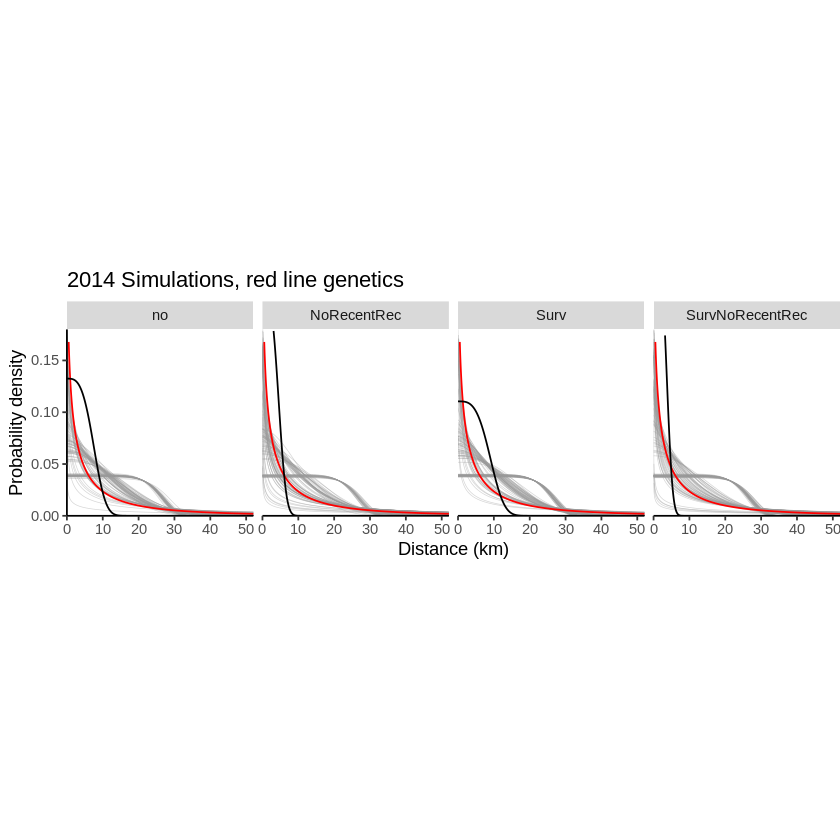

In [81]:
EnsemblesToPlot <- as.data.frame(year_adj_res) %>%
    group_by(iteration)

test <- ggplot(data= (EnsemblesToPlot %>% filter(Year=="2014")), aes(x=distance, y=dispersal))+ 
    geom_line(data= (EnsemblesToPlot %>% filter(Year=="2014")), aes(x=distance, y=dispersal, group=iteration),color="gray60", size=.2, alpha=0.4)+
    geom_line(data=(testForPlots %>% filter(Year=="2014" & DataType=="Gen")), aes(x=distance, y=dispersal), color="red") +
    geom_line(data=(SimToPlot %>% filter(Year=="2014" & DataType=="Sim")), aes(x=distance, y=dispersal), color="black") +
    #geom_area(data=kernel15, aes(x=dist, y=norm_pdf, fill=as.factor(median)), alpha=0.1)+
    #annotate("text", x =Inf, y = 0.17, vjust=1, hjust=1, label = "2014", size=6)+#8 for publication, 15 for presentation, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##annotate("text", x =MDD15, y = 0.01, vjust=1, hjust=1, label = "mu", color="deepskyblue2", size=15, family="Helvetica", parse=T)+#, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##scale_fill_manual(values= c("whitesmoke", "cadetblue3")) +
    ##scale_color_manual(values= c("whitesmoke", "cadetblue3")) +
    #geom_line(color="black", size=.6) +  
    ##geom_vline(xintercept = MDD15, linetype="dotted", color = "deepskyblue2", size=1) +
    theme(#axis.title.y=element_blank(),
    #axis.title.x=element_blank(),
    #plot.background = element_rect(colour = "black", size = 1),
    #axis.text.x =  element_text(size=15, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    #axis.text.y =  element_blank(), #element_text(size=15, color="black", family="Helvetica"), 
    panel.grid.major = element_blank(),
    plot.margin=unit(c(0,0,0.2,0.2),"cm"),#,
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Distance (km)") + #
    ylab("Probability density") + 
    #guides(fill=FALSE)+
    scale_x_continuous(limits = c(0,52), expand = c(0, 0), breaks=c(seq(0, 50, 10))) +
    scale_y_continuous(expand = c(0,0), limits = c(0,.18)) 
Facet2014 <- test + facet_grid(.~Adj) +
  theme(aspect.ratio = 1) + ggtitle("2014 Simulations, red line genetics")
Facet2014

#ggsave(filename="SimulationCaseKernelEnsembles2014.png", plot= Facet2014, path="~/oceanography/script_output/KernelFits/Plots/" )


In [111]:
#make a plot of all of the years, as facets, using the survival and recent recruit corrected fits. then plot genetics on top

ToPlot <- year_adj_res %>%
    filter(DataType=="Sim" & Adj=="SurvNoRecentRec" | DataType=="Gen") %>% 
    group_by(Year, DataType, iteration) %>%
    sample_n(100)

In [124]:
head(CombinedSims)

Year,iteration,Adj,metric,value,DataType
2012,1,no,k,-2.8047543,Sim
2012,2,no,k,-2.8511524,Sim
2012,3,no,k,-1.5418595,Sim
2012,4,no,k,-2.1396522,Sim
2012,5,no,k,-2.1590598,Sim
2012,6,no,k,-0.8263778,Sim


Warning message:
“Removed 4794 row(s) containing missing values (geom_path).”Warning message:
“Removed 4582 row(s) containing missing values (geom_path).”Warning message:
“Removed 98 row(s) containing missing values (geom_path).”Warning message:
“Removed 80 row(s) containing missing values (geom_path).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 4794 row(s) containing missing values (geom_path).”Warning message:
“Removed 4582 row(s) containing missing values (geom_path).”Warning message:
“Removed 98 row(s) containing missing values (geom_path).”Warning message:
“Removed 80 row(s) containing missing values (geom_path).”

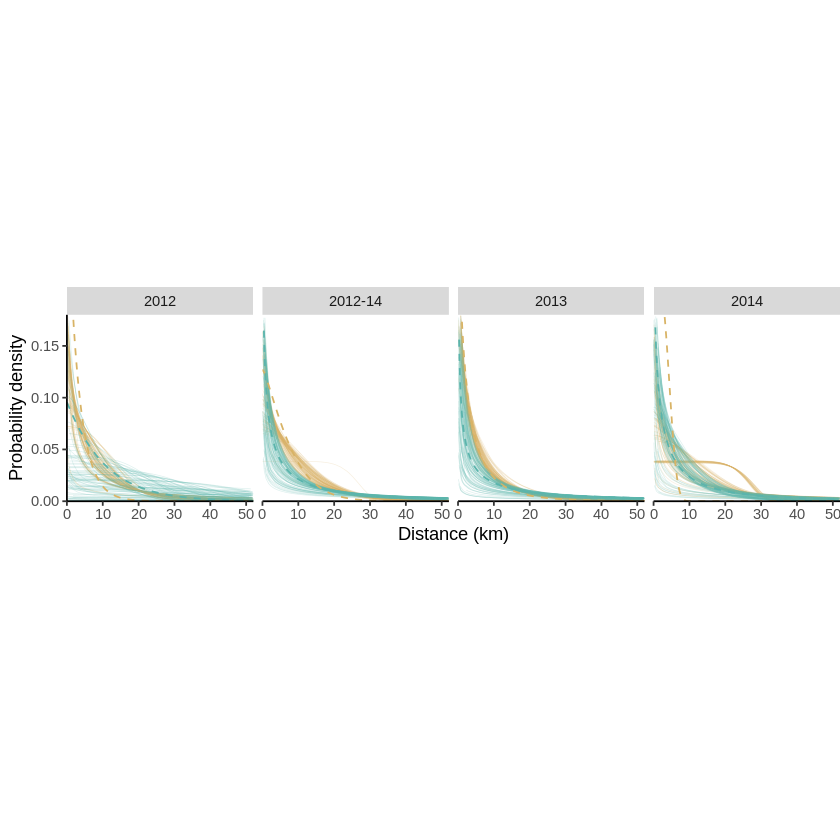

In [123]:
#EnsemblesToPlot <- as.data.frame(year_adj_res) %>%
#    group_by(iteration)
ToPlot$Year <- factor(ToPlot$Year, levels=c("2012", "2013", "2014", "2012-14"))

test <- ggplot(data= ToPlot) + 
    geom_line(data= (ToPlot %>% filter(DataType=="Sim")), aes(x=distance, y=dispersal, group=iteration), color="#d8b365", size=.2, alpha=0.2)+
    geom_line(data=(ToPlot %>% filter(DataType=="Gen")), aes(x=distance, y=dispersal, group=iteration), color="#5ab4ac", size=.2, alpha=0.2) +
    geom_line(data=(SimToPlot %>% filter(DataType=="Sim" & Adj=="SurvNoRecentRec")), aes(x=distance, y=dispersal), color="#d8b365", linetype="dashed") +
    geom_line(data=(SimToPlot %>% filter(DataType=="Gen")), aes(x=distance, y=dispersal), color="#5ab4ac", linetype="dashed") +
    #geom_area(data=kernel15, aes(x=dist, y=norm_pdf, fill=as.factor(median)), alpha=0.1)+
    #annotate("text", x =Inf, y = 0.17, vjust=1, hjust=1, label = "2014", size=6)+#8 for publication, 15 for presentation, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##annotate("text", x =MDD15, y = 0.01, vjust=1, hjust=1, label = "mu", color="deepskyblue2", size=15, family="Helvetica", parse=T)+#, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##scale_fill_manual(values= c("whitesmoke", "cadetblue3")) +
    ##scale_color_manual(values= c("whitesmoke", "cadetblue3")) +
    #geom_line(color="black", size=.6) +  
    ##geom_vline(xintercept = MDD15, linetype="dotted", color = "deepskyblue2", size=1) +
    theme(#axis.title.y=element_blank(),
    #axis.title.x=element_blank(),
    #plot.background = element_rect(colour = "black", size = 1),
    #axis.text.x =  element_text(size=15, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    #axis.text.y =  element_blank(), #element_text(size=15, color="black", family="Helvetica"), 
    panel.grid.major = element_blank(),
    plot.margin=unit(c(0,0,0.2,0.2),"cm"),#,
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Distance (km)") + #
    ylab("Probability density") + 
    #guides(fill=FALSE)+
    scale_x_continuous(limits = c(0,52), expand = c(0, 0), breaks=c(seq(0, 50, 10))) +
    scale_y_continuous(expand = c(0,0), limits = c(0,.18)) 
Facet <- test + facet_grid(.~Year) +
  theme(aspect.ratio = 1) #+ ggtitle("2014 Simulations, red line genetics")
Facet

ggsave(filename="SimulationAnnualKernelEnsembles.png", plot= Facet, path="~/oceanography/script_output/KernelFits/Plots/" )



In [46]:
head(GenProfiles)

k_eval,theta_eval,log_like,Year
-9.32,0.1,23.21581,2012
-9.31,0.1,23.21562,2012
-9.30,0.1,23.21542,2012
-9.29,0.1,23.21522,2012
-9.28,0.1,23.21502,2012
-9.27,0.1,23.21482,2012
